In [1]:
from alpha_vantage.timeseries import TimeSeries
from pprint import pprint
from selenium import webdriver
from bs4 import BeautifulSoup
import edgar
import time
from pathlib import Path
import pandas as pd
import os
import re
from datetime import datetime
from datetime import date
import json
import requests
import calendar
import sys

In [2]:
key='8NBLCOTKI465W93V'
secKey = "d76154d8c11c709dbdaaa8cdf25c2b69424847ba85f2a569742d588d0d53c8b0"
tblCnt = 0

In [3]:
ts = TimeSeries(key=key, output_format='pandas')
data, meta_data = ts.get_intraday(symbol='MSFT',interval='1min', outputsize='full')
pprint(data.head(2))

                     1. open  2. high  3. low  4. close  5. volume
date                                                              
2022-02-04 20:00:00    305.3    305.3   305.3     305.3      149.0
2022-02-04 19:59:00    305.2    305.2   305.2     305.2      571.0


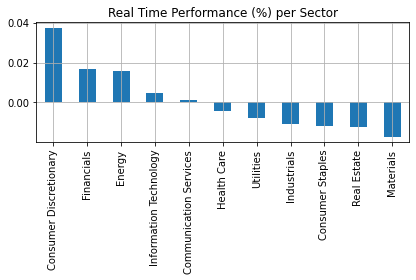

In [4]:
from alpha_vantage.sectorperformance import SectorPerformances
import matplotlib.pyplot as plt

sp = SectorPerformances(key=key, output_format='pandas')
data, meta_data = sp.get_sector()
data['Rank A: Real-Time Performance'].plot(kind='bar')
plt.title('Real Time Performance (%) per Sector')
plt.tight_layout()
plt.grid()
plt.show()

In [5]:
import requests
url = 'https://www.alphavantage.co/query?function=GLOBAL_QUOTE&symbol=IBM&apikey=demo'
print(url)

https://www.alphavantage.co/query?function=GLOBAL_QUOTE&symbol=IBM&apikey=demo


In [6]:
r = requests.get(url)
output = r.json()

In [7]:
print(output["Global Quote"]["05. price"])

137.1500


In [8]:
import pandas as pd
from io import StringIO
url = 'https://www.alphavantage.co/query?function=EARNINGS_CALENDAR&symbol=MSFT&horizon=3month&apikey=8NBLCOTKI465W93V'
r = requests.get(url)
content = r.text
print(str(content))

symbol,name,reportDate,fiscalDateEnding,estimate,currency
MSFT,Microsoft Corporation,2022-04-25,2022-03-31,2.19,USD



In [9]:
def getQtrsFrmRpt(org, edate, fynd):
    #print(edate)
    dateObj = datetime.strptime(edate, '%Y-%m-%d')
    #print(dateObj.month)
    emonth = dateObj.month
    eyr = dateObj.year
    k = 1
    qend = fynd
    qstart = 0
    year = eyr
    #print(year)
    qtrs = dict()
    while(k!=5):
        #print(k)
        qstart = (qend + 1)%12
        qend = (qend + 3)%12
        if qstart == 0:
            qstart = 12
        if qend == 0:
            qend = 12
        if((emonth >= qstart and emonth <= qend) or (qstart > qend and (emonth >= qstart or emonth <= qend))):
            #print("CQTR:", "Q"+str(k))
            qtrs["CQTR"] = "Q"+str(k)
            qtrs["GQTR"] = "Q"+str(k) # Guidance qtr is same as current qtr
            qtrs["CYR"] = str(year)
            qtrs["GYR"] = str(year) # Guidance year same as current year
            eqtr = (k-1)%4
            if(eqtr == 0):
                eqtr = 4
            nqtr = (k+1)%4
            if(nqtr == 0):
                nqtr = 4
            pqtr = (k-2)%4
            if(pqtr == 0):
                pqtr = 4
            qtrs["EQTR"] = "Q"+str(eqtr)
            qtrs["PQTR"] = "Q"+str(pqtr)
            #print("EQTR:", "Q"+str(eqtr))
            #print("PQTR:", "Q"+str(pqtr))
            #print("NQTR:", "Q"+str(nqtr))
        #print("Q"+str(k), "START", qstart)
        #print("Q"+str(k), "END", qend)
        qtr = "Q"+str(k)
        if (qtr not in qtrs):
            qtrs[qtr] = dict()
        qtrs[qtr]["START"] = qstart
        qtrs[qtr]["SM"] = calendar.month_abbr[qstart].upper()
        qtrs[qtr]["END"] = qend
        qtrs[qtr]["EM"] = calendar.month_abbr[qend].upper()
        #print("Q"+str(k), "YEAR", year)
        k = k + 1
    
    #print(eyr)   
    if("EQTR" in qtrs and "CQTR" in qtrs and "PQTR" in qtrs):
        eqtrEnd = qtrs[qtrs["EQTR"]]["END"]
        cqtrEnd = qtrs[qtrs["CQTR"]]["END"]
        pqtrEnd = qtrs[qtrs["PQTR"]]["END"]
        #print(eqtrEnd, cqtrEnd, pqtrEnd)
        qtrs["EYR"] = str(eyr)
        qtrs["PYR"] = str(eyr)
        #print(eqtrEnd, cqtrEnd, qtrs[qtrs["CQTR"]]["START"], qtrs[qtrs["CQTR"]]["END"])
        if(eqtrEnd > cqtrEnd):
            if(qtrs[qtrs["CQTR"]]["START"] > qtrs[qtrs["CQTR"]]["END"] and emonth > fynd):
                gyr = year + 1
                qtrs["GYR"] = str(gyr)
                qtrs["EYR"] = str(gyr - 1)
            else:
                qtrs["EYR"] = str(eyr - 1)
                qtrs["PYR"] = str(eyr - 1)
        if(pqtrEnd > eqtrEnd):
            qtrs["PYR"] = str(int(qtrs["EYR"]) - 1)
    if(emonth <= fynd):
        qtrs["CFYR"] = str(year)
    else:
        qtrs["CFYR"] = str(year + 1)
    qtrs["FYR"] = qtrs["CFYR"]
    if(qtrs[qtrs["EQTR"]]["END"] <= fynd and qtrs["EQTR"] > qtrs["CQTR"]):
        qtrs["FYR"] = str(int(qtrs["FYR"]) - 1)
    qtrs["EFYR"] = qtrs["FYR"]
    qtrs["PFYR"] = qtrs["FYR"]
    if(qtrs["PQTR"] > qtrs["EQTR"]):
        qtrs["PFYR"] = str(int(qtrs["FYR"]) - 1)
    qtrs["GFYR"] = qtrs["CFYR"]
    #qtrs["EYR"] = qtrs["FYR"]
    #qtrs["CYR"] = qtrs["CFYR"]
    #qtrs["PYR"] = qtrs["FYR"]
    qtrs["CYR"] = qtrs["GYR"]
    #print(qtrs)
    return (qtrs)

In [10]:
content = str(content)
f = StringIO(content)
#col_list = ["symbol"]
tbl = pd.read_csv(f, nrows=1)
#print(tbl)
#print(tbl["reportDate"][0])
print (len(tbl["reportDate"]))
if len(tbl["reportDate"]) > 0:
    dateStr = tbl["reportDate"][0]
    print(dateStr)

1
2022-04-25


In [11]:
import datetime
dateStr = datetime.datetime.strptime(dateStr, "%Y-%m-%d").date()
d = dateStr.strftime("%b %d")
print("Output 3:", d)

Output 3: Apr 25


In [12]:
#qtrs = [[1,3],[4,6],[7,9],[10,12]]
months = 12
qtr_len = 3
qtr_no = int(months/qtr_len)
qtrs = list()
start = 0
for i in range(qtr_no):
    qtr = list()
    start = 1 + start
    end = start + 2
    qtr.append(start)
    qtr.append(end)
    qtrs.append(qtr)
    start = end

print(qtrs)
month = 10
for o in qtrs:
    #print (o)
    if month >= o[0] and month <= o[1]:
        print(o)
        break

[[1, 3], [4, 6], [7, 9], [10, 12]]
[10, 12]


In [13]:
def get_qtrs():
    months = 12
    qtr_len = 3
    qtr_no = int(months/qtr_len)
    qtrs = list()
    start = 0
    for i in range(qtr_no):
        qtr = list()
        start = 1 + start
        end = start + 2
        qtr.append(start)
        qtr.append(end)
        qtrs.append(qtr)
        start = end
    return qtrs

In [14]:
def get_qtr_range(month, qtrs):
    #print(month)
    for o in qtrs:
        if month >= o[0] and month <= o[1]:
            return o

In [15]:
def get_stock_earningDate_detail(stock):
    url = 'https://www.alphavantage.co/query?function=EARNINGS_CALENDAR&symbol=' + stock + '&horizon=3month&apikey=8NBLCOTKI465W93V'
    try:
        r = requests.get(url)
        content = r.text
        return content
    except e:
        print(e)
        return None
    return None

In [16]:
import sys
from colorama import Fore, init, Back, Style
import openpyxl
import re

path = "../../Summary/stocks.xlsx"
wb_obj = openpyxl.load_workbook(path.strip())
# from the active attribute 
sheet_obj = wb_obj.active
sheet_obj

<Worksheet "12-Sep-2020">

In [17]:
max_column=sheet_obj.max_column
max_row=sheet_obj.max_row
max_column, max_row

(12, 58)

In [18]:
data = sheet_obj.cell(1,2)
print(data.value)

Quantity


In [19]:
path = "../../Summary/stocks_csv.csv"
d = pd.read_csv(path)
d["Ticker"]

0        NIO
1        BTI
2       ABBV
3        EPD
4        ENB
       ...  
128     DGRO
129     TD6C
130     TDG0
131    PTTRX
132      NaN
Name: Ticker, Length: 133, dtype: object

In [20]:
from datetime import datetime
qtrs = get_qtrs()
print(qtrs)
month = datetime.now().month
year = datetime.now().year
print(month, year)
qtr = get_qtr_range(month, qtrs)
qtr

[[1, 3], [4, 6], [7, 9], [10, 12]]
2 2022


[1, 3]

In [21]:
import math
months = ["0", "JAN", "FEB", "MAR", "APR", "MAY", "JUN", "JUL", "AUG", "SEP", "OCT", "NOV", "DEC"]
print(months[qtr[0]], months[qtr[1]])
cell = months[qtr[0]]+"-"+months[qtr[1]]+" "+ str(year)
#cell = months[7]+"-"+months[9]+" "+ str(year)
print(cell)
if cell not in d:
    d[cell] = None
    d.to_csv(path, index=False)
print(d[cell][3])
#if math.isnan(d[cell][3]):
#    print("Hello")

for index, value in enumerate(d[cell]):
    #print(index, value)
    #print(type(value))
    if type(value) is str:
        print(value)

JAN MAR
JAN-MAR 2022
01-Feb - UP (23.7900)
28-Feb
02-Feb - UP (138.6200)
01-Feb - UP (23.7900)
11-Feb
27-Jan - UP (228.0000)
26-Jan - UP (296.71)
17-Feb
16-Mar
04-Feb - UP (64.9900)
17-Feb
27-Jan - UP (319.1700)
09-Feb
14-Mar
09-Mar
17-Feb
02-Mar
23-Feb
01-Feb - DN (132.5700)
03-Feb - UP (27.2500)
14-Feb
07-Mar
09-Mar
26-Jan - DN (829.1000)
16-Feb
22-Feb
09-Feb
09-Feb
28-Feb
23-Feb
15-Feb
16-Feb
26-Jan - UP (228.2200)
16-Feb
21-Feb
28-Feb
23-Feb
07-Feb
22-Feb
14-Feb
08-Feb
28-Feb
08-Feb
03-Feb - UP (138.1800)
08-Feb
10-Feb
08-Mar
28-Mar
07-Mar
09-Mar
16-Feb
21-Mar
08-Mar
02-Mar
22-Feb
10-Feb
22-Feb
01-Feb - UP (118.0100)
02-Feb - DN (128.7200)
23-Feb
14-Feb
16-Feb
15-Feb
23-Feb
17-Feb
01-Mar
28-Feb
23-Feb
14-Feb
10-Feb
21-Feb
01-Feb - UP (128.4400)
18-Feb
01-Mar
02-Feb - DN (237.7600)
21-Feb
01-Mar
22-Mar
14-Feb
22-Feb
23-Feb
23-Feb
08-Feb
09-Feb
22-Feb
23-Feb
03-Feb - UP (38.9100)
09-Feb
16-Feb
27-Jan - UP (170.3300)
26-Jan - UP (528.6900)
22-Mar
17-Mar
23-Feb
05-Feb
10-Feb
23-Feb
09-

In [22]:
def get_dateStr(dateStr):
    dateStr = datetime.strptime(dateStr, "%Y-%m-%d").date()
    month = dateStr.month
    dStr = dateStr.strftime("%d-%b")
    return month, dStr

In [23]:
def get_month(dateStr):
    dateStr = datetime.strptime(dateStr, "%Y-%m-%d").date()
    month = dateStr.month
    #print(month)
    return month

In [24]:
def is_currentQtr(month):
    qtrs = get_qtrs()
    currMonth = datetime.now().month
    qtr = get_qtr_range(currMonth, qtrs)
    earningQtr = get_qtr_range(month, qtrs)
    if qtr == earningQtr:
        return True
    return False

In [25]:
status = is_currentQtr(7)
print(status)

False


In [26]:
from datetime import timedelta
print(d[cell][0])
content = d[cell][0]
if "(" not in content:
    print(True)
    #data = content.split(" ")
    #dateStr = (data[0].strip() + "-" + str(year))
    dateStr = (content.strip() + "-" + str(year))
    print(dateStr)
    dateS = datetime.strptime(dateStr, "%d-%b-%Y").date()
    nextDate = dateS + timedelta(days=1)
    print(str(dateS), str(nextDate))
    date = str(dateS)
    nextDate = str(nextDate)
    #month = date.month
    #dStr = date.strftime("%Y-%m-%d")
    #nStr = nextDate.strftime("%Y-%m-%d")
    #print(dStr)
    #return month, dStr



28-Feb
True
28-Feb-2022
2022-02-28 2022-03-01


In [27]:
url = "https://www.alphavantage.co/query?function=TIME_SERIES_DAILY_ADJUSTED&symbol=NIO&apikey=8NBLCOTKI465W93V"
r = requests.get(url)
output = r.json()

#curr = output.get("Time Series (Daily)").get('2021-04-30').get("5. adjusted close")
#prev = output.get("Time Series (Daily)").get('2021-04-29').get("5. adjusted close")
if(output):
    curr = output.get("Time Series (Daily)").get(nextDate).get("5. adjusted close")
    prev = output.get("Time Series (Daily)").get(date).get("5. adjusted close")
    print(curr, prev)
    diff = float(curr) - float(prev)
    print(diff)
    if (diff > 0):
        print("UP")
    elif (diff < 0):
        print(" - DN" + " (" + curr + ")")
    else:
        print("NC")

AttributeError: 'NoneType' object has no attribute 'get'

In [28]:
from datetime import datetime
from datetime import timedelta
import dateutil

def is_earningReport(title, earningDate, newsDate):
    #print(earningDate, newsDate)
    temp = earningDate
    if newsDate != temp:
        temp = temp + timedelta(days=1)
        if newsDate != temp:
            temp = earningDate
            temp = temp + timedelta(days=-1)
            if newsDate != temp:
                return False
    
    words1 = ["Announces", "Reports", "Releases", "Increase", "Raises"]
    words2 = ["Earnings", "Results", "Billable", "Revenue", "Revenues", "Income", "Letter"]
    if any(word in title for word in words1) and any(word in title for word in words2):
        #print(True)
        return True
    return False

In [29]:
def get_newsMarketTime(hour):
    if (hour > 12):
        return "AH"
    else:
        return "PM"

In [30]:
def get_newsDate(l):
    #print(l)
    interval = l.split(" ")
    num = interval[0]
    dateStr = datetime.now()
    newsDate = None
    #print(dateStr)
    if num == "yesterday":
        newsDate = dateStr + timedelta(days=-1)
        newsDate = newsDate + timedelta(hours=-12.30) #For US time
    elif interval[1] == "days":
        newsDate = dateStr + timedelta(days=-int(interval[0]))
        newsDate = newsDate + timedelta(hours=-12.30) #For US time
        #print(newsDate)
    elif interval[1] == "hours":
        newsDate = dateStr + timedelta(hours=-int(interval[0]))
        newsDate = newsDate + timedelta(hours=-12.30) #For US time
        #print(newsDate)
    elif interval[1] == "months":
        a_month = dateutil.relativedelta.relativedelta(months=int(interval[0]))
        newsDate = dateStr - a_month
    else:
        newsDate = dateStr
        newsDate = newsDate + timedelta(hours=-9.30) #For US Eastern time
        #print(newsDate)
    return newsDate

In [31]:
def get_cell(d):
    qtrs = get_qtrs()
    #print(qtrs)
    month = datetime.now().month
    year = datetime.now().year
    #print(month, year)
    qtr = get_qtr_range(month, qtrs)
    #print(qtr)

    months = ["0", "JAN", "FEB", "MAR", "APR", "MAY", "JUN", "JUL", "AUG", "SEP", "OCT", "NOV", "DEC"]
    #print(months[qtr[0]], months[qtr[1]])
    cell = months[qtr[0]]+"-"+months[qtr[1]]+" "+ str(year)
    
    if cell not in d:
        d[cell] = None
        d.to_csv(path, index=False)
    return cell

In [32]:
import traceback
def getElement(element, source, fromSrc):
    try:
        elem = list()
        soup = BeautifulSoup(source, "html.parser")
        
        if(element == "PREVELEM"):
            cnt = -1
            if(fromSrc == "YH"):
                for t in soup.find_all("div", class_="caas-table"):
                    cnt = cnt + 1
                    if t and t.previous_element:
                        #print("PREVIOUS ELEMENT "+str(cnt), t.previous_element)
                        #print("\n")
                        elem.append(str(t.previous_element).upper())
                    else:
                        elem.append("NONE")
                return(elem)
            else:
                for t in soup.find_all("table"):
                    cnt = cnt + 1
                    if t:
                        sib = t.previous_siblings
                        sibp = t.parent.previous_siblings
                        es = ""
                        for s in sib:
                            if(s and s.name):
                                #print(s)
                                #print(s.text)
                                es = es + " " + str(" ".join(s.strings).upper())
                                break
                        for r in sibp:
                            if(r and r.name):
                                #print(s)
                                #print(s.text)
                                es = es + " " + str(" ".join(r.strings).upper())
                                break
                        elem.append(es)
                        #print("PREVIOUS ELEMENT "+str(cnt), t.previous_element)
                        #print("\n")
                    else:
                        elem.append("NONE")
                return(elem)
    except Exception as e:
        print(e)
        print(traceback.format_exc())
        return None
    return None

In [33]:
import numpy as np
def findHeaders(table, match):
    hj = -1
    hstart = -1
    hend = -1
    #match = [str(cyr), str(pyr), str(nyr), nbr1, nbr2, nbr3]
    headers = list()
    
    mmatch = list()
    mmatch.append("AMOUNT (MILLIONS)")
    mmatch.append("MARGIN")
    mmatch.append("AMOUNT")
    mmatch.append("AMOUNT ($ MILLIONS)")
    mmatch.append("AMOUNT ($ BILLIONS)")
    mmatch.append("MARGIN (%)")
    
    #print("TABLE BEFORE FINDING HEADER", table)
    
    for i in range(0,len(table)):
        for j in range(1,len(table.columns)):
            cell = table.iloc[i,j]
            #print(len(str(cell).split(" ")), cell)
            if((len(str(cell).split(" ")) < 10) and (any(qtr.upper() in str(cell).upper() for qtr in match) or (i != 0 and len(headers) > 0 and any(qtr.upper() == str(cell).upper() for qtr in mmatch)))):
                #print("HEADER CELL CENTER", i, j)
                hj = i
                k = i
                hstart = -1
                hend = -1
                metric = table.iloc[k,0]
                # Multiple Headers may present inside single table
                if(len(headers) > 0):
                    #print(metric, k)
                    #hstart = i
                    #print(cell)
                    #print("MATCHHHHHHHHHHH", match)
                    #while((str(metric) == "nan" or str(metric) == cell or not any(qtr in str(cellm) for qtr in match)) and k>=0):
                    while((str(metric) == "nan" or str(metric) == cell) and k>=0):
                        hstart = k 
                        #print("HSTART", hstart)
                        k = k - 1
                        #print(metric, k)
                        if(k>=0):
                            metric = table.iloc[k,0]
                        else:
                            break
                    #if(hstart > 0):
                    #    print("NEW HsTARTTTTT", hstart)
                # Header always start from 0 index
                else:
                    hstart = 0
                if(i+1 < len(table)):
                    k = i+1
                    hend = i
                    metric = table.iloc[k,0]
                    while((str(metric) == "nan" or "THOUSANDS" in str(metric).upper() or "MILLIONS" in str(metric).upper()) and "REVENUE" not in str(metric).upper()):
                        hend = k 
                        #print("HEND", hend)
                        k = k + 1
                        if(k < len(table)):
                            metric = table.iloc[k,0]
                        else:
                            break
                else:
                    hend = i
                #print("HEADER BOUNDARY", hstart, hend)
                if(hstart > -1 and hend > -1):
                    hstr = str(hstart) + ":" + str(hend)
                    if(hstr not in headers):
                        headers.append(hstr)
                    break
    
    for i in range(0,len(table)):
        for j in range(1,len(table.columns)):
            cell = table.iloc[i,j]
            if(table.iloc[i,0] == cell):
                #print(cell)
                table.iloc[i,j] = np.nan
    print("HEADERSSSSSSSSS", headers)            
    return headers,table

In [34]:
def dedupHeaderColumns(header, report):
    mstr = None
    mindex = -1
    lvalidx = -1
    lvalsum = -1
    mdict = dict()
    
    # Check for columns where special character like $ present, need to preserve these columns in header
    rd = report.where(report=="$")
    rd = rd.dropna(axis=1, how="all")
    #print("SPECIAL COLUMNS NEED TO BE PRESERVED")
    #print(rd.columns)
    
    for i,v in enumerate(header.columns):
        #print(i,v)
        #print(header[v].astype(str).values)
        l = " ".join((header[v].astype(str).values))
        #print(l)
        # Find out which consecutive duplicate columns need to be removed
        if not mstr:
            mstr = l
            mindex = i
        else:
            if(l == mstr):
                if(lvalsum == -1):
                    lvalsum = report[v].isna().sum()
                    lvalidx = v
                if mindex not in mdict:
                    mdict[mindex] = list()
                    if(header.columns[i-1] not in rd.columns and v not in rd.columns):
                        if(report[header.columns[i-1]].isna().sum() > lvalsum):
                            mdict[mindex].append(header.columns[i-1])
                        else:
                            mdict[mindex].append(v)
                            lvalsum = report[v].isna().sum()
                            lvalidx = v
                    elif v in rd.columns and header.columns[i-1] in rd.columns:
                        mdict[mindex].append(v)
                        lvalsum = -2
                        lvalidx = header.columns[i-1]
                    elif v in rd.columns and header.columns[i-1] not in rd.columns:
                        mdict[mindex].append(header.columns[i-1])
                        lvalsum = -2
                        lvalidx = v
                    else:
                        mdict[mindex].append(v)
                        lvalsum = -2
                        lvalidx = header.columns[i-1]
                else:
                    if(report[v].isna().sum() >= lvalsum):
                        mdict[mindex].append(v)
                    else:
                        mdict[mindex].append(lvalidx)
                        lvalsum = report[v].isna().sum()
                        lvalidx = v
            else:
                mstr = l
                mindex = i
                lvalsum = -1
                lvalidx = -1
    #print("DUPLICATE HEADER COLUMNS TO BE DELETED")
    print(mdict)
    for item in mdict:
        header = header.drop(mdict[item], axis=1)
    return header

In [35]:
tableRules = [
    {
        "SOURCE":["COLUMN:FIRST"], # Search within original first column name (renamed by "METRIC")
        "MATCH":"ANY",
        "CONDITIONS":["NON-GAAP FINANCIAL", "NON-GAAP OPERATING EXPENSES"],
        "ACTIONS":["ACCOUNTING"]
    },
    {
        "SOURCE":["COLUMN:FIRST"], # Search within original first column name (renamed by "METRIC")
        "MATCH":"ANY",
        "CONDITIONS":["KEY FINANCIAL RESULT"],
        "ACTIONS":["HIGHLIGHT"]
    },
    {
        "SOURCE":["COLUMN:FIRST"], # Search within original first column name (renamed by "METRIC")
        "MATCH":"ANY",
        "CONDITIONS":["NON-GAAP NET INCOME"],
        "ACTIONS":["ACCOUNTING"]
    },
    {
        "SOURCE":["COLUMN:FIRST"], # Search within original first column name (renamed by "METRIC")
        "MATCH":"ANY",
        "CONDITIONS":["NON-GAAP GROSS PROFIT"],
        "ACTIONS":["ACCOUNTING"]
    },
    {
        "SOURCE":["COLUMN:FIRST"], # Search within original first column name (renamed by "METRIC")
        "MATCH":"ANY",
        "CONDITIONS":["STATEMENTS OF INCOME"],
        "ACTIONS":["STMTOP"] # Statement of Operation/Income
    },
    {
        "SOURCE":["COLUMN:FIRST"], # Search within original first column name (renamed by "METRIC")
        "MATCH":"EXACT",
        "CONDITIONS":["ASSETS"],
        "ACTIONS":["BALANCESHEET"]
    },
    {
        "SOURCE":["COLUMN:FIRST"], # Search within original first column name (renamed by "METRIC")
        "MATCH":"ANY",
        "CONDITIONS":["BALANCE SHEETS"],
        "ACTIONS":["BALANCESHEET"]
    },
    {
        "SOURCE":["COLUMN:FIRST"], # Search within original first column name (renamed by "METRIC")
        "MATCH":"ANY",
        "CONDITIONS":["SEGMENTED ADJUSTED GROSS MARGIN"],
        "ACTIONS":["SEGNGGM"]
    },
    {
        "SOURCE":["COLUMN:FIRST"], # Search within original first column name (renamed by "METRIC")
        "MATCH":"ANY",
        "CONDITIONS":["ADJUSTED GROSS MARGIN"],
        "ACTIONS":["NGGM"]
    },
    {
        "SOURCE":["COLUMN:FIRST"], # Search within original first column name (renamed by "METRIC")
        "MATCH":"ANY",
        "CONDITIONS":["SEGMENTED GROSS MARGIN"],
        "ACTIONS":["SEGGM"]
    },
    {
        "SOURCE":["COLUMN:FIRST"], # Search within original first column name (renamed by "METRIC")
        "MATCH":"ANY",
        "CONDITIONS":["ADJUSTED EBITDA"],
        "ACTIONS":["NGEBITDA"]
    },
    {
        "SOURCE":["COLUMN:FIRST"], # Search table description
        "MATCH":"ANY",
        "CONDITIONS":["EARNINGS BEFORE INTEREST AND TAXES"],
        "ACTIONS":["NGEBIT"]
    },
    {
        "SOURCE":["COLUMN:FIRST"], # Search within original first column name (renamed by "METRIC")
        "MATCH":"ANY",
        "CONDITIONS":["DIVISIONAL REVENUES"],
        "ACTIONS":["REVENUECHN"]
    },
    {
        "SOURCE":["COLUMN:METRIC"],
        "MATCH":"EXACT",
        "CONDITIONS":["ADJUSTED EBITDA MARGIN"],
        "ACTIONS":["HIGHLIGHT"]
    },
    {
        "SOURCE":["COLUMN:METRIC"],
        "MATCH":"EXACT",
        "CONDITIONS":["TOTAL CURRENT ASSETS"],
        "ACTIONS":["BALANCESHEET"]
    },
    {
        "SOURCE":["COLUMN:METRIC"],
        "MATCH":"EXACT",
        "CONDITIONS":["FREE CASH FLOW"],
        "ACTIONS":["FCF"]
    },
    {
        "SOURCE":["COLUMN:METRIC"],
        "MATCH":"EXACT",
        "CONDITIONS":["COST OF REVENUE"],
        "ACTIONS":["STMTOP"]
    },
    {
        "SOURCE":["COLUMN:METRIC"],
        "MATCH":"EXACT",
        "CONDITIONS":["COST OF SALES"],
        "ACTIONS":["STMTOP"]
    },
    {
        "SOURCE":["COLUMN:METRIC"],
        "MATCH":"ANY",
        "CONDITIONS":["PER SHARE DATA"],
        "ACTIONS":["PERSHARE"]
    },
    {
        "SOURCE":["COLUMN:METRIC"],
        "MATCH":"ANY",
        "CONDITIONS":["NET INVESTMENT INCOME"],
        "ACTIONS":["STMTOP"]
    },
    {
        "SOURCE":["COLUMN:METRIC"],
        "MATCH":"EXACT",
        "CONDITIONS":["COST OF GOODS SOLD"],
        "ACTIONS":["STMTOP"]
    },
    {
        "SOURCE":["COLUMN:METRIC"],
        "MATCH":"EXACT",
        "CONDITIONS":["OPERATING ACTIVITIES"],
        "ACTIONS":["STMTCASHFLOW"]
    },
    {
        "SOURCE":["COLUMN:METRIC"],
        "MATCH":"EXACT",
        "CONDITIONS":["CASH, ENDING"],
        "ACTIONS":["STMTCASHFLOW"]
    },
    {
        "SOURCE":["COLUMN:METRIC"],
        "MATCH":"EXACT",
        "CONDITIONS":["CASH FLOWS FROM OPERATING ACTIVITIES"],
        "ACTIONS":["STMTCASHFLOW"]
    },
    {
        "SOURCE":["COLUMN:METRIC"],
        "MATCH":"EXACT",
        "CONDITIONS":["CASH FLOWS FROM OPERATING ACTIVITIES:"],
        "ACTIONS":["STMTCASHFLOW"]
    },
    {
        "SOURCE":["COLUMN:METRIC"], # Search data only from "METRIC" column
        "MATCH":"ANY",
        "CONDITIONS":["ARPU", "DELIVERIES", "MAUS", "LOSS RATIO", "GROSS WRITTEN PREMIUMS", "ACTIVE BUYERS", "ACTIVE CLIENTS", "ASSETS AT FLOATING RATES", "NUMBER OF PORTFOLIO COMPANIES", "TOTAL ORIGINATIONS", "# OF INVESTMENTS"],
        "ACTIONS":["OPMETRIC"]
    },
    {
        "SOURCE":["COLUMN:METRIC"],
        "MATCH":"EXACT",
        "CONDITIONS":["GAAP INCOME FROM OPERATIONS"],
        "ACTIONS":["ACCOUNTING"]
    },
    {
        "SOURCE":["COLUMN:ANY"], # No specific column name, search any column name
        "MATCH":"ANY", # Match any condition
        "CONDITIONS":["GUIDANCE"],
        "ACTIONS":["GUIDANCE"]
    },
    {
        "SOURCE":["DESCRIPTION:ANY"], # Search table description
        "MATCH":"ANY",
        "CONDITIONS":["GUIDANCE", "OUTLOOK"],
        "ACTIONS":["GUIDANCE"]
    },
    {
        "SOURCE":["DESCRIPTION:ANY"], # Search table description
        "MATCH":"ANY",
        "CONDITIONS":["ADJUSTED EBITDA"],
        "ACTIONS":["NGEBITDA"]
    },
    {
        "SOURCE":["DESCRIPTION:ANY"], # Search table description
        "MATCH":"ANY",
        "CONDITIONS":["GAAP FINANCIAL METRICS", "EARNINGS PER SHARE RECONCILE"],
        "ACTIONS":["ACCOUNTING"]
    },
    {
        "SOURCE":["DESCRIPTION:ANY"], # Search table description
        "MATCH":"EXACT",
        "CONDITIONS":["NET REVENUE"],
        "ACTIONS":["REVENUE"]
    },
    {
        "SOURCE":["DESCRIPTION:ANY"], # Search table description
        "MATCH":"EXACT",
        "CONDITIONS":["REVENUE BY CHANNEL"],
        "ACTIONS":["REVENUECHN"]
    },
    {
        "SOURCE":["DESCRIPTION:ANY"], # Search table description
        "MATCH":"EXACT",
        "CONDITIONS":["REVENUE BY FORM"],
        "ACTIONS":["REVENUEFORM"]
    },
    {
        "SOURCE":["DESCRIPTION:ANY"],
        "MATCH":"EXACT",
        "CONDITIONS":["FINANCIAL RESULTS"],
        "ACTIONS":["STMTOP"]
    },
    {
        "SOURCE":["DESCRIPTION:ANY"], # Search table description
        "MATCH":"EXACT",
        "CONDITIONS":["ADJUSTED GROSS MARGIN"],
        "ACTIONS":["NGGM"] # Non-GAAP Gross Margin
    },
    {
        "SOURCE":["DESCRIPTION:ANY"], # Search table description
        "MATCH":"ANY",
        "CONDITIONS":["OPERATING METRIC"],
        "ACTIONS":["OPMETRIC"]
    }
]
print(tableRules)

[{'SOURCE': ['COLUMN:FIRST'], 'MATCH': 'ANY', 'CONDITIONS': ['NON-GAAP FINANCIAL', 'NON-GAAP OPERATING EXPENSES'], 'ACTIONS': ['ACCOUNTING']}, {'SOURCE': ['COLUMN:FIRST'], 'MATCH': 'ANY', 'CONDITIONS': ['KEY FINANCIAL RESULT'], 'ACTIONS': ['HIGHLIGHT']}, {'SOURCE': ['COLUMN:FIRST'], 'MATCH': 'ANY', 'CONDITIONS': ['NON-GAAP NET INCOME'], 'ACTIONS': ['ACCOUNTING']}, {'SOURCE': ['COLUMN:FIRST'], 'MATCH': 'ANY', 'CONDITIONS': ['NON-GAAP GROSS PROFIT'], 'ACTIONS': ['ACCOUNTING']}, {'SOURCE': ['COLUMN:FIRST'], 'MATCH': 'ANY', 'CONDITIONS': ['STATEMENTS OF INCOME'], 'ACTIONS': ['STMTOP']}, {'SOURCE': ['COLUMN:FIRST'], 'MATCH': 'EXACT', 'CONDITIONS': ['ASSETS'], 'ACTIONS': ['BALANCESHEET']}, {'SOURCE': ['COLUMN:FIRST'], 'MATCH': 'ANY', 'CONDITIONS': ['BALANCE SHEETS'], 'ACTIONS': ['BALANCESHEET']}, {'SOURCE': ['COLUMN:FIRST'], 'MATCH': 'ANY', 'CONDITIONS': ['SEGMENTED ADJUSTED GROSS MARGIN'], 'ACTIONS': ['SEGNGGM']}, {'SOURCE': ['COLUMN:FIRST'], 'MATCH': 'ANY', 'CONDITIONS': ['ADJUSTED GROSS M

In [94]:
import traceback
from datetime import date
def getOneTable(tables, tableNum, tblDesc):
    if not tables:
        print("TABLES CORRUPTED")
        return None
    if(tableNum >= len(tables)):
        print("INVALID TABLE INDEX")
        return None
    try:
        
        todays_date = date.today()
        cyr = todays_date.year
        pyr = cyr - 1
        ppyr = cyr - 2
        nyr = cyr + 1
        nbr = str(nyr)[2:4]
        cbr = str(cyr)[2:4]
        nbr1 = "FY’"+nbr
        nbr2 = "FY"+nbr
        nbr3 = "’"+nbr
        cbr1 = "FY’"+cbr
        cbr2 = "FY"+cbr
        cbr3 = "’"+cbr
        cg = "FY"+cbr+"GUIDANCE"
        ng = "FY"+nbr+"GUIDANCE"
        
        hdmatch = ["FY20", "FY21", cbr1, cbr2, cbr3, "FY19GUIDANCE", "FY20GUIDANCE", "FY21GUIDANCE", cg, ng, str(cyr), str(pyr), str(ppyr), str(nyr), nbr1, nbr2, nbr3, "2019", "2016", "2017", "2018", "FY19", "FY16", "FY17", "FY18"]
        
        mn = ["MILLIONS", "MILLION", "millions", "million"]
        bn = ["BILLIONS", "BILLION", "billions", "billion"]
        t = ["THOUSANDS", "THOUSAND", "thousands", "thousand", "$000"]
        
        stmt = tables[tableNum]
        print("ORIGINAL TABLE ", tableNum)
        print(stmt)
    
        #stmt=stmt.T.drop_duplicates().T
        # Clean first column which could be METRIC column
        stmt[stmt.columns[0]] = stmt[stmt.columns[0]].astype(str)
        stmt[stmt.columns[0]] = stmt[stmt.columns[0]].str.encode("ascii", "ignore")
        stmt[stmt.columns[0]] = stmt[stmt.columns[0]].str.decode(encoding="utf8")
        stmt[stmt.columns[0]] = stmt[stmt.columns[0]].replace(r'^\s*$', np.nan, regex=True)
        stmt[stmt.columns[0]] = stmt[stmt.columns[0]].replace(r'nan', np.nan)
        
        stmt = stmt.dropna(axis=1, how="all")
        stmt = stmt.dropna(axis=0, how="all")
        columns = [i for i, x in enumerate(list(stmt.columns))]
        #print(columns)
        stmt.columns = columns
        #print("TABLE AFTER REMOVING DUPLICATE ROWS AND COLUMNS")
        #print(stmt)
    
        headers,stmt = findHeaders(stmt, hdmatch)
        #print(headers)
    
        if(len(headers) == 0):
            print("INVALID TABLE, HEADER NOT FOUND")
            return None
    
        #print("TABLE AFTER REMOVING DUPLICATES")
        #print(stmt)
    
        #Itereate through headers
        cnt = 0
        ft = dict()
        for i in list(headers):
            #print(i)
            tblName = None
            tblType = None
            cnt = cnt + 1
            hstart = int(i.split(":")[0])
            hend = int(i.split(":")[1])
            if(len(headers) > cnt):
                rend = int(headers[cnt].split(":")[0])
            else:
                rend = len(stmt)
            #print("\nHEADER START", hstart, "HEADER END", hend, "REPORT END", rend)
            header = stmt.iloc[hstart:hend+1,0:]
            #header = header.dropna(axis=1, how="all")
            report = stmt.iloc[hend+1:rend,0:]
            #report = report.dropna(axis=1, how="all")
            #print("\nHEADER "+str(cnt))
            #print(header)
            #print("\nREPORT "+str(cnt))
            #print(report)
            
            # Make sure column with valid calendar field is present in subsequent tables
            mfound = False
            if(cnt > 1):
                for i,v in enumerate(header.columns):
                    l = " ".join((header[v].astype(str).values))
                    #print("FOR CNT {}, value is {}".format(cnt, l))
                    if(any(mtch.upper() in l.upper() for mtch in hdmatch)):
                        mfound = True
                        break
                #print("CALENDER FIELD PRESENT: {}".format(mfound))
                if(not mfound):
                    fh = headers[0]
                    fhs = int(fh.split(":")[0])
                    fhe = int(fh.split(":")[1])
                    #print(fhs, fhe)
                    fhd = stmt.iloc[fhs:fhe+1,0:]
                    fhd = fhd.replace(np.nan, "APNATEC")
                    mrowidx = -1
                    #print("FHD\n", fhd)
                    for v in list(fhd.columns):
                        mrows = fhd[fhd[v].str.contains("|".join(hdmatch))]
                        if(len(mrows) > 0):
                            mrow = mrows.iloc[0]
                            mrow = mrow.replace("APNATEC", np.nan)
                            mrowidx = mrows.index[0]
                            #print("MATCH ROW:", mrowidx)
                            break
                    if(mrowidx >= 0):
                        #header = stmt.loc[mrowidx] + header
                        header.loc[len(header.index)] = stmt.loc[mrowidx]
                        #print("NEW HEADER\n", header)
            
            for col in list(report.columns):
                report[report.columns[col]] = report[report.columns[col]].astype(str)
                report[report.columns[col]] = report[report.columns[col]].str.encode("ascii", "ignore")
                report[report.columns[col]] = report[report.columns[col]].str.decode(encoding="utf8")
        
                report[report.columns[col]] = report[report.columns[col]].replace(r'nan', np.nan)
                report[report.columns[col]] = report[report.columns[col]].replace(r'\\u200b', np.nan)
                report[report.columns[col]] = report[report.columns[col]].replace(r'\\u00a0', np.nan)
                report[report.columns[col]] = report[report.columns[col]].replace("", np.nan)
            
            #print(report.to_json(orient="records"))
            
            header = dedupHeaderColumns(header, report)
            
            #print("\nAFTER DELETING DUPLICATE COLUMN HEADER")
            #print("\nHEADER "+str(cnt))
            #print(header)
            
            if(len(header) == 0):
                print("NO HEADER FOUND")
                return None
            
            header1 = header[0]
            #print("HEADER BATCH 1")
            #print(header1)
            
            header2 = header[header.columns[1:]]
            header2 = header2.dropna(axis=1, how="all")
            
            #print("HEADER BATCH 2 BEFORE DROPPING BASED ON FILTERS\n")
            #print(header2)
            
            hddrop = list()
            newmatch = hdmatch + ["CHANGE", "QOQ", "YOY", "GROWTH", "MARGIN", "MILLIONS", "OUTLOOK"]
            nomatch = ["COMPARED TO", "WAS", "GROSS", "OPERATING", "INCREASED", "DECREASED", "WERE", "HAS", "HAVE"]
            for hd in list(header2.columns):
                header2[hd] = (header2[hd]).astype(str).str.upper()
                mcount = header2[hd].str.contains("|".join(list(map(str.upper,newmatch)))).sum()
                nmcount = header2[hd].str.contains("|".join(list(map(str.upper,nomatch)))).sum()
                #print(hd, mcount, nmcount)
                if(mcount == 0 or nmcount > 0):
                    hddrop.append(hd)
            
            #print("\nINVALID HEADER")
            #print(hddrop)
            header2 = header2.drop(hddrop, axis=1)
            #print("HEADER BATCH 2\n")
            #print(header2)
            
            if(len(header2) == 0 or len(list(header2.columns)) == 0):
                print("NO HEADER FOUND AFTER DROPPING COLUMNS")
                return None
            
            header = pd.concat([header1, header2], axis=1, join='inner')
            header[header.columns[0:]] = header[header.columns[0:]].astype(str)
            #print(header)
            header[header.columns[0:]] = header[header.columns[0:]].applymap(lambda x: re.sub(r'\(\d+\)|\(\d+[a-zA-Z]\)*|\*', r'', x))
            #print("FINAL HEADER")
            #print(header)
            
            #report = report.T.drop_duplicates().T
            report = report.dropna(axis=1, how="all")
            
            #print("\nAFTER DELETING DUPLICATE ROWS")
            #print("\nREPORT "+str(cnt))
            #print(report)
            
            if(len(report) > 0):
            
                # Merge REPORT columns present with special characters - e.g. $/% etc...
                rd = report.where(report=="$")
                rd = rd.dropna(axis=1, how="all")
                #print("\nSPECIAL COLUMNS")
                #print(rd.columns)
                dropList = list()
                #print("BEFORE DROPPING COLUMNS FROM REPORT\n", report)
                #print("BEFORE DROPPING COLUMNS FROM RD\n", rd)
                for i in list(rd.columns):
                    #print(report[i])
                    report[i] = report[i].map(lambda x: "" if str(x) != "$" else x)
                    k = i + 1
                    while(k in list(rd.columns)):
                        dropList.append(k)
                        #rd.columns = list(rd.columns).remove(k)
                        k = k + 1
                    while(k not in list(report.columns) and k <= max(list(report.columns))):
                        #print(i, k, report[i], report[k])
                        k = k + 1
                    if(k <= max(list(report.columns))):
                        report[i] = report[i] + report[k]
                        dropList.append(k)
                #print(dropList)
                #print(report)
                report = report.drop(dropList, axis=1)
                report[report.columns[1:]] = report[report.columns[1:]].astype(str)
                #report[report.columns[1:]] = report[report.columns[1:]].applymap(lambda x: x.replace('$(','-$'))
                #report[report.columns[1:]] = report[report.columns[1:]].applymap(lambda x: x.replace('(','-'))
                #report[report.columns[1:]] = report[report.columns[1:]].applymap(lambda x: x.replace(')',''))
                report[report.columns[1:]] = report[report.columns[1:]].applymap(lambda x: x.replace(',',''))
                report[0] = report[0].str.replace(":","")
                report[0] = report[0].str.replace(r'\d+|\(\d+\)|\(\d+[a-zA-Z]\)*|\*', r'')
                report[0] = report[0].str.upper()
                #report[report.columns[1:]] = report[report.columns[1:]].astype(float)
            
                rd = report.where(report=="%")
                rd = rd.dropna(axis=1, how="all")
                #print(rd)
                dropList = list()
                mgclmn = -1
                #print(rd.columns)
                for i in list(rd.columns):
                    #print(report[i])
                    report[i] = report[i].map(lambda x: "" if str(x) != "%" else x)
                    mgclmn = i - 1
                    while(mgclmn>=0):
                        if mgclmn not in header.columns:
                            mgclmn = mgclmn - 1
                        else:
                            #print(mgclmn,i)              
                            report[mgclmn] = report[mgclmn] + report[i]
                            dropList.append(i)
                            break
                report = report.drop(dropList, axis=1)
                #print("\nREPORT AFTER MERGING SPECIAL COLUMNS")
                #print(report)
            
                hdclmn = header.columns
                rclmn = report.columns
                #print("\nHEADER COLUMNS", hdclmn)
                #print("REPORT COLUMNS", rclmn)
            
                if(len(hdclmn) == 1 and len(header) == 1):
                    #print("SINGLE COLUMN")
                    if(str(header.iloc[0,0]) == "nan"):
                        #print("INVALID HEADER CONTENT FOR SINGLE COLUMN, BAILING OUT")
                        return None
                    s = header.iloc[0,0]
                    #Remove special characters
                    s = re.sub('[^a-zA-Z0-9 \n\.]', '', s)
                    #print(s)
                    data = list()
                    data = [str(s)+"***"+str(item) for item in list(rclmn)]
                    header = pd.DataFrame(np.array([data]),columns=rclmn)
                    hdclmn = header.columns
                    #print("NEW HEADER COLUMNS", hdclmn)
            
            
                finalClmns = hdclmn.intersection(rclmn)
                #print("INTERSECTION COLUMNS",finalClmns)
                header = header[finalClmns]
                #print("FINAL HEADER")
                #print(header)
            
                hstr = list()
            
                count = -1
                for i in list(header.columns):
                    count = count + 1
                    l = header[i].astype(str).values
                    l = ' '.join(dict.fromkeys(l))
                    l = l.replace("-nan","-")
                    l = l.replace("nan-","")
                    l = l.replace("nan ","")
                    l = l.replace(" nan","")
                    l = l.replace(" nan ","")
                    l = l.strip()
                    #print(hstr)
                    if l.upper() in hstr:
                        l = l+"***"+str(count)
                    hstr.append(l.upper())
                    #print(l)
            
                tblType = hstr[0]
                #print("\nORIGINAL FIRST COLUMN NAME")
                #print(tblType)
            
                #print("\nTABLE DESCRIPTION")
                #print(tblDesc)
            
                hstr[0] = "METRIC"
                #print("\nFINAL HEADER STRING")
                #print(hstr)
                
                report = report[finalClmns]
                report.columns = hstr
                print("\nFINAL REPORT")
                print(report)
            
                #print("\nREPORT COLUMNS")
                #print(report.columns)
            else:
                # When entire report rows are detected as header of table
                #print("EMPTY REPORT, ASSIGN HEADER TO REPORT")
                #hstr = list(header.columns)
                print("HEADER FOR EMPTY ROW\n", header)
                hstr = list(header.iloc[0])
                #print(hclmn)
                hstr[0] = "METRIC"
                report = header
                hstr = map(lambda x: str(x), hstr)
                #print("HEADER COLUMNS FOR EMPTY ROW-1", hstr)
                report.columns = (hstr)
                print("\nFINAL REPORT")
                print(report)
                #report.columns[0] = "METRIC"
            
            # Select unit of the table numbers
            unit = "T"
            for word in (mn+bn+t):
                if((hstr and any(word in clmn for clmn in hstr)) or (tblType and word in tblType) or (tblDesc and word in tblDesc) or report["METRIC"].str.contains(word).sum() > 0):
                    if word in mn:
                        unit = "M"
                        break
                    elif word in bn:
                        unit = "B"
                        break
                    else:
                        unit = "T"
                        break
            
            # Select table type
            for item in list(tableRules):
                source = (item["SOURCE"][0])
                stype = item["SOURCE"][0].split(":")[0]
                sval = item["SOURCE"][0].split(":")[1]
                condition = item["CONDITIONS"][0]
                match = item["MATCH"]
                action = item["ACTIONS"][0]
                #print(match, condition, sval)
                #print(condition)
                
                if(stype == "COLUMN"):
                    if(sval == "FIRST"):
                        if match == "EXACT" and tblType and tblType == condition:
                            tblName = action
                            break
                        elif match == "ANY" and tblType and any(word in tblType for word in item["CONDITIONS"]):
                            tblName = action
                            break
                    elif(sval != "ANY"):
                        if match == "EXACT" and report[sval].eq(condition).sum()> 0:
                            #print("TABLE NAME BALANCESHEET")
                            tblName = action
                            break
                        elif match == "ANY" and report[sval].str.contains("|".join(item["CONDITIONS"])).sum()> 0:
                            tblName = action
                            break
                    else:
                        if(match == "ANY" and any(s in " ".join(report.columns) for s in item["CONDITIONS"])):
                            tblName = action
                            break
                        elif(match == "EXACT" and any(s in (report.columns) for s in item["CONDITIONS"])):
                            tblName = action
                            break
                elif(stype == "DESCRIPTION"):
                    if(sval == "ANY"):
                        #print(match)
                        #print("|".join(item["CONDITIONS"]))
                        if match == "EXACT" and tblDesc and tblDesc == condition:
                            tblName = action
                            break
                        elif match == "ANY" and tblDesc and any(word in tblDesc for word in item["CONDITIONS"]):
                            tblName = action
                            break
                
            if not tblName:
                key = str(tableNum)+":"+unit+":"+"OTHER"+":"+str(cnt)
                #ft[str(tableNum)+":"+unit+":"+"OTHER"+":"+str(cnt)] = report.to_json(orient="records")
            else:
                key = str(tableNum)+":"+unit+":"+tblName+":"+str(cnt)
                #ft[str(tableNum)+":"+unit+":"+tblName+":"+str(cnt)] = report.to_json(orient="records")
            ft[key] = dict()
            ft[key]["FIRSTCOLUMN"] = tblType
            ft[key]["TABLEDESC"] = tblDesc
            ft[key]["TABLENAME"] = tblName
            ft[key]["SUBTABLE"] = cnt
            ft[key]["UNIT"] = unit
            ft[key]["TABLENUM"] = tableNum
            ft[key]["COLUMNS"] = list(report.columns)
            ft[key]["METRICS"] = report["METRIC"].values.tolist()
            ft[key]["TABLE"] = report.to_json(orient="records")
            #print(ft)
        return(ft)
    except Exception as e:
        print("EXCEPTION:", e)
        print(traceback.format_exc())
        return None

In [92]:
def getPgSource(url):
    driver = webdriver.Chrome()

    driver.get(url)
    time.sleep(2)

    source = driver.page_source
    #print(driver.page_source)
    driver.close()
    return(source)

In [38]:
def getAllTables(url, src):
    allTables = dict()
    source = getPgSource(url)
    tables = None
    try:
        tables = pd.read_html(source)
    except:
        tables = None
        return None
    
    print("NUMBER OF TABLES", len(tables))
    allTables["TOTAL"] = len(tables)
    allTables["PARSESUCCESS"] = list()
    allTables["PARSEFAIL"] = list()
    
    tableDesc = getElement("PREVELEM", source, src)
    #print("ALL TABLE DESCRIPTIONS")
    #print(tableDesc)
    
    for i in range(0, len(tables)):
        tableNum = i
        print("\nFOR TABLE", tableNum)
        desc = "NONE"
        if tableDesc and tableNum < len(tableDesc):
            desc = tableDesc[tableNum]
        print("\nTABLE DESCRIPTION:", desc)

        ft = getOneTable(tables, tableNum, desc)
        #print("\n")
        #print(ft)
        if i not in allTables:
            allTables[i] = dict()
        allTables[i]["ORIGINAL"] = tables[tableNum].to_json(orient="records")
        if ft:
            allTables["PARSESUCCESS"].append(i)
            for key in ft:
                tblName = key.split(":")[2]
                #print(tblName)
                if tblName not in allTables:
                    allTables[tblName] = list()
                if "PARSE" not in allTables[i]:
                    allTables[i]["PARSE"] = list()
                if "TYPE" not in allTables[i]:
                    allTables[i]["TYPE"] = list()
                allTables[tblName].append(ft[key])
                allTables[i]["PARSE"].append(ft[key])
                allTables[i]["TYPE"].append(tblName)
        else:
            allTables["PARSEFAIL"].append(i)
        
    return (allTables)

In [95]:
import json
#url = "https://www.sec.gov/Archives/edgar/data/1477449/000155837019001185/ex-99d1.htm"
url = "https://www.sec.gov/Archives/edgar/data/1699838/000095017021001629/cflt-20210805ex99_1.htm"
#org = "JPM"
dest = "../../Summary/report/"
filename = "FB-REPORT-2021-10-25_13-01-24.640332.txt"
allTables = getAllTables(url, "EDGAR")
#print("\nALL TABLES")
#print(allTables)
#if(allTables):
    #print(data)
#    json_object = json.dumps(allTables, indent = 4)
#    file = dest+filename
  
    # Writing to sample.json
#    with open(file, "w") as outfile:
#        outfile.write(json_object)

NUMBER OF TABLES 10

FOR TABLE 0

TABLE DESCRIPTION:  (IN MILLIONS, EXCEPT PER SHARE DATA)
ORIGINAL TABLE  0
                                       0        1        2           3
0                                    NaN      NaN      NaN         NaN
1                                    NaN  Q2 2021  Q2 2020  Y/Y Change
2                          Total Revenue    $88.3    $53.9         64%
3      Remaining Performance Obligations   $327.2   $190.6         72%
4                    GAAP Operating Loss  $(86.0)  $(27.5)     $(58.5)
5                Non-GAAP Operating Loss  $(36.8)  $(20.4)     $(16.4)
6                GAAP Net Loss Per Share  $(0.74)  $(0.25)     $(0.49)
7            Non-GAAP Net Loss Per Share  $(0.31)  $(0.19)     $(0.12)
8  Net Cash Used in Operating Activities  $(43.2)  $(21.5)     $(21.7)
9                         Free Cash Flow  $(45.4)  $(22.7)     $(22.7)
HEADERSSSSSSSSS ['0:0']
{}

FINAL REPORT
                                  METRIC  Q2 2021  Q2 2020 Y/Y CHANGE

{1: [2], 3: [4], 5: [6], 8: [9], 10: [11], 12: [13]}

FINAL REPORT
                                               METRIC  \
3                                             REVENUE   
4                                        SUBSCRIPTION   
5                                            SERVICES   
6                                       TOTAL REVENUE   
7                                     COST OF REVENUE   
8                                        SUBSCRIPTION   
9                                            SERVICES   
10                              TOTAL COST OF REVENUE   
11                                       GROSS PROFIT   
12                                 OPERATING EXPENSES   
13                           RESEARCH AND DEVELOPMENT   
14                                SALES AND MARKETING   
15                         GENERAL AND ADMINISTRATIVE   
16                           TOTAL OPERATING EXPENSES   
17                                     OPERATING LOSS   
18                   

HEADERSSSSSSSSS ['0:1']
{1: [2], 3: [4], 5: [6], 7: [8], 9: [10], 11: [12], 13: [14]}

FINAL REPORT
                                               METRIC  \
3                CASH FLOWS FROM OPERATING ACTIVITIES   
4                                            NET LOSS   
5   ADJUSTMENTS TO RECONCILE NET LOSS TO CASH USED...   
6                       DEPRECIATION AND AMORTIZATION   
7   NET AMORTIZATION OF PREMIUMS OR DISCOUNTS ON M...   
8   AMORTIZATION OF DEFERRED CONTRACT ACQUISITION ...   
9                      NON-CASH OPERATING LEASE COSTS   
10           COMMON STOCK CHARITABLE DONATION EXPENSE   
11  STOCK-BASED COMPENSATION, NET OF AMOUNTS CAPIT...   
12                              DEFERRED INCOME TAXES   
13                                              OTHER   
14        CHANGES IN OPERATING ASSETS AND LIABILITIES   
15                                ACCOUNTS RECEIVABLE   
16                DEFERRED CONTRACT ACQUISITION COSTS   
17                  PREPAID EXPENSES AND OTHE

{1: [2], 3: [4], 5: [6], 7: [8], 9: [10], 11: [12], 13: [14]}

FINAL REPORT
                                               METRIC  \
3   RECONCILIATION OF GAAP OPERATING LOSS TO NON-G...   
4                      OPERATING LOSS ON A GAAP BASIS   
5                ADD STOCK-BASED COMPENSATION EXPENSE   
6   ADD EMPLOYER TAXES ON EMPLOYEE STOCK TRANSACTIONS   
7        ADD COMMON STOCK CHARITABLE DONATION EXPENSE   
8                             NON-GAAP OPERATING LOSS   
9                           NON-GAAP OPERATING MARGIN   
11  RECONCILIATION OF GAAP NET LOSS TO NON-GAAP NE...   
12                           NET LOSS ON A GAAP BASIS   
13               ADD STOCK-BASED COMPENSATION EXPENSE   
14  ADD EMPLOYER TAXES ON EMPLOYEE STOCK TRANSACTIONS   
15       ADD COMMON STOCK CHARITABLE DONATION EXPENSE   
16             ADD INCOME TAX EFFECTS AND ADJUSTMENTS   
17                                  NON-GAAP NET LOSS   
18  NON-GAAP NET LOSS PER SHARE ATTRIBUTABLE TO CO...   
19  WEIGHTED

In [39]:
def storeRefinedContent(source, url, file):
    soup = BeautifulSoup(source, 'lxml')
    title = soup.find("title")
    title = (title.text)
    with open(file, 'w', encoding = 'utf-8') as f:
        f.write("url="+url)
        f.write("\n")
        f.write(title)
        f.write(".\n")
        list_of_forms = soup.find_all('div', class_="caas-body")
        for item in (list_of_forms):
            children = item.findChildren("p", recursive=True)
            for ctag in children:
                if(len(ctag.text.strip().split(" ")) < 2):
                    continue
                ctext = (" ".join(ctag.strings))
                ctext = ctext.strip()
                ctext = ctext.replace(u'\xa0', ' ')
                ctext = ("PG*** "+ctext)
                if (ctext[len(ctext)-1]) != ".":
                    ctext = ctext + ".\n"
                else:
                    ctext = ctext + "\n"
                if("Forward-Looking Statements" in ctext or "Forward Looking Statements" in ctext):
                    break
                else:
                    f.write(ctext)

In [40]:
import time
from selenium import webdriver
from bs4 import BeautifulSoup
import json

def store_earning_news(earningDateStr, stock):
    # Web scrapper for infinite scrolling page 
    url = "https://finance.yahoo.com/quote/" + stock + "/press-releases?p=" + stock
    
    driver = webdriver.Chrome()
    driver.get(url)
    time.sleep(2)  # Allow 2 seconds for the web page to open
    scroll_pause_time = 2 
    screen_height = driver.execute_script("return window.screen.height;")   # get the screen height of the web

    i = 1
   
    SCROLL_PAUSE_TIME = 0.5
    last_height = driver.execute_script("return document.body.scrollHeight")
    while True:
        driver.execute_script("window.scrollTo(0, document.body.scrollHeight);")
        time.sleep(SCROLL_PAUSE_TIME)
        new_height = driver.execute_script("return document.body.scrollHeight")
        if new_height == last_height:
            break
        last_height = new_height

    ##### Extract Article Titles #####

    earningDate = datetime.strptime(earningDateStr, '%Y-%m-%d')
    
    news_list = list()
    soup = BeautifulSoup(driver.page_source, "html.parser")

    for t in soup.find_all(class_="Cf"):
        #print(t)
        news = dict()
        a_tag = t.find("a", class_="Fw(b)", href=True)
        #a_tag = t.find("u", class_="StretchedBox")
        if a_tag:
            #print(a_tag)
            text = a_tag.text
            news["Title"] = text
            news["Link"] = "https://finance.yahoo.com" + a_tag["href"]
            news["Provider"] = None
            news["Date"] = None
            news["Content"] = None
        
            provider = t.find("div", class_="C(#959595)")
            if provider:
                c = provider.text
                ctx = (c.encode("ascii", "replace").decode())
                l = ctx.split("?")
                news["Provider"] = l[0]
                news["Date"] = str(get_newsDate(l[1]))
            else:
                continue
        
            p_content = t.find("p", class_="Fz(14px)")
            if p_content:
                c = p_content.text
                news["Content"] = c
        
            newsDateArr = news["Date"].split(" ")
            newsDateStr = newsDateArr[0]
            newsDate = datetime.strptime(newsDateStr, '%Y-%m-%d')
            if not is_earningReport(news["Title"], earningDate, newsDate):
                continue
            else:
                news_list.append(news)
                break
    if(len(news_list) == 0):
        driver.quit()
        return False, None, None

    filename = None
    newsDateStr = None
    try:
        for news in news_list:
            print(news["Link"])
            newsDateArr = news["Date"].split(" ")
            newsTime = newsDateArr[1].replace(":", "-")
            newsDateStr = newsDateArr[0]
            #filename = stock + "-" + earningDateStr + "_" + newsTime + ".txt"
            filename = stock + "-" + newsDateStr + "_" + newsTime + ".txt"
            rptname = stock + "-" + "REPORT" + "-" + newsDateStr + "_" + newsTime + ".txt"
            path = "../../Summary/unsup/"+filename
            rptpath = "../../Summary/report/"+rptname
            rfnpath = "../../Summary/Refined/"+filename
            url = news["Link"]
            driver.get(url)
            time.sleep(5)
    
            soup = BeautifulSoup(driver.page_source, "html.parser")
    
            content = soup.find("div", class_="caas-body")
    
            with open(path, 'x', encoding = 'utf-8') as f:
                newStr = "url="+url
                f.write(newStr)
                f.write("\n")
                if content:
                    #text = content.text
                    text = (" ".join(content.strings))
    
                    text = re.sub(r'Forward-Looking Statements.*|Forward Looking Statements.*',"",text)
                    #print(text)
                    if "Title" in news:
                        f.write(news["Title"])
                        f.write("\n")
                    f.write(text)
                else:
                    if "Title" in news:
                        f.write(news["Title"])
                        f.write("\n")
                    f.write(news["Content"])
            
            print("TRYING TO STORE REFINED CONTENT IN FILE {}".format(rfnpath))
            storeRefinedContent(driver.page_source, url, rfnpath)
            
            print("TRYING TO STORE TABLES IN FILE {}".format(rptpath))
            allTables = getAllTables(url, "YH")
            if allTables:
                with open(rptpath, 'x', encoding = 'utf-8') as outfile:
                    json_object = json.dumps(allTables, indent = 4)
                    outfile.write(json_object)
            break
    except Exception as e:
        print(e)
        print(traceback.format_exc())
        driver.quit()
        return False, None, None
                
    driver.quit()
    return True, filename, newsDateStr

In [41]:
from datetime import date
import glob
import holidays

def get_earningDate_quote(content, stock):
    #print(content,stock)
    if type(content) is not str:
        return None
    
    if content and "(" not in content:
        year = datetime.now().year
        dateStr = (content.strip() + "-" + str(year))
        #print(dateStr)
        try:
            ed = datetime.strptime(dateStr, "%d-%b-%Y").date()
        except:
            ed = datetime.strptime(dateStr, "%d %b-%Y").date()
        
        #print(str(ed))
        
        currDate = date.today()
        #print(currDate)
        
        if(ed>currDate):
            print("Earning for stock {} will be released later on {}".format(stock, str(ed)))
            return None
        
        #filename = "./unsup/EPD-2021-05-03*"
        filename = "../../Summary/unsup/" + stock + "-" + str(ed) + "*"

        names = glob.glob(filename)
        #print(len(names))
        quote = None
        if(len(names) > 0):
            print("Earning report for stock {} on date {} exists".format(stock, str(ed)))

            for name in glob.glob(filename):
                #print(name)
                nArr = name.split("_")
                hour = (int(nArr[1].split("-")[0]))
                break
        else:
            print("Earning report for stock {} on date {} does not exist, trying to fetch it".format(stock, str(ed)))
            res, name, newsDateStr = store_earning_news(str(ed), stock)
            print("Earning report for stock {} fetching status {}, filename {}".format(stock, res, name))
            if not res or not name:
                cd = currDate + timedelta(hours=-9.30)
                #print(str(cd))
                if(ed < cd):
                    month, quote = get_dateStr(str(cd))
                    print("Updating new earning date {} for stock {}".format(quote, stock))
                    return quote
                return None
            print("Earning report for stock {} on date {} fetched, filename {}".format(stock, newsDateStr, name))
            nArr = name.split("_")
            hour = (int(nArr[1].split("-")[0]))
        
            newsDate = datetime.strptime(newsDateStr, "%Y-%m-%d").date()
            
            if (newsDate != ed):
                ed = newsDate
                print("New Earning Date {}".format(str(ed)))
        
        month, quote = get_dateStr(str(ed))
        
        newsHour = get_newsMarketTime(hour)
        print("Earning released for stock {} {}".format(stock, newsHour))
        
        us_holidays = holidays.UnitedStates(years=year)
        if newsHour == "AH":
            nextDate = ed + timedelta(days=1)
        else:
            nextDate = ed + timedelta(days=-1)
            
        while True:
            weekno = nextDate.weekday()         
            if str(nextDate) in us_holidays:
                if newsHour == "AH":
                    nextDate = nextDate + timedelta(days=1)
                else:
                    nextDate = nextDate + timedelta(days=-1)
                continue
            elif weekno >= 5:
                if newsHour == "AH":
                    nextDate = nextDate + timedelta(days=1)
                else:
                    nextDate = nextDate + timedelta(days=-1)
                continue
            else:
                break
        
        print("Get price diff for stock {} from date {} and date {}".format(stock, str(ed), str(nextDate)))
        
        ed = str(ed)
        nextDate = str(nextDate)
        
        retry = 0
        output = None
        #quote = None
        while(retry < 2):
            try:
                #url = "https://www.alphavantage.co/query?function=TIME_SERIES_DAILY_ADJUSTED&symbol="+stock+"&apikey=8NBLCOTKI465W93V"
                url = "https://www.alphavantage.co/query?function=TIME_SERIES_DAILY&symbol="+stock+"&apikey=8NBLCOTKI465W93V"
                r = requests.get(url)
                output = r.json()
                #print(output)
                break
            except e:
                print(e)
                retry = retry + 1
                time.sleep(5)
        if not output:
            return quote
        
        curr = output.get("Time Series (Daily)")
        if curr is None:
            return quote
        curr = curr.get(nextDate)
        if curr is None:
            return quote
        curr = curr.get("4. close")
        if curr is None:
            return quote
        
        prev = output.get("Time Series (Daily)")
        if prev is None:
            return quote
        prev = prev.get(ed)
        if prev is None:
            return quote
        prev = prev.get("4. close")
        if prev is None:
            return quote
        
        #print(curr, prev)
        if not quote:
            return quote
        
        if newsHour == "AH":
            diff = float(curr) - float(prev)
        else:
            diff = float(prev) - float(curr)
        #print(diff)
        if (diff > 0):
            if newsHour == "AH":
                quote = quote + (" - UP" + " (" + curr + ")")
            else:
                quote = quote + (" - UP" + " (" + prev + ")")
        elif (diff < 0):
            if newsHour == "AH":
                quote = quote + (" - DN" + " (" + curr + ")")
            else:
                quote = quote + (" - DN" + " (" + prev + ")")
        else:
            if newsHour == "AH":
                quote = quote + (" - NC" + " (" + curr + ")")
            else:
                quote = quote + (" - DN" + " (" + prev + ")")
        #print(quote)
        return (quote)
    
    return None

In [42]:
path = "../../Summary/stocks_csv.csv"
d = pd.read_csv(path)
quote = get_earningDate_quote(d[cell][75], d["Ticker"][75])
print(quote)

Earning for stock UPST will be released later on 2022-02-15
None


In [43]:
import time

def update_stock_earningDate(d, path, phase=1, updateAll=True):
    RETRY_COUNT = 3
    others = ["SCHB", "SCHD", "SCHA", "SRET", "SCHK", "DGRO", "DBEU", "TD6C", "TDG0", "PTTRX"]

    retry = 0
    status = True
    #pending_stocks = []
    
    stocks = d["Ticker"]
    #print(stocks)
    if(len(stocks) == 0):
        return True
    
    cell = get_cell(d)
    if not cell:
        return True
    
    for index, stock in enumerate(stocks):
        retry = 0
        earningDate = d[cell][index]
        
        if phase==2:
            if type(earningDate) is not str:
                #print("Earning date for stock {} not available".format(stock))
                continue
            quote = get_earningDate_quote(earningDate, stock)
            if quote is not None:
                print("Update Stock {} with quote {}".format(stock, quote))
                d.loc[index, cell] = (quote)
                d.to_csv(path, index=False)
            else:
                if "(" in earningDate:
                    print("Quote for stock {} on earning date {} already generated".format(stock, earningDate))
                else:
                    print("Quote for stock {} on earning date {} not generated yet".format(stock, earningDate))
            continue
        
        if phase==1:
            if type(earningDate) is str and not updateAll:
                continue
                        
            if type(earningDate) is str:
                if "(" in earningDate:
                    continue
        
        if stock in others:
            #print(stock, None)
            continue
        if type(stock) is not str:
            continue
        while(retry <= RETRY_COUNT):
            content = get_stock_earningDate_detail(stock)
            if content:
                content = str(content)
                f = StringIO(content)
                tbl = pd.read_csv(f, nrows=1)
                if "reportDate" in tbl and len(tbl["reportDate"]) > 0:
                    dateStr = tbl["reportDate"][0]
                    month, dateStr = get_dateStr(dateStr)
                    status1 = is_currentQtr(month)
                    print(stock, month, dateStr, status1)
                    if not status1:
                        #print(stock,dateStr)
                        break
                    d.loc[index, cell] = str(dateStr)
                    d.to_csv(path, index=False)
                    time.sleep(5)
                    break
                elif "reportDate" not in tbl:
                    retry = retry + 1
                    if(retry > RETRY_COUNT):
                        print(stock, None)
                        #pending_stocks.append(stock)
                        status = False
                    time.sleep(5)
                    continue
                else:
                    print(stock, None)
                    #pending_stocks.append(stock)
                    status = False
                    time.sleep(5)
                    break
    return status

In [115]:
status = False
retry = 0
path = "../../Summary/stocks_csv.csv"
d = pd.read_csv(path)

while(retry < 2):
    if retry == 0:
        status = update_stock_earningDate(d, path, 1, True)
    else:
        status = update_stock_earningDate(d, path, 1, False)
    print(status, retry)
    if(status):
        break
    else:
        retry = retry + 1

print(d[cell])

NIO 2 28-Feb True
BTI None
ABBV 2 02-Feb True
EPD 2 01-Feb True
ENB 2 11-Feb True
KNSL 2 17-Feb True
NKE 3 16-Mar True
BMY 2 04-Feb True
ADYEY None
APPN 2 17-Feb True
CGC 2 09-Feb True
CRWD 3 14-Mar True
DOCU 3 09-Mar True
FVRR 2 17-Feb True
FLGT None
HZNP 2 23-Feb True
JD None
PYPL 2 02-Feb True
PINS 2 03-Feb True
RNG 2 14-Feb True
SFIX None
STNE 3 09-Mar True
TTD 2 16-Feb True
RGEN 2 22-Feb True
TWLO 2 09-Feb True
DIS 2 09-Feb True
ZM None
ZS 2 23-Feb True
ASML None
NVTA 2 15-Feb True
SHOP 2 16-Feb True
WIX 2 16-Feb True
INTU None
MELI 2 28-Feb True
MGNI 2 23-Feb True
PSEC 2 07-Feb True
TDOC 2 22-Feb True
CRSP 2 14-Feb True
PACB None
LMND 2 28-Feb True
PAYC 2 08-Feb True
WD 2 03-Feb True
PTON 2 08-Feb True
QS None
INMD None
RIO None
SKLZ 3 08-Mar True
COIN None
BFLY 3 28-Mar True
CPNG None
XPEV None
EXPI 3 09-Mar True
FSR 2 16-Feb True
GME 3 21-Mar True
AMC 3 08-Mar True
OPEN 3 02-Mar True
IIPR None
BIO 2 10-Feb True
CSPR 2 22-Feb True
MTCH 2 01-Feb True
QRVO 2 02-Feb True
MED 2 23-F

In [106]:
path = "../../Summary/stocks_csv.csv"
d = pd.read_csv(path)

status = update_stock_earningDate(d, path, 2)
print(status)

Earning for stock NIO will be released later on 2022-02-28
Quote for stock NIO on earning date 28-Feb not generated yet
Quote for stock ABBV on earning date 02-Feb - UP (138.6200) already generated
Quote for stock EPD on earning date 01-Feb - UP (23.7900) already generated
Earning for stock ENB will be released later on 2022-02-11
Quote for stock ENB on earning date 11-Feb not generated yet
Quote for stock V on earning date 27-Jan - UP (228.0000) already generated
Quote for stock MSFT on earning date 26-Jan - UP (296.71) already generated
Earning for stock KNSL will be released later on 2022-02-17
Quote for stock KNSL on earning date 17-Feb not generated yet
Earning for stock NKE will be released later on 2022-03-16
Quote for stock NKE on earning date 16-Mar not generated yet
Quote for stock BMY on earning date 04-Feb - UP (64.9900) already generated
Earning for stock APPN will be released later on 2022-02-17
Quote for stock APPN on earning date 17-Feb not generated yet
Quote for stock

Earning report for stock CMG fetching status False, filename None
Quote for stock CMG on earning date 08-Feb not generated yet
Earning for stock ACB will be released later on 2022-02-09
Quote for stock ACB on earning date 09-Feb not generated yet
Earning for stock JMIA will be released later on 2022-02-22
Quote for stock JMIA on earning date 22-Feb not generated yet
Earning for stock BYND will be released later on 2022-02-23
Quote for stock BYND on earning date 23-Feb not generated yet
Quote for stock SNAP on earning date 03-Feb - UP (38.9100) already generated
Earning for stock UBER will be released later on 2022-02-09
Quote for stock UBER on earning date 09-Feb not generated yet
Earning for stock ROKU will be released later on 2022-02-16
Quote for stock ROKU on earning date 16-Feb not generated yet
Quote for stock AAPL on earning date 27-Jan - UP (170.3300) already generated
Quote for stock NOW on earning date 26-Jan - UP (528.6900) already generated
Earning for stock ADBE will be re

In [44]:
def get_earningDates(d, when):
    dt = datetime.today()
    stocks = d["Ticker"]
    
    cell = get_cell(d)
    if not cell:
        return None
    
    if(when == "WK"):
        start = dt - timedelta(days=dt.weekday())
        end = start + timedelta(days=6)
    elif (when == "TD"):
        start = dt
        end = start
    elif (when == "TM"):
        start = dt + timedelta(days=1)
        end = start
    elif (when == "YT"):
        start = dt - timedelta(days=1)
        end = start
    else:
        return None

    start = datetime.date(start)
    end = datetime.date(end)
    #print(start)
    #print(end)

    year = dt.year

    result = []
    for index, stock in enumerate(stocks):
        eStr = d[cell][index]
        combo = []
        
        if type(eStr) is not str:
            continue
            
        if "(" in eStr:
            eStr = eStr.split("-")
            #print(eStr)
            dateStr = (eStr[0].strip() + "-" + eStr[1].strip() + "-" + str(year))
        else:
            dateStr = (eStr.strip() + "-" + str(year))

        #print(dateStr)
        try:
            ed = datetime.strptime(dateStr, "%d-%b-%Y").date()
        except:
            ed = datetime.strptime(dateStr, "%d %b-%Y").date()
        #print(ed)

        if ed >= start and ed <= end:
            #print(stock, start, end, ed, True)
            combo.append(stock)
            combo.append(dateStr)
            result.append(combo)
            
    return result

In [105]:
stocks = get_earningDates(d, "TD")
print(stocks, "\n", len(stocks))

[['PACB', '08-Feb-2022'], ['PAYC', '08-Feb-2022'], ['PTON', '08-Feb-2022'], ['CMG', '08-Feb-2022']] 
 4


In [ ]:
import re
import time
from selenium import webdriver
from bs4 import BeautifulSoup
import spacy

#nlp = spacy.load("en_core_web_trf")

url = "https://finance.yahoo.com/news/aurora-cannabis-announces-fiscal-2021-201500266.html"
print(url)

driver = webdriver.Chrome()

driver.get(url)
time.sleep(2)

soup = BeautifulSoup(driver.page_source, "html.parser")
    
content = soup.find("div", class_="caas-body")
#print(content)

if content:
    #print(content.get_text())
    #filename = "PANW-2021-05-20_16-52-59.518356.txt"
    #path = "./unsupnew/"+filename
    output = (" ".join(content.strings))
    
    output = re.sub(r'Forward-Looking Statements.*|Forward Looking Statements.*',"",output)
    
    print(output)
    
    #with open(path, 'x', encoding = 'utf-8') as f:
    #    f.write(output)
    #soup = BeautifulSoup(content, "html.parser")
    #soup.get_text(separator="\n")
    #print(content.text)
    #doc = nlp(output)
    #sentences = [str(sent).strip() for sent in doc.sents]
    #print(len(sentences))
    #print(sentences)
    
    #for line in sentences:
    #    print("****** {}".format(line))
        
driver.quit()

In [85]:
import os
import re
import time
from selenium import webdriver
from bs4 import BeautifulSoup
import spacy

files_link = [
              "https://finance.yahoo.com/news/aurora-cannabis-announces-fiscal-2021-201500266.html",
              "https://finance.yahoo.com/news/applied-materials-announces-second-quarter-200100432.html",
              "https://finance.yahoo.com/news/arista-networks-inc-reports-first-200500732.html",
              "https://finance.yahoo.com/news/appian-announces-first-quarter-2021-200100501.html",
              "https://finance.yahoo.com/news/alibaba-group-announces-march-quarter-112200701.html",
              "https://finance.yahoo.com/news/bristol-myers-squibb-reports-first-105900221.html",
              "https://finance.yahoo.com/news/beyond-meat-reports-first-quarter-200500876.html",
              "https://finance.yahoo.com/news/casper-reports-first-quarter-2021-103000149.html",
              "https://finance.yahoo.com/news/walt-disney-company-reports-second-200500011.html",
              "https://finance.yahoo.com/news/draftkings-reports-first-quarter-2021-110000293.html",
              "https://finance.yahoo.com/news/enbridge-reports-strong-first-quarter-110000848.html",
              "https://finance.yahoo.com/news/enterprise-reports-first-quarter-2021-100000525.html",
              "https://finance.yahoo.com/news/etsy-inc-reports-first-quarter-200500590.html",
              "https://finance.yahoo.com/news/exp-world-holdings-reports-record-123000146.html",
              "https://finance.yahoo.com/news/fulgent-genetics-reports-record-first-200500258.html",
              "https://finance.yahoo.com/news/farfetch-announces-first-quarter-2021-200600856.html",
              "https://finance.yahoo.com/news/fiverr-announces-first-quarter-2021-050000648.html",
              "https://finance.yahoo.com/news/hubspot-reports-q1-2021-results-201000012.html",
              "https://finance.yahoo.com/news/havertys-reports-first-quarter-2021-204000308.html",
              "https://finance.yahoo.com/news/horizon-therapeutics-plc-reports-first-110000158.html",
              "https://finance.yahoo.com/news/innovative-industrial-properties-reports-first-200600167.html",
              "https://finance.yahoo.com/news/inmode-reports-first-quarter-2021-111500734.html",
              "https://finance.yahoo.com/news/jd-com-announces-first-quarter-105300974.html",
              "https://finance.yahoo.com/news/lemonade-announces-first-quarter-2021-210000181.html",
              "https://finance.yahoo.com/news/medifast-inc-announces-first-quarter-200500463.html",
              "https://finance.yahoo.com/news/mercadolibre-inc-reports-first-quarter-213000148.html",
              "https://finance.yahoo.com/news/magnite-reports-first-quarter-2021-200500357.html",
              "https://finance.yahoo.com/news/match-group-reports-first-quarter-201100924.html",
              "https://finance.yahoo.com/news/nanox-announces-first-quarter-2021-110000907.html",
              "https://finance.yahoo.com/news/invitae-reports-103-6-million-200500995.html",
              "https://finance.yahoo.com/news/palo-alto-networks-reports-fiscal-200500317.html",
              "https://finance.yahoo.com/news/paycom-software-inc-reports-first-200500900.html",
              "https://finance.yahoo.com/news/palantir-reports-49-revenue-growth-110000817.html",
              "https://finance.yahoo.com/news/prospect-capital-releases-march-2021-203600447.html",
              "https://finance.yahoo.com/news/paypal-reports-first-quarter-2021-201600784.html",
              "https://finance.yahoo.com/news/qorvo-announces-fiscal-2021-fourth-200000135.html",
              "https://finance.yahoo.com/news/quantumscape-announces-first-quarter-2021-201500516.html",
              "https://finance.yahoo.com/news/repligen-reports-first-quarter-2021-113000798.html",
              "https://finance.yahoo.com/news/ringcentral-announces-first-quarter-2021-200600324.html",
              "https://finance.yahoo.com/news/roku-releases-first-quarter-2021-200300047.html",
              "https://finance.yahoo.com/news/revolve-group-announces-first-quarter-200500204.html",
              "https://finance.yahoo.com/news/square-inc-announces-first-quarter-200600101.html",
              "https://finance.yahoo.com/news/trade-desk-reports-first-quarter-123000864.html",
              "https://finance.yahoo.com/news/twilio-announces-first-quarter-2021-201000982.html",
              "https://finance.yahoo.com/news/uber-announces-results-first-quarter-200500302.html",
              "https://finance.yahoo.com/news/vir-biotechnology-provides-corporate-reports-200500093.html",
              "https://finance.yahoo.com/news/walker-dunlop-reports-20-growth-100000820.html",
              "https://finance.yahoo.com/news/wix-reports-first-quarter-2021-050000836.html",
              "https://finance.yahoo.com/news/ww-announces-first-quarter-2021-200100511.html",
              "https://finance.yahoo.com/news/zynga-announces-first-quarter-2021-200500864.html",
             ]

skip_list = ["AAPL", "ABBV", "CMG", "ASML", "ISRG", "INTC", "LRCX", 
             "KNSL", "LRN", "NIO", "MSFT", "NOW", "PACB", "PINS", "SHOP", "SIVB", "SNAP", 
             "TDOC", "TEAM", "TSLA", "V", "VRTX", "PTON"]
print(len(files_link), len(skip_list))

path = "../../Summary/unsup"
newpath = "../../Summary/unsupnew/"


cnt = 0
for fname in os.listdir(path):
    #print(fname)
    nf = os.path.join(newpath, fname)
    words = fname.split("-")
    stock = words[0]
    print(stock, nf, files_link[cnt])
    driver = webdriver.Chrome()    
    
    url = files_link[cnt]
    #print(url)

    driver.get(url)
    time.sleep(3)

    soup = BeautifulSoup(driver.page_source, "html.parser")
    
    content = soup.find("div", class_="caas-body")
    
    if content:
    
        output = (" ".join(content.strings))
    
        output = re.sub(r'Forward-Looking Statements.*|Forward Looking Statements.*',"",output)
    
        #print(output)
    
        with open(nf, 'x', encoding = 'utf-8') as f:
            f.write(output)
    
    driver.quit()
    cnt = cnt + 1
    
print(cnt)

50 23
ACB ./unsupnew/ACB-2021-05-13_16-52-59.518356.txt https://finance.yahoo.com/news/aurora-cannabis-announces-fiscal-2021-201500266.html
AMAT ./unsupnew/AMAT-2021-05-20_13-28-46.962705.txt https://finance.yahoo.com/news/applied-materials-announces-second-quarter-200100432.html
ANET ./unsupnew/ANET-2021-05-04_16-29-14.279301.txt https://finance.yahoo.com/news/arista-networks-inc-reports-first-200500732.html
APPN ./unsupnew/APPN-2021-05-06_13-01-52.344079.txt https://finance.yahoo.com/news/appian-announces-first-quarter-2021-200100501.html
BABA ./unsupnew/BABA-2021-05-13_07-54-38.989614.txt https://finance.yahoo.com/news/alibaba-group-announces-march-quarter-112200701.html
BMY ./unsupnew/BMY-2021-04-29_14-18-33.950906.txt https://finance.yahoo.com/news/bristol-myers-squibb-reports-first-105900221.html
BYND ./unsupnew/BYND-2021-05-06_13-06-00.598192.txt https://finance.yahoo.com/news/beyond-meat-reports-first-quarter-200500876.html
CSPR ./unsupnew/CSPR-2021-05-13_07-52-27.895874.txt ht

In [49]:
import pandas as pd
import os
import re
import time
from selenium import webdriver

#url = (
#    "https://raw.githubusercontent.com/pandas-dev/pandas/master/"
#    "pandas/tests/io/data/html/spam.html"
#)

#url = "https://finance.yahoo.com/quote/SFIX/analysis?p=SFIX"
#url = "https://finance.yahoo.com/quote/SFIX/profile?p=SFIX"
#url = "https://finance.yahoo.com/quote/PINS/holders?p=PINS"
url = "https://finance.yahoo.com/quote/PINS/insider-roster?p=PINS"
#url = "https://finance.yahoo.com/quote/SFIX/key-statistics?p=SFIX"

driver = webdriver.Chrome()

driver.get(url)
time.sleep(2)

source = driver.page_source
#print(driver.page_source)
driver.close()
#Executive_pay
#profile = pd.read_html(url)
#profile

In [50]:
profile = pd.read_html(source)
#print(len(profile), profile)
print(profile[0], profile[0].columns[0], profile[0].iloc[0,0], profile[0].iloc[1,0])
#print(profile[0],"\n")
#print(profile[0].loc[1])
#df = profile[0].loc[1]
#print(df, type(df), type(profile))
#print(df.loc["Current Qtr. (Sep 2021)"])
#print(profile[1].iloc[1,0], profile[1].columns[1], profile[1].iloc[1,1], profile[1].iloc[1,2], profile[1].iloc[1,3])
#print(df.loc["Current Qtr. *"])
#print(df["Avg. Estimate"])

                                Individual or Entity  \
0                    FLORES CHRISTINEGeneral Counsel   
1                               GAVINI NAVEENOfficer   
2                        KILGORE LESLIE JEANDirector   
3           MORGENFELD TODD RChief Financial Officer   
4                              RAJARAM GOKULDirector   
5                         REYNOLDS FREDRIC GDirector   
6                             YANG TSELI LILYOfficer   
7  *Insider roster data is derived solely from th...   

                             Most Recent Transaction  \
0                                               Sale   
1                                               Sale   
2                                 Stock Award(Grant)   
3                                               Sale   
4                                 Stock Award(Grant)   
5                                 Stock Award(Grant)   
6                                               Sale   
7  *Insider roster data is derived solely from 

In [47]:
DataExtract = [
    {
        "SOURCE":
        {
            "URL":"https://finance.yahoo.com/quote/*ORG/profile?p=*ORG"
        },
        "TABLE":
        {
            "NAME":"PROFILE",
            "TYPE":"SERIES"
        },
        "TUPLES":[
            {
                "CONDITIONS":[
                    {
                        "TABLENUM":0
                    }
                ],
                "ACTIONS":[
                    {
                        "KEY":
                        {
                            "ROW":-1,
                            "COLUMN":-1,
                            "MATCH":None,
                            "ALIAS":"EXECS"
                        }
                    }
                ]
            }
        ]
    },
    {
        "SOURCE":
        {
            "URL":"https://finance.yahoo.com/quote/*ORG/insider-transactions?p=*ORG"
        },
        "TABLE":
        {
            "NAME":"INSIDERTRANS",
            "TYPE":"SERIES"
        },
        "TUPLES":[
            {
                "CONDITIONS":[
                    {
                        "TABLENUM":0
                    }
                ],
                "ACTIONS":[
                    {
                        "KEY":
                        {
                            "ROW":-1,
                            "COLUMN":-1,
                            "MATCH":None,
                            "ALIAS":"TRANSSTAT"
                        }
                    }
                ]
            }
        ]
    },
    {
        "SOURCE":
        {
            "URL":"https://finance.yahoo.com/quote/*ORG/insider-roster?p=*ORG"
        },
        "TABLE":
        {
            "NAME":"MAJORTRANS",
            "TYPE":"SERIES"
        },
        "TUPLES":[
            {
                "CONDITIONS":[
                    {
                        "TABLENUM":0
                    }
                ],
                "ACTIONS":[
                    {
                        "KEY":
                        {
                            "ROW":-1,
                            "COLUMN":-1,
                            "MATCH":None,
                            "ALIAS":"ROSTERS"
                        }
                    }
                ]
            }
        ]
    },
    {
        "SOURCE":
        {
            "URL":"https://finance.yahoo.com/quote/*ORG/holders?p=*ORG"
        },
        "TABLE":
        {
            "NAME":"HOLDERS",
            "TYPE":"SERIES"
        },
        "TUPLES":[
            {
                "CONDITIONS":[
                    {
                        "TABLENUM":1
                    }
                ],
                "ACTIONS":[
                    {
                        "KEY":
                        {
                            "ROW":-1,
                            "COLUMN":-1,
                            "MATCH":None,
                            "ALIAS":"INST"
                        }
                    }
                ]
            },
            {
                "CONDITIONS":[
                    {
                        "TABLENUM":0
                    }
                ],
                "ACTIONS":[
                    {
                        "KEY":
                        {
                            "ROW":0,
                            "COLUMN":1,
                            "MATCH":"SHARES HELD BY ALL INSIDER",
                            "ALIAS":"INSIDERHELDPCT",
                            "VALUE":
                            {
                                "ROW":0,
                                "COLUMN":0
                            }
                        }
                    }
                ]
            },
            {
                "CONDITIONS":[
                    {
                        "TABLENUM":0
                    }
                ],
                "ACTIONS":[
                    {
                        "KEY":
                        {
                            "ROW":1,
                            "COLUMN":1,
                            "MATCH":"SHARES HELD BY INSTITUTIONS",
                            "ALIAS":"INSTHELDPCT",
                            "VALUE":
                            {
                                "ROW":1,
                                "COLUMN":0
                            }
                        }
                    }
                ]
            },
            {
                "CONDITIONS":[
                    {
                        "TABLENUM":0
                    }
                ],
                "ACTIONS":[
                    {
                        "KEY":
                        {
                            "ROW":2,
                            "COLUMN":1,
                            "MATCH":"FLOAT HELD BY INSTITUTIONS",
                            "ALIAS":"INSTHELDFLTPCT",
                            "VALUE":
                            {
                                "ROW":2,
                                "COLUMN":0
                            }
                        }
                    }
                ]
            },
            {
                "CONDITIONS":[
                    {
                        "TABLENUM":0
                    }
                ],
                "ACTIONS":[
                    {
                        "KEY":
                        {
                            "ROW":3,
                            "COLUMN":1,
                            "MATCH":"NUMBER OF INSTITUTIONS",
                            "ALIAS":"INSTNUM",
                            "VALUE":
                            {
                                "ROW":3,
                                "COLUMN":0
                            }
                        }
                    }
                ]
            }
        ]
    },
    {
        "SOURCE":
        {
            "URL":"https://finance.yahoo.com/quote/*ORG/analysis?p=*ORG"
        },
        "TABLE":
        {
            "NAME":"ANALYSIS",
            "TYPE":"FRAME"
        },
        "TUPLES":[
            {
                "CONDITIONS":[
                    {
                        "TABLENUM":2
                    }
                ],
                "ACTIONS":[
                    {
                        "KEY":
                        {
                            "COLUMN":1,
                            "MATCH":None,
                            "ALIAS":None,
                            "NAME":"EPS-ACT-HIST",
                            "VALUE":
                            {
                                "ROW":1,
                                "COLUMN":1
                            }
                        }
                    }
                ]
            },
            {
                "CONDITIONS":[
                    {
                        "TABLENUM":2
                    }
                ],
                "ACTIONS":[
                    {
                        "KEY":
                        {
                            "COLUMN":2,
                            "MATCH":None,
                            "ALIAS":None,
                            "NAME":"EPS-ACT-HIST",
                            "VALUE":
                            {
                                "ROW":1,
                                "COLUMN":2
                            }
                        }
                    }
                ]
            },
            {
                "CONDITIONS":[
                    {
                        "TABLENUM":2
                    }
                ],
                "ACTIONS":[
                    {
                        "KEY":
                        {
                            "COLUMN":3,
                            "MATCH":None,
                            "ALIAS":None,
                            "NAME":"EPS-ACT-HIST",
                            "VALUE":
                            {
                                "ROW":1,
                                "COLUMN":3
                            }
                        }
                    }
                ]
            },
            {
                "CONDITIONS":[
                    {
                        "TABLENUM":2
                    }
                ],
                "ACTIONS":[
                    {
                        "KEY":
                        {
                            "COLUMN":4,
                            "MATCH":None,
                            "ALIAS":None,
                            "NAME":"EPS-ACT-HIST",
                            "VALUE":
                            {
                                "ROW":1,
                                "COLUMN":4
                            }
                        }
                    }
                ]
            },
            {
                "CONDITIONS":[
                    {
                        "TABLENUM":2
                    }
                ],
                "ACTIONS":[
                    {
                        "KEY":
                        {
                            "COLUMN":1,
                            "MATCH":None,
                            "ALIAS":None,
                            "NAME":"EPS-EST-HIST",
                            "VALUE":
                            {
                                "ROW":0,
                                "COLUMN":1
                            }
                        }
                    }
                ]
            },
            {
                "CONDITIONS":[
                    {
                        "TABLENUM":2
                    }
                ],
                "ACTIONS":[
                    {
                        "KEY":
                        {
                            "COLUMN":2,
                            "MATCH":None,
                            "ALIAS":None,
                            "NAME":"EPS-EST-HIST",
                            "VALUE":
                            {
                                "ROW":0,
                                "COLUMN":2
                            }
                        }
                    }
                ]
            },
            {
                "CONDITIONS":[
                    {
                        "TABLENUM":2
                    }
                ],
                "ACTIONS":[
                    {
                        "KEY":
                        {
                            "COLUMN":3,
                            "MATCH":None,
                            "ALIAS":None,
                            "NAME":"EPS-EST-HIST",
                            "VALUE":
                            {
                                "ROW":0,
                                "COLUMN":3
                            }
                        }
                    }
                ]
            },
            {
                "CONDITIONS":[
                    {
                        "TABLENUM":2
                    }
                ],
                "ACTIONS":[
                    {
                        "KEY":
                        {
                            "COLUMN":4,
                            "MATCH":None,
                            "ALIAS":None,
                            "NAME":"EPS-EST-HIST",
                            "VALUE":
                            {
                                "ROW":0,
                                "COLUMN":4
                            }
                        }
                    }
                ]
            },
            {
                "CONDITIONS":[
                    {
                        "TABLENUM":1
                    }
                ],
                "ACTIONS":[
                    {
                        "KEY":
                        {
                            "COLUMN":1,
                            "MATCH":None,
                            "ALIAS":None,
                            "NAME":"REVENUE-EST",
                            "VALUE":
                            {
                                "ROW":1,
                                "COLUMN":1
                            }
                        }
                    }
                ]
            },
            {
                "CONDITIONS":[
                    {
                        "TABLENUM":1
                    }
                ],
                "ACTIONS":[
                    {
                        "KEY":
                        {
                            "COLUMN":2,
                            "MATCH":None,
                            "ALIAS":None,
                            "NAME":"REVENUE-EST",
                            "VALUE":
                            {
                                "ROW":1,
                                "COLUMN":2
                            }
                        }
                    }
                ]
            },
            {
                "CONDITIONS":[
                    {
                        "TABLENUM":1
                    }
                ],
                "ACTIONS":[
                    {
                        "KEY":
                        {
                            "COLUMN":3,
                            "MATCH":None,
                            "ALIAS":None,
                            "NAME":"REVENUE-EST",
                            "VALUE":
                            {
                                "ROW":1,
                                "COLUMN":3
                            }
                        }
                    }
                ]
            },
            {
                "CONDITIONS":[
                    {
                        "TABLENUM":1
                    }
                ],
                "ACTIONS":[
                    {
                        "KEY":
                        {
                            "COLUMN":4,
                            "MATCH":None,
                            "ALIAS":None,
                            "NAME":"REVENUE-EST",
                            "VALUE":
                            {
                                "ROW":1,
                                "COLUMN":4
                            }
                        }
                    }
                ]
            },
            {
                "CONDITIONS":[
                    {
                        "TABLENUM":0
                    }
                ],
                "ACTIONS":[
                    {
                        "KEY":
                        {
                            "COLUMN":1,
                            "MATCH":None,
                            "ALIAS":None,
                            "NAME":"EPS-EST",
                            "VALUE":
                            {
                                "ROW":1,
                                "COLUMN":1
                            }
                        }
                    }
                ]
            },
            {
                "CONDITIONS":[
                    {
                        "TABLENUM":0
                    }
                ],
                "ACTIONS":[
                    {
                        "KEY":
                        {
                            "COLUMN":2,
                            "MATCH":None,
                            "ALIAS":None,
                            "NAME":"EPS-EST",
                            "VALUE":
                            {
                                "ROW":1,
                                "COLUMN":2
                            }
                        }
                    }
                ]
            },
            {
                "CONDITIONS":[
                    {
                        "TABLENUM":0
                    }
                ],
                "ACTIONS":[
                    {
                        "KEY":
                        {
                            "COLUMN":3,
                            "MATCH":None,
                            "ALIAS":None,
                            "NAME":"EPS-EST",
                            "VALUE":
                            {
                                "ROW":1,
                                "COLUMN":3
                            }
                        }
                    }
                ]
            },
            {
                "CONDITIONS":[
                    {
                        "TABLENUM":0
                    }
                ],
                "ACTIONS":[
                    {
                        "KEY":
                        {
                            "COLUMN":4,
                            "MATCH":None,
                            "ALIAS":None,
                            "NAME":"EPS-EST",
                            "VALUE":
                            {
                                "ROW":1,
                                "COLUMN":4
                            }
                        }
                    }
                ]
            }
        ]
    },
    {      
        "SOURCE":
        {
            "URL":"https://finance.yahoo.com/quote/*ORG/key-statistics?p=*ORG"
        },
        "TABLE":
        {
            "NAME":"STATS",
            "TYPE":"SERIES"
        },
        "TUPLES":[
            {
                "CONDITIONS":[
                    {
                        "TABLENUM":9
                    }
                ],
                "ACTIONS":[
                    {
                        "KEY":
                        {
                            "ROW":1,
                            "COLUMN":0,
                            "MATCH":"LEVERED FREE CASH FLOW",
                            "ALIAS":"FCF",
                            "VALUE":
                            {
                                "ROW":1,
                                "COLUMN":1
                            }
                        }
                    }
                ]
            },
            {
                "CONDITIONS":[
                    {
                        "TABLENUM":8
                    }
                ],
                "ACTIONS":[
                    {
                        "KEY":
                        {
                            "ROW":0,
                            "COLUMN":0,
                            "MATCH":"TOTAL CASH",
                            "ALIAS":"CASH",
                            "VALUE":
                            {
                                "ROW":0,
                                "COLUMN":1
                            }
                        }
                    }
                ]
            },
            {
                "CONDITIONS":[
                    {
                        "TABLENUM":8
                    }
                ],
                "ACTIONS":[
                    {
                        "KEY":
                        {
                            "ROW":1,
                            "COLUMN":0,
                            "MATCH":"TOTAL CASH PER SHARE",
                            "ALIAS":"CASHPERSHARE",
                            "VALUE":
                            {
                                "ROW":1,
                                "COLUMN":1
                            }
                        }
                    }
                ]
            },
            {
                "CONDITIONS":[
                    {
                        "TABLENUM":8
                    }
                ],
                "ACTIONS":[
                    {
                        "KEY":
                        {
                            "ROW":2,
                            "COLUMN":0,
                            "MATCH":"TOTAL DEBT",
                            "ALIAS":"DEBT",
                            "VALUE":
                            {
                                "ROW":2,
                                "COLUMN":1
                            }
                        }
                    }
                ]
            },
            {
                "CONDITIONS":[
                    {
                        "TABLENUM":8
                    }
                ],
                "ACTIONS":[
                    {
                        "KEY":
                        {
                            "ROW":4,
                            "COLUMN":0,
                            "MATCH":"CURRENT RATIO",
                            "ALIAS":"CURRATIO",
                            "VALUE":
                            {
                                "ROW":4,
                                "COLUMN":1
                            }
                        }
                    }
                ]
            },
            {
                "CONDITIONS":[
                    {
                        "TABLENUM":6
                    }
                ],
                "ACTIONS":[
                    {
                        "KEY":
                        {
                            "ROW":0,
                            "COLUMN":0,
                            "MATCH":"RETURN ON ASSETS",
                            "ALIAS":"ROA",
                            "VALUE":
                            {
                                "ROW":0,
                                "COLUMN":1
                            }
                        }
                    }
                ]
            },
            {
                "CONDITIONS":[
                    {
                        "TABLENUM":6
                    }
                ],
                "ACTIONS":[
                    {
                        "KEY":
                        {
                            "ROW":1,
                            "COLUMN":0,
                            "MATCH":"RETURN ON EQUITY",
                            "ALIAS":"ROE",
                            "VALUE":
                            {
                                "ROW":1,
                                "COLUMN":1
                            }
                        }
                    }
                ]
            },
            {
                "CONDITIONS":[
                    {
                        "TABLENUM":4
                    }
                ],
                "ACTIONS":[
                    {
                        "KEY":
                        {
                            "ROW":0,
                            "COLUMN":0,
                            "MATCH":"FISCAL YEAR ENDS",
                            "ALIAS":"FISCALYEND",
                            "VALUE":
                            {
                                "ROW":0,
                                "COLUMN":1
                            }
                        }
                    }
                ]
            },
            {
                "CONDITIONS":[
                    {
                        "TABLENUM":4
                    }
                ],
                "ACTIONS":[
                    {
                        "KEY":
                        {
                            "ROW":1,
                            "COLUMN":0,
                            "MATCH":"MOST RECENT QUARTER",
                            "ALIAS":"MRQ",
                            "VALUE":
                            {
                                "ROW":1,
                                "COLUMN":1
                            }
                        }
                    }
                ]
            },
            {
                "CONDITIONS":[
                    {
                        "TABLENUM":3
                    }
                ],
                "ACTIONS":[
                    {
                        "KEY":
                        {
                            "ROW":1,
                            "COLUMN":0,
                            "MATCH":"FORWARD ANNUAL DIVIDEND YIELD",
                            "ALIAS":"FDIVYLD",
                            "VALUE":
                            {
                                "ROW":1,
                                "COLUMN":1
                            }
                        }
                    }
                ]
            },
            {
                "CONDITIONS":[
                    {
                        "TABLENUM":3
                    }
                ],
                "ACTIONS":[
                    {
                        "KEY":
                        {
                            "ROW":3,
                            "COLUMN":0,
                            "MATCH":"TRAILING ANNUAL DIVIDEND YIELD",
                            "ALIAS":"TDIVYLD",
                            "VALUE":
                            {
                                "ROW":3,
                                "COLUMN":1
                            }
                        }
                    }
                ]
            },
            {
                "CONDITIONS":[
                    {
                        "TABLENUM":3
                    }
                ],
                "ACTIONS":[
                    {
                        "KEY":
                        {
                            "ROW":5,
                            "COLUMN":0,
                            "MATCH":"PAYOUT RATIO",
                            "ALIAS":"PAYOUTRATIO",
                            "VALUE":
                            {
                                "ROW":5,
                                "COLUMN":1
                            }
                        }
                    }
                ]
            },
            {
                "CONDITIONS":[
                    {
                        "TABLENUM":3
                    }
                ],
                "ACTIONS":[
                    {
                        "KEY":
                        {
                            "ROW":6,
                            "COLUMN":0,
                            "MATCH":"DIVIDEND DATE",
                            "ALIAS":"DIVDATE",
                            "VALUE":
                            {
                                "ROW":6,
                                "COLUMN":1
                            }
                        }
                    }
                ]
            },
            {
                "CONDITIONS":[
                    {
                        "TABLENUM":3
                    }
                ],
                "ACTIONS":[
                    {
                        "KEY":
                        {
                            "ROW":7,
                            "COLUMN":0,
                            "MATCH":"EX-DIVIDEND DATE",
                            "ALIAS":"EXDIVDATE",
                            "VALUE":
                            {
                                "ROW":7,
                                "COLUMN":1
                            }
                        }
                    }
                ]
            },
            {
                "CONDITIONS":[
                    {
                        "TABLENUM":0
                    }
                ],
                "ACTIONS":[
                    {
                        "KEY":
                        {
                            "ROW":0,
                            "COLUMN":0,
                            "MATCH":"MARKET CAP",
                            "ALIAS":"MCAP",
                            "VALUE":
                            {
                                "ROW":0,
                                "COLUMN":1
                            }
                        }
                    }
                ]
            },
            {
                "CONDITIONS":[
                    {
                        "TABLENUM":0
                    }
                ],
                "ACTIONS":[
                    {
                        "KEY":
                        {
                            "ROW":5,
                            "COLUMN":0,
                            "MATCH":"PRICE/SALES",
                            "ALIAS":"PS",
                            "VALUE":
                            {
                                "ROW":5,
                                "COLUMN":1
                            }
                        }
                    }
                ]
            },
            {
                "CONDITIONS":[
                    {
                        "TABLENUM":1
                    }
                ],
                "ACTIONS":[
                    {
                        "KEY":
                        {
                            "ROW":5,
                            "COLUMN":0,
                            "MATCH":"50-DAY MOVING AVERAGE",
                            "ALIAS":"50DMA",
                            "VALUE":
                            {
                                "ROW":5,
                                "COLUMN":1
                            }
                        }
                    }
                ]
            },
            {
                "CONDITIONS":[
                    {
                        "TABLENUM":1
                    }
                ],
                "ACTIONS":[
                    {
                        "KEY":
                        {
                            "ROW":6,
                            "COLUMN":0,
                            "MATCH":"200-DAY MOVING AVERAGE",
                            "ALIAS":"200DMA",
                            "VALUE":
                            {
                                "ROW":6,
                                "COLUMN":1
                            }
                        }
                    }
                ]
            },
            {
                "CONDITIONS":[
                    {
                        "TABLENUM":2
                    }
                ],
                "ACTIONS":[
                    {
                        "KEY":
                        {
                            "ROW":0,
                            "COLUMN":0,
                            "MATCH":"AVG VOL (3 MONTH)",
                            "ALIAS":"AVGVOL3MONTH",
                            "VALUE":
                            {
                                "ROW":0,
                                "COLUMN":1
                            }
                        }
                    }
                ]
            },
            {
                "CONDITIONS":[
                    {
                        "TABLENUM":2
                    }
                ],
                "ACTIONS":[
                    {
                        "KEY":
                        {
                            "ROW":1,
                            "COLUMN":0,
                            "MATCH":"AVG VOL (10 DAY)",
                            "ALIAS":"AVGVOL10DAY",
                            "VALUE":
                            {
                                "ROW":1,
                                "COLUMN":1
                            }
                        }
                    }
                ]
            },
            {
                "CONDITIONS":[
                    {
                        "TABLENUM":2
                    }
                ],
                "ACTIONS":[
                    {
                        "KEY":
                        {
                            "ROW":9,
                            "COLUMN":0,
                            "MATCH":"SHORT % OF FLOAT",
                            "ALIAS":"SHORTPCTFLOAT",
                            "VALUE":
                            {
                                "ROW":9,
                                "COLUMN":1
                            }
                        }
                    }
                ]
            },
            {
                "CONDITIONS":[
                    {
                        "TABLENUM":2
                    }
                ],
                "ACTIONS":[
                    {
                        "KEY":
                        {
                            "ROW":10,
                            "COLUMN":0,
                            "MATCH":"SHORT % OF SHARES OUTSTANDING",
                            "ALIAS":"SHORTPCTOUST",
                            "VALUE":
                            {
                                "ROW":10,
                                "COLUMN":1
                            }
                        }
                    }
                ]
            }
        ]
    }
]
print(DataExtract)

[{'SOURCE': {'URL': 'https://finance.yahoo.com/quote/*ORG/profile?p=*ORG'}, 'TABLE': {'NAME': 'PROFILE', 'TYPE': 'SERIES'}, 'TUPLES': [{'CONDITIONS': [{'TABLENUM': 0}], 'ACTIONS': [{'KEY': {'ROW': -1, 'COLUMN': -1, 'MATCH': None, 'ALIAS': 'EXECS'}}]}]}, {'SOURCE': {'URL': 'https://finance.yahoo.com/quote/*ORG/insider-transactions?p=*ORG'}, 'TABLE': {'NAME': 'INSIDERTRANS', 'TYPE': 'SERIES'}, 'TUPLES': [{'CONDITIONS': [{'TABLENUM': 0}], 'ACTIONS': [{'KEY': {'ROW': -1, 'COLUMN': -1, 'MATCH': None, 'ALIAS': 'TRANSSTAT'}}]}]}, {'SOURCE': {'URL': 'https://finance.yahoo.com/quote/*ORG/insider-roster?p=*ORG'}, 'TABLE': {'NAME': 'MAJORTRANS', 'TYPE': 'SERIES'}, 'TUPLES': [{'CONDITIONS': [{'TABLENUM': 0}], 'ACTIONS': [{'KEY': {'ROW': -1, 'COLUMN': -1, 'MATCH': None, 'ALIAS': 'ROSTERS'}}]}]}, {'SOURCE': {'URL': 'https://finance.yahoo.com/quote/*ORG/holders?p=*ORG'}, 'TABLE': {'NAME': 'HOLDERS', 'TYPE': 'SERIES'}, 'TUPLES': [{'CONDITIONS': [{'TABLENUM': 1}], 'ACTIONS': [{'KEY': {'ROW': -1, 'COLUM

In [48]:
import pandas as pd
import os
import re
import time
from selenium import webdriver

def GetTables(url):
    driver = webdriver.Chrome()

    driver.get(url)
    time.sleep(2)

    source = driver.page_source
    try:
        table = pd.read_html(source)
    except:
        return None
    #print(driver.page_source)
    driver.close()
    return table

In [49]:
def getOrgProfile(org):
    try:
        url = "https://www.alphavantage.co/query?function=OVERVIEW&symbol="+org+"&apikey=8NBLCOTKI465W93V"
        r = requests.get(url)
        data = r.json()
        return data
    except Exception as e:
        print(e)
        return None

In [50]:
def getOrgData(org):
    data = dict()
    orgProfile = getOrgProfile(org)
    if (not orgProfile):
        return None
    if("Symbol" not in orgProfile):
        print("INVALID PROFILE DATA, BAILING OUT")
        return None
    data["ORGPROFILE"] = orgProfile
    data["ORGPROFILE"]["SOURCE"] = "AD" #Alphaadvantage API
    today = date.today()
    tstr = today.strftime("%B %d, %Y")
    data["LASTUPDATE"] = tstr
    for idx,rule in enumerate(DataExtract):
        #print(rule["SOURCE"]["URL"])
        url = rule["SOURCE"]["URL"]
        url = url.replace("*ORG", org)
        print(url)
        table = GetTables(url)
        if not table:
            continue
        #print(table)
        tableName = rule["TABLE"]["NAME"]
        tableType = rule["TABLE"]["TYPE"]
        print("TABLE NAME", tableName)
        data[tableName] = dict()
        if ("yahoo" in url):
            data[tableName]["SOURCE"] = "YH"
        #print(rule["TUPLES"])
        for tidx,tple in enumerate(rule["TUPLES"]):
            #print(tple)
            found = False
            for cidx,cnd in enumerate(tple["CONDITIONS"]):
                #print(cnd)
                if "TABLENUM" in cnd:
                    print("Table Number", cnd["TABLENUM"])
                    tableNum = cnd["TABLENUM"]
                    if len(table) >= tableNum:
                        found = True
                        print("FOUND")
                    break
            if(found):
                for aidx,act in enumerate(tple["ACTIONS"]):
                    #print(act)
                    if "KEY" in act:
                        if tableType == "SERIES":
                            rowKey = act["KEY"]["ROW"]
                            columnKey = act["KEY"]["COLUMN"]
                            matchRegex = act["KEY"]["MATCH"]
                            alias = act["KEY"]["ALIAS"]
                    
                            if(rowKey == -1 and columnKey == -1 and alias):
                                data[tableName][alias] = table[tableNum].to_json(orient="records")
                            else:
                                key = table[tableNum].iloc[rowKey,columnKey]
                                if(not matchRegex or (matchRegex and matchRegex in key.upper())):
                                    valueRow = act["KEY"]["VALUE"]["ROW"]
                                    valueColumn = act["KEY"]["VALUE"]["COLUMN"]
                                    value = table[tableNum].iloc[valueRow,valueColumn]
                                    print(rowKey, columnKey, key.upper(), valueRow, valueColumn, value)
                                    data[tableName][alias] = value
                        elif tableType == "FRAME":
                            columnNum = act["KEY"]["COLUMN"]
                            matchRegex = act["KEY"]["MATCH"]
                            alias = act["KEY"]["ALIAS"]
                            keyName = act["KEY"]["NAME"]
                            column = table[tableNum].columns[columnNum]
                        
                            if keyName not in data[tableName]:
                                data[tableName][keyName] = dict()
                        
                            if(not matchRegex or (matchRegex and matchRegex in column.upper())):
                                valueRow = act["KEY"]["VALUE"]["ROW"]
                                valueColumn = act["KEY"]["VALUE"]["COLUMN"]
                                value = table[tableNum].iloc[valueRow,valueColumn]
                                print(columnNum, column.upper(), valueRow, valueColumn, value)
                                if(alias):
                                    data[tableName][keyName][alias] = value
                                else:
                                    data[tableName][keyName][column] = value
    return data

In [338]:
import json
org = "NET"
data = getOrgData(org)
dest = "../../Summary/orgData/"
if(data):
    print(data)
    json_object = json.dumps(data, indent = 4)
    file = dest+org+".txt"
  
    # Writing to sample.json
    with open(file, "w") as outfile:
        outfile.write(json_object)

https://finance.yahoo.com/quote/NET/profile?p=NET
TABLE NAME PROFILE
Table Number 0
FOUND
https://finance.yahoo.com/quote/NET/insider-transactions?p=NET
TABLE NAME INSIDERTRANS
Table Number 0
FOUND
https://finance.yahoo.com/quote/NET/insider-roster?p=NET
TABLE NAME MAJORTRANS
Table Number 0
FOUND
https://finance.yahoo.com/quote/NET/holders?p=NET
TABLE NAME HOLDERS
Table Number 1
FOUND
Table Number 0
FOUND
0 1 % OF SHARES HELD BY ALL INSIDER 0 0 6.50%
Table Number 0
FOUND
1 1 % OF SHARES HELD BY INSTITUTIONS 1 0 87.32%
Table Number 0
FOUND
2 1 % OF FLOAT HELD BY INSTITUTIONS 2 0 93.40%
Table Number 0
FOUND
3 1 NUMBER OF INSTITUTIONS HOLDING SHARES 3 0 839
https://finance.yahoo.com/quote/NET/analysis?p=NET
TABLE NAME ANALYSIS
Table Number 2
FOUND
1 12/30/2020 1 1 -0.02
Table Number 2
FOUND
2 3/30/2021 1 2 -0.03
Table Number 2
FOUND
3 6/29/2021 1 3 -0.02
Table Number 2
FOUND
4 9/29/2021 1 4 0
Table Number 2
FOUND
1 12/30/2020 0 1 -0.03
Table Number 2
FOUND
2 3/30/2021 0 2 -0.03
Table Numb

In [42]:
#url = "https://finance.yahoo.com/news/pinterest-announces-second-quarter-2021-200500141.html"
#url = "https://finance.yahoo.com/news/crowdstrike-reports-second-quarter-fiscal-200500508.html"
#url = "https://finance.yahoo.com/news/stitch-fix-announces-fourth-quarter-200500527.html"
#url = "https://finance.yahoo.com/news/aurora-cannabis-announces-fiscal-2021-201500038.html"
#url = "https://finance.yahoo.com/news/canopy-growth-reports-first-quarter-110000649.html"
#url = "https://finance.yahoo.com/news/nike-inc-reports-fiscal-2022-201500472.html"
#url = "https://finance.yahoo.com/news/prospect-capital-announces-june-2021-230600417.html"
#url = "https://finance.yahoo.com/news/fiverr-announces-second-quarter-2021-050000560.html"
#url = "https://finance.yahoo.com/news/trade-desk-reports-second-quarter-123000360.html"
#url = "https://finance.yahoo.com/news/zoom-reports-financial-results-second-200500829.html"
#url = "https://finance.yahoo.com/news/kinsale-capital-group-inc-reports-201000573.html"
#url = "https://finance.yahoo.com/news/docusign-announces-second-quarter-fiscal-200500098.html"
#url = "https://finance.yahoo.com/news/nio-inc-reports-unaudited-second-213000202.html"
#url = "https://www.sec.gov/Archives/edgar/data/1671933/000115752320000277/a52180507_ex991.htm"
url = "https://www.sec.gov/Archives/edgar/data/1671933/000115752319000414/a51943983_ex991.htm"
source = getPgSource(url)
tables = None
try:
    tables = pd.read_html(source)
except:
    tables = None
print(len(tables))

6


In [61]:
tableDesc = getElement("PREVELEM", source, "EDGAR")
print("ALL TABLE DESCRIPTIONS")
print(tableDesc)
tableNum = 0
desc = "NONE"
if tableDesc and tableNum < len(tableDesc):
    desc = tableDesc[tableNum]
print("\nTABLE DESCRIPTION:", desc)

ft = getOneTable(tables, tableNum, desc)
print("\n")
print(ft)

ALL TABLE DESCRIPTIONS
[' \n      THE FOLLOWING TABLE SUMMARIZES OUR CONSOLIDATED FINANCIAL RESULTS FOR\n      THE QUARTERS AND FISCAL YEARS ENDED DECEMBER 31, 2018 AND 2017 ($ IN\n      MILLIONS, EXCEPT PER SHARE AMOUNTS):\n    ', ' \n \n \n \n \n \n \n \n \n \n \n \n \n \n \n \n', ' \n \n \n \n \n \n \n \n \n \n \n \n \n \n \n \n', ' \n \n \n \n \n \n \n \n \n \n \n \n \n \n \n \n', ' \n      THE FOLLOWING TABLES SHOW THE COMPANY’S GAAP FINANCIAL METRICS\n      RECONCILED TO NON-GAAP FINANCIAL METRICS INCLUDED IN THIS RELEASE.\n    ', ' \n \n \n \n \n \n          \xa0\n         \n \n THREE MONTHS ENDED \n \n \n \n \n          \xa0\n         \n \n YEAR ENDED \n \n \n \n \n \n \n \n \n \n \n DECEMBER 31, \n \n \n \n \n \n \n DECEMBER 31, \n \n \n \n \n \n \n \n \n \n \n 2018 \n \n \n \n \n          \xa0\n         \n \n 2017 \n \n \n \n \n \n \n 2018 \n \n \n \n \n          \xa0\n         \n \n 2017 \n \n \n \n \n \n \n \n \n \n \n \n \n          \xa0\n         \n \n \n \n          NET 

In [51]:
def getRiskFactors(source):
    try:
        soup = BeautifulSoup(source, 'lxml')
        list_of_forms = soup.find_all('div')
    except (Exception) as e:
        print(e)
        list_of_forms = None
        return None

    found = False
    riskCnt = 0
    risks = dict()
    riskHdr = None
    riskSubHdr = None

    for item in (list_of_forms):
        searchText = item.text.strip()
        searchText = searchText.replace(u'\xa0', ' ')
        #searchText = searchText.replace("  ", "")
        #if("ITEM 1A. RISK FACTORS" in searchText):
        if("RISK FACTORS" in searchText.upper() and "ITEM 1A. " in searchText.upper() and len(searchText.split(" ")) < 10):
            #print(item.text, print(len(searchText.split(" "))))
        #if("ITEM 1A. RISK FACTORS" == searchText.upper()):
        #if("ITEM 1A. RISK FACTORS" in item.text.upper()):
            children = item.findChildren(recursive=True)
            for ctag in children:
                if(len(ctag.text.strip().split(" ")) < 2):
                    continue
                if "style" in ctag.attrs:
                    #print(ctag.attrs["style"], ctag.text)
                    style = ctag.attrs["style"]
                    sarr = style.split(";")
                    for stype in sarr:
                        starr = stype.split(":")
                        if("font-weight" in starr):
                            if(starr[1] == "bold" or int(starr[1]) > 400):
                                print(item.text)
                                found = True
                                continue
        if("ITEM 2." in searchText.upper() or "ITEM 1B" in searchText.upper() or "ITEMS 2, 3" in searchText.upper()):
            #print(item.text)
            found = False
        if (found):
            #if(len(item.text.split(" ")) < 2):
            if(len(searchText.split(" ")) < 2):
                continue
            #print(item.text)
            children = item.findChildren(recursive=True)
            for ctag in children:
                #print(ctag.text, ctag.attrs)
                if(len(ctag.text.strip().split(" ")) < 2):
                    continue
                if "style" in ctag.attrs:
                    #print(ctag.attrs["style"], ctag.text)
                    style = ctag.attrs["style"]
                    sarr = style.split(";")
                    fontFound = False
                    #print(sarr)
                    for stype in sarr:
                        starr = stype.split(":")
                        if("font-weight" in starr):
                            if(starr[1] == "bold" or int(starr[1]) > 400):
                                #print(style, ctag.text)
                                if(len(ctag.text.split(" ")) < 12 and "RISKS" in ctag.text.upper()):
                                    riskHdr = ctag.text.strip()
                                    riskHdr = riskHdr.upper().replace("OUR", "").replace("  "," ")
                                    print("RISK HEADER", riskHdr)
                                    if riskHdr not in risks:
                                        risks[riskHdr] = dict()
                                else:
                                    riskCnt = riskCnt + 1
                                    riskSubHdr = ctag.text.strip()
                                    if riskHdr in risks and riskSubHdr not in risks:
                                        risks[riskHdr][riskSubHdr] = list()
                            else:
                                if(riskHdr is not None and riskSubHdr is not None and riskSubHdr in risks[riskHdr]):
                                    risks[riskHdr][riskSubHdr].append(ctag.text.strip())
                            fontFound = True
                            break
                    if not fontFound:
                        if(riskHdr is not None and riskSubHdr is not None and riskSubHdr in risks[riskHdr]):
                            risks[riskHdr][riskSubHdr].append(ctag.text.strip())
    print("RISKS COUNT", riskCnt)
    risks["COUNT"] = riskCnt
    return(risks)

In [52]:
def storeEdgarTxt(source, f):
    write = True
    if not f:
        write = False
    soup = BeautifulSoup(source, 'lxml')
    list_of_forms = soup.find_all('div')
    for item in (list_of_forms):
        children = item.findChildren(recursive=False)
        for ctag in children:
            if(len(ctag.text.strip().split(" ")) < 2):
                continue
            ctext = ctag.text.strip()
            ctext = ctext.replace(u'\xa0', ' ')
            if "style" in ctag.attrs:
                #print(ctag.attrs["style"], ctag.text)
                style = ctag.attrs["style"]
                sarr = style.split(";")
                fontFound = False
                
                for stype in sarr:
                    starr = stype.split(":")
                    if("font-weight" in starr):
                        if(starr[1] == "bold" or (starr[1]) > str("400")):
                            if(len(ctext.split(" ")) < 12):
                                if not write:
                                    print("SECTION***", ctext)
                                else:
                                    newStr = "SECTION*** "+ctext
                                    f.write(newStr)
                                    f.write("\n")
                        else:
                            if not write:
                                print(ctext)
                            else:
                                newStr = ctext
                                f.write(newStr)
                                f.write("\n")
                        fontFound = True
                        break
                if not fontFound:
                    if not write:
                        print(ctext)
                    else:
                        newStr = ctext
                        f.write(newStr)
                        f.write("\n")

In [53]:
def xbrltojson(source):
    sreport = dict()
    soup = BeautifulSoup(source, 'lxml')
    tag_list = soup.find_all()
    for tag in tag_list:
        if tag.name == "context" or tag.name == "xbrli:context" or "contextref" in tag.attrs:
            #print(tag.attrs, list(tag.children))
            children = tag.findChildren(recursive=True)
            #print("CHILDRENNNN", children)
            if(len(children) > 0):
                for child in children:
                    #print("CHILDDDD", child)
                    ctag_list = child.findChildren(recursive=False)
                    #print("CTAGLIST", ctag_list)
                    for ctag in ctag_list:
                        #print(list(ctag.children))
                        if "\n" in ctag.text:
                            continue
                        cid = tag.attrs["id"]
                        if cid not in sreport:
                            sreport[cid] = dict()
                        if ctag.name not in sreport[cid]:
                            sreport[cid][ctag.name] = list()
                        val = dict()
                        val["TEXT"] = ctag.text
                        if ctag.attrs:
                            val["ATTR"] = (ctag.attrs)
                        sreport[cid][ctag.name].append(val)
                        #if not ctag.attrs:
                        #    print(tag.name, tag.attrs["id"], ctag.name, ctag.text)
                        #else:
                        #    print(tag.name, tag.attrs["id"], ctag.attrs, ctag.name, ctag.text)
            elif "contextref" in tag.attrs:
                cid = tag.attrs["contextref"]
                tname = tag.name
                val = dict()
                if cid in sreport:
                    if tname not in sreport:
                        sreport[tname] = list()
                    val["CONTEXT"] = sreport[cid]
                    val["CONTEXTID"] = cid
                    val["ATTR"] = tag.attrs
                    val["TEXT"] = tag.text
                    sreport[tname].append(val)
                #print(tag.name, tag.attrs["contextref"], tag.attrs, tag.text)
        #print(tag)
        #print(sreport)
    return sreport

In [54]:
def getTagValue(sreport, tag, smy, emy, member=None):
    if tag not in sreport:
        return None
    revList = sreport[tag]
    for item in range(0, len(revList)):
        skey=ekey=None
        #print(revList)
        #print(revList[item]["CONTEXT"])
        #print(revList[item]["CONTEXT"].keys())
        
        keys = revList[item]["CONTEXT"].keys()
        if "startdate" in keys and "enddate" in keys:
            skey = "startdate"
            ekey = "enddate"
        elif "xbrli:startdate" in keys and "xbrli:enddate" in keys:
            skey = "xbrli:startdate"
            ekey = "xbrli:enddate"
        
        if skey and ekey:
            #print(revList[item]["CONTEXT"]["startdate"][0]["TEXT"], revList[item]["CONTEXT"]["enddate"][0]["TEXT"])
            if smy in revList[item]["CONTEXT"][skey][0]["TEXT"] and emy in revList[item]["CONTEXT"][ekey][0]["TEXT"]:
                if member is None and 'xbrldi:explicitmember' not in revList[item]["CONTEXT"].keys():
                    #print(revList[item]["CONTEXT"][skey][0]["TEXT"], revList[item]["CONTEXT"][ekey][0]["TEXT"])
                    #print(revList[item]["TEXT"])
                    return revList[item]["TEXT"]
    return None

In [167]:
edgar.download_index('../../Summary/EDGAR/MASTER', 2019, "Apnatec admin@apnatec.com", skip_all_present_except_last=False)

In [55]:
def getOrgFileData(org):
    orgDataPath = "../../Summary/orgData/"+org+".txt"
    file = Path(orgDataPath)
    if file.is_file():
        #print(True)
        with open(orgDataPath) as f:
            data = json.load(f)
        #print(data)
        return data
    return None

In [56]:
def getOrgAttr(orgData, attr):
    if not orgData:
        return None
    asplit = attr.split("|")
    parent = asplit[0]
    if "SOURCE" in orgData[parent]:
        src = orgData[parent]["SOURCE"]
        if src == "YH" or (parent == "ORGPROFILE" and src == "AD"):
            p = orgData
            for i in range(0, len(asplit)):
                if asplit[i] not in p:
                    return None
                p = p[asplit[i]]
            #print(p)
            return(p)
    return None

In [57]:
def getLatestReportDate(csym):
    path = "../../Summary/EDGAR/8-K/"+csym
    files = glob.glob(path+"/"+csym+"_*")   
    if(len(files) > 0):
        files.sort(reverse=True, key=os.path.getmtime)
        return(files[0].split("_")[1])
    return None

In [58]:
def refineContent(content):
    #content = "-91-90%"
    #content = "-.06 - -.01"
    mn = ["MILLIONS", "MILLION", "MN"]
    bn = ["BILLIONS", "BILLION", "BN"]
    t = ["THOUSANDS", "THOUSAND", "$000"]
    ca = content.split("to")
    #print(ca)
    if(len(ca) < 2):
        ca = content.split("-")
    #ca = content.split("-")
    #print(ca)
    first = None
    fi = None
    for i,a in enumerate(ca):
        if a and a != "":
            #print(a)
            a = a.strip()
            if not first:
                first = a
                fi = i
            if(first):
                if("%" in first and "%" not in a):
                    a = a+"% "
                    ca[i] = a
                elif("%" not in first and "%" in a):
                    first = first+"% "
                    ca[fi] = first
                    #ca[i] = " "+a
                if("$" in first and "$" not in a):
                    a = " $"+a+" "
                    ca[i] = a
                elif("$" not in first and "$" in a):
                    first = " $"+first + " "
                    ca[fi] = first
                if(any(m in first.upper() for m in mn) and not any(m in a.upper() for m in mn)):
                    print("1", first.upper(), a.upper())
                    a = a+" MN "
                    ca[i] = a
                elif(not any(m in first.upper() for m in mn) and any(m in a.upper() for m in mn)):
                    print("2", first.upper(), a.upper())
                    first = first+" MN "
                    ca[fi] = first
                elif(any(m in first.upper() for m in bn) and not any(m in a.upper() for m in bn)):
                    a = a+" BN "
                    ca[i] = a
                elif(not any(m in first.upper() for m in bn) and any(m in a.upper() for m in bn)):
                    first = first+" BN "
                    ca[fi] = first
                elif(any(m in first.upper() for m in t) and not any(m in a.upper() for m in t)):
                    a = a+" T "
                    ca[i] = a
                elif(not any(m in first.upper() for m in t) and any(m in a.upper() for m in t)):
                    first = first+" T "
                    ca[fi] = first
    if("to" in content):
        content = "to ".join(ca)
        #print("to ".join(ca))
    else:
        content = "-".join(ca)
        #print("-".join(ca))
    return(content)

In [59]:
def isBold(tag, ctext):
    if(tag.name == "b" or tag.parent.name == "b"):
        return True
    if "style" in tag.attrs:
        style = tag.attrs["style"]
        #print("TAGGGGGGGGGGG", ctext, style)
        sarr = style.split(";")
        fontFound = False
                
        for stype in sarr:
            starr = stype.split(":")
            #print(starr)
            if("font-weight" in starr):
                if(starr[1] == "normal"):
                    return False
                if(starr[1] == "bold" or (starr[1]) > str("400")):
                    if(len(ctext.split(" ")) > 1 and len(ctext.split(" ")) < 14):
                        return True
                    if(len(ctext.split(" ")) == 1 and len(ctext.strip().split(" ")[0]) > 3):
                        return True
    return False

In [60]:
def isSection(ctag, ctext):
    if not ctag:
        return False
    tag = ctag
    if tag.findParent("table"):
        return False
    #print("TAGGGG", next(tag.strings))
    if(isBold(tag, next(tag.strings))):
        return True
    tags = ctag.findChildren(recursive=True)
    tag = None
    #print("CHILDRENNNNN", len(tag))
    if(len(tags) >= 1):
        #tag = tag[0]
        for tag in tags:
            if(tag.text and tag.text.strip() != ""):
                #print("HELLLLLLLLLLLLLLLLOOOOOOOOOOOO\n")
                break
    #    print(tag[0].attrs["style"], tag.text)
        if(tag and isBold(tag, tag.text)):
            return True
        #tag = ctag
        #if(isBold(tag, ctext)):
        #    return True
        
    return False

In [61]:
def findHeaderFromTable(data):
    search = ["FY20", "2018", "2019", "2020", "2021", "2022", "FY21", "FY22"]
    headers = list()
    for item in data:
        item = item.replace(u'\xa0', ' ')
        if(any(s in item for s in search) and len(item.split(" ")) < 5):
            headers.append(item)
    return(headers)

In [62]:
def isPadLeft(item):
    if(item.name == "ul"):
        return True
    if("style" in item.attrs):
        styles = item.attrs["style"].split(";")
        #print(styles)
        for style in styles:
            if("padding-left" in style):
                return True
    return False

In [63]:
def isFontNormal(item):
    tags = item.findChildren(recursive=False)
    if(len(tags) > 0):
        for tag in tags:
            if(tag.text and tag.text.strip() != ""):
                if("style" in tag.attrs):
                    styles = tag.attrs["style"].split(";")
                    for style in styles:
                        if("font-weight" in style and "normal" in style):
                            return True
    return False

In [64]:
def writePara(item, txt, f, possibleTblTitle=None, allWrite=False):
    nntag = ["font", "b"]
    if not item:
        return(possibleTblTitle)
    
    pgtag = ["p", "div"]
    if not txt:
        ctext = ("".join(item.strings))
    else:
        ctext = txt
    ctext = ctext.replace("•","")
    ctext = ctext.replace("◦","")
    ctext = ctext.replace(u'\xa0', ' ')
    ctext = ctext.replace(u"\u00a0", " ")
    ctext = ctext.replace(u"\uf0b7", " ")
    ctext = ctext.strip()
    
    if(ctext == "" or ctext == " " or len(ctext) == 1):
        if(item.name in pgtag or len(item.findPreviousSiblings()) == 0):
            ctext = ("PG*** "+ctext)
            f.write(ctext)
        return possibleTblTitle
    if(item.name not in nntag):
        if (ctext[len(ctext)-1]) != ".":
            ctext = ctext + ".\n"
        else:
            ctext = ctext + "\n"
    else:
        ctext = ctext + " "
    #print("CTEXTTTTTTT", ctext, len(ctext))
    #print(item.name, ctext, item.findParent("div"))
    #print("DONEEEEEEEEEEE")
    #if("•" in ctext):
        #    print(ctext)
        #print(ctext)
    if(item.name in pgtag or len(item.findPreviousSiblings()) == 0):
        if (isSection(item, ctext) and not isPadLeft(item) and not isFontNormal(item)):
            ctext = ("\nSC*** "+ctext)
            possibleTblTitle = None
            #print(ctext)
        else:
            ctext = ("PG*** "+ctext)
    
        if(item.name != "ul" and item.parent.name != "ul"):
            if("style" in item.attrs):
                styles = item.attrs["style"].split(";")
                #print(styles)
                found = False
                for style in styles:
                    if("padding-left" in style):
                        found = True
                        break
                if(not found):
                    if("SC***" not in ctext):
                        ctext = ctext.replace("PG*** ", "")
                        ctext = ("NOPAD*** "+ctext)
            else:
                if("SC***" not in ctext):
                    ctext = ctext.replace("PG*** ", "")
                    ctext = ("NOPAD*** "+ctext)
                
    if(not allWrite):
        if (item.name == "p" and not item.findParent("div")):
            #print(item.name, ctext)
            if("SC***" in ctext):
                print(ctext)
            if("NOPAD***" in ctext):
                print(ctext)
                #print(item.attrs, ctext)
            f.write(ctext)
        elif (item.name == "div" and not item.findParent("p")):
            #print(item.name, ctext)
            if("SC***" in ctext):
                print(ctext)
            if("NOPAD***" in ctext):
                print(ctext)
            #print(item.attrs, ctext)
            f.write(ctext)
    else:
        if("SC***" in ctext):
            print(ctext)
        if("NOPAD***" in ctext):
            print(ctext)
        f.write(ctext)
        
        # Adding more variants of words if pattern like " - " (i.e. non - GAAP) found for training set
        #if("\n" in ctext):
        #    sr = re.search(r'([a-z]|[A-Z])\s+-\s+([a-z]|[A-Z])',ctext)
            #print(sr)
       #     if(sr):
       #         ntext = ctext.replace(" - ", "-")
                #print(nstr)
       #         f.write(ntext)
        
       #     sr = re.search(r'([a-z]|[A-Z])-([a-z]|[A-Z])',ctext)
            #print(sr)
       #     if(sr):
       #         ntext = ctext.replace("-", " - ")
                #print(nstr)
       #         f.write(ntext)
    
    return(possibleTblTitle)

In [65]:
def isFloat(string):
    string = string.replace(",","")
    try:
        float(string)
        return True
    except ValueError:
        return False
    return False

In [66]:
def writeTable(table, f, tblTitle, possibleTblTitle=None):
    tblStr = "TBLST*** "
    tblEstr = "TBLET*** "
    mn = ["MILLIONS", "MILLION"]
    bn = ["BILLIONS", "BILLION"]
    t = ["THOUSANDS", "THOUSAND", "$000"]
    titleTags = ["IN MILLION", "IN THOUSAND", "IN BILLION"]
    
    if tblTitle == "" and possibleTblTitle:
        tblTitle = possibleTblTitle
            
    tblTitle = tblStr + tblTitle
    suffix = ""
    #print(tblTitle, "\n")
    f.write("\n")
    f.write(tblTitle)
    f.write("\n")
                
    table_body = table.find('tbody')
    rows = table_body.find_all('tr')
    cnt = 0
    headers = list()
    tables = dict()
    for row in rows:
        cols = row.find_all('td')
        cols = [ele.text.strip() for ele in cols if ele]
        #print(cols)
        data = ([ele for ele in cols if ele])
        ndata = list()
        adata = list()
        if(len(data) > 0):
            suffix = ""
            cnt = cnt + 1
            if(cnt == 1):
                #print("DATAAAAAAAAAA", data, cnt)
                headers = findHeaderFromTable(data)
                if(len(headers) > 0):
                    print("HEADERSSSSSSSSS", headers)
                    continue
            #print(data)
            colCnt = 0
            pitem = None
            tables = dict()
            if any(match in tblTitle.upper() for match in mn):
                suffix = "MN"
            elif any(match in tblTitle.upper() for match in bn):
                suffix = "BN"
            elif any(match in tblTitle.upper() for match in t):
                suffix = "T"
            if any(match in data[0].upper() for match in mn):
                suffix = "MN"
            elif any(match in data[0].upper() for match in bn):
                suffix = "BN"
            elif any(match in data[0].upper() for match in t):
                suffix = "T"
            for eitem in data:
                #eitem = str(eitem)
                #print(len(data))
                colCnt = colCnt + 1
                eitem = eitem.replace(u'\xa0', ' ')
                eitem = eitem.strip()
                if(colCnt == 1 and len(headers) > 0):
                    tables[eitem] = dict()
                    pitem = eitem
                    continue
                eitem = eitem.replace("–","-")
                eitem = eitem.replace("~","")
                earr = eitem.split("-")
                #print(earr, eitem)
                adata = list()
                for aitem in earr:
                    #print("AITEMMMMM",aitem)
                    aitem = aitem.strip()
                    if(aitem):
                        if(aitem[0] == "$" and len(re.findall('\d*\.?\d+', aitem)) > 0 and "PER SHARE" not in data[0].upper()):
                            if("million" not in aitem and "billion" not in aitem and "thousand" not in aitem):
                                neitem = aitem.strip() + suffix
                                #neitem = data[0]+ " " + neitem
                                adata.append(neitem)
                            else:
                                #eitem = data[0]+ " " + eitem
                                adata.append(aitem.strip())
                        elif((aitem.strip().isdecimal() or isFloat(aitem.strip())) and "PER SHARE" not in data[0].upper()):
                            if("million" not in aitem and "billion" not in aitem and "thousand" not in aitem):
                                neitem = aitem.strip() + suffix
                                #neitem = data[0]+ " " + neitem
                                adata.append(neitem)
                            else:
                                #eitem = data[0]+ " " + eitem
                                adata.append(aitem.strip())
                        elif(aitem[0] == "(" and len(aitem) > 1 and (aitem[1:].strip().isdecimal() or isFloat(aitem[1:].strip())) and "PER SHARE" not in data[0].upper()):
                            if("million" not in aitem and "billion" not in aitem and "thousand" not in aitem):
                                neitem = aitem.strip() + suffix
                                #neitem = data[0]+ " " + neitem
                                adata.append(neitem)
                            else:
                                #eitem = data[0]+ " " + eitem
                                adata.append(aitem.strip())
                        elif(aitem[0] == "(" and len(aitem) > 1 and aitem[len(aitem)-1] == ")" and (aitem[1:len(aitem)-1].strip().isdecimal() or isFloat(aitem[1:len(aitem)-1].strip())) and "PER SHARE" not in data[0].upper()):
                            if("million" not in aitem and "billion" not in aitem and "thousand" not in aitem):
                                neitem = aitem.strip() + suffix
                                #neitem = data[0]+ " " + neitem
                                adata.append(neitem)
                            else:
                                #eitem = data[0]+ " " + eitem
                                adata.append(aitem.strip())
                        elif(aitem[0:2] == "($" and len(aitem) > 2 and aitem[len(aitem)-1] == ")" and (aitem[2:len(aitem)-1].strip().isdecimal() or isFloat(aitem[2:len(aitem)-1].strip())) and "PER SHARE" not in data[0].upper()):
                            if("million" not in aitem and "billion" not in aitem and "thousand" not in aitem):
                                neitem = aitem.strip() + suffix
                                #neitem = data[0]+ " " + neitem
                                adata.append(neitem)
                            else:
                                #eitem = data[0]+ " " + eitem
                                adata.append(aitem.strip())
                        else:
                            #eitem = data[0]+ " " + eitem
                            adata.append(aitem.strip())
                    else:
                        adata.append(aitem.strip())
                #print("ADATAAAA", adata)
                if(len(adata)>0):
                    ndata.append(" - ".join(adata))
                    #print(colCnt)
                    if(pitem and len(headers) > (colCnt-2)):
                        tables[pitem][headers[colCnt-2]] = " - ".join(adata)
                else:
                    ndata.append("".join(adata))
                    if(pitem and len(headers) > (colCnt-2)):
                        tables[pitem][headers[colCnt-2]] = "".join(adata)
        if(tables):
            #print(tables)
            for t in tables:
                for tk in tables[t]:
                    print(tk, t, tables[t][tk])
                    f.write(tk + " " + t + " " + tables[t][tk])
                    f.write("\n")
        elif(len(ndata)>0):
            #print(" ".join(ndata))
            #print("\n")
            ndata = " ".join(ndata)
            ndata = ndata.replace("\n"," ")
            print(ndata)
            f.write("PG*** "+ndata)
            f.write("\n")
            #print(item.name, " ".join(ndata))
            
            #ctext = " ".join(ndata)
            #sr = re.search(r'([a-z]|[A-Z])\s+-\s+([a-z]|[A-Z])',ctext)
            #print(sr)
            #if(sr):
            #    ntext = ctext.replace(" - ", "-")
                #print(nstr)
            #    f.write(ntext)
            #f.write("\n")
            
            #sr = re.search(r'([a-z]|[A-Z])-([a-z]|[A-Z])',ctext)
            #print(sr)
            #if(sr):
            #    ntext = ctext.replace("-", " - ")
                #print(nstr)
            #    f.write(ntext)
            #f.write("\n")
            
    #print(tblEstr, "\n")
    f.write(tblEstr)
    f.write("\n")
    return possibleTblTitle

In [103]:
def writePandasTable(csym, edate, ptable, unit, f):
    tblStr = "TBLST*** "
    tblEstr = "TBLET*** "
    eyr = list()
    emonth = list()
    nocheck = ["SIX", "NINE", "PRIOR"]
    qtrStr = dict()
    qtrStr["Q1"] = ["FIRST"]
    qtrStr["Q2"] = ["SECOND"]
    qtrStr["Q3"] = ["THIRD"]
    qtrStr["Q4"] = ["FOURTH"]
    
    mn = ["MILLIONS", "MILLION", "millions", "million"]
    bn = ["BILLIONS", "BILLION", "billions", "billion"]
    t = ["THOUSANDS", "THOUSAND", "thousands", "thousand", "$000"]
    replc = ["NON-GAAP", "NON GAAP", "GAAP"]
    
    un = mn + bn + t
    
    orgData = getOrgFileData(csym)
    if orgData:
        val = getOrgAttr(orgData, "ORGPROFILE|FiscalYearEnd")
        if(val):
            dobj = datetime.strptime(val, "%B")
            fynd = (dobj.month)
            qtrs = getQtrsFrmRpt(csym, edate, fynd)
            
            em = qtrs[qtrs["EQTR"]]["EM"]
            en = (qtrs[qtrs["EQTR"]]["END"])
            emfull = str(calendar.month_name[en]).upper()
            
            gm = qtrs[qtrs["GQTR"]]["EM"]
            gn = (qtrs[qtrs["GQTR"]]["END"])
            gmfull = str(calendar.month_name[gn]).upper()
            
            emonth.append("FULL YEAR")
            emonth.append("FULL-YEAR")
            emonth.append("FULL FISCAL")
            emonth.append("FISCAL")
            emonth.append(qtrs["GQTR"])
            emonth.append(qtrs["EQTR"])
            emonth.append(em)
            emonth.append(emfull)
            emonth.append(str(en)+"/")
            emonth.append("/"+str(en))
            emonth.append(gm)
            emonth.append(gmfull)
            emonth.append(str(gn)+"/")
            emonth.append("/"+str(gn))
            emonth.append("GUIDANCE")
            emonth.append("FY")
            emonth = emonth + qtrStr[qtrs["EQTR"]]
            emonth = emonth + qtrStr[qtrs["GQTR"]]
            print("POSSIBLE EARNING MONTH STR", emonth)
            
            eyr.append(qtrs["EFYR"])
            eyr.append("FY"+qtrs["EFYR"][2:4])
            eyr.append("FY"+qtrs["EFYR"][2:4]+"GUIDANCE")
            eyr.append(qtrs["GFYR"])
            eyr.append("FY"+qtrs["GFYR"][2:4])
            eyr.append("FY"+qtrs["GFYR"][2:4]+"GUIDANCE")
            eyr.append(qtrs["EYR"])
            eyr.append("FY"+qtrs["EYR"][2:4])
            eyr.append("FY"+qtrs["EYR"][2:4]+"GUIDANCE")
            print("POSSIBLE EARNING YEAR STR", eyr)
    else:
        return
            
    pdt = (pd.read_json(ptable))
    for col in pdt.columns.values:
        if(col != "METRIC"):
            newcol = re.sub(r'\*\*\*\d+', "", col)
            if(not any(month in newcol for month in emonth) or not any(yr in newcol for yr in eyr) or any(chk in newcol for chk in nocheck)):
                print("DROPPING COLUMN ", newcol)
                pdt = pdt.drop(col, axis=1)
    print(pdt)
    rowCnt = 0
    header = None
    dollarCol = list()
    f.write("\n")
    f.write(tblStr)
    f.write("\n")
    for met in (pdt["METRIC"]):
        if not met:
            rowCnt = rowCnt + 1
            header = None
            continue
        nanCnt = 0
        if("NON-GAAP" in met):
            met = met.replace("NON-GAAP", "Non-GAAP")
        for col in pdt.columns.values:
            if(col != "METRIC"):
                newcol = col.replace("NAN ", "")
                newcol = newcol.replace("\\u00a0", " ")
                newcol = newcol.replace("\u00a0", " ")
                newcol = newcol.replace("\xa0", " ")
                newcol = newcol.strip()
                newcol = re.sub(r'\*\*\*\d+', "", newcol)
                for i, rp in enumerate(replc):
                    if(rp in newcol):
                        newcol = newcol.replace(rp, "")
                        newcol = rp + " " + newcol
                        if(rp == "NON-GAAP" or rp == "NON GAAP"):
                            newcol = newcol.replace(rp, "Non-GAAP")
                            break
                content = str(pdt.loc[rowCnt, col])
                if(content and content != "nan" and content != ""):
                    content = str(pdt.loc[rowCnt, col])
                    content = content.replace("~","")
                    content = content.replace("--"," -")
                    content = content.replace("%-","% - ")
                    cd = re.search(r'\d-\d', content)
                    if (cd):
                        content = content.replace("-"," - ")
                    cd = re.search(r'\d-\$\d', content)
                    if(cd):
                        content = content.replace("-"," - ")
                    cd = re.search(r'\d\)-\(\d', content)
                    if(cd):
                        content = content.replace("-"," - ")
                    cd = re.search(r'\d\)-\$\(\d', content)
                    if(cd):
                        content = content.replace("-"," - ")
                    content = refineContent(content)
                    if(col not in dollarCol and "$" in str(pdt.loc[rowCnt, col])):
                        dollarCol.append(col)
                    if("%" not in content and "%" not in met and "EPS" not in met and "PER SHARE" not in met and len(re.findall('\d*\.?\d+', content)) > 0):
                        if(any(u.upper() in content.upper() for u in un)):
                            unit = ""
                        if(col in dollarCol and "$" not in content and "SHARES OUTSTANDING" not in met):
                            content = "$" + content + unit
                            content = content.replace("$-","-$")
                            if(header):
                                towrite = header + " " + met + " in " + newcol + " is " + content
                            else:
                                towrite = met + " in " + newcol + " is " + content
                            f.write(towrite)
                            f.write("\n")
                            print(newcol, header, met, "$"+str(pdt.loc[rowCnt, col])+unit)
                        else:
                            content = content + unit
                            if(header):
                                towrite = header + " " + met + " in " + newcol + " is " + content
                            else:
                                towrite = met + " in " + newcol + " is " + content
                            f.write(towrite)
                            f.write("\n")
                            print(newcol, header, met, str(pdt.loc[rowCnt, col])+unit)
                    else:
                        if(col in dollarCol and "$" not in content and ("PER SHARE" in met or "EPS" in met)):
                            if(len(re.findall('\d*\.?\d+', content)) > 0):
                                content = "$" + content
                                content = content.replace("$-","-$")
                            if(header):
                                towrite = header + " " + met + " in " + newcol + " is " + content
                            else:
                                towrite = met + " in " + newcol + " is " + content
                            f.write(towrite)
                            f.write("\n")
                            print(newcol, header, met, "$"+str(pdt.loc[rowCnt, col]))
                        else:
                            if("%" in met and "%" not in content):
                                content = content+"%"
                            if(header):
                                towrite = header + " " + met + " in " + newcol + " is " + content
                            else:
                                towrite = met + " in " + newcol + " is " + content
                            f.write(towrite)
                            f.write("\n")
                            print(newcol, header, met, str(pdt.loc[rowCnt, col]))
                else:
                    nanCnt = nanCnt + 1
        if(nanCnt == (len(pdt.columns.values)-1)):
            if not header:
                header = met
            else:
                header = header + " " + met
        elif(met == "TOTAL"):
            header = None
        rowCnt = rowCnt + 1
    print(dollarCol)
    f.write(tblEstr)
    f.write("\n")

In [68]:
def testTag(tag, csym, edate, f, title, allTables):
    brkStr = ["QUARTERLY CONFERENCE CALL", "FORWARD-LOOKING STATEMENTS", "FORWARD LOOKING STATEMENTS", "CONFERENCE CALL INFORMATION", "FORWARD-LOOKING INFORMATION"]
    ntag = ["div", "p", "br"]
    tblTitle = ""
    global tblCnt
    if(tag and tag.name):
        if(tag.name == "table"):
            table_body = tag.find('tbody')
            #print("TBODYYYYYYYY", table_body)
            if table_body:
                print("TABLEEEEEEEEEEE", tblCnt)
                if(allTables and tblCnt in allTables["PARSESUCCESS"]):
                    print("TABLE {} PARSED SUCCESSFULLY".format(tblCnt))
                    for pidx, val in enumerate(allTables[tblCnt]["PARSE"]):
                        ptableName = (allTables[tblCnt]["PARSE"][pidx]["TABLENAME"])
                        if(ptableName == "STMTOP" or ptableName == "STMTCASHFLOW" or ptableName == "BALANCESHEET"):
                            return False
                        ptable = (allTables[tblCnt]["PARSE"][pidx]["TABLE"])
                        ptable = ptable.replace('\\u200b', "")
                        ptable = ptable.replace('\\u00a0', " ")
                        #print(ptable)
                        unit = (allTables[tblCnt]["PARSE"][pidx]["UNIT"])
                        if(unit == "M"):
                            unit = "MN"
                        elif(unit == "B"):
                            unit = "BN"
                        writePandasTable(csym, edate, ptable, unit, f)
                else:
                    writeTable(tag, f, tblTitle, title)
                f.write("\n")
                tblCnt = tblCnt + 1
                print("TABLEEEE CNTTTTT", tblCnt)
        elif(tag.name == "ul"):
            if(any(bitem in tag.text.upper() for bitem in brkStr) and len(tag.text.strip().split(" ")) < 6):
                return False
            writePara(tag, None, f, title, True)
        elif(tag.name == "p" and len(tag.findChildren("table", recursive=True)) == 0):
            f.write("\n")
            if(any(bitem in tag.text.upper() for bitem in brkStr) and len(tag.text.strip().split(" ")) < 6):
                return False
            writePara(tag, None, f, title, True)
        elif(tag.name == "div" and len(tag.findChildren(["table", "p"], recursive=True)) == 0):
            f.write("\n")
            if(any(bitem in tag.text.upper() for bitem in brkStr) and len(tag.text.strip().split(" ")) < 6):
                return False
            writePara(tag, None, f, title, True)
        else:
            if(tag.name in ntag):
                f.write("\n")
            tags = tag.findChildren(recursive=False)
            if(len(tags) > 0):
                txt = tag.find(text=True, recursive=False)
                if(txt):
                    if(any(bitem in txt.upper() for bitem in brkStr) and len(txt.strip().split(" ")) < 6):
                        return False
                    writePara(tag, txt, f, title, True)
                for titem in tags:
                    if(titem.name):
                        result = testTag(titem, csym, edate, f, title, allTables)
                        if(result == False):
                            return False
                        #f.write(next(titem.strings))
                        #f.write("\n")
            else:
                #print("TEXTTT", tag.text, len(tag.text.strip().split(" ")))
                if("FORWARD‑LOOKING STATEMENTS" in tag.text.upper() and len(tag.text.strip().split(" ")) < 6):
                    return False
                if(any(bitem in tag.text.upper() for bitem in brkStr) and len(tag.text.strip().split(" ")) < 6):
                    return False
                writePara(tag, None, f, title, True)
    return True

In [69]:
def testOne8KEdgarRpt(url, csym, txtfilename, source=None, allTables=None):
    if txtfilename and os.path.isfile(txtfilename):
        print("{} already exists, skipping".format(txtfilename))
        return
    
    if not txtfilename:
        rptDest = "../../Summary/EDGAR/8-K/"+csym
        try:
            os.mkdir(rptDest) 
        except OSError as error: 
            print(error)
        txtfilename = rptDest+"/8k1.txt"
        edate = "2021-12-07"
    else:
        edate = txtfilename.split("_")[1]
        
    data = list()
    
    brkStr = ["QUARTERLY CONFERENCE CALL", "FORWARD-LOOKING INFORMATION", "FORWARD-LOOKING STATEMENTS", "FORWARD LOOKING STATEMENTS", "CONFERENCE CALL INFORMATION"]
    tblStr = "TBLST*** "
    tblEstr = "TBLET*** "
    tblTitle = None
    #searchTags = ["font","p", "div", "b"]
    searchTags = ["p", "div", "ul", "text"]
    mn = ["MILLIONS", "MILLION"]
    bn = ["BILLIONS", "BILLION"]
    t = ["THOUSANDS", "THOUSAND", "$000"]
    titleTags = ["IN MILLION", "IN THOUSAND", "IN BILLION"]
    possibleTblTitle = None
    global tblCnt
    tblCnt = 0

    if not source:
        source = getPgSource(url)
    soup = BeautifulSoup(source, 'lxml')
    list_of_forms = soup.find_all(searchTags)
    #print(len(list_of_forms))
    #list_of_forms = soup.parent()
    with open(txtfilename, 'w', encoding = 'utf-8') as f:
    #if(True):
        f.write(url)
        f.write("\n")
        for item in (list_of_forms):
            #print(item.text)
            if(any(bitem in item.text.upper() for bitem in brkStr) and len(item.text.strip().split(" ")) < 10):
                #print(item.text)
                return
            if(len(item.text.strip().split(" ")) == 1 and len(item.text.strip().split(" ")[0]) < 3):
                tables = len(item.findChildren("table", recursive=True))
                if(tables > 0):
                    tblCnt = tblCnt + 1
                continue
            if(any(ttagitem in item.text.upper() for ttagitem in titleTags) and len(item.text.strip().split(" ")) < 15):
                possibleTblTitle = item.text.strip()
                #print(possibleTblTitle)
            
            if item.name:
                #if(item.findParent("div") or item.findParent("p")):
                if(item.findParent(searchTags)):
                    continue
            
            result = testTag(item, csym, edate, f, possibleTblTitle, allTables)
            #print("TABLE COUNTTTTTTT", tblCnt)
            if not result:
                return

In [77]:
#url ="https://www.sec.gov/Archives/edgar/data/1261333/000126133319000003/q419ex-991er.htm"
#url = "https://www.sec.gov/Archives/edgar/data/1261333/000126133319000105/q320ex-991er.htm"
#url = "https://www.sec.gov/Archives/edgar/data/1585521/000156459019021917/zm-ex991_6.htm"
#url = "https://www.sec.gov/Archives/edgar/data/1585521/000158552121000292/zm-20211031ex991.htm"
#url = "https://www.sec.gov/Archives/edgar/data/1713683/000171368320000028/zs-01312020991.htm"
#url = "https://www.sec.gov/Archives/edgar/data/1535527/000155837019006148/ex-99d1.htm"
#url = "https://www.sec.gov/Archives/edgar/data/1477449/000155837021013611/tdoc-20211027xex99d1.htm"
#url = "https://www.sec.gov/Archives/edgar/data/1671933/000115752319000414/a51943983_ex991.htm"
#url = "https://www.sec.gov/Archives/edgar/data/1671933/000115752321001026/a52473492ex99_1.htm"
#url = "https://www.sec.gov/Archives/edgar/data/1640147/000164014720000020/fy2021q3earnings.htm"
url = "https://www.sec.gov/Archives/edgar/data/1786352/000095017022000738/bill-ex99_1.htm"
source = getPgSource(url)

In [78]:
allTables = getAllTables(url, "EDGAR")

NUMBER OF TABLES 18

FOR TABLE 0

TABLE DESCRIPTION:   
ORIGINAL TABLE  0
                                     0   1                  2   3  \
0                                  NaN NaN                NaN NaN   
1                                  NaN NaN   Q3 FY22 Guidance NaN   
2             Total revenue (millions) NaN    $157.0 – $158.0 NaN   
3  Year-over-year total revenue growth NaN        163% – 164% NaN   
4         Non-GAAP net loss (millions) NaN  ($16.9) – ($15.9) NaN   
5          Non-GAAP net loss per share NaN  ($0.16) – ($0.15) NaN   

                   4  
0                NaN  
1      FY22 Guidance  
2    $597.0 – $600.0  
3        151% – 152%  
4  ($47.2) – ($44.2)  
5  ($0.46) – ($0.43)  
HEADERSSSSSSSSS ['0:0']
{}

FINAL REPORT
                                METRIC  Q3 FY22 GUIDANCE     FY22 GUIDANCE
2             TOTAL REVENUE (MILLIONS)    $157.0  $158.0    $597.0  $600.0
3  YEAR-OVER-YEAR TOTAL REVENUE GROWTH        163%  164%        151%  152%
4         NON-G

{1: [2], 3: [4], 5: [6], 8: [9], 10: [11], 12: [13]}

FINAL REPORT
                                               METRIC  \
3                                             REVENUE   
4                                    COST OF REVENUE    
5                                        GROSS PROFIT   
6                                  OPERATING EXPENSES   
7                           RESEARCH AND DEVELOPMENT    
8                                SALES AND MARKETING    
9                         GENERAL AND ADMINISTRATIVE    
10                           TOTAL OPERATING EXPENSES   
11                               LOSS FROM OPERATIONS   
12                                OTHER EXPENSES, NET   
13              LOSS BEFORE BENEFIT FROM INCOME TAXES   
14                          BENEFIT FROM INCOME TAXES   
15                                           NET LOSS   
17  NET LOSS PER SHARE ATTRIBUTABLE TO COMMON STOC...   
18  WEIGHTED-AVERAGE NUMBER OF COMMON SHARES USED ...   
19               ____


FINAL REPORT
                                               METRIC  \
3                CASH FLOWS FROM OPERATING ACTIVITIES   
4                                            NET LOSS   
5   ADJUSTMENTS TO RECONCILE NET LOSS TO NET CASH ...   
6                       DEPRECIATION AND AMORTIZATION   
7                            STOCK-BASED COMPENSATION   
8   AMORTIZATION OF DEBT DISCOUNT (ACCRETION OF DE...   
9                   AMORTIZATION OF INTANGIBLE ASSETS   
10  AMORTIZATION OF PREMIUM (ACCRETION OF DISCOUNT...   
11                   NON-CASH OPERATING LEASE EXPENSE   
12  PROVISION FOR LOSSES ON ACQUIRED CARD RECEIVABLES   
13                              DEFERRED INCOME TAXES   
14                  CHANGES IN ASSETS AND LIABILITIES   
15                                ACCOUNTS RECEIVABLE   
16          PREPAID EXPENSES AND OTHER CURRENT ASSETS   
17                                       OTHER ASSETS   
18                                   ACCOUNTS PAYABLE   
19             OT

{1: [2], 3: [4], 5: [6], 8: [9], 10: [11], 12: [13]}

FINAL REPORT
                                               METRIC  \
3              RECONCILIATION OF LOSS FROM OPERATIONS   
4                           GAAP LOSS FROM OPERATIONS   
5                                                 ADD   
6                   AMORTIZATION OF INTANGIBLE ASSETS   
7                    STOCK-BASED COMPENSATION EXPENSE   
8   PAYROLL TAXES RELATED TO STOCK-BASED COMPENSAT...   
9                                DEPRECIATION EXPENSE   
10       ACQUISITION AND INTEGRATION-RELATED EXPENSES   
11             NON-GAAP INCOME (LOSS) FROM OPERATIONS   

   THREE MONTHS ENDEDDECEMBER 31, 2021 THREE MONTHS ENDEDDECEMBER 31, 2020  \
3                                  nan                                 nan   
4                              $(76075                             $(14171   
5                                  nan                                 nan   
6                                19768            

{1: [2], 3: [4], 5: [6], 8: [9], 10: [11], 12: [13]}

FINAL REPORT
                                               METRIC  \
3   RECONCILIATION OF NET LOSS PER SHARE ATTRIBUTA...   
4   GAAP NET LOSS PER SHARE ATTRIBUTABLE TO COMMON...   
5                                          ADD (LESS)   
6                   AMORTIZATION OF INTANGIBLE ASSETS   
7                    STOCK-BASED COMPENSATION EXPENSE   
8   PAYROLL TAXES RELATED TO STOCK-BASED COMPENSAT...   
9                                DEPRECIATION EXPENSE   
10       ACQUISITION AND INTEGRATION-RELATED EXPENSES   
11  AMORTIZATION OF DEBT DISCOUNT (ACCRETION OF DE...   
12  INCOME TAX EFFECT ASSOCIATED WITH ACQUISITION ...   
13  NON-GAAP NET LOSS PER SHARE ATTRIBUTABLE TO CO...   

   THREE MONTHS ENDEDDECEMBER 31, 2021 THREE MONTHS ENDEDDECEMBER 31, 2020  \
3                                  nan                                 nan   
4                               $(0.78                              $(0.21   
5             

{1: [2], 3: [4], 5: [6], 7: [8], 9: [10], 12: [13], 14: [15], 16: [17], 18: [19], 20: [21]}

FINAL REPORT
                                               METRIC  \
3                      RECONCILIATION OF GROSS PROFIT   
4                                   GAAP GROSS PROFIT   
5                                          ADD (LESS)   
6                    STOCK-BASED COMPENSATION EXPENSE   
7   PAYROLL TAXES RELATED TO STOCK-BASED COMPENSAT...   
8                                DEPRECIATION EXPENSE   
9           AMORTIZATION OF CAPITALIZED SERVICE COSTS   
10  AMORTIZATION OF CAPITALIZED INTERNAL-USE SOFTW...   
11                              NON-GAAP GROSS PROFIT   
12                                  GAAP GROSS MARGIN   
13                              NON-GAAP GROSS MARGIN   

   THREE MONTHS ENDEDDECEMBER 31, 2020 AS REPORTED  \
3                                              nan   
4                                           $40072   
5                                              

{1: [2], 3: [4], 5: [6], 7: [8], 9: [10], 12: [13], 14: [15], 16: [17], 18: [19], 20: [21]}

FINAL REPORT
                                               METRIC  \
3              RECONCILIATION OF LOSS FROM OPERATIONS   
4                           GAAP LOSS FROM OPERATIONS   
5                                          ADD (LESS)   
6                    STOCK-BASED COMPENSATION EXPENSE   
7   PAYROLL TAXES RELATED TO STOCK-BASED COMPENSAT...   
8                                DEPRECIATION EXPENSE   
9   AMORTIZATION OF CAPITALIZED SERVICE COSTS, NET...   
10  AMORTIZATION OF CAPITALIZED INTERNAL-USE SOFTW...   
11  CAPITALIZED SALES COMMISSIONS, NET OF ASSOCIAT...   
12                      NON-GAAP LOSS FROM OPERATIONS   

   THREE MONTHS ENDEDDECEMBER 31, 2020 AS REPORTED  \
3                                              nan   
4                                          $(14171   
5                                              nan   
6                                            10689

{1: [2], 3: [4], 5: [6], 8: [9], 10: [11], 12: [13]}

FINAL REPORT
                                          METRIC  \
3          NET CASH USED IN OPERATING ACTIVITIES   
4            PURCHASES OF PROPERTY AND EQUIPMENT   
5  CAPITALIZATION OF INTERNAL-USE SOFTWARE COSTS   
6                                 FREE CASH FLOW   

  THREE MONTHS ENDEDDECEMBER 31, 2021 THREE MONTHS ENDEDDECEMBER 31, 2020  \
3                             $(12930                              $(9227   
4                               (1063                               (7742   
5                               (2081                                (346   
6                             $(16074                             $(17315   

  SIX MONTHS ENDEDDECEMBER 31, 2021 SIX MONTHS ENDEDDECEMBER 31, 2020  
3                           $(34064                           $(11583  
4                             (2467                            (13636  
5                             (5023                              (660 

In [79]:
allTables

{'TOTAL': 18,
 'PARSESUCCESS': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 11, 12, 13, 14, 15, 16, 17],
 'PARSEFAIL': [10],
 0: {'ORIGINAL': '[{"0":null,"1":null,"2":null,"3":null,"4":null},{"0":null,"1":null,"2":"Q3 FY22 Guidance","3":null,"4":"FY22 Guidance"},{"0":"Total revenue (millions)","1":null,"2":"$157.0 \\u2013 $158.0","3":null,"4":"$597.0 \\u2013 $600.0"},{"0":"Year-over-year total revenue growth","1":null,"2":"163% \\u2013 164%","3":null,"4":"151% \\u2013 152%"},{"0":"Non-GAAP net loss (millions)","1":null,"2":"($16.9) \\u2013 ($15.9)","3":null,"4":"($47.2) \\u2013 ($44.2)"},{"0":"Non-GAAP net loss per share","1":null,"2":"($0.16) \\u2013 ($0.15)","3":null,"4":"($0.46) \\u2013 ($0.43)"}]',
  'PARSE': [{'FIRSTCOLUMN': 'NAN',
    'TABLEDESC': ' \xa0',
    'TABLENAME': 'GUIDANCE',
    'SUBTABLE': 1,
    'UNIT': 'M',
    'TABLENUM': 0,
    'COLUMNS': ['METRIC', 'Q3 FY22 GUIDANCE', 'FY22 GUIDANCE'],
    'METRICS': ['TOTAL REVENUE (MILLIONS)',
     'YEAR-OVER-YEAR TOTAL REVENUE GROWTH',
     

In [80]:
csym = "BILL"
rptDest = "../../Summary/EDGAR/8-K/"+csym
textFilename = rptDest+"/BILL_2022-02-03_EP.txt"
testOne8KEdgarRpt(url, csym, textFilename, source, allTables)
#testOne8KEdgarRpt(url, csym, None, source, allTables)

NOPAD*** EX-99.1.


SC*** Exhibit 99.1.


SC*** Bill.com Reports Second Quarter Fiscal 2022 Financial Results.

NOPAD*** Q2 Core Revenue Increased 197% Year-Over-Year.

NOPAD*** Q2 Organic Core Revenue Increased 85% Year-Over-Year.

NOPAD*** Q2 Transaction Fees Increased 313% Year-Over-Year.

NOPAD*** Q2 Organic Transaction Fees Increased 121% Year-Over-Year.

NOPAD*** SAN JOSE, Calif. – February 3, 2022 – Bill.com (NYSE: BILL), a leading provider of cloud-based software that simplifies, digitizes, and automates complex back-office financial operations for small and midsize businesses (SMBs), today announced financial results for the second fiscal quarter ended December 31, 2021.

NOPAD*** “We continued to see strong growth across our business in the second quarter and delivered accelerated revenue growth at a meaningful scale,” said René Lacerte, Bill.com CEO and Founder. “During the quarter, we helped hundreds of thousands of businesses transform their financial back office and trans

In [74]:
def storeAll8KEdgarRpt(csym):
    edgsrc = "../../Summary/EDGAR/MASTER/"
    rptDest = "../../Summary/EDGAR/8-K/"+csym
    
    try:
        os.mkdir(rptDest) 
    except OSError as error: 
        print(error)
    
    orgdata = getOrgFileData(csym)
    cik = getOrgAttr(orgdata, "ORGPROFILE|CIK")
    cik = int(cik)
    print(cik)
    rptype = ["8-K"]
    srptype = ["EX-99.1", "EXHIBIT 99.1", "EX-99"]
    path = os.walk(edgsrc)
    urls = list()

    for root, directories, files in path:
        #if(len(urls) == 3):
        #    break
        for file in files:
            #if(len(urls) == 3):
            #    break
            fpath = edgsrc+file
            htmlink = None
            dateFiled = None
            fileType = None
            newurl = None
            #print(fpath)
            csv = pd.read_csv(fpath, sep="|",  lineterminator='\n', names=None, header=None)
            #print(csv.columns.values)
            creport = csv[(csv[0] == cik) & (csv[2].str.contains("|".join(rptype)))]
            cnt = 0
            prefix = "EP"
            for item in creport[5]:
                dateFiled = (creport.iloc[cnt,3])
                fileType = (creport.iloc[cnt,2])
                #print(item, dateFiled)
                htmlink = (item)
                url = "https://www.sec.gov/Archives/" + htmlink
                url = url.strip()
                cnt = cnt + 1
                print("8K URL", url)
                lstr = getLatestReportDate(csym)
                
                if(lstr):
                    ldate = datetime.strptime(lstr, "%Y-%m-%d")
                    fdate = datetime.strptime(dateFiled, "%Y-%m-%d")

                    if ldate and ldate >= fdate:
                        print("EARNING REPORT ALREADY EXISTS FOR URL {}".format(url))
                        continue
                
                txtfilename = csym + "_" + dateFiled + "_" + prefix + ".txt"
                txtfilename = rptDest+"/"+txtfilename
    
                if os.path.isfile(txtfilename):
                    print("{} already exists, skipping".format(txtfilename))
                    continue

                source = getPgSource(url)
                df = pd.read_html(source)
                document_index = df[0]
                #print(document_index)
                #document_index = document_index.dropna()
                document_index = document_index.replace(np.nan, "HI")
                #print(document_index)

                document_name = document_index[document_index['Type'].str.contains("|".join(srptype))]
                #document_name = document_name['Document'].str.split(' ')
                #print(document_name)
                #print(document_index[document_index['Type']])
                if(len(document_name) == 0):
                    document_name = document_index[document_index['Description'].str.contains("|".join(srptype))]
                    if(len(document_name) == 0):
                        print("EARNING REPORT NOT FOUND FROM URL {}".format(url))
                        #return(urls)
                        continue
                #document_name = document_name[1][0].strip()
                document_name = document_name.iloc[0,2].strip()
                #print(document_name)
                report_formatted = url.replace('-','').replace('index.html','').strip()
                report_formatted = report_formatted + "/"+ document_name
                print("EP LINK:", report_formatted)
                allTables = getAllTables(report_formatted, "EDGAR")
                if(allTables and ("STMTOP" in allTables or "BALANCESHEET" in allTables or "STMTCASHFLOW" in allTables)):
                    print("EARNING REPORT FOUND FROM URL {}, STORING REPORT...".format(report_formatted))
                    #storeOne8KEdgarRpt(report_formatted, csym, txtfilename, None, allTables)
                    testOne8KEdgarRpt(report_formatted, csym, txtfilename, None, allTables)
                    urls.append(report_formatted)
                    time.sleep(10)
                else:
                    print("EARNING REPORT NOT FOUND FROM URL {}".format(report_formatted))
                #if(len(urls) == 3):
                #    break
                #time.sleep(10)
    return(urls)

In [96]:
csym = "NET"
urls = storeAll8KEdgarRpt(csym)
print(urls)

[WinError 183] Cannot create a file when that file already exists: '../../Summary/EDGAR/8-K/CFLT'
1699838
8K URL https://www.sec.gov/Archives/edgar/data/1699838/0001193125-21-202200-index.html
EARNING REPORT NOT FOUND FROM URL https://www.sec.gov/Archives/edgar/data/1699838/0001193125-21-202200-index.html
8K URL https://www.sec.gov/Archives/edgar/data/1699838/0000950170-21-001629-index.html
EP LINK: https://www.sec.gov/Archives/edgar/data/1699838/000095017021001629/cflt-20210805ex99_1.htm
NUMBER OF TABLES 10

FOR TABLE 0

TABLE DESCRIPTION:  (IN MILLIONS, EXCEPT PER SHARE DATA)
ORIGINAL TABLE  0
                                       0        1        2           3
0                                    NaN      NaN      NaN         NaN
1                                    NaN  Q2 2021  Q2 2020  Y/Y Change
2                          Total Revenue    $88.3    $53.9         64%
3      Remaining Performance Obligations   $327.2   $190.6         72%
4                    GAAP Operating Loss  

8                      13523 NaN  
HEADERSSSSSSSSS ['0:1']
{1: [2], 3: [4], 5: [6], 7: [8], 9: [10], 11: [12]}

FINAL REPORT
                                   METRIC THREE MONTHS ENDED JUNE 30, 2021  \
3          COST OF REVENUE - SUBSCRIPTION                            $2172   
4              COST OF REVENUE - SERVICES                             1055   
5                RESEARCH AND DEVELOPMENT                             8932   
6                     SALES AND MARKETING                            11155   
7              GENERAL AND ADMINISTRATIVE                            11202   
8  TOTAL STOCK-BASED COMPENSATION EXPENSE                           $34516   

  THREE MONTHS ENDED JUNE 30, 2020 SIX MONTHS ENDED JUNE 30, 2021  \
3                             $524                          $3147   
4                              312                           1599   
5                             2250                          12443   
6                             2735                  

{1: [2], 3: [4], 5: [6], 7: [8], 9: [10], 11: [12], 13: [14]}

FINAL REPORT
                                               METRIC  \
3                CASH FLOWS FROM OPERATING ACTIVITIES   
4                                            NET LOSS   
5   ADJUSTMENTS TO RECONCILE NET LOSS TO CASH USED...   
6                       DEPRECIATION AND AMORTIZATION   
7   NET AMORTIZATION OF PREMIUMS OR DISCOUNTS ON M...   
8   AMORTIZATION OF DEFERRED CONTRACT ACQUISITION ...   
9                      NON-CASH OPERATING LEASE COSTS   
10           COMMON STOCK CHARITABLE DONATION EXPENSE   
11  STOCK-BASED COMPENSATION, NET OF AMOUNTS CAPIT...   
12                              DEFERRED INCOME TAXES   
13                                              OTHER   
14        CHANGES IN OPERATING ASSETS AND LIABILITIES   
15                                ACCOUNTS RECEIVABLE   
16                DEFERRED CONTRACT ACQUISITION COSTS   
17                  PREPAID EXPENSES AND OTHER ASSETS   
18          

HEADERSSSSSSSSS ['0:1']
{1: [2], 3: [4], 5: [6], 8: [9], 10: [11], 12: [13]}

FINAL REPORT
                                              METRIC  \
3              NET CASH USED IN OPERATING ACTIVITIES   
4            CAPITALIZED INTERNAL-USE SOFTWARE COSTS   
5                               CAPITAL EXPENDITURES   
6                                     FREE CASH FLOW   
7                              FREE CASH FLOW MARGIN   
8  NET CASH PROVIDED BY (USED IN) INVESTING ACTIV...   
9          NET CASH PROVIDED BY FINANCING ACTIVITIES   

  THREE MONTHS ENDED JUNE 30, 2021 THREE MONTHS ENDED JUNE 30, 2020  \
3                          $(43166                          $(21456   
4                            (1215                            (1105   
5                            (1030                             (138   
6                          $(45411                          $(22699   
7                          (51.4%)                          (42.2%)   
8                           $49683

HEADERSSSSSSSSS ['0:0']
{}

FINAL REPORT
                                  METRIC  Q3 2021   Q3 2020 Y/Y CHANGE
2                          TOTAL REVENUE   $102.6     $61.5        67%
3      REMAINING PERFORMANCE OBLIGATIONS   $385.0    $220.2        75%
4                    GAAP OPERATING LOSS  $(94.8)  $(140.0)      $45.2
5                NON-GAAP OPERATING LOSS  $(42.6)   $(19.7)    $(22.9)
6                GAAP NET LOSS PER SHARE  $(0.37)   $(1.34)      $0.97
7            NON-GAAP NET LOSS PER SHARE  $(0.17)   $(0.18)      $0.01
8  NET CASH USED IN OPERATING ACTIVITIES  $(18.0)    $(9.2)     $(8.8)
9                         FREE CASH FLOW  $(20.6)   $(10.3)    $(10.3)

FOR TABLE 1

TABLE DESCRIPTION:   
ORIGINAL TABLE  1
                             0                    1                      2
0                          NaN                  NaN                    NaN
1                          NaN      Q4 2021 Outlook    Fiscal 2021 Outlook
2                Total Revenue    $108-$1


FINAL REPORT
                                               METRIC  \
3                                             REVENUE   
4                                        SUBSCRIPTION   
5                                            SERVICES   
6                                       TOTAL REVENUE   
7                                     COST OF REVENUE   
8                                        SUBSCRIPTION   
9                                            SERVICES   
10                              TOTAL COST OF REVENUE   
11                                       GROSS PROFIT   
12                                 OPERATING EXPENSES   
13                           RESEARCH AND DEVELOPMENT   
14                                SALES AND MARKETING   
15                         GENERAL AND ADMINISTRATIVE   
16                           TOTAL OPERATING EXPENSES   
17                                     OPERATING LOSS   
18                                    INTEREST INCOME   
19               

{1: [2], 3: [4], 5: [6], 7: [8], 9: [10], 11: [12], 13: [14]}

FINAL REPORT
                                               METRIC  \
3                CASH FLOWS FROM OPERATING ACTIVITIES   
4                                            NET LOSS   
5   ADJUSTMENTS TO RECONCILE NET LOSS TO CASH USED...   
6                       DEPRECIATION AND AMORTIZATION   
7   NET AMORTIZATION OF PREMIUMS OR DISCOUNTS ON M...   
8   AMORTIZATION OF DEFERRED CONTRACT ACQUISITION ...   
9                      NON-CASH OPERATING LEASE COSTS   
10           COMMON STOCK CHARITABLE DONATION EXPENSE   
11  STOCK-BASED COMPENSATION, NET OF AMOUNTS CAPIT...   
12                              DEFERRED INCOME TAXES   
13                                              OTHER   
14        CHANGES IN OPERATING ASSETS AND LIABILITIES   
15                                ACCOUNTS RECEIVABLE   
16                DEFERRED CONTRACT ACQUISITION COSTS   
17                  PREPAID EXPENSES AND OTHER ASSETS   
18          

HEADERSSSSSSSSS ['0:1']
{1: [2], 3: [4], 5: [6], 8: [9], 10: [11], 12: [13]}

FINAL REPORT
                                              METRIC  \
3              NET CASH USED IN OPERATING ACTIVITIES   
4            CAPITALIZED INTERNAL-USE SOFTWARE COSTS   
5                               CAPITAL EXPENDITURES   
6                                     FREE CASH FLOW   
7                              FREE CASH FLOW MARGIN   
8  NET CASH PROVIDED BY (USED IN) INVESTING ACTIV...   
9          NET CASH PROVIDED BY FINANCING ACTIVITIES   

  THREE MONTHS ENDED SEPTEMBER 30, 2021 THREE MONTHS ENDED SEPTEMBER 30, 2020  \
3                               $(18029                                $(9175   
4                                 (2052                                  (870   
5                                  (563                                  (209   
6                               $(20644                               $(10254   
7                               (20.1%)                

In [107]:
def storeEdgarRpt(csym):
    edgsrc = "../../Summary/EDGAR/MASTER/"
    #cik = 1506293
    #csym = "PINS"
    orgdata = getOrgFileData(csym)
    cik = getOrgAttr(orgdata, "ORGPROFILE|CIK")
    cik = int(cik)
    print(cik)
    rptype = ["10-Q","10-K"]
    path = os.walk(edgsrc)
    urls = dict()
    textDest = "../../Summary/EDGAR/TEXT/"+csym
    jsonDest = "../../Summary/EDGAR/JSON/"+csym
    riskDest = "../../Summary/EDGAR/RISKS/"+csym
    tblDest = "../../Summary/EDGAR/TABLES/"+csym

    try:
        os.mkdir(textDest) 
        os.mkdir(jsonDest)
        os.mkdir(riskDest)
        os.mkdir(tblDest)
    except OSError as error: 
        print(error)  

    for root, directories, files in path:
        for file in files:
            fpath = edgsrc+file
            htmlink = None
            dateFiled = None
            fileType = None
            newurl = None
            #print(fpath)
            csv = pd.read_csv(fpath, sep="|",  lineterminator='\n', names=None, header=None)
            #print(csv.columns.values)
            creport = csv[(csv[0] == cik) & (csv[2].str.contains("|".join(rptype)))]
            #print(creport)
            for item in creport[5]:
                if "html" in item:
                    htmlink = (item)
                    dateFiled = (creport.iloc[0,3])
                    fileType = (creport.iloc[0,2])
                    break
            #htmlink = str(creport.iloc[0,5])
            if htmlink:
                txtfilename = fileType+"_"+dateFiled+".txt"
                txtfilename = textDest+"/"+txtfilename
            
                jsonfilename = fileType+"_"+dateFiled+".json"
                jsonfilename = jsonDest+"/"+jsonfilename
                
                riskfilename = fileType+"_"+dateFiled+".json"
                riskfilename = riskDest+"/"+riskfilename
                
                tblfilename = fileType+"_"+dateFiled+".json"
                tblfilename = tblDest+"/"+tblfilename
            
                if os.path.isfile(jsonfilename):
                    print("{} already exists, skipping".format(jsonfilename))
                    continue
            
                url = "https://www.sec.gov/Archives/" + htmlink
                url = url.strip()
                #print(url)
                #print(dateFiled, fileType, url)
                #print(url, dateFiled)
                source = getPgSource(url)
                df = pd.read_html(source)
                document_index = df[0]
                document_index = document_index.dropna()

                document_name = document_index[document_index['Description'].str.contains("|".join(rptype))]
                document_name = document_name['Document'].str.split(' ')
                document_name = document_name[0][0].strip()
                if("10q_" in document_name):
                    xmldoc = document_name.replace("10q_","").replace("htm","xml")
                elif("10k_" in document_name):
                    xmldoc = document_name.replace("10k_","").replace("htm","xml")
                else:
                    xmldoc = document_name.replace(".htm", "_htm.xml")
                #print(document_name)

                report_formatted = htmlink.replace('-','').replace('index.html','').strip()
                #print(report_formatted)
            
                newurl = "https://www.sec.gov/Archives/" + report_formatted + "/" + document_name
                xmlink = "https://www.sec.gov/Archives/" + report_formatted + "/" + xmldoc
                #print(url, newurl, xmlink)
            
                print("TRYING TO WRITE TEXT DATA FOR {}, report type {}, date filed {}".format(csym, fileType, dateFiled))
                txtsrc = getPgSource(newurl)
                with open(txtfilename, 'x', encoding = 'utf-8') as f:
                    newStr = newurl
                    f.write(newStr)
                    f.write("\n")
                    newStr = xmlink
                    f.write(newStr)
                    f.write("\n")
                    storeEdgarTxt(txtsrc, f)
            
                print("TRYING TO WRITE RISKS DATA FOR {}, report type {}, date filed {}".format(csym, fileType, dateFiled))
                risks = getRiskFactors(txtsrc)
                if risks:
                    with open(riskfilename, 'x', encoding = 'utf-8') as rfile:
                        json_object = json.dumps(risks, indent = 4)
                        rfile.write(json_object)
                
                print("TRYING TO WRITE TABLES DATA FOR {}, report type {}, date filed {}".format(csym, fileType, dateFiled))
                tables = getAllTables(newurl, "YH")
                if tables:
                    with open(tblfilename, 'x', encoding = 'utf-8') as tfile:
                        json_object = json.dumps(tables, indent = 4)
                        tfile.write(json_object)
                
                print("TRYING TO WRITE XBRL JSON DATA FOR {}, report type {}, date filed {}".format(csym, fileType, dateFiled))
                xmlsrc = getPgSource(xmlink)
                sreport = xbrltojson(xmlsrc)
                if sreport:
                    with open(jsonfilename, 'x', encoding = 'utf-8') as outfile:
                        json_object = json.dumps(sreport, indent = 4)
                        outfile.write(json_object)
                time.sleep(10)

In [108]:
csym = "NET"
storeEdgarRpt(csym)

1477333
TRYING TO WRITE TEXT DATA FOR NET, report type 10-Q, date filed 2019-11-12
TRYING TO WRITE RISKS DATA FOR NET, report type 10-Q, date filed 2019-11-12
Item 1A.  RISK FACTORS
RISK HEADER RISKS RELATED TO BUSINESS AND INDUSTRY
RISK HEADER  BUSINESS IS SUBJECT TO THE RISKS OF CATASTROPHIC EVENTS.
RISK HEADER RISKS RELATED TO OWNERSHIP OF CLASS A COMMON STOCK
RISKS COUNT 74
TRYING TO WRITE TABLES DATA FOR NET, report type 10-Q, date filed 2019-11-12
NUMBER OF TABLES 61

FOR TABLE 0

TABLE DESCRIPTION: NONE
ORIGINAL TABLE  0
     0    1    2                                                  3  \
0  NaN  NaN  NaN                                                NaN   
1    ☒    ☒    ☒  QUARTERLY REPORT PURSUANT TO SECTION 13 OR 15(...   

                                                   4  \
0                                                NaN   
1  QUARTERLY REPORT PURSUANT TO SECTION 13 OR 15(...   

                                                   5  
0                           

{0: [1, 2], 3: [4, 5], 6: [7, 8]}

FINAL REPORT
                                               METRIC SEPTEMBER 30,2019  \
4                                              ASSETS               nan   
5                                      CURRENT ASSETS               nan   
6                           CASH AND CASH EQUIVALENTS           $501706   
7                               MARKETABLE SECURITIES            143399   
8                            ACCOUNTS RECEIVABLE, NET             32205   
9                                     CONTRACT ASSETS              1470   
10          PREPAID EXPENSES AND OTHER CURRENT ASSETS             16898   
11                               TOTAL CURRENT ASSETS            695678   
12                              LONG-TERM INVESTMENTS             16169   
13                        PROPERTY AND EQUIPMENT, NET             92485   
14                                           GOODWILL              4083   
15                    ACQUIRED INTANGIBLE ASSETS, NE

{0: [1, 2], 3: [4, 5], 6: [7, 8], 9: [10, 11], 12: [13, 14], 15: [16, 17], 18: [19, 20]}

FINAL REPORT
                                              METRIC  \
4                                           NET LOSS   
5                  OTHER COMPREHENSIVE INCOME (LOSS)   
6  CHANGE IN UNREALIZED GAIN (LOSS) ON INVESTMENT...   
7                  OTHER COMPREHENSIVE INCOME (LOSS)   
8                                 COMPREHENSIVE LOSS   

  THREE MONTHS ENDEDSEPTEMBER 30, 2019 THREE MONTHS ENDEDSEPTEMBER 30, 2018  \
4                             $(40853)                             $(37989)   
5                                  nan                                  nan   
6                                    7                                  (2)   
7                                    7                                  (2)   
8                             $(40846)                             $(37991)   

  NINE MONTHS ENDEDSEPTEMBER 30, 2019 NINE MONTHS ENDEDSEPTEMBER 30, 2018  
4        

HEADER FOR EMPTY ROW
     0                                       3   \
1  nan   THREE MONTHS ENDED SEPTEMBER 30, 2019   
2  nan  REDEEMABLE CONVERTIBLE PREFERRED STOCK   
3  nan                                  SHARES   

                                       6   \
1   THREE MONTHS ENDED SEPTEMBER 30, 2019   
2  REDEEMABLE CONVERTIBLE PREFERRED STOCK   
3                                     NAN   

                                       9   \
1   THREE MONTHS ENDED SEPTEMBER 30, 2019   
2  REDEEMABLE CONVERTIBLE PREFERRED STOCK   
3                                  AMOUNT   

                                      12  \
1  THREE MONTHS ENDED SEPTEMBER 30, 2019   
2                                    NAN   
3                                    NAN   

                                      15  \
1  THREE MONTHS ENDED SEPTEMBER 30, 2019   
2                   CLASS A COMMON STOCK   
3                                 SHARES   

                                      18  \
1  THREE MONTHS E

HEADER FOR EMPTY ROW
     0                                      3   \
1  nan  THREE MONTHS ENDED SEPTEMBER 30, 2018   
2  nan  REDEEMABLE CONVERTIBLEPREFERRED STOCK   
3  nan                                 SHARES   

                                      6   \
1  THREE MONTHS ENDED SEPTEMBER 30, 2018   
2  REDEEMABLE CONVERTIBLEPREFERRED STOCK   
3                                    NAN   

                                      9   \
1  THREE MONTHS ENDED SEPTEMBER 30, 2018   
2  REDEEMABLE CONVERTIBLEPREFERRED STOCK   
3                                 AMOUNT   

                                      12  \
1  THREE MONTHS ENDED SEPTEMBER 30, 2018   
2                                    NAN   
3                                    NAN   

                                      15  \
1  THREE MONTHS ENDED SEPTEMBER 30, 2018   
2                           COMMON STOCK   
3                                 SHARES   

                                      18  \
1  THREE MONTHS ENDED SEPTEMB

     0                                      3   \
1  nan   NINE MONTHS ENDED SEPTEMBER 30, 2019   
2  nan  REDEEMABLE CONVERTIBLEPREFERRED STOCK   
3  nan                                 SHARES   

                                      6   \
1   NINE MONTHS ENDED SEPTEMBER 30, 2019   
2  REDEEMABLE CONVERTIBLEPREFERRED STOCK   
3                                    NAN   

                                      9   \
1   NINE MONTHS ENDED SEPTEMBER 30, 2019   
2  REDEEMABLE CONVERTIBLEPREFERRED STOCK   
3                                 AMOUNT   

                                     12                                    15  \
1  NINE MONTHS ENDED SEPTEMBER 30, 2019  NINE MONTHS ENDED SEPTEMBER 30, 2019   
2                                   NAN                  CLASS A COMMON STOCK   
3                                   NAN                                SHARES   

                                     18                                    21  \
1  NINE MONTHS ENDED SEPTEMBER 30, 2019  N

{0: [1, 2], 3: [4, 5], 6: [7, 8], 9: [10, 11], 12: [13, 14, 15, 16, 17], 18: [19, 20], 21: [22, 23], 24: [25, 26], 27: [28, 29], 30: [31, 32], 33: [34, 35], 36: [37, 38], 39: [40, 41], 42: [43, 44], 45: [46, 47], 48: [49, 50]}
HEADER FOR EMPTY ROW
     0                                      3   \
1  nan   NINE MONTHS ENDED SEPTEMBER 30, 2018   
2  nan  REDEEMABLE CONVERTIBLEPREFERRED STOCK   
3  nan                                 SHARES   

                                      6   \
1   NINE MONTHS ENDED SEPTEMBER 30, 2018   
2  REDEEMABLE CONVERTIBLEPREFERRED STOCK   
3                                    NAN   

                                      9   \
1   NINE MONTHS ENDED SEPTEMBER 30, 2018   
2  REDEEMABLE CONVERTIBLEPREFERRED STOCK   
3                                 AMOUNT   

                                     12                                    18  \
1  NINE MONTHS ENDED SEPTEMBER 30, 2018  NINE MONTHS ENDED SEPTEMBER 30, 2018   
2                                   NA

HEADERSSSSSSSSS ['0:3']
{0: [1, 2], 3: [4, 5], 6: [7, 8], 9: [10, 11], 12: [13, 14], 15: [16, 17], 18: [19, 20], 21: [22, 23], 24: [25, 26], 27: [28, 29], 30: [31, 32], 33: [34, 35], 36: [37, 38], 39: [40, 41], 42: [43, 44], 45: [46, 47]}

FINAL REPORT
                            METRIC  \
5                    UNITED STATES   
6  EUROPE, MIDDLE EAST, AND AFRICA   
7                     ASIA PACIFIC   
8                            OTHER   
9                            TOTAL   

  THREE MONTHS ENDED SEPTEMBER 30 2019 (IN THOUSANDS) AMOUNT  \
5                                             $37605           
6                                              17652           
7                                              13993           
8                                               4691           
9                                             $73941           

  THREE MONTHS ENDED SEPTEMBER 30 2019 (IN THOUSANDS) PERCENTAGEOF REVENUE  \
5                                                51%   

{0: [1, 2], 3: [4, 5], 6: [7, 8], 9: [10, 11], 12: [13, 14], 15: [16, 17], 18: [19, 20], 21: [22, 23], 24: [25, 26], 27: [28, 29], 30: [31, 32], 33: [34, 35], 36: [37, 38], 39: [40, 41], 42: [43, 44], 45: [46, 47]}

FINAL REPORT
             METRIC  \
5  CHANNEL PARTNERS   
6  DIRECT CUSTOMERS   
7             TOTAL   

  THREE MONTHS ENDED SEPTEMBER 30 2019 (IN THOUSANDS) AMOUNT  \
5                                              $6554           
6                                              67387           
7                                             $73941           

  THREE MONTHS ENDED SEPTEMBER 30 2019 (IN THOUSANDS) PERCENTAGEOF REVENUE  \
5                                                 9%                         
6                                                91%                         
7                                               100%                         

  THREE MONTHS ENDED SEPTEMBER 30 2018 (IN THOUSANDS) AMOUNT  \
5                                           

HEADERSSSSSSSSS ['0:1']
{1: [2], 3: [4, 5], 6: [7, 8], 9: [10, 11], 12: [13, 14], 15: [16, 17], 18: [19, 20], 21: [22, 23], 24: [25, 26], 27: [28, 29], 30: [31, 32], 33: [34, 35]}
NO HEADER FOUND AFTER DROPPING COLUMNS

FOR TABLE 18

TABLE DESCRIPTION: NONE
ORIGINAL TABLE  18
                                                   0   \
0                                                 NaN   
1                                      (in thousands)   
2                                   December 31, 2018   
3                                                Cash   
4                                            Level I:   
5                                  Money market funds   
6                                           Level II:   
7                                     Corporate bonds   
8                            U.S. treasury securities   
9                   U.S. government agency securities   
10                                   Commercial paper   
11                                     

{1: [2], 5: [6, 7, 8]}
NO HEADER FOUND AFTER DROPPING COLUMNS

FOR TABLE 21

TABLE DESCRIPTION: NONE
ORIGINAL TABLE  21
                                                   0  \
0                                                NaN   
1                                                NaN   
2                                                NaN   
3                    Balance as of December 31, 2018   
4                                           Addition   
5                               Change in fair value   
6  Conversion of redeemable convertible preferred...   
7                   Balance as of September 30, 2019   

                                                   1  \
0                                                NaN   
1                                                NaN   
2                                                NaN   
3                    Balance as of December 31, 2018   
4                                           Addition   
5                               Change 


FINAL REPORT
                                            METRIC  \
4                           PROPERTY AND EQUIPMENT   
5                    SERVERSNETWORK INFRASTRUCTURE   
6                                        BUILDINGS   
7                         CONSTRUCTION IN PROGRESS   
8                CAPITALIZED INTERNAL-USE SOFTWARE   
9                    OFFICE AND COMPUTER EQUIPMENT   
10                                OFFICE FURNITURE   
11                                        SOFTWARE   
12                          LEASEHOLD IMPROVEMENTS   
13                     ASSET RETIREMENT OBLIGATION   
14                    GROSS PROPERTY AND EQUIPMENT   
15  LESS ACCUMULATED DEPRECIATION AND AMORTIZATION   
16               TOTAL PROPERTY AND EQUIPMENT, NET   

   SEPTEMBER 30, 2019 (IN THOUSANDS) DECEMBER 31, 2018 (IN THOUSANDS)  
4                                nan                              nan  
5                             $75362                           $57089  
6            

{0: [1, 2], 3: [4, 5], 6: [7, 8, 9, 10, 11], 12: [13, 14]}

FINAL REPORT
                                              METRIC  \
3                  ACCRUED COMPENSATION AND BENEFITS   
4                                   ACCRUED EXPENSES   
5                       CUSTOMER REFUNDS AND CREDITS   
6                  ACCRUED CO-LOCATION AND BANDWIDTH   
7                               INCOME TAXES PAYABLE   
8                                              OTHER   
9  TOTAL ACCRUED EXPENSES AND OTHER CURRENT LIABI...   

  SEPTEMBER 30, 2019 (IN THOUSANDS) DECEMBER 31, 2018 (IN THOUSANDS)  
3                            $12170                            $7075  
4                              4428                             4072  
5                              2772                             2336  
6                              1658                             1119  
7                               nan                              225  
8                              2093                 

{0: [1, 2], 3: [4, 5], 6: [7, 8], 9: [10, 11], 12: [13, 14], 15: [16, 17], 18: [19, 20], 21: [22, 23], 24: [25, 26], 27: [28, 29], 30: [31, 32], 33: [34, 35], 36: [37, 38], 39: [40, 41]}

FINAL REPORT
                                  METRIC  \
4                         NON-CANCELABLE   
5               OPEN PURCHASE AGREEMENTS   
6  BANDWIDTH AND CO-LOCATION COMMITMENTS   
7            OPERATING LEASE OBLIGATIONS   
8                      OTHER COMMITMENTS   
9                                  TOTAL   

  PAYMENTS DUE BY PERIOD AS OF SEPTEMBER 30, 2019 TOTAL (IN THOUSANDS)  \
4                                                nan                     
5                                             $12669                     
6                                              36072                     
7                                              54508                     
8                                                 37                     
9                                            $

{0: [1, 2], 3: [4, 5], 6: [7, 8], 9: [10, 11]}

FINAL REPORT
                                              METRIC  \
4  CONVERSION OF REDEEMABLE CONVERTIBLE PREFERRED...   
5               STOCK OPTIONS ISSUED AND OUTSTANDING   
6  REMAINING SHARES AVAILABLE FOR ISSUANCE UNDER ...   

  SEPTEMBER 30, 2019 (IN THOUSANDS) DECEMBER 31, 2018 (IN THOUSANDS)  
4                               nan                           165658  
5                             21878                            25087  
6                               nan                            13356  
{1: [2], 3: [4], 5: [6, 7, 8], 9: [10]}
NO HEADER FOUND AFTER DROPPING COLUMNS

FOR TABLE 34

TABLE DESCRIPTION: NONE
ORIGINAL TABLE  34
                                                   0   \
0                                                 NaN   
1                                                 NaN   
2                                                 NaN   
3                                                 NaN   
4       

{0: [1, 2], 3: [4, 5], 6: [7, 8], 9: [10, 11]}

FINAL REPORT
                     METRIC NINE MONTHS ENDED SEPTEMBER 30, 2019  \
4  EXPECTED TERM (IN YEARS)                                  6.2   
5       EXPECTED VOLATILITY                                40.3%   
6   RISK-FREE INTEREST RATE                                 2.3%   
7            DIVIDEND YIELD                                  nan   

  NINE MONTHS ENDED SEPTEMBER 30, 2018  
4                                  6.5  
5                                43.5%  
6                                 2.9%  
7                                  nan  

FOR TABLE 36

TABLE DESCRIPTION: NONE
ORIGINAL TABLE  36
                                                 0   \
0                                               NaN   
1                                               NaN   
2                                               NaN   
3  Unvested and outstanding as of December 31, 2018   
4                                           Granted   
5    

FINAL REPORT
                     METRIC NINE MONTHS ENDED SEPTEMBER 30, 2019
3  EXPECTED TERM (IN YEARS)                                  0.7
4   RISK-FREE INTEREST RATE                                 1.8%
5       EXPECTED VOLATILITY                                35.6%
6            DIVIDEND YIELD                                  nan

FOR TABLE 38

TABLE DESCRIPTION: NONE
ORIGINAL TABLE  38
                                       0   \
0                                     NaN   
1                                     NaN   
2                                     NaN   
3                                     NaN   
4                                     NaN   
5                         Cost of revenue   
6                     Sales and marketing   
7                Research and development   
8              General and administrative   
9  Total stock-based compensation expense   

                                       1   \
0                                     NaN   
1                 

HEADERSSSSSSSSS ['0:3']
{0: [1, 2], 3: [4, 5], 6: [7, 8], 9: [10, 11], 12: [13, 14], 15: [16, 17], 18: [19, 20], 21: [22, 23], 24: [25, 26], 27: [28, 29], 30: [31, 32], 33: [34, 35]}

FINAL REPORT
                                              METRIC  \
5       NET LOSS ATTRIBUTABLE TO COMMON STOCKHOLDERS   
6  WEIGHTED-AVERAGE SHARES USED IN COMPUTING NET ...   
7  NET LOSS PER SHARE ATTRIBUTABLE TO COMMON STOC...   

  THREE MONTHS ENDED SEPTEMBER 30, 2019 CLASS A (IN THOUSANDS, EXCEPT PER SHARE DATA)  \
5                                            $(4573)                                    
6                                              13215                                    
7                                            $(0.35)                                    

  THREE MONTHS ENDED SEPTEMBER 30, 2019 CLASS B (IN THOUSANDS, EXCEPT PER SHARE DATA)  \
5                                           $(36280)                                    
6                                          

HEADERSSSSSSSSS ['0:2']
{0: [1, 2], 3: [4, 5], 6: [7, 8], 9: [10, 11], 12: [13, 14], 15: [16, 17], 18: [19, 20], 21: [22, 23]}

FINAL REPORT
                                               METRIC  \
4                                        GROSS PROFIT   
5                                        GROSS MARGIN   
6                                LOSS FROM OPERATIONS   
7                       NON-GAAP LOSS FROM OPERATIONS   
8                                    OPERATING MARGIN   
9                           NON-GAAP OPERATING MARGIN   
10              NET CASH USED IN OPERATING ACTIVITIES   
11              NET CASH USED IN INVESTING ACTIVITIES   
12          NET CASH PROVIDED BY FINANCING ACTIVITIES   
13                                     FREE CASH FLOW   
14  NET CASH PROVIDED BY (USED IN) OPERATING ACTIV...   
15                              FREE CASH FLOW MARGIN   
16                                   PAYING CUSTOMERS   
17        PAYING CUSTOMERS (> $, ANNUALIZED BILLINGS)   

   

{0: [1, 2], 3: [4, 5], 6: [7, 8], 9: [10, 11], 12: [13, 14], 15: [16, 17], 18: [19, 20], 21: [22, 23]}

FINAL REPORT
                                               METRIC  \
4                                LOSS FROM OPERATIONS   
5                                                 ADD   
6                    STOCK-BASED COMPENSATION EXPENSE   
7          AMORTIZATION OF ACQUIRED INTANGIBLE ASSETS   
8                       NON-GAAP LOSS FROM OPERATIONS   
9                                    OPERATING MARGIN   
10  NON-GAAP OPERATING MARGIN (NON-GAAP LOSS FROM ...   

   THREE MONTHS ENDEDSEPTEMBER 30, 2019 (DOLLARS IN THOUSANDS)  \
4                                            $(41086)            
5                                                 nan            
6                                               22911            
7                                                  31            
8                                            $(18144)            
9                             

{0: [1, 2], 3: [4, 5], 6: [7, 8], 9: [10, 11], 12: [13, 14], 15: [16, 17], 18: [19, 20], 21: [22, 23]}

FINAL REPORT
                                               METRIC  \
4   NET CASH PROVIDED BY (USED IN) OPERATING ACTIV...   
5            LESS PURCHASES OF PROPERTY AND EQUIPMENT   
6              LESS CAPITALIZED INTERNAL-USE SOFTWARE   
7                                      FREE CASH FLOW   
8               NET CASH USED IN INVESTING ACTIVITIES   
9           NET CASH PROVIDED BY FINANCING ACTIVITIES   
10  NET CASH USED IN OPERATING ACTIVITIES (AS A PE...   
11  LESS PURCHASES OF PROPERTY AND EQUIPMENT (AS A...   
12  LESS CAPITALIZED INTERNAL-USE SOFTWARE (AS A P...   
13                              FREE CASH FLOW MARGIN   

   THREE MONTHS ENDEDSEPTEMBER 30, 2019 (DOLLARS IN THOUSANDS)  \
4                                            $(17786)            
5                                             (11991)            
6                                              (3861)    


FINAL REPORT
                                       METRIC  \
4                                     REVENUE   
5                             COST OF REVENUE   
6                                GROSS PROFIT   
7                          OPERATING EXPENSES   
8                         SALES AND MARKETING   
9                    RESEARCH AND DEVELOPMENT   
10                 GENERAL AND ADMINISTRATIVE   
11                   TOTAL OPERATING EXPENSES   
12                       LOSS FROM OPERATIONS   
13             NON-OPERATING INCOME (EXPENSE)   
14                            INTEREST INCOME   
15                           INTEREST EXPENSE   
16                         OTHER EXPENSE, NET   
17  TOTAL NON-OPERATING INCOME (EXPENSE), NET   
18                   LOSS BEFORE INCOME TAXES   
19                 PROVISION FOR INCOME TAXES   
20                                   NET LOSS   

   THREE MONTHS ENDEDSEPTEMBER 30, 2019 (DOLLARS IN THOUSANDS)  \
4                                    

HEADERSSSSSSSSS ['0:1']
{0: [1, 2], 3: [4, 5], 6: [7, 8], 9: [10, 11], 12: [13, 14], 15: [16, 17], 18: [19, 20]}

FINAL REPORT
                                       METRIC  \
3                  PERCENTAGE OF REVENUE DATA   
4                                     REVENUE   
5                             COST OF REVENUE   
6                                GROSS MARGIN   
7                          OPERATING EXPENSES   
8                         SALES AND MARKETING   
9                    RESEARCH AND DEVELOPMENT   
10                 GENERAL AND ADMINISTRATIVE   
11                   TOTAL OPERATING EXPENSES   
12                       LOSS FROM OPERATIONS   
13             NON-OPERATING INCOME (EXPENSE)   
14                            INTEREST INCOME   
15                           INTEREST EXPENSE   
16                         OTHER EXPENSE, NET   
17  TOTAL NON-OPERATING INCOME (EXPENSE), NET   
18                   LOSS BEFORE INCOME TAXES   
19                 PROVISION FOR INCOME 

{0: [1, 2], 3: [4, 5], 6: [7, 8], 9: [10, 11], 12: [13, 14], 15: [16, 17], 18: [19, 20], 21: [22, 23], 24: [25, 26], 27: [28, 29], 30: [31, 32], 33: [34, 35], 36: [37, 38], 39: [40, 41], 42: [43, 44], 45: [46, 47]}

FINAL REPORT
            METRIC  \
4  COST OF REVENUE   
5     GROSS MARGIN   

  THREE MONTHS ENDEDSEPTEMBER 30, 2019 (DOLLARS IN THOUSANDS)  \
4                                             $16033            
5                                                78%            

  THREE MONTHS ENDEDSEPTEMBER 30, 2018 (DOLLARS IN THOUSANDS)  \
4                                             $11209            
5                                                78%            

  CHANGE $ (DOLLARS IN THOUSANDS) CHANGE % (DOLLARS IN THOUSANDS)  \
4                           $4824                             43%   
5                             nan                             nan   

  NINE MONTHS ENDEDSEPTEMBER 30, 2019 (DOLLARS IN THOUSANDS)  \
4                                       

{0: [1, 2], 3: [4, 5], 6: [7, 8], 9: [10, 11], 12: [13, 14], 15: [16, 17], 18: [19, 20], 21: [22, 23], 24: [25, 26], 27: [28, 29], 30: [31, 32], 33: [34, 35], 36: [37, 38], 39: [40, 41], 42: [43, 44], 45: [46, 47]}

FINAL REPORT
                     METRIC  \
4  RESEARCH AND DEVELOPMENT   

  THREE MONTHS ENDEDSEPTEMBER 30, 2019 (DOLLARS IN THOUSANDS)  \
4                                             $27863            

  THREE MONTHS ENDEDSEPTEMBER 30, 2018 (DOLLARS IN THOUSANDS)  \
4                                             $14827            

  CHANGE $ (DOLLARS IN THOUSANDS) CHANGE % (DOLLARS IN THOUSANDS)  \
4                          $13036                             88%   

  NINE MONTHS ENDEDSEPTEMBER 30, 2019 (DOLLARS IN THOUSANDS)  \
4                                             $64380           

  NINE MONTHS ENDEDSEPTEMBER 30, 2018 (DOLLARS IN THOUSANDS)  \
4                                             $39113           

  CHANGE $ (DOLLARS IN THOUSANDS)***7 CHANGE % (D

{0: [1, 2], 3: [4, 5], 6: [7, 8], 9: [10, 11], 12: [13, 14], 15: [16, 17], 18: [19, 20], 21: [22, 23], 24: [25, 26], 27: [28, 29], 30: [31, 32], 33: [34, 35], 36: [37, 38], 39: [40, 41], 42: [43, 44], 45: [46, 47]}

FINAL REPORT
            METRIC  \
4  INTEREST INCOME   

  THREE MONTHS ENDEDSEPTEMBER 30, 2019 (DOLLARS IN THOUSANDS)  \
4                                              $1079            

  THREE MONTHS ENDEDSEPTEMBER 30, 2018 (DOLLARS IN THOUSANDS)  \
4                                               $387            

  CHANGE $ (DOLLARS IN THOUSANDS) CHANGE % (DOLLARS IN THOUSANDS)  \
4                            $692                            179%   

  NINE MONTHS ENDEDSEPTEMBER 30, 2019 (DOLLARS IN THOUSANDS)  \
4                                              $2822           

  NINE MONTHS ENDEDSEPTEMBER 30, 2018 (DOLLARS IN THOUSANDS)  \
4                                               $847           

  CHANGE $ (DOLLARS IN THOUSANDS)***7 CHANGE % (DOLLARS IN THOUSAND

{0: [1, 2], 3: [4, 5], 6: [7, 8], 9: [10, 11], 12: [13, 14], 15: [16, 17], 18: [19, 20], 21: [22, 23], 24: [25, 26], 27: [28, 29], 30: [31, 32], 33: [34, 35], 36: [37, 38], 39: [40, 41], 42: [43, 44], 45: [46, 47]}

FINAL REPORT
               METRIC  \
4  OTHER EXPENSE, NET   

  THREE MONTHS ENDEDSEPTEMBER 30, 2019 (DOLLARS IN THOUSANDS)  \
4                                             $(651)            

  THREE MONTHS ENDEDSEPTEMBER 30, 2018 (DOLLARS IN THOUSANDS)  \
4                                            $(1240)            

  CHANGE $ (DOLLARS IN THOUSANDS) CHANGE % (DOLLARS IN THOUSANDS)  \
4                            $589                           (48)%   

  NINE MONTHS ENDEDSEPTEMBER 30, 2019 (DOLLARS IN THOUSANDS)  \
4                                            $(1030)           

  NINE MONTHS ENDEDSEPTEMBER 30, 2018 (DOLLARS IN THOUSANDS)  \
4                                            $(1903)           

  CHANGE $ (DOLLARS IN THOUSANDS)***7 CHANGE % (DOLLARS IN TH

FOR TABLE 58

TABLE DESCRIPTION: NONE
ORIGINAL TABLE  58
                                         0   \
0                                       NaN   
1                                       NaN   
2                                       NaN   
3                                       NaN   
4                           Non-cancelable:   
5               Open purchase agreements(1)   
6  Bandwidth and co-location commitments(2)   
7            Operating lease obligations(3)   
8                      Other commitments(4)   
9                                     Total   

                                         1   \
0                                       NaN   
1                                       NaN   
2                                       NaN   
3                                       NaN   
4                           Non-cancelable:   
5               Open purchase agreements(1)   
6  Bandwidth and co-location commitments(2)   
7            Operating lease obligations(3)   
8 


FINAL REPORT
                                  METRIC  \
4                         NON-CANCELABLE   
5               OPEN PURCHASE AGREEMENTS   
6  BANDWIDTH AND CO-LOCATION COMMITMENTS   
7            OPERATING LEASE OBLIGATIONS   
8                      OTHER COMMITMENTS   
9                                  TOTAL   

  PAYMENTS DUE BY PERIOD AS OF SEPTEMBER 30, 2019 TOTAL (IN THOUSANDS)  \
4                                                nan                     
5                                             $12669                     
6                                              36072                     
7                                              54508                     
8                                                 37                     
9                                            $103286                     

  PAYMENTS DUE BY PERIOD AS OF SEPTEMBER 30, 2019 LESS THAN 1 YEAR (IN THOUSANDS)  \
4                                                nan                     

{1: [2], 3: [4, 5], 6: [7, 8], 9: [10, 11], 12: [13, 14], 15: [16, 17]}

FINAL REPORT
   METRIC INCORPORATED BY REFERENCE FILING DATE NAN AUGUST 15, 2019
7       .                                     August 15 2019       
8       .                                   September 3 2019       
9       .                                   September 3 2019       
10      .                                   September 3 2019       
11      .                                   September 3 2019       
12      .                                   September 3 2019       
13      .                                   September 3 2019       
14      .                                   September 3 2019       
15      .                                   September 3 2019       
16      .                                   September 3 2019       
17      .                                                nan       
18      .                                                nan       
19      .                     

{0: [1, 2], 3: [4, 5], 6: [7, 8], 9: [10, 11], 12: [13, 14], 15: [16, 17], 18: [19, 20], 21: [22, 23]}

FINAL REPORT
                                               METRIC  \
5          CONSOLIDATED STATEMENTS OF OPERATIONS DATA   
6                                             REVENUE   
7                                     COST OF REVENUE   
8                                        GROSS PROFIT   
9                                  OPERATING EXPENSES   
10                                SALES AND MARKETING   
11                           RESEARCH AND DEVELOPMENT   
12                         GENERAL AND ADMINISTRATIVE   
13                           TOTAL OPERATING EXPENSES   
14                               LOSS FROM OPERATIONS   
15                     NON-OPERATING INCOME (EXPENSE)   
16                                    INTEREST INCOME   
17                                   INTEREST EXPENSE   
18                        OTHER INCOME (EXPENSE), NET   
19          TOTAL NON-OPERAT

{0: [1, 2], 3: [4, 5], 6: [7, 8], 9: [10, 11], 12: [13, 14], 15: [16, 17]}

FINAL REPORT
                                               METRIC  \
5                     CONSOLIDATED BALANCE SHEET DATA   
6   CASH, CASH EQUIVALENTS, AND AVAILABLE-FOR-SALE...   
7                                     WORKING CAPITAL   
8                         PROPERTY AND EQUIPMENT, NET   
9                                        TOTAL ASSETS   
10           DEFERRED REVENUE, CURRENT AND NONCURRENT   
11             REDEEMABLE CONVERTIBLE PREFERRED STOCK   
12                                ACCUMULATED DEFICIT   
13                TOTAL STOCKHOLDERS (DEFICIT) EQUITY   

   DECEMBER 31, 2019 (IN THOUSANDS) DECEMBER 31, 2018 (IN THOUSANDS)  \
5                               nan                              nan   
6                           $636948                          $160657   
7                           $605989                          $135358   
8                           $101466                 

                                                   0   \
0                                                 NaN   
1                                                 NaN   
2                                                 NaN   
3                                                 NaN   
4                                                 NaN   
5                                Loss from operations   
6                                                Add:   
7                    Stock-based compensation expense   
8          Amortization of acquired intangible assets   
9                       Non-GAAP loss from operations   
10                                   Operating margin   
11  Non-GAAP operating margin (non-GAAP loss from ...   

                                                   1   \
0                                                 NaN   
1                                                 NaN   
2                                                 NaN   
3                             

{0: [1, 2], 3: [4, 5], 6: [7, 8], 9: [10, 11], 12: [13, 14], 15: [16, 17]}

FINAL REPORT
                                               METRIC  \
5   NET CASH PROVIDED BY (USED IN) OPERATING ACTIV...   
6            LESS PURCHASES OF PROPERTY AND EQUIPMENT   
7              LESS CAPITALIZED INTERNAL-USE SOFTWARE   
8                                      FREE CASH FLOW   
9               NET CASH USED IN INVESTING ACTIVITIES   
10          NET CASH PROVIDED BY FINANCING ACTIVITIES   
11  NET CASH USED IN OPERATING ACTIVITIES (AS A PE...   
12  LESS PURCHASES OF PROPERTY AND EQUIPMENT (AS A...   
13  LESS CAPITALIZED INTERNAL-USE SOFTWARE (AS A P...   
14                              FREE CASH FLOW MARGIN   

   YEAR ENDED DECEMBER 31, 2019 (DOLLARS IN THOUSANDS)  \
5                                            $(38917)    
6                                             (43289)    
7                                             (13990)    
8                                            $(9619


FINAL REPORT
                                   METRIC  \
5                         COST OF REVENUE   
6                     SALES AND MARKETING   
7                RESEARCH AND DEVELOPMENT   
8              GENERAL AND ADMINISTRATIVE   
9  TOTAL STOCK-BASED COMPENSATION EXPENSE   

  YEAR ENDED DECEMBER 31, 2019 (IN THOUSANDS)  \
5                                        $716   
6                                        8709   
7                                       13037   
8                                       14165   
9                                      $36627   

  YEAR ENDED DECEMBER 31, 2018 (IN THOUSANDS)  \
5                                        $119   
6                                         979   
7                                        1532   
8                                       24717   
9                                      $27347   

  YEAR ENDED DECEMBER 31, 2017 (IN THOUSANDS)  
5                                         $47  
6                            

HEADERSSSSSSSSS ['0:2']
{0: [1, 2], 3: [4, 5], 6: [7, 8], 9: [10, 11], 12: [13, 14], 15: [16, 17], 18: [19, 20], 21: [22, 23]}

FINAL REPORT
    METRIC YEAR ENDED DECEMBER 31, 2019 (DOLLARS IN THOUSANDS)  \
5  REVENUE                                            $287022    

  YEAR ENDED DECEMBER 31, 2018 (DOLLARS IN THOUSANDS)  \
5                                            $192674    

  CHANGE $ (DOLLARS IN THOUSANDS) CHANGE % (DOLLARS IN THOUSANDS)  
5                          $94348                             49%  

FOR TABLE 17

TABLE DESCRIPTION: NONE
ORIGINAL TABLE  17
                0                1                2                        3   \
0              NaN              NaN              NaN                      NaN   
1              NaN              NaN              NaN  Year Ended December 31,   
2              NaN              NaN              NaN                     2019   
3              NaN              NaN              NaN                      NaN   
4           

{0: [1, 2], 3: [4, 5], 6: [7, 8], 9: [10, 11], 12: [13, 14], 15: [16, 17], 18: [19, 20], 21: [22, 23]}

FINAL REPORT
                METRIC YEAR ENDED DECEMBER 31, 2019 (DOLLARS IN THOUSANDS)  \
5  SALES AND MARKETING                                            $159298    

  YEAR ENDED DECEMBER 31, 2018 (DOLLARS IN THOUSANDS)  \
5                                             $94394    

  CHANGE $ (DOLLARS IN THOUSANDS) CHANGE % (DOLLARS IN THOUSANDS)  
5                          $64904                             69%  

FOR TABLE 19

TABLE DESCRIPTION: NONE
ORIGINAL TABLE  19
                         0                         1   \
0                       NaN                       NaN   
1                       NaN                       NaN   
2                       NaN                       NaN   
3                       NaN                       NaN   
4                       NaN                       NaN   
5  Research and development  Research and development   

                 

[6 rows x 24 columns]
HEADERSSSSSSSSS ['0:2']
{0: [1, 2], 3: [4, 5], 6: [7, 8], 9: [10, 11], 12: [13, 14], 15: [16, 17], 18: [19, 20], 21: [22, 23]}

FINAL REPORT
             METRIC YEAR ENDED DECEMBER 31, 2019 (DOLLARS IN THOUSANDS)  \
5  INTEREST EXPENSE                                            $(1112)    

  YEAR ENDED DECEMBER 31, 2018 (DOLLARS IN THOUSANDS)  \
5                                             $(992)    

  CHANGE $ (DOLLARS IN THOUSANDS) CHANGE % (DOLLARS IN THOUSANDS)  
5                          $(120)                             12%  

FOR TABLE 23

TABLE DESCRIPTION: NONE
ORIGINAL TABLE  23
                   0                   1                   2   \
0                 NaN                 NaN                 NaN   
1                 NaN                 NaN                 NaN   
2                 NaN                 NaN                 NaN   
3                 NaN                 NaN                 NaN   
4                 NaN                 NaN           

FOR TABLE 25

TABLE DESCRIPTION: NONE
ORIGINAL TABLE  25
        0        1        2                        3   \
0      NaN      NaN      NaN                      NaN   
1      NaN      NaN      NaN  Year Ended December 31,   
2      NaN      NaN      NaN                     2018   
3      NaN      NaN      NaN                      NaN   
4      NaN      NaN      NaN   (dollars in thousands)   
5  Revenue  Revenue  Revenue                        $   

                        4                        5                        6   \
0                      NaN                      NaN                      NaN   
1  Year Ended December 31,  Year Ended December 31,  Year Ended December 31,   
2                     2018                     2018                      NaN   
3                      NaN                      NaN                      NaN   
4   (dollars in thousands)   (dollars in thousands)   (dollars in thousands)   
5                   192674                      NaN            


FINAL REPORT
            METRIC YEAR ENDED DECEMBER 31, 2018 (DOLLARS IN THOUSANDS)  \
5  COST OF REVENUE                                             $43537    
6     GROSS MARGIN                                                77%    

  YEAR ENDED DECEMBER 31, 2017 (DOLLARS IN THOUSANDS)  \
5                                             $28788    
6                                                79%    

  CHANGE $ (DOLLARS IN THOUSANDS) CHANGE % (DOLLARS IN THOUSANDS)  
5                          $14749                             51%  
6                             nan                             nan  

FOR TABLE 27

TABLE DESCRIPTION: NONE
ORIGINAL TABLE  27
                    0                    1                    2   \
0                  NaN                  NaN                  NaN   
1                  NaN                  NaN                  NaN   
2                  NaN                  NaN                  NaN   
3                  NaN                  NaN              

{0: [1, 2], 3: [4, 5], 6: [7, 8], 9: [10, 11], 12: [13, 14], 15: [16, 17], 18: [19, 20], 21: [22, 23]}

FINAL REPORT
                     METRIC  \
5  RESEARCH AND DEVELOPMENT   

  YEAR ENDED DECEMBER 31, 2018 (DOLLARS IN THOUSANDS)  \
5                                             $54463    

  YEAR ENDED DECEMBER 31, 2017 (DOLLARS IN THOUSANDS)  \
5                                             $33650    

  CHANGE $ (DOLLARS IN THOUSANDS) CHANGE % (DOLLARS IN THOUSANDS)  
5                          $20813                             62%  

FOR TABLE 29

TABLE DESCRIPTION: NONE
ORIGINAL TABLE  29
                           0                           1   \
0                         NaN                         NaN   
1                         NaN                         NaN   
2                         NaN                         NaN   
3                         NaN                         NaN   
4                         NaN                         NaN   
5  General and administrative 

{0: [1, 2], 3: [4, 5], 6: [7, 8], 9: [10, 11], 12: [13, 14], 15: [16, 17], 18: [19, 20], 21: [22, 23]}

FINAL REPORT
            METRIC YEAR ENDED DECEMBER 31, 2018 (DOLLARS IN THOUSANDS)  \
5  INTEREST INCOME                                              $1895    

  YEAR ENDED DECEMBER 31, 2017 (DOLLARS IN THOUSANDS)  \
5                                               $762    

  CHANGE $ (DOLLARS IN THOUSANDS) CHANGE % (DOLLARS IN THOUSANDS)  
5                           $1133                            149%  

FOR TABLE 31

TABLE DESCRIPTION: NONE
ORIGINAL TABLE  31
                 0                 1                 2   \
0               NaN               NaN               NaN   
1               NaN               NaN               NaN   
2               NaN               NaN               NaN   
3               NaN               NaN               NaN   
4               NaN               NaN               NaN   
5  Interest expense  Interest expense  Interest expense   

           

HEADERSSSSSSSSS ['0:2']
{0: [1, 2], 3: [4, 5], 6: [7, 8], 9: [10, 11], 12: [13, 14], 15: [16, 17], 18: [19, 20], 21: [22, 23]}

FINAL REPORT
                        METRIC  \
5  OTHER INCOME (EXPENSE), NET   

  YEAR ENDED DECEMBER 31, 2018 (DOLLARS IN THOUSANDS)  \
5                                            $(2091)    

  YEAR ENDED DECEMBER 31, 2017 (DOLLARS IN THOUSANDS)  \
5                                               $115    

  CHANGE $ (DOLLARS IN THOUSANDS) CHANGE % (DOLLARS IN THOUSANDS)  
5                         $(2206)                               *  

FOR TABLE 33

TABLE DESCRIPTION: NONE
ORIGINAL TABLE  33
                           0                           1   \
0                         NaN                         NaN   
1                         NaN                         NaN   
2                         NaN                         NaN   
3                         NaN                         NaN   
4                         NaN                         NaN   


[23 rows x 48 columns]
HEADERSSSSSSSSS ['0:2']
{0: [1, 2], 3: [4, 5], 6: [7, 8], 9: [10, 11], 12: [13, 14], 15: [16, 17], 18: [19, 20], 21: [22, 23], 24: [25, 26], 27: [28, 29], 30: [31, 32], 33: [34, 35], 36: [37, 38], 39: [40, 41], 42: [43, 44], 45: [46, 47]}

FINAL REPORT
                                       METRIC  \
5       CONSOLIDATED STATEMENTS OF OPERATIONS   
6                                     REVENUE   
7                             COST OF REVENUE   
8                                GROSS PROFIT   
9                          OPERATING EXPENSES   
10                        SALES AND MARKETING   
11                   RESEARCH AND DEVELOPMENT   
12                GENERAL AND ADMINISTRATIVE    
13                   TOTAL OPERATING EXPENSES   
14                       LOSS FROM OPERATIONS   
15             NON-OPERATING INCOME (EXPENSE)   
16                            INTEREST INCOME   
17                           INTEREST EXPENSE   
18                         OTHER EXPEN


FINAL REPORT
                                   METRIC  \
5                         COST OF REVENUE   
6                     SALES AND MARKETING   
7                RESEARCH AND DEVELOPMENT   
8              GENERAL AND ADMINISTRATIVE   
9  TOTAL STOCK-BASED COMPENSATION EXPENSE   

  THREE MONTHS ENDED MARCH 31,2018 (IN THOUSANDS)  \
5                                             $17   
6                                             154   
7                                             239   
8                                             379   
9                                            $789   

  THREE MONTHS ENDED JUNE 30,2018 (IN THOUSANDS)  \
5                                            $33   
6                                            234   
7                                            378   
8                                            415   
9                                          $1060   

  THREE MONTHS ENDED SEPTEMBER 30,2018 (IN THOUSANDS)  \
5                         

{0: [1, 2], 3: [4, 5], 6: [7, 8], 9: [10, 11], 12: [13, 14], 15: [16, 17], 18: [19, 20], 21: [22, 23], 24: [25, 26], 27: [28, 29], 30: [31, 32], 33: [34, 35], 36: [37, 38], 39: [40, 41], 42: [43, 44], 45: [46, 47]}

FINAL REPORT
                                       METRIC  \
3                  PERCENTAGE OF REVENUE DATA   
4                                     REVENUE   
5                             COST OF REVENUE   
6                                GROSS PROFIT   
7                          OPERATING EXPENSES   
8                         SALES AND MARKETING   
9                    RESEARCH AND DEVELOPMENT   
10                 GENERAL AND ADMINISTRATIVE   
11                   TOTAL OPERATING EXPENSES   
12                       LOSS FROM OPERATIONS   
13             NON-OPERATING INCOME (EXPENSE)   
14                            INTEREST INCOME   
15                           INTEREST EXPENSE   
16                         OTHER EXPENSE, NET   
17  TOTAL NON-OPERATING INCOME (EXPE

{0: [1, 2], 3: [4, 5], 6: [7, 8], 9: [10, 11], 12: [13, 14], 15: [16, 17], 18: [19, 20], 21: [22, 23], 24: [25, 26], 27: [28, 29]}

FINAL REPORT
                                  METRIC  \
5                         NON-CANCELABLE   
6               OPEN PURCHASE AGREEMENTS   
7  BANDWIDTH AND CO-LOCATION COMMITMENTS   
8            OPERATING LEASE OBLIGATIONS   
9                                  TOTAL   

  PAYMENTS DUE BY PERIOD AS OF DECEMBER 31, 2019 TOTAL (IN THOUSANDS)  \
5                                                nan                    
6                                             $13684                    
7                                              32776                    
8                                              51359                    
9                                             $97819                    

  PAYMENTS DUE BY PERIOD AS OF DECEMBER 31, 2019 LESS THAN 1 YEAR (IN THOUSANDS)  \
5                                                nan               

HEADERSSSSSSSSS ['0:1']
{0: [1, 2], 3: [4, 5], 6: [7, 8], 9: [10, 11]}

FINAL REPORT
                                               METRIC DECEMBER 31, 2019  \
3                                              ASSETS               nan   
4                                      CURRENT ASSETS               nan   
5                           CASH AND CASH EQUIVALENTS           $138976   
6                       AVAILABLE-FOR-SALE SECURITIES            497972   
7                            ACCOUNTS RECEIVABLE, NET             33867   
8                                     CONTRACT ASSETS              2063   
9           PREPAID EXPENSES AND OTHER CURRENT ASSETS             16994   
10                               TOTAL CURRENT ASSETS            689872   
11                        PROPERTY AND EQUIPMENT, NET            101466   
12                                           GOODWILL              4083   
13                    ACQUIRED INTANGIBLE ASSETS, NET                31   
14    DEFERRED 

HEADERSSSSSSSSS ['0:1']
{0: [1, 2], 3: [4, 5], 6: [7, 8], 9: [10, 11], 12: [13, 14], 15: [16, 17]}

FINAL REPORT
                                              METRIC  \
4                                           NET LOSS   
5                  OTHER COMPREHENSIVE INCOME (LOSS)   
6  CHANGE IN UNREALIZED GAIN (LOSS) ON INVESTMENT...   
7                  OTHER COMPREHENSIVE INCOME (LOSS)   
8                                 COMPREHENSIVE LOSS   

  YEAR ENDED DECEMBER 31, 2019 YEAR ENDED DECEMBER 31, 2018  \
4                    $(105828)                     $(87164)   
5                          nan                          nan   
6                          118                           49   
7                          118                           49   
8                    $(105710)                     $(87115)   

  YEAR ENDED DECEMBER 31, 2017  
4                     $(10748)  
5                          nan  
6                         (17)  
7                         (17)  
8     

{1: [2], 3: [4], 6: [7, 8], 12: [13], 15: [16, 17], 21: [22], 24: [25, 26]}

FINAL REPORT
                                               METRIC
4   ISSUANCE OF COMMON STOCK UPON EXERCISE OF STOC...
5                REPURCHASES OF UNVESTED COMMON STOCK
6   ISSUANCE OF COMMON STOCK RELATED TO EARLY EXER...
7   VESTING OF SHARES ISSUED UPON EARLY EXERCISE O...
8                  VESTING OF RESTRICTED COMMON STOCK
9                            STOCK-BASED COMPENSATION
10                                           NET LOSS
11                  OTHER COMPREHENSIVE INCOME (LOSS)
{1: [2], 3: [4], 5: [6, 7, 8], 9: [10], 12: [13], 14: [15, 16, 17], 18: [19], 21: [22], 23: [24, 25, 26], 27: [28], 30: [31], 33: [34], 36: [37], 39: [40]}

FINAL REPORT
                                               METRIC 152022
13  ISSUANCE OF SERIES D REDEEMABLE CONVERTIBLE PR...  13636
14  ISSUANCE OF COMMON STOCK UPON EXERCISE OF STOC...    nan
15               REPURCHASES OF UNVESTED COMMON STOCK    nan
16  ISSUAN


FINAL REPORT
                                               METRIC  \
3                CASH FLOWS FROM OPERATING ACTIVITIES   
4                                            NET LOSS   
5   ADJUSTMENTS TO RECONCILE NET LOSS TO CASH PROV...   
6               DEPRECIATION AND AMORTIZATION EXPENSE   
7   AMORTIZATION OF DEFERRED CONTRACT ACQUISITION ...   
8                    STOCK-BASED COMPENSATION EXPENSE   
9   NET ACCRETION OF DISCOUNTS AND AMORTIZATION OF...   
10                              DEFERRED INCOME TAXES   
11                             PROVISION FOR BAD DEBT   
12  CHANGE IN FAIR VALUE OF REDEEMABLE CONVERTIBLE...   
13                                              OTHER   
14  CHANGES IN OPERATING ASSETS AND LIABILITIES, N...   
15                           ACCOUNTS RECEIVABLE, NET   
16                                    CONTRACT ASSETS   
17                DEFERRED CONTRACT ACQUISITION COSTS   
18          PREPAID EXPENSES AND OTHER CURRENT ASSETS   
19               

{0: [1, 2], 3: [4, 5], 6: [7, 8], 9: [10, 11], 12: [13, 14], 15: [16, 17], 18: [19, 20], 21: [22, 23], 24: [25, 26], 27: [28, 29], 30: [31, 32], 33: [34, 35]}

FINAL REPORT
                             METRIC  \
6                     UNITED STATES   
7   EUROPE, MIDDLE EAST, AND AFRICA   
8                      ASIA PACIFIC   
9                             CHINA   
10                            OTHER   
11                            TOTAL   

   YEAR ENDED DECEMBER 31, 2019 (IN THOUSANDS) AMOUNT  \
6                                             $144575   
7                                               68418   
8                                               42253   
9                                               12878   
10                                              18898   
11                                            $287022   

   YEAR ENDED DECEMBER 31, 2019 (IN THOUSANDS) PERCENTAGEOF REVENUE  \
6                                                 50%                 
7          

{0: [1, 2], 3: [4, 5], 6: [7, 8], 9: [10, 11], 12: [13, 14], 15: [16, 17], 18: [19, 20], 21: [22, 23], 24: [25, 26], 27: [28, 29], 30: [31, 32], 33: [34, 35]}

FINAL REPORT
             METRIC YEAR ENDED DECEMBER 31, 2019 (IN THOUSANDS) AMOUNT  \
6  CHANNEL PARTNERS                                             $26496   
7  DIRECT CUSTOMERS                                             260526   
8             TOTAL                                            $287022   

  YEAR ENDED DECEMBER 31, 2019 (IN THOUSANDS) PERCENTAGEOF REVENUE  \
6                                                 9%                 
7                                                91%                 
8                                               100%                 

  YEAR ENDED DECEMBER 31, 2018 (IN THOUSANDS) AMOUNT  \
6                                             $13231   
7                                             179443   
8                                            $192674   

  YEAR ENDED DECEMBER 31

8                                      $10765  

FOR TABLE 50

TABLE DESCRIPTION: NONE
ORIGINAL TABLE  50
                                                   0   \
0                                                 NaN   
1                                      (in thousands)   
2                                   December 31, 2019   
3                                                Cash   
4                                            Level I:   
5                                  Money market funds   
6                                           Level II:   
7                                     Corporate bonds   
8                            U.S. treasury securities   
9                   U.S. government agency securities   
10                                   Commercial paper   
11                                           Subtotal   
12  Total assets measured at fair value on a recur...   

                                                   1   \
0                                     

NO HEADER FOUND AFTER DROPPING COLUMNS

FOR TABLE 52

TABLE DESCRIPTION: NONE
ORIGINAL TABLE  52
                                                  0   \
0                                                NaN   
1                                                NaN   
2                                                NaN   
3                                                NaN   
4                                                NaN   
5                  Fair value using Level III inputs   
6  Redeemable convertible preferred stock warrant...   
7  Reclassification to stockholders' equity (defi...   
8                    Balance as of December 31, 2019   

                                                  1   \
0                                                NaN   
1                                                NaN   
2                                                NaN   
3                                                NaN   
4                                                NaN   
5     

{0: [1, 2], 3: [4, 5], 6: [7, 8], 9: [10, 11]}

FINAL REPORT
                                              METRIC  \
5                  FAIR VALUE USING LEVEL III INPUTS   
6  REDEEMABLE CONVERTIBLE PREFERRED STOCK WARRANT...   

  DECEMBER 31, 2018 FAIR VALUE (IN THOUSANDS)  \
5                                         nan   
6                                       $1618   

  DECEMBER 31, 2018 REPORTED ASLONG-TERM LIABILITY (IN THOUSANDS)  
5                                                nan               
6                                              $1618               
{1: [2], 5: [6, 7, 8]}
NO HEADER FOUND AFTER DROPPING COLUMNS

FOR TABLE 54

TABLE DESCRIPTION: NONE
ORIGINAL TABLE  54
                                                    0  \
0                                                 NaN   
1                                                 NaN   
2                                                 NaN   
3                   Fair value using Level III inputs   
4            


FINAL REPORT
                                           METRIC  \
5                               BEGINNING BALANCE   
6                          PROVISION FOR BAD DEBT   
7  WRITE-OFF OF UNCOLLECTIBLE ACCOUNTS RECEIVABLE   
8                                  ENDING BALANCE   

  DECEMBER 31, 2019 (IN THOUSANDS) DECEMBER 31, 2018 (IN THOUSANDS)  
5                             $160                              nan  
6                             2488                             1080  
7                           (2115)                            (920)  
8                             $533                             $160  

FOR TABLE 56

TABLE DESCRIPTION: NONE
ORIGINAL TABLE  56
                                                0   \
0                                              NaN   
1                                              NaN   
2                                              NaN   
3                                              NaN   
4                                         

{0: [1, 2], 3: [4, 5], 6: [7, 8], 9: [10, 11], 12: [13, 14], 15: [16, 17]}

FINAL REPORT
                                  METRIC  \
5                   DEVELOPED TECHNOLOGY   
6  TOTAL ACQUIRED INTANGIBLE ASSETS, NET   

  DECEMBER 31, 2019 ACCUMULATEDAMORTIZATION (IN THOUSANDS)  \
5                                               $219         
6                                               $219         

  DECEMBER 31, 2019 NET BOOKVALUE (IN THOUSANDS)  
5                                            $31  
6                                            $31  

FOR TABLE 59

TABLE DESCRIPTION: NONE
ORIGINAL TABLE  59
                                      0   \
0                                    NaN   
1                                    NaN   
2                                    NaN   
3                                    NaN   
4                                    NaN   
5                   Developed technology   
6  Total acquired intangible assets, net   

                           

10             NaN               $           15699             NaN  
HEADERSSSSSSSSS ['0:2']
{0: [1, 2], 3: [4, 5], 6: [7, 8], 9: [10, 11]}

FINAL REPORT
                                               METRIC  \
5                   ACCRUED COMPENSATION AND BENEFITS   
6                                    ACCRUED EXPENSES   
7                        CUSTOMER REFUNDS AND CREDITS   
8                   ACCRUED CO-LOCATION AND BANDWIDTH   
9                                               OTHER   
10  TOTAL ACCRUED EXPENSES AND OTHER CURRENT LIABI...   

   DECEMBER 31, 2019 (IN THOUSANDS) DECEMBER 31, 2018 (IN THOUSANDS)  
5                            $14970                            $7075  
6                              5331                             4072  
7                              3328                             2336  
8                              2696                             1119  
9                              1989                             1097  
10                  

{0: [1, 2], 3: [4, 5], 6: [7, 8], 9: [10, 11], 12: [13, 14], 15: [16, 17], 18: [19, 20], 21: [22, 23], 24: [25, 26], 27: [28, 29], 30: [31, 32], 33: [34, 35], 36: [37, 38], 39: [40, 41]}

FINAL REPORT
                                  METRIC  \
5                         NON-CANCELABLE   
6               OPEN PURCHASE AGREEMENTS   
7  BANDWIDTH AND CO-LOCATION COMMITMENTS   
8            OPERATING LEASE OBLIGATIONS   
9                                  TOTAL   

  PAYMENTS DUE BY PERIOD AS OF DECEMBER 31, 2019 TOTAL (IN THOUSANDS)  \
5                                                nan                    
6                                             $13684                    
7                                              32776                    
8                                              51359                    
9                                             $97819                    

  PAYMENTS DUE BY PERIOD AS OF DECEMBER 31, 2019 2020 (IN THOUSANDS)  \
5                      

{0: [1, 2], 3: [4, 5], 6: [7, 8], 9: [10, 11]}

FINAL REPORT
                                              METRIC  \
5  CONVERSION OF REDEEMABLE CONVERTIBLE PREFERRED...   
6               STOCK OPTIONS ISSUED AND OUTSTANDING   
7  REMAINING SHARES AVAILABLE FOR ISSUANCE UNDER ...   

  DECEMBER 31, 2019 (IN THOUSANDS) DECEMBER 31, 2018 (IN THOUSANDS)  
5                              nan                           165658  
6                            21191                            25087  
7                              nan                            13356  
{1: [2], 3: [4], 5: [6, 7, 8], 9: [10]}
NO HEADER FOUND AFTER DROPPING COLUMNS

FOR TABLE 68

TABLE DESCRIPTION: NONE
ORIGINAL TABLE  68
                                                   0   \
0                                                 NaN   
1                                                 NaN   
2                                                 NaN   
3                                                 NaN   
4           

HEADERSSSSSSSSS ['0:1']
{0: [1, 2], 3: [4, 5], 6: [7, 8], 9: [10, 11], 12: [13, 14], 15: [16, 17]}

FINAL REPORT
                     METRIC YEAR ENDED DECEMBER 31, 2019  \
3  EXPECTED TERM (IN YEARS)                          6.2   
4       EXPECTED VOLATILITY                        40.3%   
5   RISK-FREE INTEREST RATE                         2.3%   
6            DIVIDEND YIELD                          nan   

  YEAR ENDED DECEMBER 31, 2018 YEAR ENDED DECEMBER 31, 2017  
3                          6.5                          6.5  
4                        43.5%                        45.8%  
5                         2.9%                         2.1%  
6                          nan                          nan  

FOR TABLE 70

TABLE DESCRIPTION: NONE
ORIGINAL TABLE  70
                                                  0   \
0                                                NaN   
1                                                NaN   
2                                                N

{0: [1, 2], 3: [4, 5], 6: [7, 8], 9: [10, 11]}

FINAL REPORT
                     METRIC YEAR ENDED DECEMBER 31, 2019
3  EXPECTED TERM (IN YEARS)                          0.7
4   RISK-FREE INTEREST RATE                         1.8%
5       EXPECTED VOLATILITY                        35.5%
6            DIVIDEND YIELD                          nan

FOR TABLE 72

TABLE DESCRIPTION: NONE
ORIGINAL TABLE  72
                                       0   \
0                                     NaN   
1                                     NaN   
2                                     NaN   
3                                     NaN   
4                                     NaN   
5                         Cost of revenue   
6                     Sales and marketing   
7                Research and development   
8              General and administrative   
9  Total stock-based compensation expense   

                                       1   \
0                                     NaN   
1         

{0: [1, 2], 3: [4, 5], 6: [7, 8], 9: [10, 11], 12: [13, 14], 15: [16, 17], 18: [19, 20], 21: [22, 23]}

FINAL REPORT
                                              METRIC  \
6       NET LOSS ATTRIBUTABLE TO COMMON STOCKHOLDERS   
7  WEIGHTED-AVERAGE SHARES USED IN COMPUTING NET ...   
8  NET LOSS PER SHARE ATTRIBUTABLE TO COMMON STOC...   

  YEAR ENDED DECEMBER 31, 2019 CLASS A (IN THOUSANDS, EXCEPT PER SHARE DATA)  \
6                                           $(18259)                           
7                                              25243                           
8                                            $(0.72)                           

  YEAR ENDED DECEMBER 31, 2019 CLASS B (IN THOUSANDS, EXCEPT PER SHARE DATA)  \
6                                           $(87569)                           
7                                             121063                           
8                                            $(0.72)                           

  YEAR ENDED DEC

                                        0   \
0                                      NaN   
1                                      NaN   
2                                      NaN   
3                                      NaN   
4                                      NaN   
5                                 Domestic   
6                                  Foreign   
7  Total income (loss) before income taxes   

                                        1   \
0                                      NaN   
1                                      NaN   
2                                      NaN   
3                                      NaN   
4                                      NaN   
5                                 Domestic   
6                                  Foreign   
7  Total income (loss) before income taxes   

                                        2                        3   \
0                                      NaN                      NaN   
1                           

{0: [1, 2], 3: [4, 5], 6: [7, 8], 9: [10, 11], 12: [13, 14], 15: [16, 17]}

FINAL REPORT
                                       METRIC  \
5                   CURRENT EXPENSE (BENEFIT)   
6                                     FEDERAL   
7                                       STATE   
8                                     FOREIGN   
9    TOTAL CURRENT PROVISION FOR INCOME TAXES   
10                 DEFERRED EXPENSE (BENEFIT)   
11                                    FEDERAL   
12                                      STATE   
13                                    FOREIGN   
14  TOTAL DEFERRED PROVISION FOR INCOME TAXES   
15           TOTAL PROVISION FOR INCOME TAXES   

   YEAR ENDED DECEMBER 31, 2019 (IN THOUSANDS)  \
5                                          nan   
6                                         $391   
7                                           29   
8                                          325   
9                                         $745   
10                    

HEADERSSSSSSSSS ['0:2']
{0: [1, 2], 3: [4, 5], 6: [7, 8], 9: [10, 11]}

FINAL REPORT
                                   METRIC  \
5                     DEFERRED TAX ASSETS   
6        NET OPERATING LOSS CARRYFORWARDS   
7                TAX CREDIT CARRYFORWARDS   
8           ACCRUED EXPENSES AND RESERVES   
9                            FIXED ASSETS   
10               STOCK-BASED COMPENSATION   
11         UNREALIZED LOSS ON INVESTMENTS   
12                                  OTHER   
13              GROSS DEFERRED TAX ASSETS   
14                    VALUATION ALLOWANCE   
15              TOTAL DEFERRED TAX ASSETS   
16               DEFERRED TAX LIABILITIES   
17      CAPITALIZED INTERNAL-USE SOFTWARE   
18                   DEFERRED COMMISSIONS   
19                           FIXED ASSETS   
20               STOCK-BASED COMPENSATION   
21         UNREALIZED GAIN ON INVESTMENTS   
22         TOTAL DEFERRED TAX LIABILITIES   
23  NET DEFERRED TAX ASSETS (LIABILITIES)   

   YEAR ENDED 


FINAL REPORT
                              METRIC DECEMBER 31, 2019 (IN THOUSANDS)  \
5                      UNITED STATES                           $59688   
6                  REST OF THE WORLD                            41778   
7  TOTAL PROPERTY AND EQUIPMENT, NET                          $101466   

  DECEMBER 31, 2018 (IN THOUSANDS)  
5                           $46012  
6                            27198  
7                           $73210  

FOR TABLE 81

TABLE DESCRIPTION: NONE
ORIGINAL TABLE  81
               0              1              2   \
0             NaN            NaN            NaN   
1             NaN            NaN            NaN   
2   ExhibitNumber  ExhibitNumber  ExhibitNumber   
3             NaN            NaN            NaN   
4             3.1            3.1            3.1   
5             3.2            3.2            3.2   
6             4.1            4.1            4.1   
7             4.2            4.2            4.2   
8            4.3*           

NO HEADER FOUND AFTER DROPPING COLUMNS

FOR TABLE 83

TABLE DESCRIPTION: NONE
ORIGINAL TABLE  83
                      0                     1                     2   3   4   \
0                    NaN                   NaN                   NaN NaN NaN   
1              Signature             Signature             Signature NaN NaN   
2                    NaN                   NaN                   NaN NaN NaN   
3     /s/ Matthew Prince    /s/ Matthew Prince    /s/ Matthew Prince NaN NaN   
4         Matthew Prince        Matthew Prince        Matthew Prince NaN NaN   
5                    NaN                   NaN                   NaN NaN NaN   
6     /s/ Thomas Seifert    /s/ Thomas Seifert    /s/ Thomas Seifert NaN NaN   
7         Thomas Seifert        Thomas Seifert        Thomas Seifert NaN NaN   
8                    NaN                   NaN                   NaN NaN NaN   
9     /s/ Paul Underwood    /s/ Paul Underwood    /s/ Paul Underwood NaN NaN   
10        Paul Underwoo

TRYING TO WRITE TEXT DATA FOR NET, report type 10-Q, date filed 2020-05-11
TRYING TO WRITE RISKS DATA FOR NET, report type 10-Q, date filed 2020-05-11
Item 1A.  RISK FACTORS
RISK HEADER RISKS RELATED TO BUSINESS AND INDUSTRY
RISK HEADER  BUSINESS IS SUBJECT TO THE RISKS OF CATASTROPHIC EVENTS.
RISK HEADER RISKS RELATED TO OWNERSHIP OF CLASS A COMMON STOCK
RISKS COUNT 76
TRYING TO WRITE TABLES DATA FOR NET, report type 10-Q, date filed 2020-05-11
NUMBER OF TABLES 57

FOR TABLE 0

TABLE DESCRIPTION: NONE
ORIGINAL TABLE  0
     0    1    2                                                  3  \
0  NaN  NaN  NaN                                                NaN   
1    ☒    ☒    ☒  QUARTERLY REPORT PURSUANT TO SECTION 13 OR 15(...   

                                                   4  \
0                                                NaN   
1  QUARTERLY REPORT PURSUANT TO SECTION 13 OR 15(...   

                                                   5  
0                                   

41          $830824  

FOR TABLE 7

TABLE DESCRIPTION: NONE
ORIGINAL TABLE  7
                                                   0   \
0                                                 NaN   
1                                                 NaN   
2                                                 NaN   
3                                                 NaN   
4                                                 NaN   
5                                             Revenue   
6                                     Cost of revenue   
7                                        Gross profit   
8                                 Operating expenses:   
9                                 Sales and marketing   
10                           Research and development   
11                         General and administrative   
12                           Total operating expenses   
13                               Loss from operations   
14                              Non-operating income:   
15        

{0: [1, 2], 3: [4, 5], 6: [7, 8], 9: [10, 11]}

FINAL REPORT
                                              METRIC  \
4                                           NET LOSS   
5                         OTHER COMPREHENSIVE INCOME   
6  CHANGE IN UNREALIZED GAIN ON INVESTMENTS, NET ...   
7                         OTHER COMPREHENSIVE INCOME   
8                                 COMPREHENSIVE LOSS   

  THREE MONTHS ENDEDMARCH 31, 2020 THREE MONTHS ENDEDMARCH 31, 2019  
4                         $(32746)                         $(17114)  
5                              nan                              nan  
6                             1346                               72  
7                             1346                               72  
8                         $(31400)                         $(17042)  

FOR TABLE 9

TABLE DESCRIPTION: NONE
ORIGINAL TABLE  9
                                                   0   \
0                                                 NaN   
1           

{0: [1, 2], 3: [4, 5], 6: [7, 8], 9: [10, 11], 12: [13, 14], 15: [16, 17], 18: [19, 20], 21: [22, 23], 24: [25, 26], 27: [28, 29], 30: [31, 32], 33: [34, 35], 36: [37, 38], 39: [40, 41], 42: [43, 44], 45: [46, 47], 48: [49, 50], 51: [52, 53], 54: [55, 56], 57: [58, 59]}
HEADER FOR EMPTY ROW
     0                                      3   \
1  nan      THREE MONTHS ENDED MARCH 31, 2020   
2  nan  REDEEMABLE CONVERTIBLEPREFERRED STOCK   
3  nan                                 SHARES   

                                      6   \
1      THREE MONTHS ENDED MARCH 31, 2020   
2  REDEEMABLE CONVERTIBLEPREFERRED STOCK   
3                                    NAN   

                                      9                                  12  \
1      THREE MONTHS ENDED MARCH 31, 2020  THREE MONTHS ENDED MARCH 31, 2020   
2  REDEEMABLE CONVERTIBLEPREFERRED STOCK                                NAN   
3                                 AMOUNT                                NAN   

                

{0: [1, 2], 3: [4, 5], 6: [7, 8], 9: [10, 11], 12: [13, 14, 15, 16, 17], 18: [19, 20], 21: [22, 23], 24: [25, 26], 27: [28, 29], 30: [31, 32], 33: [34, 35], 36: [37, 38], 39: [40, 41], 42: [43, 44], 45: [46, 47], 48: [49, 50]}
HEADER FOR EMPTY ROW
     0                                      3   \
1  nan      THREE MONTHS ENDED MARCH 31, 2019   
2  nan  REDEEMABLE CONVERTIBLEPREFERRED STOCK   
3  nan                                 SHARES   

                                      6   \
1      THREE MONTHS ENDED MARCH 31, 2019   
2  REDEEMABLE CONVERTIBLEPREFERRED STOCK   
3                                    NAN   

                                      9                                  12  \
1      THREE MONTHS ENDED MARCH 31, 2019  THREE MONTHS ENDED MARCH 31, 2019   
2  REDEEMABLE CONVERTIBLEPREFERRED STOCK                                NAN   
3                                 AMOUNT                                NAN   

                                  18                        

{0: [1, 2], 3: [4, 5], 6: [7, 8], 9: [10, 11]}

FINAL REPORT
                                               METRIC  \
4                CASH FLOWS FROM OPERATING ACTIVITIES   
5                                            NET LOSS   
6   ADJUSTMENTS TO RECONCILE NET LOSS TO CASH USED...   
7               DEPRECIATION AND AMORTIZATION EXPENSE   
8                      NON-CASH OPERATING LEASE COSTS   
9   AMORTIZATION OF DEFERRED CONTRACT ACQUISITION ...   
10                   STOCK-BASED COMPENSATION EXPENSE   
11  NET ACCRETION OF DISCOUNTS AND AMORTIZATION OF...   
12                              DEFERRED INCOME TAXES   
13                             PROVISION FOR BAD DEBT   
14  CHANGE IN FAIR VALUE OF REDEEMABLE CONVERTIBLE...   
15                                              OTHER   
16  CHANGES IN OPERATING ASSETS AND LIABILITIES, N...   
17                           ACCOUNTS RECEIVABLE, NET   
18                                    CONTRACT ASSETS   
19                DEFERRED 

                 0                 1                 2   \
0               NaN               NaN               NaN   
1               NaN               NaN               NaN   
2               NaN               NaN               NaN   
3               NaN               NaN               NaN   
4               NaN               NaN               NaN   
5  Channel partners  Channel partners  Channel partners   
6  Direct customers  Direct customers  Direct customers   
7             Total             Total             Total   

                             3                             4   \
0                           NaN                           NaN   
1  Three Months Ended March 31,  Three Months Ended March 31,   
2                          2020                          2020   
3                (in thousands)                (in thousands)   
4                        Amount                        Amount   
5                             $                          9159   
6            

{1: [2], 3: [4, 5], 6: [7, 8], 9: [10, 11], 12: [13, 14], 15: [16, 17], 18: [19, 20], 21: [22, 23], 24: [25, 26], 27: [28, 29]}
NO HEADER FOUND AFTER DROPPING COLUMNS

FOR TABLE 16

TABLE DESCRIPTION: NONE
ORIGINAL TABLE  16
                                                   0   \
0                                                 NaN   
1                                      (in thousands)   
2                                   December 31, 2019   
3                                                Cash   
4                                            Level I:   
5                                  Money market funds   
6                                           Level II:   
7                                     Corporate bonds   
8                            U.S. treasury securities   
9                   U.S. government agency securities   
10                                   Commercial paper   
11                                           Subtotal   
12  Total assets measured at fair 

7                  $              16994                NaN  
HEADERSSSSSSSSS ['0:2']
{0: [1, 2], 3: [4, 5], 6: [7, 8], 9: [10, 11, 10, 13, 14]}

FINAL REPORT
                                            METRIC  \
4                                 PREPAID EXPENSES   
5                                         DEPOSITS   
6                                            OTHER   
7  TOTAL PREPAID EXPENSES AND OTHER CURRENT ASSETS   

  MARCH 31, 2020 (IN THOUSANDS) DECEMBER 31, 2019 (IN THOUSANDS)  
4                        $11233                           $10913  
5                          3745                             2773  
6                          3215                             3308  
7                        $18193                           $16994  

FOR TABLE 18

TABLE DESCRIPTION: NONE
ORIGINAL TABLE  18
                                                0   \
0                                              NaN   
1                                              NaN   
2               

{0: [1, 2], 3: [4, 5], 6: [7, 8], 9: [10, 11], 12: [13, 14], 15: [16, 17]}

FINAL REPORT
                                  METRIC  \
4                   DEVELOPED TECHNOLOGY   
5  TOTAL ACQUIRED INTANGIBLE ASSETS, NET   

  MARCH 31, 2020 ACCUMULATEDAMORTIZATION (IN THOUSANDS)  \
4                                               $950      
5                                               $950      

  MARCH 31, 2020 NET BOOKVALUE (IN THOUSANDS)  
4                                       $4900  
5                                       $4900  

FOR TABLE 20

TABLE DESCRIPTION: NONE
ORIGINAL TABLE  20
                                      0   \
0                                    NaN   
1                                    NaN   
2                                    NaN   
3                                    NaN   
4                   Developed technology   
5  Total acquired intangible assets, net   

                                      1   \
0                                    NaN   
1

HEADERSSSSSSSSS ['0:1']
{0: [1, 2], 3: [4, 5], 6: [7, 8, 9, 10, 11], 12: [13, 14]}

FINAL REPORT
                                              METRIC  \
3                  ACCRUED COMPENSATION AND BENEFITS   
4                                   ACCRUED EXPENSES   
5                       CUSTOMER REFUNDS AND CREDITS   
6                  ACCRUED CO-LOCATION AND BANDWIDTH   
7                                              OTHER   
8  TOTAL ACCRUED EXPENSES AND OTHER CURRENT LIABI...   

  MARCH 31, 2020 (IN THOUSANDS) DECEMBER 31, 2019 (IN THOUSANDS)  
3                        $17307                           $14970  
4                          3941                             5331  
5                          1830                             3328  
6                          2783                             2696  
7                          2011                             1989  
8                        $27872                           $28314  

FOR TABLE 23

TABLE DESCRIPTION: NONE
OR

NO HEADER FOUND AFTER DROPPING COLUMNS

FOR TABLE 27

TABLE DESCRIPTION: NONE
ORIGINAL TABLE  27
                                                  0   \
0                                                NaN   
1                                                NaN   
2                                                NaN   
3                                                NaN   
4                                    Non-cancelable:   
5                        Open purchase agreements(1)   
6  Bandwidth and other co-location related commit...   
7                               Other commitments(3)   
8                                              Total   
9                                                NaN   

                                                  1   \
0                                                NaN   
1                                                NaN   
2                                                NaN   
3                                                NaN   
4     

{0: [1, 2], 3: [4, 5], 6: [7, 8], 9: [10, 11]}

FINAL REPORT
                                 METRIC MARCH 31, 2020 (IN THOUSANDS)  \
4  STOCK OPTIONS ISSUED AND OUTSTANDING                         21269   

  DECEMBER 31, 2019 (IN THOUSANDS)  
4                            21191  
{1: [2], 3: [4], 5: [6, 7, 8], 9: [10]}
NO HEADER FOUND AFTER DROPPING COLUMNS

FOR TABLE 29

TABLE DESCRIPTION: NONE
ORIGINAL TABLE  29
                                                  0   \
0                                                NaN   
1                                                NaN   
2                                                NaN   
3                                                NaN   
4                   Balances as of December 31, 2019   
5                                    Options granted   
6                                  Options exercised   
7                 Options canceled/forfeited/expired   
8                      Balances as of March 31, 2020   
9   Vested and expect

{0: [1, 2], 3: [4, 5], 6: [7, 8], 9: [10, 11]}

FINAL REPORT
                     METRIC THREE MONTHS ENDED MARCH 31, 2020  \
4  EXPECTED TERM (IN YEARS)                               6.1   
5       EXPECTED VOLATILITY                             40.0%   
6   RISK-FREE INTEREST RATE                              1.5%   
7            DIVIDEND YIELD                               nan   

  THREE MONTHS ENDED MARCH 31, 2019  
4                               6.3  
5                             40.3%  
6                              2.6%  
7                               nan  

FOR TABLE 31

TABLE DESCRIPTION: NONE
ORIGINAL TABLE  31
                                                  0   \
0                                                NaN   
1                                                NaN   
2                                                NaN   
3   Unvested and outstanding as of December 31, 2019   
4                                     Granted - RSUs   
5                         Gra


FINAL REPORT
                                              METRIC  \
5       NET LOSS ATTRIBUTABLE TO COMMON STOCKHOLDERS   
6  WEIGHTED-AVERAGE SHARES USED IN COMPUTING NET ...   
7  NET LOSS PER SHARE ATTRIBUTABLE TO COMMON STOC...   

  THREE MONTHS ENDED MARCH 31, 2020 CLASS A (IN THOUSANDS, EXCEPT PER SHARE DATA)  \
5                                           $(10876)                                
6                                              98337                                
7                                            $(0.11)                                

  THREE MONTHS ENDED MARCH 31, 2020 CLASS B (IN THOUSANDS, EXCEPT PER SHARE DATA)  \
5                                           $(21870)                                
6                                             197740                                
7                                            $(0.11)                                

  THREE MONTHS ENDED MARCH 31, 2019 COMMON (IN THOUSANDS, EXCEPT PER SHARE DATA

{0: [1, 2], 3: [4, 5], 6: [7, 8], 9: [10, 11]}

FINAL REPORT
                                               METRIC  \
4                                        GROSS PROFIT   
5                                        GROSS MARGIN   
6                                LOSS FROM OPERATIONS   
7                       NON-GAAP LOSS FROM OPERATIONS   
8                                    OPERATING MARGIN   
9                           NON-GAAP OPERATING MARGIN   
10              NET CASH USED IN OPERATING ACTIVITIES   
11  NET CASH PROVIDED BY (USED IN) INVESTING ACTIV...   
12  NET CASH PROVIDED BY (USED IN) FINANCING ACTIV...   
13                                     FREE CASH FLOW   
14  NET CASH USED IN OPERATING ACTIVITIES (AS A PE...   
15                              FREE CASH FLOW MARGIN   
16                                   PAYING CUSTOMERS   
17         PAYING CUSTOMERS (> $, ANNUALIZED REVENUE)   

   THREE MONTHS ENDEDMARCH 31, 2020 (DOLLARS IN THOUSANDS)  \
4                    

FINAL REPORT
                                               METRIC  \
4               NET CASH USED IN OPERATING ACTIVITIES   
5            LESS PURCHASES OF PROPERTY AND EQUIPMENT   
6              LESS CAPITALIZED INTERNAL-USE SOFTWARE   
7                                      FREE CASH FLOW   
8   NET CASH PROVIDED BY (USED IN) INVESTING ACTIV...   
9   NET CASH PROVIDED BY (USED IN) FINANCING ACTIV...   
10  NET CASH USED IN OPERATING ACTIVITIES (AS A PE...   
11  LESS PURCHASES OF PROPERTY AND EQUIPMENT (AS A...   
12  LESS CAPITALIZED INTERNAL-USE SOFTWARE (AS A P...   
13                              FREE CASH FLOW MARGIN   

   THREE MONTHS ENDEDMARCH 31, 2020 (DOLLARS IN THOUSANDS)  \
4                                            $(14276)        
5                                             (11405)        
6                                              (4922)        
7                                            $(30603)        
8                                             $(8


FINAL REPORT
                                       METRIC  \
4                  PERCENTAGE OF REVENUE DATA   
5                                     REVENUE   
6                             COST OF REVENUE   
7                                GROSS MARGIN   
8                          OPERATING EXPENSES   
9                         SALES AND MARKETING   
10                   RESEARCH AND DEVELOPMENT   
11                 GENERAL AND ADMINISTRATIVE   
12                   TOTAL OPERATING EXPENSES   
13                       LOSS FROM OPERATIONS   
14             NON-OPERATING INCOME (EXPENSE)   
15                            INTEREST INCOME   
16                           INTEREST EXPENSE   
17                OTHER INCOME (EXPENSE), NET   
18            TOTAL NON-OPERATING INCOME, NET   
19                   LOSS BEFORE INCOME TAXES   
20  PROVISION FOR (BENEFIT FROM) INCOME TAXES   
21                                   NET LOSS   

   THREE MONTHS ENDEDMARCH 31, 2020 THREE MONTHS ENDED

{0: [1, 2], 3: [4, 5], 6: [7, 8], 9: [10, 11], 12: [13, 14], 15: [16, 17], 18: [19, 20], 21: [22, 23]}

FINAL REPORT
            METRIC THREE MONTHS ENDEDMARCH 31, 2020 (DOLLARS IN THOUSANDS)  \
5  COST OF REVENUE                                             $20821        
6     GROSS MARGIN                                                77%        

  THREE MONTHS ENDEDMARCH 31, 2019 (DOLLARS IN THOUSANDS)  \
5                                             $14360        
6                                                77%        

  CHANGE $ (DOLLARS IN THOUSANDS) CHANGE % (DOLLARS IN THOUSANDS)  
5                           $6461                             45%  
6                             nan                             nan  

FOR TABLE 46

TABLE DESCRIPTION: NONE
ORIGINAL TABLE  46
                    0                    1                    2   \
0                  NaN                  NaN                  NaN   
1                  NaN                  NaN                  NaN  

{0: [1, 2], 3: [4, 5], 6: [7, 8], 9: [10, 11], 12: [13, 14], 15: [16, 17], 18: [19, 20], 21: [22, 23]}

FINAL REPORT
                     METRIC  \
5  RESEARCH AND DEVELOPMENT   

  THREE MONTHS ENDEDMARCH 31, 2020 (DOLLARS IN THOUSANDS)  \
5                                             $33354        

  THREE MONTHS ENDEDMARCH 31, 2019 (DOLLARS IN THOUSANDS)  \
5                                             $17649        

  CHANGE $ (DOLLARS IN THOUSANDS) CHANGE % (DOLLARS IN THOUSANDS)  
5                          $15705                             89%  

FOR TABLE 48

TABLE DESCRIPTION: NONE
ORIGINAL TABLE  48
                           0                           1   \
0                         NaN                         NaN   
1                         NaN                         NaN   
2                         NaN                         NaN   
3                         NaN                         NaN   
4                         NaN                         NaN   
5  General and

{0: [1, 2], 3: [4, 5], 6: [7, 8], 9: [10, 11], 12: [13, 14], 15: [16, 17], 18: [19, 20], 21: [22, 23]}

FINAL REPORT
            METRIC THREE MONTHS ENDEDMARCH 31, 2020 (DOLLARS IN THOUSANDS)  \
5  INTEREST INCOME                                              $2569        

  THREE MONTHS ENDEDMARCH 31, 2019 (DOLLARS IN THOUSANDS)  \
5                                               $913        

  CHANGE $ (DOLLARS IN THOUSANDS) CHANGE % (DOLLARS IN THOUSANDS)  
5                           $1656                            181%  

FOR TABLE 50

TABLE DESCRIPTION: NONE
ORIGINAL TABLE  50
                 0                 1                 2   \
0               NaN               NaN               NaN   
1               NaN               NaN               NaN   
2               NaN               NaN               NaN   
3               NaN               NaN               NaN   
4               NaN               NaN               NaN   
5  Interest expense  Interest expense  Interest expense

{0: [1, 2], 3: [4, 5], 6: [7, 8], 9: [10, 11], 12: [13, 14], 15: [16, 17], 18: [19, 20], 21: [22, 23]}

FINAL REPORT
                        METRIC  \
5  OTHER INCOME (EXPENSE), NET   

  THREE MONTHS ENDEDMARCH 31, 2020 (DOLLARS IN THOUSANDS)  \
5                                               $485        

  THREE MONTHS ENDEDMARCH 31, 2019 (DOLLARS IN THOUSANDS)  \
5                                             $(293)        

  CHANGE $ (DOLLARS IN THOUSANDS) CHANGE % (DOLLARS IN THOUSANDS)  
5                            $778                               *  

FOR TABLE 52

TABLE DESCRIPTION: NONE
ORIGINAL TABLE  52
                                          0   \
0                                        NaN   
1                                        NaN   
2                                        NaN   
3                                        NaN   
4                                        NaN   
5  Provision for (benefit from) income taxes   

                                     

                                                  0   \
0                                                NaN   
1                                                NaN   
2                                                NaN   
3                                                NaN   
4                                    Non-cancelable:   
5                        Open purchase agreements(1)   
6  Bandwidth and other co-location related commit...   
7                     Operating lease obligations(3)   
8                               Other commitments(4)   
9                                              Total   

                                                  1   \
0                                                NaN   
1                                                NaN   
2                                                NaN   
3                                                NaN   
4                                    Non-cancelable:   
5                        Open purchase agreemen

{1: [2], 3: [4, 5], 6: [7, 8], 9: [10, 11], 12: [13, 14], 15: [16, 17]}

FINAL REPORT
   METRIC INCORPORATED BY REFERENCE FILING DATE NOVEMBER 12, 2019
5       .                                         May 7 2020     
6       .                                     August 15 2019     
7       .                                                nan     
8       .                                                nan     
9       .                                                nan     
10                                                       nan     
11                                                       nan     

FOR TABLE 56

TABLE DESCRIPTION: NONE
ORIGINAL TABLE  56
                    0                  1                  2                 3  \
0                 NaN                NaN                NaN               NaN   
1                 NaN                NaN                NaN               NaN   
2                 NaN                NaN                NaN  CLOUDFLARE, INC.   
3   

HEADERSSSSSSSSS ['0:1']
{0: [1, 2], 3: [4, 5], 6: [7, 8], 9: [10, 11], 12: [13, 14], 15: [16, 17], 18: [19, 20]}

FINAL REPORT
                                               METRIC  \
5                                             REVENUE   
6                                     COST OF REVENUE   
7                                        GROSS PROFIT   
8                                  OPERATING EXPENSES   
9                                 SALES AND MARKETING   
10                           RESEARCH AND DEVELOPMENT   
11                         GENERAL AND ADMINISTRATIVE   
12                           TOTAL OPERATING EXPENSES   
13                               LOSS FROM OPERATIONS   
14                     NON-OPERATING INCOME (EXPENSE)   
15                                    INTEREST INCOME   
16                                   INTEREST EXPENSE   
17                        OTHER INCOME (EXPENSE), NET   
18          TOTAL NON-OPERATING INCOME (EXPENSE), NET   
19                

HEADERSSSSSSSSS ['0:2', '0:3', '19:19']
{0: [1, 2], 3: [4, 5], 6: [7, 8], 9: [10, 11], 12: [13, 14], 15: [16, 17], 18: [19, 20], 21: [22, 23], 24: [25, 26], 27: [28, 29], 30: [31, 32], 33: [34, 35], 36: [37, 38], 39: [40, 41], 42: [43, 44], 45: [46, 47], 48: [49, 50], 51: [52, 53], 54: [55, 56], 57: [58, 59]}
HEADER FOR EMPTY ROW
     0                                       3   \
2  nan        THREE MONTHS ENDED JUNE 30, 2020   
3  nan  REDEEMABLE CONVERTIBLE PREFERRED STOCK   
4  nan                                  SHARES   

                                       6   \
2        THREE MONTHS ENDED JUNE 30, 2020   
3  REDEEMABLE CONVERTIBLE PREFERRED STOCK   
4                                     NAN   

                                       9                                 12  \
2        THREE MONTHS ENDED JUNE 30, 2020  THREE MONTHS ENDED JUNE 30, 2020   
3  REDEEMABLE CONVERTIBLE PREFERRED STOCK                               NAN   
4                                  AMOUNT       

     0                                      3   \
1  nan       THREE MONTHS ENDED JUNE 30, 2019   
2  nan  REDEEMABLE CONVERTIBLEPREFERRED STOCK   
3  nan                                 SHARES   

                                      6   \
1       THREE MONTHS ENDED JUNE 30, 2019   
2  REDEEMABLE CONVERTIBLEPREFERRED STOCK   
3                                    NAN   

                                      9                                 12  \
1       THREE MONTHS ENDED JUNE 30, 2019  THREE MONTHS ENDED JUNE 30, 2019   
2  REDEEMABLE CONVERTIBLEPREFERRED STOCK                               NAN   
3                                 AMOUNT                               NAN   

                                 15                                18  \
1  THREE MONTHS ENDED JUNE 30, 2019  THREE MONTHS ENDED JUNE 30, 2019   
2                      COMMON STOCK                      COMMON STOCK   
3                            SHARES                               NAN   

                   

{0: [1, 2], 3: [4, 5], 6: [7, 8], 9: [10, 11], 12: [13, 14], 15: [16, 17], 18: [19, 20], 21: [22, 23], 24: [25, 26], 27: [28, 29], 30: [31, 32], 33: [34, 35], 36: [37, 38], 39: [40, 41], 42: [43, 44], 45: [46, 47], 48: [49, 50], 51: [52, 53], 54: [55, 56], 57: [58, 59]}
HEADER FOR EMPTY ROW
     0                                      3   \
1  nan         SIX MONTHS ENDED JUNE 30, 2020   
2  nan  REDEEMABLE CONVERTIBLEPREFERRED STOCK   
3  nan                                 SHARES   

                                      6   \
1         SIX MONTHS ENDED JUNE 30, 2020   
2  REDEEMABLE CONVERTIBLEPREFERRED STOCK   
3                                    NAN   

                                      9                               12  \
1         SIX MONTHS ENDED JUNE 30, 2020  SIX MONTHS ENDED JUNE 30, 2020   
2  REDEEMABLE CONVERTIBLEPREFERRED STOCK                             NAN   
3                                 AMOUNT                             NAN   

                            

EXCEPTION: DataFrame columns must be unique for orient='records'.
Traceback (most recent call last):
  File "<ipython-input-94-3bdfbc3590b6>", line 400, in getOneTable
    ft[key]["TABLE"] = report.to_json(orient="records")
  File "c:\users\ankan\appdata\local\programs\python\python37\lib\site-packages\pandas\core\generic.py", line 2308, in to_json
    indent=indent,
  File "c:\users\ankan\appdata\local\programs\python\python37\lib\site-packages\pandas\io\json\_json.py", line 84, in to_json
    indent=indent,
  File "c:\users\ankan\appdata\local\programs\python\python37\lib\site-packages\pandas\io\json\_json.py", line 130, in __init__
    self._format_axes()
  File "c:\users\ankan\appdata\local\programs\python\python37\lib\site-packages\pandas\io\json\_json.py", line 219, in _format_axes
    f"DataFrame columns must be unique for orient='{self.orient}'."
ValueError: DataFrame columns must be unique for orient='records'.


FOR TABLE 13

TABLE DESCRIPTION: NONE
ORIGINAL TABLE  13
       

HEADERSSSSSSSSS ['0:3']
{0: [1, 2], 3: [4, 5], 6: [7, 8], 9: [10, 11], 12: [13, 14], 15: [16, 17], 18: [19, 20], 21: [22, 23], 24: [25, 26], 27: [28, 29], 30: [31, 32], 33: [34, 35], 36: [37, 38], 39: [40, 41], 42: [43, 44], 45: [46, 47]}

FINAL REPORT
                             METRIC  \
6                     UNITED STATES   
7   EUROPE, MIDDLE EAST, AND AFRICA   
8                      ASIA PACIFIC   
9                             OTHER   
10                            TOTAL   

   THREE MONTHS ENDED JUNE 30, 2020 (IN THOUSANDS) AMOUNT  \
6                                              $48478       
7                                               25912       
8                                               18589       
9                                                6742       
10                                             $99721       

   THREE MONTHS ENDED JUNE 30, 2020 (IN THOUSANDS) PERCENTAGEOF REVENUE  \
6                                                 49%                 

{0: [1, 2], 3: [4, 5], 6: [7, 8], 9: [10, 11], 12: [13, 14], 15: [16, 17], 18: [19, 20], 21: [22, 23], 24: [25, 26], 27: [28, 29], 30: [31, 32], 33: [34, 35], 36: [37, 38], 39: [40, 41], 42: [43, 44], 45: [46, 47]}

FINAL REPORT
             METRIC THREE MONTHS ENDED JUNE 30, 2020 (IN THOUSANDS) AMOUNT  \
6  CHANNEL PARTNERS                                             $10153       
7  DIRECT CUSTOMERS                                              89568       
8             TOTAL                                             $99721       

  THREE MONTHS ENDED JUNE 30, 2020 (IN THOUSANDS) PERCENTAGEOF REVENUE  \
6                                                10%                     
7                                                90%                     
8                                               100%                     

  THREE MONTHS ENDED JUNE 30, 2019 (IN THOUSANDS) AMOUNT  \
6                                              $5663       
7                                        

{1: [2], 3: [4, 5], 6: [7, 8], 9: [10, 11], 12: [13, 14], 15: [16, 17], 18: [19, 20], 21: [22, 23], 24: [25, 26], 27: [28, 29]}
NO HEADER FOUND AFTER DROPPING COLUMNS

FOR TABLE 18

TABLE DESCRIPTION: NONE
ORIGINAL TABLE  18
                                                   0   \
0                                                 NaN   
1                                      (in thousands)   
2                                   December 31, 2019   
3                                                Cash   
4                                            Level I:   
5                                  Money market funds   
6                                           Level II:   
7                                     Corporate bonds   
8                            U.S. treasury securities   
9                   U.S. government agency securities   
10                                   Commercial paper   
11                                           Subtotal   
12  Total assets measured at fair 


FINAL REPORT
                                            METRIC  \
4                                 PREPAID EXPENSES   
5                                         DEPOSITS   
6                                            OTHER   
7  TOTAL PREPAID EXPENSES AND OTHER CURRENT ASSETS   

  JUNE 30, 2020 (IN THOUSANDS) DECEMBER 31, 2019 (IN THOUSANDS)  
4                       $10163                           $10913  
5                         3342                             2773  
6                         3658                             3308  
7                       $17163                           $16994  

FOR TABLE 20

TABLE DESCRIPTION: NONE
ORIGINAL TABLE  20
                                                0   \
0                                              NaN   
1                                              NaN   
2                                              NaN   
3                                              NaN   
4                          Property and equipment:   
5  

{0: [1, 2], 3: [4, 5], 6: [7, 8], 9: [10, 11], 12: [13, 14], 15: [16, 17]}

FINAL REPORT
                                  METRIC  \
5                   DEVELOPED TECHNOLOGY   
6  TOTAL ACQUIRED INTANGIBLE ASSETS, NET   

  DECEMBER 31, 2019 ACCUMULATEDAMORTIZATION (IN THOUSANDS)  \
5                                               $219         
6                                               $219         

  DECEMBER 31, 2019 NET BOOKVALUE (IN THOUSANDS)  
5                                            $31  
6                                            $31  

FOR TABLE 23

TABLE DESCRIPTION: NONE
ORIGINAL TABLE  23
                             0                            1  \
0                          NaN                          NaN   
1                          NaN                          NaN   
2                          NaN                          NaN   
3     Year ending December 31,     Year ending December 31,   
4  2020 (remaining six months)  2020 (remaining six months)   
5 

{0: [1, 2], 3: [4, 5], 6: [7, 8], 9: [10, 11]}

FINAL REPORT
                               METRIC JUNE 30, 2020 (IN THOUSANDS)  \
4                       ACCRUED TAXES                        $5325   
5                       DEFERRED RENT                          nan   
6                               OTHER                         3948   
7  TOTAL OTHER NONCURRENT LIABILITIES                        $9273   

  DECEMBER 31, 2019 (IN THOUSANDS)  
4                            $4862  
5                             2342  
6                             2599  
7                            $9803  

FOR TABLE 26

TABLE DESCRIPTION: NONE
ORIGINAL TABLE  26
                     0                     1                     2   \
0                   NaN                   NaN                   NaN   
1                   NaN                   NaN                   NaN   
2                   NaN                   NaN                   NaN   
3                   NaN                   NaN                

{0: [1, 2], 3: [4, 5], 6: [7, 8], 9: [10, 11], 12: [13, 14], 15: [16, 17], 18: [19, 20], 21: [22, 23]}

FINAL REPORT
                                METRIC  \
5              COUPON INTEREST EXPENSE   
6        AMORTIZATION OF DEBT DISCOUNT   
7  AMORTIZATION OF DEBT ISSUANCE COSTS   
8                                TOTAL   

  THREE MONTHS ENDED JUNE 30, 2020 (IN THOUSANDS)  \
5                                            $551   
6                                           $4097   
7                                            $206   
8                                           $4854   

  THREE MONTHS ENDED JUNE 30, 2019 (IN THOUSANDS)  \
5                                              $$   
6                                              $$   
7                                              $$   
8                                              $$   

  SIX MONTHS ENDED JUNE 30, 2019 (IN THOUSANDS)  
5                                             $  
6                                       

FINAL REPORT
                                              METRIC  \
5                                     NON-CANCELABLE   
6                           OPEN PURCHASE AGREEMENTS   
7  BANDWIDTH AND OTHER CO-LOCATION RELATED COMMIT...   
8                                  OTHER COMMITMENTS   
9                                              TOTAL   

  PAYMENTS DUE BY PERIOD AS OF JUNE 30, 2020 TOTAL (IN THOUSANDS)  \
5                                                nan                
6                                             $16242                
7                                              31689                
8                                               2188                
9                                             $50119                

  PAYMENTS DUE BY PERIOD AS OF JUNE 30, 2020 2020 (REMAINING SIX MONTHS) (IN THOUSANDS)  \
5                                                nan                                      
6                                              $2695 

{0: [1, 2], 3: [4, 5], 6: [7, 8], 9: [10, 11]}

FINAL REPORT
                     METRIC SIX MONTHS ENDED JUNE 30, 2020  \
3  EXPECTED TERM (IN YEARS)                            6.0   
4       EXPECTED VOLATILITY                          40.3%   
5   RISK-FREE INTEREST RATE                           0.7%   
6            DIVIDEND YIELD                            nan   

  SIX MONTHS ENDED JUNE 30, 2019  
3                            6.2  
4                          40.3%  
5                           2.3%  
6                            nan  

FOR TABLE 36

TABLE DESCRIPTION: NONE
ORIGINAL TABLE  36
                                                  0   \
0                                                NaN   
1                                                NaN   
2                                                NaN   
3                                                NaN   
4   Unvested and outstanding as of December 31, 2019   
5                                     Granted - RSUs   
6  

{0: [1, 2], 3: [4, 5], 6: [7, 8], 9: [10, 11], 12: [13, 14], 15: [16, 17], 18: [19, 20], 21: [22, 23]}

FINAL REPORT
                                   METRIC  \
5                         COST OF REVENUE   
6                     SALES AND MARKETING   
7                RESEARCH AND DEVELOPMENT   
8              GENERAL AND ADMINISTRATIVE   
9  TOTAL STOCK-BASED COMPENSATION EXPENSE   

  THREE MONTHS ENDED JUNE 30, 2020 (IN THOUSANDS)  \
5                                            $280   
6                                            3608   
7                                            5374   
8                                            3187   
9                                          $12449   

  THREE MONTHS ENDED JUNE 30, 2019 (IN THOUSANDS)  \
5                                             $34   
6                                             275   
7                                             406   
8                                             329   
9                           

{0: [1, 2], 3: [4, 5], 6: [7, 8], 9: [10, 11]}

FINAL REPORT
                              METRIC JUNE 30, 2020 (IN THOUSANDS)  \
4                      UNITED STATES                       $70930   
5                  REST OF THE WORLD                        43619   
6  TOTAL PROPERTY AND EQUIPMENT, NET                      $114549   

  DECEMBER 31, 2019 (IN THOUSANDS)  
4                           $59688  
5                            41778  
6                          $101466  

FOR TABLE 43

TABLE DESCRIPTION: NONE
ORIGINAL TABLE  43
                                                   0   \
0                                                 NaN   
1                                                 NaN   
2                                                 NaN   
3                                                 NaN   
4                                                 NaN   
5                                        Gross profit   
6                                        Gross margin   


{0: [1, 2], 3: [4, 5], 6: [7, 8], 9: [10, 11], 12: [13, 14], 15: [16, 17], 18: [19, 20], 21: [22, 23]}

FINAL REPORT
                                               METRIC  \
5                                LOSS FROM OPERATIONS   
6                                                 ADD   
7   STOCK-BASED COMPENSATION EXPENSE AND RELATED E...   
8          AMORTIZATION OF ACQUIRED INTANGIBLE ASSETS   
9              ACQUISITION-RELATED AND OTHER EXPENSES   
10                      NON-GAAP LOSS FROM OPERATIONS   
11                                   OPERATING MARGIN   
12  NON-GAAP OPERATING MARGIN (NON-GAAP LOSS FROM ...   

   THREE MONTHS ENDEDJUNE 30, 2020 (DOLLARS IN THOUSANDS)  \
5                                            $(24704)       
6                                                 nan       
7                                               14568       
8                                                 700       
9                                                (51)       
10 

HEADERSSSSSSSSS ['0:2']
{0: [1, 2], 3: [4, 5], 6: [7, 8], 9: [10, 11], 12: [13, 14], 15: [16, 17], 18: [19, 20], 21: [22, 23]}

FINAL REPORT
                                       METRIC  \
5                                     REVENUE   
6                             COST OF REVENUE   
7                                GROSS PROFIT   
8                          OPERATING EXPENSES   
9                         SALES AND MARKETING   
10                   RESEARCH AND DEVELOPMENT   
11                 GENERAL AND ADMINISTRATIVE   
12                   TOTAL OPERATING EXPENSES   
13                       LOSS FROM OPERATIONS   
14             NON-OPERATING INCOME (EXPENSE)   
15                            INTEREST INCOME   
16                           INTEREST EXPENSE   
17                OTHER INCOME (EXPENSE), NET   
18  TOTAL NON-OPERATING INCOME (EXPENSE), NET   
19                   LOSS BEFORE INCOME TAXES   
20  PROVISION FOR (BENEFIT FROM) INCOME TAXES   
21                        

HEADERSSSSSSSSS ['0:2']
{0: [1, 2], 3: [4, 5], 6: [7, 8], 9: [10, 11], 12: [13, 14], 15: [16, 17], 18: [19, 20], 21: [22, 23]}

FINAL REPORT
                                   METRIC  \
5                         COST OF REVENUE   
6                     SALES AND MARKETING   
7                RESEARCH AND DEVELOPMENT   
8              GENERAL AND ADMINISTRATIVE   
9  TOTAL STOCK-BASED COMPENSATION EXPENSE   

  THREE MONTHS ENDEDJUNE 30, 2020 (DOLLARS IN THOUSANDS)  \
5                                               $280       
6                                               3608       
7                                               5374       
8                                               3187       
9                                             $12449       

  THREE MONTHS ENDEDJUNE 30, 2019 (DOLLARS IN THOUSANDS)  \
5                                                $34       
6                                                275       
7                                              


FINAL REPORT
                                       METRIC THREE MONTHS ENDEDJUNE 30, 2020  \
4                  PERCENTAGE OF REVENUE DATA                             nan   
5                                     REVENUE                            100%   
6                             COST OF REVENUE                              24   
7                                GROSS MARGIN                              76   
8                          OPERATING EXPENSES                             nan   
9                         SALES AND MARKETING                              52   
10                   RESEARCH AND DEVELOPMENT                              28   
11                 GENERAL AND ADMINISTRATIVE                              21   
12                   TOTAL OPERATING EXPENSES                             101   
13                       LOSS FROM OPERATIONS                            (25)   
14             NON-OPERATING INCOME (EXPENSE)                             nan   
15            

FINAL REPORT
            METRIC THREE MONTHS ENDEDJUNE 30, 2020 (DOLLARS IN THOUSANDS)  \
5  COST OF REVENUE                                             $24164       
6     GROSS MARGIN                                                76%       

  THREE MONTHS ENDEDJUNE 30, 2019 (DOLLARS IN THOUSANDS)  \
5                                             $14832       
6                                                78%       

  CHANGE $ (DOLLARS IN THOUSANDS) CHANGE % (DOLLARS IN THOUSANDS)  \
5                           $9332                             63%   
6                             nan                             nan   

  SIX MONTHS ENDEDJUNE 30, 2020 (DOLLARS IN THOUSANDS)  \
5                                             $44985     
6                                                76%     

  SIX MONTHS ENDEDJUNE 30, 2019 (DOLLARS IN THOUSANDS)  \
5                                             $29192     
6                                                77%     

  CHANGE $ (DOLL


FINAL REPORT
                     METRIC  \
5  RESEARCH AND DEVELOPMENT   

  THREE MONTHS ENDEDJUNE 30, 2020 (DOLLARS IN THOUSANDS)  \
5                                             $28131       

  THREE MONTHS ENDEDJUNE 30, 2019 (DOLLARS IN THOUSANDS)  \
5                                             $18868       

  CHANGE $ (DOLLARS IN THOUSANDS) CHANGE % (DOLLARS IN THOUSANDS)  \
5                           $9263                             49%   

  SIX MONTHS ENDEDJUNE 30, 2020 (DOLLARS IN THOUSANDS)  \
5                                             $61485     

  SIX MONTHS ENDEDJUNE 30, 2019 (DOLLARS IN THOUSANDS)  \
5                                             $36517     

  CHANGE $ (DOLLARS IN THOUSANDS)***7 CHANGE % (DOLLARS IN THOUSANDS)***8  
5                              $24968                                 68%  

FOR TABLE 53

TABLE DESCRIPTION: NONE
ORIGINAL TABLE  53
                           0                           1   \
0                         NaN        

HEADERSSSSSSSSS ['0:2']
{0: [1, 2], 3: [4, 5], 6: [7, 8], 9: [10, 11], 12: [13, 14], 15: [16, 17], 18: [19, 20], 21: [22, 23], 24: [25, 26], 27: [28, 29], 30: [31, 32], 33: [34, 35], 36: [37, 38], 39: [40, 41], 42: [43, 44], 45: [46, 47]}

FINAL REPORT
            METRIC THREE MONTHS ENDEDJUNE 30, 2020 (DOLLARS IN THOUSANDS)  \
5  INTEREST INCOME                                              $1857       

  THREE MONTHS ENDEDJUNE 30, 2019 (DOLLARS IN THOUSANDS)  \
5                                               $830       

  CHANGE $ (DOLLARS IN THOUSANDS) CHANGE % (DOLLARS IN THOUSANDS)  \
5                           $1027                            124%   

  SIX MONTHS ENDEDJUNE 30, 2020 (DOLLARS IN THOUSANDS)  \
5                                              $4426     

  SIX MONTHS ENDEDJUNE 30, 2019 (DOLLARS IN THOUSANDS)  \
5                                              $1743     

  CHANGE $ (DOLLARS IN THOUSANDS)***7 CHANGE % (DOLLARS IN THOUSANDS)***8  
5                     

{0: [1, 2], 3: [4, 5], 6: [7, 8], 9: [10, 11], 12: [13, 14], 15: [16, 17], 18: [19, 20], 21: [22, 23], 24: [25, 26], 27: [28, 29], 30: [31, 32], 33: [34, 35], 36: [37, 38], 39: [40, 41], 42: [43, 44], 45: [46, 47]}

FINAL REPORT
                        METRIC  \
5  OTHER INCOME (EXPENSE), NET   

  THREE MONTHS ENDEDJUNE 30, 2020 (DOLLARS IN THOUSANDS)  \
5                                             $(219)       

  THREE MONTHS ENDEDJUNE 30, 2019 (DOLLARS IN THOUSANDS)  \
5                                              $(86)       

  CHANGE $ (DOLLARS IN THOUSANDS) CHANGE % (DOLLARS IN THOUSANDS)  \
5                          $(133)                            155%   

  SIX MONTHS ENDEDJUNE 30, 2020 (DOLLARS IN THOUSANDS)  \
5                                               $266     

  SIX MONTHS ENDEDJUNE 30, 2019 (DOLLARS IN THOUSANDS)  \
5                                             $(379)     

  CHANGE $ (DOLLARS IN THOUSANDS)***7 CHANGE % (DOLLARS IN THOUSANDS)***8  
5          

{0: [1, 2], 3: [4, 5], 6: [7, 8], 9: [10, 11], 12: [13, 14], 15: [16, 17], 18: [19, 20], 21: [22, 23], 24: [25, 26], 27: [28, 29]}

FINAL REPORT
                                               METRIC  \
5                                      NON-CANCELABLE   
6                            OPEN PURCHASE AGREEMENTS   
7   BANDWIDTH AND OTHER CO-LOCATION RELATED COMMIT...   
8                         OPERATING LEASE OBLIGATIONS   
9                .% CONVERTIBLE SENIOR NOTES DUE MAY    
10                               INTEREST OBLIGATIONS   
11                                  OTHER COMMITMENTS   
12                                              TOTAL   

   PAYMENTS DUE BY PERIOD AS OF JUNE 30, 2020 TOTAL (IN THOUSANDS)  \
5                                                 nan                
6                                              $16242                
7                                               31689                
8                                               70727        

FOR TABLE 61

TABLE DESCRIPTION: NONE
ORIGINAL TABLE  61
                        0                      1                      2  \
0                     NaN                    NaN                    NaN   
1                     NaN                    NaN                    NaN   
2                     NaN                    NaN                    NaN   
3                     NaN                    NaN                    NaN   
4   Date: August 10, 2020  Date: August 10, 2020  Date: August 10, 2020   
5                     NaN                    NaN                    NaN   
6                     NaN                    NaN                    NaN   
7                     NaN                    NaN                    NaN   
8                     NaN                    NaN                    NaN   
9   Date: August 10, 2020  Date: August 10, 2020  Date: August 10, 2020   
10                    NaN                    NaN                    NaN   
11                    NaN                  

{0: [1, 2], 3: [4, 5], 6: [7, 8], 9: [10, 11], 12: [13, 14], 15: [16, 17], 18: [19, 20]}

FINAL REPORT
                                               METRIC  \
5                                             REVENUE   
6                                     COST OF REVENUE   
7                                        GROSS PROFIT   
8                                  OPERATING EXPENSES   
9                                 SALES AND MARKETING   
10                           RESEARCH AND DEVELOPMENT   
11                         GENERAL AND ADMINISTRATIVE   
12                           TOTAL OPERATING EXPENSES   
13                               LOSS FROM OPERATIONS   
14                     NON-OPERATING INCOME (EXPENSE)   
15                                    INTEREST INCOME   
16                                   INTEREST EXPENSE   
17                        OTHER INCOME (EXPENSE), NET   
18          TOTAL NON-OPERATING INCOME (EXPENSE), NET   
19                           LOSS BEFORE I

{0: [1, 2], 3: [4, 5], 6: [7, 8], 9: [10, 11], 12: [13, 14], 15: [16, 17], 18: [19, 20], 21: [22, 23], 24: [25, 26], 27: [28, 29], 30: [31, 32], 33: [34, 35], 36: [37, 38], 39: [40, 41], 42: [43, 44], 45: [46, 47], 48: [49, 50], 51: [52, 53], 54: [55, 56], 57: [58, 59]}
HEADER FOR EMPTY ROW
     0                                       3   \
2  nan   THREE MONTHS ENDED SEPTEMBER 30, 2020   
3  nan  REDEEMABLE CONVERTIBLE PREFERRED STOCK   
4  nan                                  SHARES   

                                       6   \
2   THREE MONTHS ENDED SEPTEMBER 30, 2020   
3  REDEEMABLE CONVERTIBLE PREFERRED STOCK   
4                                     NAN   

                                       9   \
2   THREE MONTHS ENDED SEPTEMBER 30, 2020   
3  REDEEMABLE CONVERTIBLE PREFERRED STOCK   
4                                  AMOUNT   

                                      12  \
2  THREE MONTHS ENDED SEPTEMBER 30, 2020   
3                                    NAN   
4           

{0: [1, 2], 3: [4, 5], 6: [7, 8], 9: [10, 11], 12: [13, 14], 15: [16, 17], 18: [19, 20], 21: [22, 23], 24: [25, 26], 27: [28, 29], 30: [31, 32], 33: [34, 35], 36: [37, 38], 39: [40, 41], 42: [43, 44], 45: [46, 47], 48: [49, 50], 51: [52, 53], 54: [55, 56]}
HEADER FOR EMPTY ROW
     0                                      3   \
1  nan  THREE MONTHS ENDED SEPTEMBER 30, 2019   
2  nan  REDEEMABLE CONVERTIBLEPREFERRED STOCK   
3  nan                                 SHARES   

                                      6   \
1  THREE MONTHS ENDED SEPTEMBER 30, 2019   
2  REDEEMABLE CONVERTIBLEPREFERRED STOCK   
3                                    NAN   

                                      9   \
1  THREE MONTHS ENDED SEPTEMBER 30, 2019   
2  REDEEMABLE CONVERTIBLEPREFERRED STOCK   
3                                 AMOUNT   

                                      12  \
1  THREE MONTHS ENDED SEPTEMBER 30, 2019   
2                                    NAN   
3                                    N

{0: [1, 2], 3: [4, 5], 6: [7, 8], 9: [10, 11], 12: [13, 14], 15: [16, 17], 18: [19, 20], 21: [22, 23], 24: [25, 26], 27: [28, 29], 30: [31, 32], 33: [34, 35], 36: [37, 38], 39: [40, 41], 42: [43, 44], 45: [46, 47], 48: [49, 50], 51: [52, 53], 54: [55, 56], 57: [58, 59]}
HEADER FOR EMPTY ROW
     0                                      3   \
1  nan   NINE MONTHS ENDED SEPTEMBER 30, 2020   
2  nan  REDEEMABLE CONVERTIBLEPREFERRED STOCK   
3  nan                                 SHARES   

                                      6   \
1   NINE MONTHS ENDED SEPTEMBER 30, 2020   
2  REDEEMABLE CONVERTIBLEPREFERRED STOCK   
3                                    NAN   

                                      9   \
1   NINE MONTHS ENDED SEPTEMBER 30, 2020   
2  REDEEMABLE CONVERTIBLEPREFERRED STOCK   
3                                 AMOUNT   

                                     12                                    15  \
1  NINE MONTHS ENDED SEPTEMBER 30, 2020  NINE MONTHS ENDED SEPTEMBER 30, 20

HEADER FOR EMPTY ROW
     0                                      3   \
1  nan   NINE MONTHS ENDED SEPTEMBER 30, 2019   
2  nan  REDEEMABLE CONVERTIBLEPREFERRED STOCK   
3  nan                                 SHARES   

                                      6   \
1   NINE MONTHS ENDED SEPTEMBER 30, 2019   
2  REDEEMABLE CONVERTIBLEPREFERRED STOCK   
3                                    NAN   

                                      9   \
1   NINE MONTHS ENDED SEPTEMBER 30, 2019   
2  REDEEMABLE CONVERTIBLEPREFERRED STOCK   
3                                 AMOUNT   

                                     12                                    15  \
1  NINE MONTHS ENDED SEPTEMBER 30, 2019  NINE MONTHS ENDED SEPTEMBER 30, 2019   
2                                   NAN                  CLASS A COMMON STOCK   
3                                   NAN                                SHARES   

                                     18                                    21  \
1  NINE MONTHS ENDED 

FINAL REPORT
                                               METRIC  \
4                CASH FLOWS FROM OPERATING ACTIVITIES   
5                                            NET LOSS   
6   ADJUSTMENTS TO RECONCILE NET LOSS TO CASH USED...   
7               DEPRECIATION AND AMORTIZATION EXPENSE   
8                      NON-CASH OPERATING LEASE COSTS   
..                                                ...   
66  ISSUANCE OF COMMON STOCK RELATED TO AN ACQUISI...   
67  OPERATING LEASE RIGHT-OF-USE ASSETS OBTAINED I...   
68               DERECOGNITION OF BUILD-TO-SUIT LEASE   
69  CONVERSION OF REDEEMABLE CONVERTIBLE PREFERRED...   
70  CONVERSION OF REDEEMABLE CONVERTIBLE PREFERRED...   

   NINE MONTHS ENDED SEPTEMBER 30, 2020 NINE MONTHS ENDED SEPTEMBER 30, 2019  
4                                   nan                                  nan  
5                              $(85349)                             $(77673)  
6                                   nan                          

{0: [1, 2], 3: [4, 5], 6: [7, 8], 9: [10, 11], 12: [13, 14], 15: [16, 17], 18: [19, 20], 21: [22, 23], 24: [25, 26], 27: [28, 29], 30: [31, 32], 33: [34, 35], 36: [37, 38], 39: [40, 41], 42: [43, 44], 45: [46, 47]}

FINAL REPORT
             METRIC  \
6  CHANNEL PARTNERS   
7  DIRECT CUSTOMERS   
8             TOTAL   

  THREE MONTHS ENDED SEPTEMBER 30, 2020 (IN THOUSANDS) AMOUNT  \
6                                             $12159            
7                                             102003            
8                                            $114162            

  THREE MONTHS ENDED SEPTEMBER 30, 2020 (IN THOUSANDS) PERCENTAGEOF REVENUE  \
6                                                11%                          
7                                                89%                          
8                                               100%                          

  THREE MONTHS ENDED SEPTEMBER 30, 2019 (IN THOUSANDS) AMOUNT  \
6                                  

{1: [2], 3: [4, 5], 6: [7, 8], 9: [10, 11], 12: [13, 14], 15: [16, 17], 18: [19, 20], 21: [22, 23], 24: [25, 26], 27: [28, 29]}
NO HEADER FOUND AFTER DROPPING COLUMNS

FOR TABLE 18

TABLE DESCRIPTION: NONE
ORIGINAL TABLE  18
                                                   0   \
0                                                 NaN   
1                                      (in thousands)   
2                                   December 31, 2019   
3                                                Cash   
4                                            Level I:   
5                                  Money market funds   
6                                           Level II:   
7                                     Corporate bonds   
8                            U.S. treasury securities   
9                   U.S. government agency securities   
10                                   Commercial paper   
11                                           Subtotal   
12  Total assets measured at fair 

{0: [1, 2], 3: [4, 5], 6: [7, 8], 9: [10, 11]}

FINAL REPORT
                                            METRIC  \
4                                 PREPAID EXPENSES   
5                                         DEPOSITS   
6                                            OTHER   
7  TOTAL PREPAID EXPENSES AND OTHER CURRENT ASSETS   

  SEPTEMBER 30, 2020 (IN THOUSANDS) DECEMBER 31, 2019 (IN THOUSANDS)  
4                            $13464                           $10913  
5                              3638                             2773  
6                              5924                             3308  
7                            $23026                           $16994  

FOR TABLE 20

TABLE DESCRIPTION: NONE
ORIGINAL TABLE  20
                                                0   \
0                                              NaN   
1                                              NaN   
2                                              NaN   
3                                      

                                      0   \
0                                    NaN   
1                                    NaN   
2                                    NaN   
3                                    NaN   
4                                    NaN   
5                   Developed technology   
6  Total acquired intangible assets, net   

                                      1   \
0                                    NaN   
1                                    NaN   
2                                    NaN   
3                                    NaN   
4                                    NaN   
5                   Developed technology   
6  Total acquired intangible assets, net   

                                      2                     3   \
0                                    NaN                   NaN   
1                                    NaN     December 31, 2019   
2                                    NaN  Gross CarryingAmount   
3                             

{0: [1, 2], 3: [4, 5], 6: [7, 8], 9: [10, 11]}

FINAL REPORT
                               METRIC SEPTEMBER 30, 2020 (IN THOUSANDS)  \
4                       ACCRUED TAXES                             $6295   
5                       DEFERRED RENT                               nan   
6                               OTHER                              1656   
7  TOTAL OTHER NONCURRENT LIABILITIES                             $7951   

  DECEMBER 31, 2019 (IN THOUSANDS)  
4                            $4862  
5                             2342  
6                             2599  
7                            $9803  

FOR TABLE 26

TABLE DESCRIPTION: NONE
ORIGINAL TABLE  26
                     0                     1                     2   \
0                   NaN                   NaN                   NaN   
1                   NaN                   NaN                   NaN   
2                   NaN                   NaN                   NaN   
3                   NaN             

      0                  3
1  nan  DECEMBER 31, 2019
2  nan     (IN THOUSANDS)

FINAL REPORT
  METRIC  DECEMBER 31, 2019
1    nan  DECEMBER 31, 2019
2    nan     (IN THOUSANDS)
{1: [2]}
HEADER FOR EMPTY ROW
       0                  3                  4                  5
1   nan  DECEMBER 31, 2019  DECEMBER 31, 2019  DECEMBER 31, 2019
2   nan     (IN THOUSANDS)     (IN THOUSANDS)     (IN THOUSANDS)
3  2020                  $              18618                NAN

FINAL REPORT
  METRIC  DECEMBER 31, 2019  DECEMBER 31, 2019  DECEMBER 31, 2019
1    nan  DECEMBER 31, 2019  DECEMBER 31, 2019  DECEMBER 31, 2019
2    nan     (IN THOUSANDS)     (IN THOUSANDS)     (IN THOUSANDS)
3   2020                  $              18618                NAN
EXCEPTION: DataFrame columns must be unique for orient='records'.
Traceback (most recent call last):
  File "<ipython-input-94-3bdfbc3590b6>", line 400, in getOneTable
    ft[key]["TABLE"] = report.to_json(orient="records")
  File "c:\users\ankan\appdata

{0: [1, 2], 3: [4, 5], 6: [7, 8], 9: [10, 11], 12: [13, 14], 15: [16, 17], 18: [19, 20], 21: [22, 23]}

FINAL REPORT
                                METRIC  \
5              COUPON INTEREST EXPENSE   
6        AMORTIZATION OF DEBT DISCOUNT   
7  AMORTIZATION OF DEBT ISSUANCE COSTS   
8                                TOTAL   

  THREE MONTHS ENDED SEPTEMBER 30, 2020 (IN THOUSANDS)  \
5                                              $1078     
6                                              $8159     
7                                               $403     
8                                              $9640     

  THREE MONTHS ENDED SEPTEMBER 30, 2019 (IN THOUSANDS)  \
5                                                 $$     
6                                                 $$     
7                                                 $$     
8                                                 $$     

  NINE MONTHS ENDED SEPTEMBER 30, 2019 (IN THOUSANDS)  
5                                 

TABLE DESCRIPTION: NONE
ORIGINAL TABLE  33
                                                  0   \
0                                                NaN   
1                                                NaN   
2                                                NaN   
3                                                NaN   
4                           Convertible senior notes   
5               Stock options issued and outstanding   
6  Remaining shares available for issuance under ...   
7  Outstanding and unsettled restricted stock uni...   
8       Shares available for issuance under the ESPP   
9              Total shares of common stock reserved   

                                                  1   \
0                                                NaN   
1                                                NaN   
2                                                NaN   
3                                                NaN   
4                           Convertible senior notes   
5   

NO HEADER FOUND AFTER DROPPING COLUMNS

FOR TABLE 35

TABLE DESCRIPTION: NONE
ORIGINAL TABLE  35
                         0                         1   \
0                       NaN                       NaN   
1                       NaN                       NaN   
2                       NaN                       NaN   
3  Expected term (in years)  Expected term (in years)   
4       Expected volatility       Expected volatility   
5   Risk-free interest rate   Risk-free interest rate   
6            Dividend yield            Dividend yield   

                         2                                3   \
0                       NaN                              NaN   
1                       NaN  Nine months ended September 30,   
2                       NaN                             2020   
3  Expected term (in years)                              6.0   
4       Expected volatility                             40.3   
5   Risk-free interest rate                              0.7  

                     METRIC NINE MONTHS ENDED SEPTEMBER 30, 2020  \
3  EXPECTED TERM (IN YEARS)                                  0.5   
4   RISK-FREE INTEREST RATE                                0.15%   
5       EXPECTED VOLATILITY                               65.20%   
6            DIVIDEND YIELD                                  nan   

  NINE MONTHS ENDED SEPTEMBER 30, 2019  
3                                  0.7  
4                                1.81%  
5                                35.6%  
6                                 nan%  

FOR TABLE 38

TABLE DESCRIPTION: NONE
ORIGINAL TABLE  38
                                       0   \
0                                     NaN   
1                                     NaN   
2                                     NaN   
3                                     NaN   
4                                     NaN   
5                         Cost of revenue   
6                     Sales and marketing   
7                Research and develo

{0: [1, 2], 3: [4, 5], 6: [7, 8], 9: [10, 11], 12: [13, 14], 15: [16, 17], 18: [19, 20], 21: [22, 23], 24: [25, 26], 27: [28, 29], 30: [31, 32], 33: [34, 35], 36: [37, 38], 39: [40, 41]}

FINAL REPORT
                                              METRIC  \
6       NET LOSS ATTRIBUTABLE TO COMMON STOCKHOLDERS   
7  WEIGHTED-AVERAGE SHARES USED IN COMPUTING NET ...   
8  NET LOSS PER SHARE ATTRIBUTABLE TO COMMON STOC...   

  THREE MONTHS ENDED SEPTEMBER 30, 2020 CLASS A (IN THOUSANDS, EXCEPT PER SHARE DATA)  \
6                                           $(18119)                                    
7                                             206528                                    
8                                            $(0.09)                                    

  THREE MONTHS ENDED SEPTEMBER 30, 2020 CLASS B (IN THOUSANDS, EXCEPT PER SHARE DATA)  \
6                                            $(8349)                                    
7                                      

HEADERSSSSSSSSS ['0:2']
{0: [1, 2], 3: [4, 5], 6: [7, 8], 9: [10, 11], 12: [13, 14], 15: [16, 17], 18: [19, 20], 21: [22, 23]}

FINAL REPORT
                                               METRIC  \
5                                        GROSS PROFIT   
6                                        GROSS MARGIN   
7                                LOSS FROM OPERATIONS   
8                       NON-GAAP LOSS FROM OPERATIONS   
9                                    OPERATING MARGIN   
10                          NON-GAAP OPERATING MARGIN   
11  NET CASH PROVIDED BY (USED IN) OPERATING ACTIV...   
12              NET CASH USED IN INVESTING ACTIVITIES   
13          NET CASH PROVIDED BY FINANCING ACTIVITIES   
14                                     FREE CASH FLOW   
15  NET CASH PROVIDED BY (USED IN) OPERATING ACTIV...   
16                              FREE CASH FLOW MARGIN   
17                                   PAYING CUSTOMERS   
18         PAYING CUSTOMERS (> $, ANNUALIZED REVENUE)   

   

FINAL REPORT
                                               METRIC  \
5                                LOSS FROM OPERATIONS   
6                                                 ADD   
7   STOCK-BASED COMPENSATION EXPENSE AND RELATED E...   
8          AMORTIZATION OF ACQUIRED INTANGIBLE ASSETS   
9              ACQUISITION-RELATED AND OTHER EXPENSES   
10                      NON-GAAP LOSS FROM OPERATIONS   
11                                   OPERATING MARGIN   
12  NON-GAAP OPERATING MARGIN (NON-GAAP LOSS FROM ...   

   THREE MONTHS ENDEDSEPTEMBER 30, 2020 (DOLLARS IN THOUSANDS)  \
5                                            $(21252)            
6                                                 nan            
7                                               16006            
8                                                 700            
9                                                 nan            
10                                            $(4546)            
11         

{0: [1, 2], 3: [4, 5], 6: [7, 8], 9: [10, 11], 12: [13, 14], 15: [16, 17], 18: [19, 20], 21: [22, 23]}

FINAL REPORT
                                       METRIC  \
5                                     REVENUE   
6                             COST OF REVENUE   
7                                GROSS PROFIT   
8                          OPERATING EXPENSES   
9                         SALES AND MARKETING   
10                   RESEARCH AND DEVELOPMENT   
11                 GENERAL AND ADMINISTRATIVE   
12                   TOTAL OPERATING EXPENSES   
13                       LOSS FROM OPERATIONS   
14             NON-OPERATING INCOME (EXPENSE)   
15                            INTEREST INCOME   
16                           INTEREST EXPENSE   
17                OTHER INCOME (EXPENSE), NET   
18  TOTAL NON-OPERATING INCOME (EXPENSE), NET   
19                   LOSS BEFORE INCOME TAXES   
20  PROVISION FOR (BENEFIT FROM) INCOME TAXES   
21                                   NET LOSS   



{0: [1, 2], 3: [4, 5], 6: [7, 8], 9: [10, 11], 12: [13, 14], 15: [16, 17], 18: [19, 20]}

FINAL REPORT
                                       METRIC  \
4                  PERCENTAGE OF REVENUE DATA   
5                                     REVENUE   
6                             COST OF REVENUE   
7                                GROSS MARGIN   
8                          OPERATING EXPENSES   
9                         SALES AND MARKETING   
10                   RESEARCH AND DEVELOPMENT   
11                 GENERAL AND ADMINISTRATIVE   
12                   TOTAL OPERATING EXPENSES   
13                       LOSS FROM OPERATIONS   
14             NON-OPERATING INCOME (EXPENSE)   
15                            INTEREST INCOME   
16                           INTEREST EXPENSE   
17                OTHER INCOME (EXPENSE), NET   
18            TOTAL NON-OPERATING INCOME, NET   
19                   LOSS BEFORE INCOME TAXES   
20  PROVISION FOR (BENEFIT FROM) INCOME TAXES   
21             

HEADERSSSSSSSSS ['0:2']
{0: [1, 2], 3: [4, 5], 6: [7, 8], 9: [10, 11], 12: [13, 14], 15: [16, 17], 18: [19, 20], 21: [22, 23], 24: [25, 26], 27: [28, 29], 30: [31, 32], 33: [34, 35], 36: [37, 38], 39: [40, 41], 42: [43, 44], 45: [46, 47]}

FINAL REPORT
                METRIC  \
5  SALES AND MARKETING   

  THREE MONTHS ENDEDSEPTEMBER 30, 2020 (DOLLARS IN THOUSANDS)  \
5                                             $55982            

  THREE MONTHS ENDEDSEPTEMBER 30, 2019 (DOLLARS IN THOUSANDS)  \
5                                             $45538            

  CHANGE $ (DOLLARS IN THOUSANDS) CHANGE % (DOLLARS IN THOUSANDS)  \
5                          $10444                             23%   

  NINE MONTHS ENDEDSEPTEMBER 30, 2020 (DOLLARS IN THOUSANDS)  \
5                                            $154323           

  NINE MONTHS ENDEDSEPTEMBER 30, 2019 (DOLLARS IN THOUSANDS)  \
5                                            $112191           

  CHANGE $ (DOLLARS IN THOUSANDS)**


FINAL REPORT
                       METRIC  \
5  GENERAL AND ADMINISTRATIVE   

  THREE MONTHS ENDEDSEPTEMBER 30, 2020 (DOLLARS IN THOUSANDS)  \
5                                             $21525            

  THREE MONTHS ENDEDSEPTEMBER 30, 2019 (DOLLARS IN THOUSANDS)  \
5                                             $25593            

  CHANGE $ (DOLLARS IN THOUSANDS) CHANGE % (DOLLARS IN THOUSANDS)  \
5                         $(4068)                           (16)%   

  NINE MONTHS ENDEDSEPTEMBER 30, 2020 (DOLLARS IN THOUSANDS)  \
5                                             $68460           

  NINE MONTHS ENDEDSEPTEMBER 30, 2019 (DOLLARS IN THOUSANDS)  \
5                                             $59300           

  CHANGE $ (DOLLARS IN THOUSANDS)***7 CHANGE % (DOLLARS IN THOUSANDS)***8  
5                               $9160                                 15%  

FOR TABLE 54

TABLE DESCRIPTION: NONE
ORIGINAL TABLE  54
                0                1                

                            0                            1   \
0                          NaN                          NaN   
1                          NaN                          NaN   
2                          NaN                          NaN   
3                          NaN                          NaN   
4                          NaN                          NaN   
5  Other income (expense), net  Other income (expense), net   

                            2                                3   \
0                          NaN                              NaN   
1                          NaN  Three Months EndedSeptember 30,   
2                          NaN                             2020   
3                          NaN                              NaN   
4                          NaN           (dollars in thousands)   
5  Other income (expense), net                                $   

                                4                                5   \
0                

{0: [1, 2], 3: [4, 5], 6: [7, 8], 9: [10, 11], 12: [13, 14], 15: [16, 17], 18: [19, 20], 21: [22, 23], 24: [25, 26], 27: [28, 29], 30: [31, 32], 33: [34, 35], 36: [37, 38], 39: [40, 41], 42: [43, 44], 45: [46, 47]}

FINAL REPORT
                                      METRIC  \
5  PROVISION FOR (BENEFIT FROM) INCOME TAXES   

  THREE MONTHS ENDEDSEPTEMBER 30, 2020 (DOLLARS IN THOUSANDS)  \
5                                            $(3504)            

  THREE MONTHS ENDEDSEPTEMBER 30, 2019 (DOLLARS IN THOUSANDS)  \
5                                             $(212)            

  CHANGE $ (DOLLARS IN THOUSANDS) CHANGE % (DOLLARS IN THOUSANDS)  \
5                         $(3292)                               *   

  NINE MONTHS ENDEDSEPTEMBER 30, 2020 (DOLLARS IN THOUSANDS)  \
5                                            $(5780)           

  NINE MONTHS ENDEDSEPTEMBER 30, 2019 (DOLLARS IN THOUSANDS)  \
5                                               $491           

  CHANGE $ (DOL

{0: [1, 2], 3: [4, 5], 6: [7, 8], 9: [10, 11], 12: [13, 14], 15: [16, 17], 18: [19, 20], 21: [22, 23], 24: [25, 26], 27: [28, 29]}

FINAL REPORT
                                               METRIC  \
5                                      NON-CANCELABLE   
6                            OPEN PURCHASE AGREEMENTS   
7   BANDWIDTH AND OTHER CO-LOCATION RELATED COMMIT...   
8                         OPERATING LEASE OBLIGATIONS   
9                .% CONVERTIBLE SENIOR NOTES DUE MAY    
10                               INTEREST OBLIGATIONS   
11                                  OTHER COMMITMENTS   
12                                              TOTAL   

   PAYMENTS DUE BY PERIOD AS OF SEPTEMBER 30, 2020 TOTAL (IN THOUSANDS)  \
5                                                 nan                     
6                                              $19198                     
7                                               45365                     
8                                        

NO HEADER FOUND AFTER DROPPING COLUMNS
TRYING TO WRITE XBRL JSON DATA FOR NET, report type 10-Q, date filed 2020-11-10
TRYING TO WRITE TEXT DATA FOR NET, report type 10-K, date filed 2021-02-25
TRYING TO WRITE RISKS DATA FOR NET, report type 10-K, date filed 2021-02-25
Item 1A.  Risk Factors
RISK HEADER RISKS RELATED TO BUSINESS AND INDUSTRY
RISK HEADER RISKS RELATED TO NETWORK AND PRODUCTS
RISK HEADER RISKS RELATED TO LEGAL, TAX, AND REGULATORY MATTERS
RISK HEADER RISKS RELATED TO INTERNATIONAL OPERATIONS
RISK HEADER RISKS RELATED TO INTELLECTUAL PROPERTY
RISK HEADER RISKS RELATED TO OWNERSHIP OF CLASS A COMMON STOCK
RISK HEADER RISKS RELATED TO OUTSTANDING CONVERTIBLE SENIOR NOTES
RISK HEADER  BUSINESS IS SUBJECT TO THE RISKS OF CATASTROPHIC EVENTS.
RISKS COUNT 80
TRYING TO WRITE TABLES DATA FOR NET, report type 10-K, date filed 2021-02-25
NUMBER OF TABLES 87

FOR TABLE 0

TABLE DESCRIPTION: NONE
ORIGINAL TABLE  0
     0    1    2                                                  3  \

FINAL REPORT
                              METRIC BASE PERIOD9/13/2019 9/30/2019  \
2                         CLOUDFLARE              $100.00   $103.17   
3                         S&P  INDEX               100.00     98.98   
4  S&P  INFORMATION TECHNOLOGY INDEX               100.00     99.44   

  12/31/2019 03/31/2020 06/30/2020 09/30/2020 12/31/2020  
2     $94.78    $130.44    $199.72    $228.11    $422.17  
3     107.43      85.94     103.09     111.82     124.89  
4     113.36      99.51     129.47     144.56     161.21  

FOR TABLE 7

TABLE DESCRIPTION: NONE
ORIGINAL TABLE  7
                                                   0   \
0                                                 NaN   
1                                                 NaN   
2                                                 NaN   
3                                                 NaN   
4                                                 NaN   
5         Consolidated Statements of Operations Data:   
6          


FINAL REPORT
                                               METRIC  \
5          CONSOLIDATED STATEMENTS OF OPERATIONS DATA   
6                                             REVENUE   
7                                     COST OF REVENUE   
8                                        GROSS PROFIT   
9                                  OPERATING EXPENSES   
10                                SALES AND MARKETING   
11                           RESEARCH AND DEVELOPMENT   
12                         GENERAL AND ADMINISTRATIVE   
13                           TOTAL OPERATING EXPENSES   
14                               LOSS FROM OPERATIONS   
15                     NON-OPERATING INCOME (EXPENSE)   
16                                    INTEREST INCOME   
17                                   INTEREST EXPENSE   
18                        OTHER INCOME (EXPENSE), NET   
19          TOTAL NON-OPERATING INCOME (EXPENSE), NET   
20                           LOSS BEFORE INCOME TAXES   
21          PROVI

[14 rows x 24 columns]
HEADERSSSSSSSSS ['0:2']
{0: [1, 2], 3: [4, 5], 6: [7, 8], 9: [10, 11], 12: [13, 14], 15: [16, 17], 18: [19, 20], 21: [22, 23]}

FINAL REPORT
                                               METRIC  \
5                     CONSOLIDATED BALANCE SHEET DATA   
6   CASH, CASH EQUIVALENTS, AND AVAILABLE-FOR-SALE...   
7                                     WORKING CAPITAL   
8                         PROPERTY AND EQUIPMENT, NET   
9                                        TOTAL ASSETS   
10           DEFERRED REVENUE, CURRENT AND NONCURRENT   
11             REDEEMABLE CONVERTIBLE PREFERRED STOCK   
12                                ACCUMULATED DEFICIT   
13                TOTAL STOCKHOLDERS (DEFICIT) EQUITY   

   DECEMBER 31, 2020 (IN THOUSANDS) DECEMBER 31, 2019 (IN THOUSANDS)  \
5                               nan                              nan   
6                          $1032096                          $636948   
7                           $988577              


FINAL REPORT
                                               METRIC  \
5                                        GROSS PROFIT   
6                                        GROSS MARGIN   
7                                LOSS FROM OPERATIONS   
8                       NON-GAAP LOSS FROM OPERATIONS   
9                                    OPERATING MARGIN   
10                          NON-GAAP OPERATING MARGIN   
11              NET CASH USED IN OPERATING ACTIVITIES   
12              NET CASH USED IN INVESTING ACTIVITIES   
13          NET CASH PROVIDED BY FINANCING ACTIVITIES   
14                                     FREE CASH FLOW   
15  NET CASH USED IN OPERATING ACTIVITIES (AS A PE...   
16                              FREE CASH FLOW MARGIN   
17                                   PAYING CUSTOMERS   
18         PAYING CUSTOMERS (> $, ANNUALIZED REVENUE)   

   YEAR ENDED DECEMBER 31, 2020 (DOLLARS IN THOUSANDS)  \
5                                             $330004    
6             

HEADERSSSSSSSSS ['0:2']
{0: [1, 2], 3: [4, 5], 6: [7, 8], 9: [10, 11], 12: [13, 14], 15: [16, 17]}

FINAL REPORT
                                               METRIC  \
5               NET CASH USED IN OPERATING ACTIVITIES   
6            LESS PURCHASES OF PROPERTY AND EQUIPMENT   
7              LESS CAPITALIZED INTERNAL-USE SOFTWARE   
8                                      FREE CASH FLOW   
9               NET CASH USED IN INVESTING ACTIVITIES   
10          NET CASH PROVIDED BY FINANCING ACTIVITIES   
11  NET CASH USED IN OPERATING ACTIVITIES (AS A PE...   
12  LESS PURCHASES OF PROPERTY AND EQUIPMENT (AS A...   
13  LESS CAPITALIZED INTERNAL-USE SOFTWARE (AS A P...   
14                              FREE CASH FLOW MARGIN   

   YEAR ENDED DECEMBER 31, 2020 (DOLLARS IN THOUSANDS)  \
5                                            $(17129)    
6                                             (56375)    
7                                             (18587)    
8                          


FINAL REPORT
                                       METRIC  \
5                                     REVENUE   
6                             COST OF REVENUE   
7                                GROSS PROFIT   
8                          OPERATING EXPENSES   
9                         SALES AND MARKETING   
10                   RESEARCH AND DEVELOPMENT   
11                 GENERAL AND ADMINISTRATIVE   
12                   TOTAL OPERATING EXPENSES   
13                       LOSS FROM OPERATIONS   
14             NON-OPERATING INCOME (EXPENSE)   
15                            INTEREST INCOME   
16                           INTEREST EXPENSE   
17                OTHER INCOME (EXPENSE), NET   
18  TOTAL NON-OPERATING INCOME (EXPENSE), NET   
19                   LOSS BEFORE INCOME TAXES   
20  PROVISION FOR (BENEFIT FROM) INCOME TAXES   
21                                   NET LOSS   

   YEAR ENDED DECEMBER 31, 2020 (IN THOUSANDS)  \
5                                      $431059   
6  


FINAL REPORT
                                       METRIC YEAR ENDED DECEMBER 31, 2020  \
3                  PERCENTAGE OF REVENUE DATA                          nan   
4                                     REVENUE                         100%   
5                             COST OF REVENUE                           23   
6                                GROSS MARGIN                           77   
7                          OPERATING EXPENSES                          nan   
8                         SALES AND MARKETING                           51   
9                    RESEARCH AND DEVELOPMENT                           30   
10                 GENERAL AND ADMINISTRATIVE                           21   
11                   TOTAL OPERATING EXPENSES                          102   
12                       LOSS FROM OPERATIONS                         (25)   
13             NON-OPERATING INCOME (EXPENSE)                          nan   
14                            INTEREST INCOME     

{0: [1, 2], 3: [4, 5], 6: [7, 8], 9: [10, 11], 12: [13, 14], 15: [16, 17], 18: [19, 20], 21: [22, 23]}

FINAL REPORT
            METRIC YEAR ENDED DECEMBER 31, 2020 (DOLLARS IN THOUSANDS)  \
5  COST OF REVENUE                                            $101055    
6     GROSS MARGIN                                                77%    

  YEAR ENDED DECEMBER 31, 2019 (DOLLARS IN THOUSANDS)  \
5                                             $63423    
6                                                78%    

  CHANGE $ (DOLLARS IN THOUSANDS) CHANGE % (DOLLARS IN THOUSANDS)  
5                          $37632                             59%  
6                             nan                             nan  

FOR TABLE 19

TABLE DESCRIPTION: NONE
ORIGINAL TABLE  19
                    0                    1                    2   \
0                  NaN                  NaN                  NaN   
1                  NaN                  NaN                  NaN   
2                  NaN

{0: [1, 2], 3: [4, 5], 6: [7, 8], 9: [10, 11], 12: [13, 14], 15: [16, 17], 18: [19, 20], 21: [22, 23]}

FINAL REPORT
                     METRIC  \
5  RESEARCH AND DEVELOPMENT   

  YEAR ENDED DECEMBER 31, 2020 (DOLLARS IN THOUSANDS)  \
5                                            $127144    

  YEAR ENDED DECEMBER 31, 2019 (DOLLARS IN THOUSANDS)  \
5                                             $90669    

  CHANGE $ (DOLLARS IN THOUSANDS) CHANGE % (DOLLARS IN THOUSANDS)  
5                          $36475                             40%  

FOR TABLE 21

TABLE DESCRIPTION: NONE
ORIGINAL TABLE  21
                           0                           1   \
0                         NaN                         NaN   
1                         NaN                         NaN   
2                         NaN                         NaN   
3                         NaN                         NaN   
4                         NaN                         NaN   
5  General and administrative 

{0: [1, 2], 3: [4, 5], 6: [7, 8], 9: [10, 11], 12: [13, 14], 15: [16, 17], 18: [19, 20], 21: [22, 23]}

FINAL REPORT
            METRIC YEAR ENDED DECEMBER 31, 2020 (DOLLARS IN THOUSANDS)  \
5  INTEREST INCOME                                              $6588    

  YEAR ENDED DECEMBER 31, 2019 (DOLLARS IN THOUSANDS)  \
5                                              $5787    

  CHANGE $ (DOLLARS IN THOUSANDS) CHANGE % (DOLLARS IN THOUSANDS)  
5                            $801                             14%  

FOR TABLE 23

TABLE DESCRIPTION: NONE
ORIGINAL TABLE  23
                 0                 1                 2   \
0               NaN               NaN               NaN   
1               NaN               NaN               NaN   
2               NaN               NaN               NaN   
3               NaN               NaN               NaN   
4               NaN               NaN               NaN   
5  Interest expense  Interest expense  Interest expense   

           

{0: [1, 2], 3: [4, 5], 6: [7, 8], 9: [10, 11], 12: [13, 14], 15: [16, 17], 18: [19, 20], 21: [22, 23]}

FINAL REPORT
                        METRIC  \
5  OTHER INCOME (EXPENSE), NET   

  YEAR ENDED DECEMBER 31, 2020 (DOLLARS IN THOUSANDS)  \
5                                               $171    

  YEAR ENDED DECEMBER 31, 2019 (DOLLARS IN THOUSANDS)  \
5                                            $(1442)    

  CHANGE $ (DOLLARS IN THOUSANDS) CHANGE % (DOLLARS IN THOUSANDS)  
5                           $1613                          (112)%  

FOR TABLE 25

TABLE DESCRIPTION: NONE
ORIGINAL TABLE  25
                                          0   \
0                                        NaN   
1                                        NaN   
2                                        NaN   
3                                        NaN   
4                                        NaN   
5  Provision for (benefit from) income taxes   

                                          1   \
0    

HEADERSSSSSSSSS ['0:2']
{0: [1, 2], 3: [4, 5], 6: [7, 8], 9: [10, 11], 12: [13, 14], 15: [16, 17], 18: [19, 20], 21: [22, 23]}

FINAL REPORT
    METRIC YEAR ENDED DECEMBER 31, 2019 (DOLLARS IN THOUSANDS)  \
5  REVENUE                                            $287022    

  YEAR ENDED DECEMBER 31, 2018 (DOLLARS IN THOUSANDS)  \
5                                            $192674    

  CHANGE $ (DOLLARS IN THOUSANDS) CHANGE % (DOLLARS IN THOUSANDS)  
5                          $94348                             49%  

FOR TABLE 27

TABLE DESCRIPTION: NONE
ORIGINAL TABLE  27
                0                1                2                        3   \
0              NaN              NaN              NaN                      NaN   
1              NaN              NaN              NaN  Year Ended December 31,   
2              NaN              NaN              NaN                     2019   
3              NaN              NaN              NaN                      NaN   
4           

[6 rows x 24 columns]
HEADERSSSSSSSSS ['0:2']
{0: [1, 2], 3: [4, 5], 6: [7, 8], 9: [10, 11], 12: [13, 14], 15: [16, 17], 18: [19, 20], 21: [22, 23]}

FINAL REPORT
                METRIC YEAR ENDED DECEMBER 31, 2019 (DOLLARS IN THOUSANDS)  \
5  SALES AND MARKETING                                            $159298    

  YEAR ENDED DECEMBER 31, 2018 (DOLLARS IN THOUSANDS)  \
5                                             $94394    

  CHANGE $ (DOLLARS IN THOUSANDS) CHANGE % (DOLLARS IN THOUSANDS)  
5                          $64904                             69%  

FOR TABLE 29

TABLE DESCRIPTION: NONE
ORIGINAL TABLE  29
                         0                         1   \
0                       NaN                       NaN   
1                       NaN                       NaN   
2                       NaN                       NaN   
3                       NaN                       NaN   
4                       NaN                       NaN   
5  Research and development  

{0: [1, 2], 3: [4, 5], 6: [7, 8], 9: [10, 11], 12: [13, 14], 15: [16, 17], 18: [19, 20], 21: [22, 23]}

FINAL REPORT
                       METRIC  \
5  GENERAL AND ADMINISTRATIVE   

  YEAR ENDED DECEMBER 31, 2019 (DOLLARS IN THOUSANDS)  \
5                                             $81578    

  YEAR ENDED DECEMBER 31, 2018 (DOLLARS IN THOUSANDS)  \
5                                             $85179    

  CHANGE $ (DOLLARS IN THOUSANDS) CHANGE % (DOLLARS IN THOUSANDS)  
5                         $(3601)                            (4)%  

FOR TABLE 31

TABLE DESCRIPTION: NONE
ORIGINAL TABLE  31
                0                1                2                        3   \
0              NaN              NaN              NaN                      NaN   
1              NaN              NaN              NaN  Year Ended December 31,   
2              NaN              NaN              NaN                     2019   
3              NaN              NaN              NaN                

{0: [1, 2], 3: [4, 5], 6: [7, 8], 9: [10, 11], 12: [13, 14], 15: [16, 17], 18: [19, 20], 21: [22, 23]}

FINAL REPORT
             METRIC YEAR ENDED DECEMBER 31, 2019 (DOLLARS IN THOUSANDS)  \
5  INTEREST EXPENSE                                            $(1112)    

  YEAR ENDED DECEMBER 31, 2018 (DOLLARS IN THOUSANDS)  \
5                                             $(992)    

  CHANGE $ (DOLLARS IN THOUSANDS) CHANGE % (DOLLARS IN THOUSANDS)  
5                          $(120)                             12%  

FOR TABLE 33

TABLE DESCRIPTION: NONE
ORIGINAL TABLE  33
                   0                   1                   2   \
0                 NaN                 NaN                 NaN   
1                 NaN                 NaN                 NaN   
2                 NaN                 NaN                 NaN   
3                 NaN                 NaN                 NaN   
4                 NaN                 NaN                 NaN   
5  Other expense, net  Other expe

HEADERSSSSSSSSS ['0:2']
{0: [1, 2], 3: [4, 5], 6: [7, 8], 9: [10, 11], 12: [13, 14], 15: [16, 17], 18: [19, 20], 21: [22, 23], 24: [25, 26], 27: [28, 29], 30: [31, 32], 33: [34, 35], 36: [37, 38], 39: [40, 41], 42: [43, 44], 45: [46, 47]}

FINAL REPORT
                                       METRIC  \
5       CONSOLIDATED STATEMENTS OF OPERATIONS   
6                                     REVENUE   
7                             COST OF REVENUE   
8                                GROSS PROFIT   
9                          OPERATING EXPENSES   
10                        SALES AND MARKETING   
11                   RESEARCH AND DEVELOPMENT   
12                GENERAL AND ADMINISTRATIVE    
13                   TOTAL OPERATING EXPENSES   
14                       LOSS FROM OPERATIONS   
15             NON-OPERATING INCOME (EXPENSE)   
16                            INTEREST INCOME   
17                           INTEREST EXPENSE   
18                OTHER INCOME (EXPENSE), NET   
19  TOTAL NO

{0: [1, 2], 3: [4, 5], 6: [7, 8], 9: [10, 11], 12: [13, 14], 15: [16, 17], 18: [19, 20], 21: [22, 23], 24: [25, 26], 27: [28, 29], 30: [31, 32], 33: [34, 35], 36: [37, 38], 39: [40, 41], 42: [43, 44], 45: [46, 47]}

FINAL REPORT
                                   METRIC  \
5                         COST OF REVENUE   
6                     SALES AND MARKETING   
7                RESEARCH AND DEVELOPMENT   
8              GENERAL AND ADMINISTRATIVE   
9  TOTAL STOCK-BASED COMPENSATION EXPENSE   

  THREE MONTHS ENDED MARCH 31,2019 (IN THOUSANDS)  \
5                                             $32   
6                                             279   
7                                             417   
8                                             329   
9                                           $1057   

  THREE MONTHS ENDED JUNE 30,2019 (IN THOUSANDS)  \
5                                            $34   
6                                            275   
7                        

{0: [1, 2], 3: [4, 5], 6: [7, 8], 9: [10, 11], 12: [13, 14], 15: [16, 17], 18: [19, 20], 21: [22, 23], 24: [25, 26], 27: [28, 29], 30: [31, 32], 33: [34, 35], 36: [37, 38], 39: [40, 41], 42: [43, 44], 45: [46, 47]}

FINAL REPORT
                                       METRIC  \
3                  PERCENTAGE OF REVENUE DATA   
4                                     REVENUE   
5                             COST OF REVENUE   
6                                GROSS PROFIT   
7                          OPERATING EXPENSES   
8                         SALES AND MARKETING   
9                    RESEARCH AND DEVELOPMENT   
10                 GENERAL AND ADMINISTRATIVE   
11                   TOTAL OPERATING EXPENSES   
12                       LOSS FROM OPERATIONS   
13             NON-OPERATING INCOME (EXPENSE)   
14                            INTEREST INCOME   
15                           INTEREST EXPENSE   
16                OTHER INCOME (EXPENSE), NET   
17  TOTAL NON-OPERATING INCOME (EXPE

HEADERSSSSSSSSS ['0:2']
{0: [1, 2], 3: [4, 5], 6: [7, 8], 9: [10, 11], 12: [13, 14], 15: [16, 17], 18: [19, 20], 21: [22, 23], 24: [25, 26], 27: [28, 29]}

FINAL REPORT
                                   METRIC  \
5                          NON-CANCELABLE   
6                OPEN PURCHASE AGREEMENTS   
7   BANDWIDTH AND CO-LOCATION COMMITMENTS   
8             OPERATING LEASE OBLIGATIONS   
9        .% CONVERTIBLE SENIOR NOTES DUE    
10                   INTEREST OBLIGATIONS   
11                      OTHER COMMITMENTS   
12                                  TOTAL   

   PAYMENTS DUE BY PERIOD AS OF DECEMBER 31, 2020 TOTAL (IN THOUSANDS)  \
5                                                 nan                    
6                                              $17621                    
7                                               36797                    
8                                               63094                    
9                                              575000  

{0: [1, 2], 3: [4, 5], 6: [7, 8], 9: [10, 11]}

FINAL REPORT
                                               METRIC DECEMBER 31, 2020  \
3                                              ASSETS               nan   
4                                      CURRENT ASSETS               nan   
5                           CASH AND CASH EQUIVALENTS           $108895   
6                       AVAILABLE-FOR-SALE SECURITIES            923201   
7                            ACCOUNTS RECEIVABLE, NET             63499   
8                                     CONTRACT ASSETS              3538   
9                          RESTRICTED CASH SHORT-TERM              2591   
10          PREPAID EXPENSES AND OTHER CURRENT ASSETS             28230   
11                               TOTAL CURRENT ASSETS           1129954   
12                        PROPERTY AND EQUIPMENT, NET            123688   
13                                           GOODWILL             17167   
14                    ACQUIRED INTANGIB

HEADERSSSSSSSSS ['0:1']
{0: [1, 2], 3: [4, 5], 6: [7, 8], 9: [10, 11], 12: [13, 14], 15: [16, 17]}

FINAL REPORT
                                              METRIC  \
4                                           NET LOSS   
5                         OTHER COMPREHENSIVE INCOME   
6  CHANGE IN UNREALIZED GAIN ON INVESTMENTS, NET ...   
7                         OTHER COMPREHENSIVE INCOME   
8                                 COMPREHENSIVE LOSS   

  YEAR ENDED DECEMBER 31, 2020 YEAR ENDED DECEMBER 31, 2019  \
4                    $(119370)                    $(105828)   
5                          nan                          nan   
6                          102                          118   
7                          102                          118   
8                    $(119268)                    $(105710)   

  YEAR ENDED DECEMBER 31, 2018  
4                     $(87164)  
5                          nan  
6                           49  
7                           49  
8     

{1: [2], 3: [4], 6: [7, 8], 12: [13], 15: [16, 17], 21: [22], 24: [25, 26]}

FINAL REPORT
                                               METRIC  \
4   ISSUANCE OF SERIES D REDEEMABLE CONVERTIBLE PR...   
5   ISSUANCE OF COMMON STOCK UPON EXERCISE OF STOC...   
6                REPURCHASES OF UNVESTED COMMON STOCK   
7   ISSUANCE OF COMMON STOCK RELATED TO EARLY EXER...   
8   VESTING OF SHARES ISSUED UPON EARLY EXERCISE O...   
9                  VESTING OF RESTRICTED COMMON STOCK   
10                           STOCK-BASED COMPENSATION   
11                                           NET LOSS   
12                         OTHER COMPREHENSIVE INCOME   

   REDEEMABLE CONVERTIBLEPREFERRED STOCK SHARES 152022  
4                                               13636   
5                                                 nan   
6                                                 nan   
7                                                 nan   
8                                                 nan 

{0: [1, 2], 3: [4, 5], 6: [7, 8], 9: [10, 11], 12: [13, 14], 15: [16, 17]}

FINAL REPORT
                                               METRIC  \
3                CASH FLOWS FROM OPERATING ACTIVITIES   
4                                            NET LOSS   
5   ADJUSTMENTS TO RECONCILE NET LOSS TO CASH USED...   
6               DEPRECIATION AND AMORTIZATION EXPENSE   
7                      NON-CASH OPERATING LEASE COSTS   
8   AMORTIZATION OF DEFERRED CONTRACT ACQUISITION ...   
9                    STOCK-BASED COMPENSATION EXPENSE   
10   AMORTIZATION OF DEBT DISCOUNT AND ISSUANCE COSTS   
11  NET ACCRETION OF DISCOUNTS AND AMORTIZATION OF...   
12                              DEFERRED INCOME TAXES   
13                             PROVISION FOR BAD DEBT   
14  CHANGE IN FAIR VALUE OF REDEEMABLE CONVERTIBLE...   
15                                              OTHER   
16  CHANGES IN OPERATING ASSETS AND LIABILITIES, N...   
17                           ACCOUNTS RECEIVABLE, NET   

{0: [1, 2], 3: [4, 5], 6: [7, 8], 9: [10, 11], 12: [13, 14], 15: [16, 17], 18: [19, 20], 21: [22, 23], 24: [25, 26], 27: [28, 29], 30: [31, 32], 33: [34, 35]}

FINAL REPORT
                             METRIC  \
6                     UNITED STATES   
7   EUROPE, MIDDLE EAST, AND AFRICA   
8                      ASIA PACIFIC   
9                             OTHER   
10                            TOTAL   

   YEAR ENDED DECEMBER 31, 2020 (IN THOUSANDS) AMOUNT  \
6                                             $218191   
7                                              109274   
8                                               76177   
9                                               27417   
10                                            $431059   

   YEAR ENDED DECEMBER 31, 2020 (IN THOUSANDS) PERCENTAGEOF REVENUE  \
6                                                 51%                 
7                                                 25%                 
8                                   

{1: [2], 3: [4, 5], 6: [7, 8], 9: [10, 11], 12: [13, 14], 15: [16, 17], 18: [19, 20], 21: [22, 23], 24: [25, 26], 27: [28, 29]}
NO HEADER FOUND AFTER DROPPING COLUMNS

FOR TABLE 53

TABLE DESCRIPTION: NONE
ORIGINAL TABLE  53
                                                   0   \
0                                                 NaN   
1                                      (in thousands)   
2                                   December 31, 2019   
3                                                Cash   
4                                            Level I:   
5                                  Money market funds   
6                                           Level II:   
7                                     Corporate bonds   
8                            U.S. treasury securities   
9                   U.S. government agency securities   
10                                   Commercial paper   
11                                           Subtotal   
12  Total assets measured at fair 

{0: [1, 2], 3: [4, 5], 6: [7, 8], 9: [10, 11]}

FINAL REPORT
                                            METRIC  \
5                                 PREPAID EXPENSES   
6                                         DEPOSITS   
7                                            OTHER   
8  TOTAL PREPAID EXPENSES AND OTHER CURRENT ASSETS   

  DECEMBER 31, 2020 (IN THOUSANDS) DECEMBER 31, 2019 (IN THOUSANDS)  
5                           $13689                           $10913  
6                             4246                             2773  
7                            10295                             3308  
8                           $28230                           $16994  

FOR TABLE 56

TABLE DESCRIPTION: NONE
ORIGINAL TABLE  56
                                                0   \
0                                              NaN   
1                                              NaN   
2                                              NaN   
3                                           

{0: [1, 2], 3: [4, 5], 6: [7, 8], 9: [10, 11], 12: [13, 14], 15: [16, 17]}

FINAL REPORT
                                  METRIC  \
5                   DEVELOPED TECHNOLOGY   
6  TOTAL ACQUIRED INTANGIBLE ASSETS, NET   

  DECEMBER 31, 2019 ACCUMULATEDAMORTIZATION (IN THOUSANDS)  \
5                                               $219         
6                                               $219         

  DECEMBER 31, 2019 NET BOOKVALUE (IN THOUSANDS)  
5                                            $31  
6                                            $31  

FOR TABLE 59

TABLE DESCRIPTION: NONE
ORIGINAL TABLE  59
                          0                         1  \
0                       NaN                       NaN   
1                       NaN                       NaN   
2                       NaN                       NaN   
3  Year ending December 31,  Year ending December 31,   
4                      2021                      2021   
5                     Total           


FINAL REPORT
                               METRIC DECEMBER 31, 2020 (IN THOUSANDS)  \
5                       ACCRUED TAXES                            $7033   
6                       DEFERRED RENT                              nan   
7                               OTHER                             2826   
8  TOTAL OTHER NONCURRENT LIABILITIES                            $9859   

  DECEMBER 31, 2019 (IN THOUSANDS)  
5                            $4862  
6                             2342  
7                             2599  
8                            $9803  

FOR TABLE 62

TABLE DESCRIPTION: NONE
ORIGINAL TABLE  62
                      0                     1                     2  \
0                   NaN                   NaN                   NaN   
1                   NaN                   NaN                   NaN   
2                   NaN                   NaN                   NaN   
3                   NaN                   NaN                   NaN   
4                

FOR TABLE 67

TABLE DESCRIPTION: NONE
ORIGINAL TABLE  67
                                     0                                    1  \
0                                  NaN                                  NaN   
1                                  NaN                                  NaN   
2                                  NaN                                  NaN   
3                                  NaN                                  NaN   
4                                  NaN                                  NaN   
5              Coupon interest expense              Coupon interest expense   
6        Amortization of debt discount        Amortization of debt discount   
7  Amortization of debt issuance costs  Amortization of debt issuance costs   
8                                Total                                Total   

                                     2                        3  \
0                                  NaN                      NaN   
1                 


FINAL REPORT
                                              METRIC  \
5                                     NON-CANCELABLE   
6                           OPEN PURCHASE AGREEMENTS   
7  BANDWIDTH AND OTHER CO-LOCATION RELATED COMMIT...   
8                                  OTHER COMMITMENTS   
9                                              TOTAL   

  PAYMENTS DUE BY PERIOD AS OF DECEMBER 31, 2020 TOTAL (IN THOUSANDS)  \
5                                                nan                    
6                                             $17621                    
7                                              36797                    
8                                               2187                    
9                                             $56605                    

  PAYMENTS DUE BY PERIOD AS OF DECEMBER 31, 2020 2021 (IN THOUSANDS)  \
5                                                nan                   
6                                              $5360              

{1: [2], 3: [4], 6: [7, 8], 12: [13, 14], 15: [16, 17], 18: [19, 20]}
NO HEADER FOUND AFTER DROPPING COLUMNS

FOR TABLE 71

TABLE DESCRIPTION: NONE
ORIGINAL TABLE  71
                         0                         1   \
0                       NaN                       NaN   
1                       NaN                       NaN   
2                       NaN                       NaN   
3  Expected term (in years)  Expected term (in years)   
4       Expected volatility       Expected volatility   
5   Risk-free interest rate   Risk-free interest rate   
6            Dividend yield            Dividend yield   

                         2                        3                        4   \
0                       NaN                      NaN                      NaN   
1                       NaN  Year ended December 31,  Year ended December 31,   
2                       NaN                     2020                     2020   
3  Expected term (in years)                      6.0

{1: [2], 3: [4], 6: [7, 8]}
NO HEADER FOUND AFTER DROPPING COLUMNS

FOR TABLE 73

TABLE DESCRIPTION: NONE
ORIGINAL TABLE  73
                         0                         1   \
0                       NaN                       NaN   
1                       NaN                       NaN   
2                       NaN                       NaN   
3  Expected term (in years)  Expected term (in years)   
4   Risk-free interest rate   Risk-free interest rate   
5       Expected volatility       Expected volatility   
6            Dividend yield            Dividend yield   

                         2                        3                        4   \
0                       NaN                      NaN                      NaN   
1                       NaN  Year ended December 31,  Year ended December 31,   
2                       NaN                     2020                     2020   
3  Expected term (in years)                      0.5                      0.5   
4   Risk-free

{0: [1, 2], 3: [4, 5], 6: [7, 8], 9: [10, 11], 12: [13, 14], 15: [16, 17], 18: [19, 20], 21: [22, 23], 24: [25, 26], 27: [28, 29]}

FINAL REPORT
                                              METRIC  \
5       NET LOSS ATTRIBUTABLE TO COMMON STOCKHOLDERS   
6  WEIGHTED-AVERAGE SHARES USED IN COMPUTING NET ...   
7  NET LOSS PER SHARE ATTRIBUTABLE TO COMMON STOC...   

  YEAR ENDED DECEMBER 31, 2020 CLASS A (IN THOUSANDS, EXCEPT PER SHARE DATA)  \
5                                           $(70955)                           
6                                             178189                           
7                                            $(0.40)                           

  YEAR ENDED DECEMBER 31, 2020 CLASS B (IN THOUSANDS, EXCEPT PER SHARE DATA)  \
5                                           $(48415)                           
6                                             121585                           
7                                            $(0.40)                 

{0: [1, 2], 3: [4, 5], 6: [7, 8], 9: [10, 11], 12: [13, 14], 15: [16, 17]}

FINAL REPORT
                           METRIC YEAR ENDED DECEMBER 31, 2020 (IN THOUSANDS)  \
5                        DOMESTIC                                   $(143320)   
6                         FOREIGN                                       18347   
7  TOTAL LOSS BEFORE INCOME TAXES                                   $(124973)   

  YEAR ENDED DECEMBER 31, 2019 (IN THOUSANDS)  \
5                                   $(117401)   
6                                       12688   
7                                   $(104713)   

  YEAR ENDED DECEMBER 31, 2018 (IN THOUSANDS)  
5                                    $(87615)  
6                                        1528  
7                                    $(86087)  

FOR TABLE 78

TABLE DESCRIPTION: NONE
ORIGINAL TABLE  78
                                                   0   \
0                                                 NaN   
1                        

{0: [1, 2], 3: [4, 5], 6: [7, 8], 9: [10, 11], 12: [13, 14], 15: [16, 17]}

FINAL REPORT
                                               METRIC  \
3     EXPECTED BENEFIT AT U.S. FEDERAL STATUTORY RATE   
4     STATE INCOME TAXES, NET OF FEDERAL TAX BENEFITS   
5   FOREIGN INCOME OR LOSSES TAXED AT DIFFERENT RATES   
6                            STOCK-BASED COMPENSATION   
7                       CHANGE IN VALUATION ALLOWANCE   
8                                   WITHHOLDING TAXES   
9                       MISCELLANEOUS PERMANENT ITEMS   
10    TOTAL PROVISION FOR (BENEFIT FROM) INCOME TAXES   

   YEAR ENDED DECEMBER 31, 2020 YEAR ENDED DECEMBER 31, 2019  \
3                         21.0%                        21.0%   
4                           nan                          nan   
5                           7.5                          0.6   
6                          16.3                        (1.2)   
7                        (39.4)                       (20.5)   
8            

HEADERSSSSSSSSS ['0:2']
{0: [1, 2], 3: [4, 5], 6: [7, 8], 9: [10, 11]}

FINAL REPORT
                              METRIC DECEMBER 31, 2020 (IN THOUSANDS)  \
5                      UNITED STATES                           $79078   
6                  REST OF THE WORLD                            44610   
7  TOTAL PROPERTY AND EQUIPMENT, NET                          $123688   

  DECEMBER 31, 2019 (IN THOUSANDS)  
5                           $59688  
6                            41778  
7                          $101466  

FOR TABLE 84

TABLE DESCRIPTION: NONE
ORIGINAL TABLE  84
               0              1              2   \
0             NaN            NaN            NaN   
1             NaN            NaN            NaN   
2   ExhibitNumber  ExhibitNumber  ExhibitNumber   
3             NaN            NaN            NaN   
4             3.1            3.1            3.1   
5             3.2            3.2            3.2   
6             4.1            4.1            4.1   
7       

FINAL REPORT
   METRIC INCORPORATED BY REFERENCE FILING DATE NOVEMBER 12, 2019
5       .                                         May 7 2020     
6       .                                     August 15 2019     
7       .                                     August 15 2019     
8       .                                       March 4 2020     
9       .                                        May 15 2020     
10      .                                        May 15 2020     
11     .+                                   September 3 2019     
12     .+                                   September 3 2019     
13     .+                                                nan     
14     .+                                   September 3 2019     
15     .+                                   September 3 2019     
16     .+                                   September 3 2019     
17     .+                                   September 3 2019     
18     .+                                   September 3 2019   

TRYING TO WRITE TEXT DATA FOR NET, report type 10-Q, date filed 2021-05-07
TRYING TO WRITE RISKS DATA FOR NET, report type 10-Q, date filed 2021-05-07
 Item 1A.  RISK FACTORS
RISK HEADER RISKS RELATED TO BUSINESS AND INDUSTRY
RISKS COUNT 7
TRYING TO WRITE TABLES DATA FOR NET, report type 10-Q, date filed 2021-05-07
NUMBER OF TABLES 57

FOR TABLE 0

TABLE DESCRIPTION: NONE
ORIGINAL TABLE  0
     0    1    2                                                  3  \
0  NaN  NaN  NaN                                                NaN   
1    ☒    ☒    ☒  QUARTERLY REPORT PURSUANT TO SECTION 13 OR 15(...   

                                                   4  \
0                                                NaN   
1  QUARTERLY REPORT PURSUANT TO SECTION 13 OR 15(...   

                                                   5  
0                                                NaN  
1  QUARTERLY REPORT PURSUANT TO SECTION 13 OR 15(...  
HEADERSSSSSSSSS []
INVALID TABLE, HEADER NOT FOUND

FOR TAB

{0: [1, 2], 3: [4, 5], 6: [7, 8], 9: [10, 11]}

FINAL REPORT
                                               METRIC  \
5                                             REVENUE   
6                                     COST OF REVENUE   
7                                        GROSS PROFIT   
8                                  OPERATING EXPENSES   
9                                 SALES AND MARKETING   
10                           RESEARCH AND DEVELOPMENT   
11                         GENERAL AND ADMINISTRATIVE   
12                           TOTAL OPERATING EXPENSES   
13                               LOSS FROM OPERATIONS   
14                     NON-OPERATING INCOME (EXPENSE)   
15                                    INTEREST INCOME   
16                                   INTEREST EXPENSE   
17                                  OTHER INCOME, NET   
18          TOTAL NON-OPERATING INCOME (EXPENSE), NET   
19                           LOSS BEFORE INCOME TAXES   
20                         

{0: [1, 2], 3: [4, 5], 6: [7, 8], 9: [10, 11], 12: [13, 14], 15: [16, 17], 18: [19, 20], 21: [22, 23], 24: [25, 26], 27: [28, 29], 30: [31, 32], 33: [34, 35], 36: [37, 38], 39: [40, 41], 42: [43, 44], 45: [46, 47]}
HEADER FOR EMPTY ROW
     0                                  3                                  6   \
2  nan  THREE MONTHS ENDED MARCH 31, 2021  THREE MONTHS ENDED MARCH 31, 2021   
3  nan               CLASS A COMMON STOCK               CLASS A COMMON STOCK   
4  nan                             SHARES                                NAN   

                                  9                                  12  \
2  THREE MONTHS ENDED MARCH 31, 2021  THREE MONTHS ENDED MARCH 31, 2021   
3               CLASS A COMMON STOCK                                NAN   
4                             AMOUNT                                NAN   

                                  15                                 18  \
2  THREE MONTHS ENDED MARCH 31, 2021  THREE MONTHS ENDED MARCH 31,

HEADER FOR EMPTY ROW
     0                                  3                                  6   \
1  nan  THREE MONTHS ENDED MARCH 31, 2020  THREE MONTHS ENDED MARCH 31, 2020   
2  nan               CLASS A COMMON STOCK               CLASS A COMMON STOCK   
3  nan                             SHARES                                NAN   

                                  9                                  12  \
1  THREE MONTHS ENDED MARCH 31, 2020  THREE MONTHS ENDED MARCH 31, 2020   
2               CLASS A COMMON STOCK                                NAN   
3                             AMOUNT                                NAN   

                                  15                                 18  \
1  THREE MONTHS ENDED MARCH 31, 2020  THREE MONTHS ENDED MARCH 31, 2020   
2               CLASS B COMMON STOCK               CLASS B COMMON STOCK   
3                             SHARES                                NAN   

                                  21                   

{0: [1, 2], 3: [4, 5], 6: [7, 8], 9: [10, 11], 12: [13, 14], 15: [16, 17], 18: [19, 20], 21: [22, 23]}

FINAL REPORT
                             METRIC  \
6                     UNITED STATES   
7   EUROPE, MIDDLE EAST, AND AFRICA   
8                      ASIA PACIFIC   
9                             OTHER   
10                            TOTAL   

   THREE MONTHS ENDED MARCH 31, 2021 (IN THOUSANDS) AMOUNT  \
6                                              $71222        
7                                               35532        
8                                               22879        
9                                                8422        
10                                            $138055        

   THREE MONTHS ENDED MARCH 31, 2021 (IN THOUSANDS) PERCENTAGEOF REVENUE  \
6                                                 52%                      
7                                                 26%                      
8                                              

FINAL REPORT
                                              METRIC  \
5                                  BEGINNING BALANCE   
6       CAPITALIZATION OF CONTRACT ACQUISITION COSTS   
7  AMORTIZATION OF DEFERRED CONTRACT ACQUISITION ...   
8                                     ENDING BALANCE   

  THREE MONTHS ENDED MARCH 31, 2021 (IN THOUSANDS)  \
5                                           $44176   
6                                            10866   
7                                           (6060)   
8                                           $48982   

  THREE MONTHS ENDED MARCH 31, 2020 (IN THOUSANDS)  
5                                           $25184  
6                                             6486  
7                                           (3499)  
8                                           $28171  

FOR TABLE 15

TABLE DESCRIPTION: NONE
ORIGINAL TABLE  15
                                                   0   \
0                                                 NaN  

{1: [2], 3: [4, 5], 6: [7, 8], 9: [10, 11], 12: [13, 14], 15: [16, 17], 18: [19, 20], 21: [22, 23], 24: [25, 26], 27: [28, 29]}
NO HEADER FOUND AFTER DROPPING COLUMNS

FOR TABLE 17

TABLE DESCRIPTION: NONE
ORIGINAL TABLE  17
                                                0   \
0                                              NaN   
1                                              NaN   
2                                              NaN   
3                                              NaN   
4                          Property and equipment:   
5                   Servers—network infrastructure   
6                         Construction in progress   
7                Capitalized internal-use software   
8                    Office and computer equipment   
9                                 Office furniture   
10                                        Software   
11                          Leasehold improvements   
12                     Asset retirement obligation   
13                 

{0: [1, 2], 3: [4, 5], 6: [7, 8], 9: [10, 11], 12: [13, 14], 15: [16, 17]}

FINAL REPORT
                                  METRIC  \
5                   DEVELOPED TECHNOLOGY   
6  TOTAL ACQUIRED INTANGIBLE ASSETS, NET   

  DECEMBER 31, 2020 ACCUMULATEDAMORTIZATION (IN THOUSANDS)  \
5                                              $2800         
6                                              $2800         

  DECEMBER 31, 2020 NET BOOKVALUE (IN THOUSANDS)  
5                                          $2800  
6                                          $2800  

FOR TABLE 20

TABLE DESCRIPTION: NONE
ORIGINAL TABLE  20
                          0                         1  \
0                       NaN                       NaN   
1                       NaN                       NaN   
2                       NaN                       NaN   
3  Year ending December 31,  Year ending December 31,   
4                      2021                      2021   
5                     Total           

FOR TABLE 25

TABLE DESCRIPTION: NONE
ORIGINAL TABLE  25
                                    0                                    1   \
0                                  NaN                                  NaN   
1                                  NaN                                  NaN   
2                                  NaN                                  NaN   
3                                  NaN                                  NaN   
4                                  NaN                                  NaN   
5              Coupon interest expense              Coupon interest expense   
6        Amortization of debt discount        Amortization of debt discount   
7  Amortization of debt issuance costs  Amortization of debt issuance costs   
8                                Total                                Total   

                                    2                             3   \
0                                  NaN                           NaN   
1       


FINAL REPORT
                                              METRIC  \
5                                     NON-CANCELABLE   
6                           OPEN PURCHASE AGREEMENTS   
7  BANDWIDTH AND OTHER CO-LOCATION RELATED COMMIT...   
8                                  OTHER COMMITMENTS   
9                                              TOTAL   

  PAYMENTS DUE BY PERIOD AS OF MARCH 31, 2021 TOTAL (IN THOUSANDS)  \
5                                                nan                 
6                                             $20543                 
7                                             $57091                 
8                                              $2187                 
9                                             $79821                 

  PAYMENTS DUE BY PERIOD AS OF MARCH 31, 2021 2021 (REMAINING NINE MONTHS) (IN THOUSANDS)  \
5                                                nan                                        
6                                         

{1: [2], 3: [4], 6: [7, 8], 12: [13, 14], 15: [16, 17], 18: [19, 20]}
NO HEADER FOUND AFTER DROPPING COLUMNS

FOR TABLE 29

TABLE DESCRIPTION: NONE
ORIGINAL TABLE  29
                          0                         1  \
0                       NaN                       NaN   
1                       NaN                       NaN   
2                       NaN                       NaN   
3  Expected term (in years)  Expected term (in years)   
4       Expected volatility       Expected volatility   
5   Risk-free interest rate   Risk-free interest rate   
6            Dividend yield            Dividend yield   

                          2                             3  \
0                       NaN                           NaN   
1                       NaN  Three Months ended March 31,   
2                       NaN                          2020   
3  Expected term (in years)                           6.1   
4       Expected volatility                          40.0   
5   Risk-f

{0: [1, 2], 3: [4, 5], 6: [7, 8], 9: [10, 11]}

FINAL REPORT
                                   METRIC  \
5                         COST OF REVENUE   
6                     SALES AND MARKETING   
7                RESEARCH AND DEVELOPMENT   
8              GENERAL AND ADMINISTRATIVE   
9  TOTAL STOCK-BASED COMPENSATION EXPENSE   

  THREE MONTHS ENDED MARCH 31, 2021 (IN THOUSANDS)  \
5                                             $414   
6                                             5645   
7                                             8364   
8                                             3615   
9                                           $18038   

  THREE MONTHS ENDED MARCH 31, 2020 (IN THOUSANDS)  
5                                             $267  
6                                             3163  
7                                             6090  
8                                             3377  
9                                           $12897  

FOR TABLE 33

TABLE DESC

{0: [1, 2], 3: [4, 5], 6: [7, 8], 9: [10, 11]}

FINAL REPORT
                                               METRIC  \
5                                        GROSS PROFIT   
6                                        GROSS MARGIN   
7                                LOSS FROM OPERATIONS   
8                       NON-GAAP LOSS FROM OPERATIONS   
9                                    OPERATING MARGIN   
10                          NON-GAAP OPERATING MARGIN   
11  NET CASH PROVIDED BY (USED IN) OPERATING ACTIV...   
12  NET CASH PROVIDED BY (USED IN) INVESTING ACTIV...   
13  NET CASH PROVIDED BY (USED IN) FINANCING ACTIV...   
14                                     FREE CASH FLOW   
15  NET CASH PROVIDED BY (USED IN) OPERATING ACTIV...   
16                              FREE CASH FLOW MARGIN   
17                                   PAYING CUSTOMERS   
18         PAYING CUSTOMERS (> $, ANNUALIZED REVENUE)   

   THREE MONTHS ENDEDMARCH 31, 2021 (DOLLARS IN THOUSANDS)  \
5                    

{0: [1, 2], 3: [4, 5], 6: [7, 8], 9: [10, 11]}

FINAL REPORT
                                               METRIC  \
5                                LOSS FROM OPERATIONS   
6                                                 ADD   
7   STOCK-BASED COMPENSATION EXPENSE AND RELATED E...   
8          AMORTIZATION OF ACQUIRED INTANGIBLE ASSETS   
9              ACQUISITION-RELATED AND OTHER EXPENSES   
10                      NON-GAAP LOSS FROM OPERATIONS   
11                                   OPERATING MARGIN   
12  NON-GAAP OPERATING MARGIN (NON-GAAP LOSS FROM ...   

   THREE MONTHS ENDEDMARCH 31, 2021 (DOLLARS IN THOUSANDS)  \
5                                            $(31254)        
6                                                 nan        
7                                               23064        
8                                                 700        
9                                                 nan        
10                                            $(7490)

FINAL REPORT
                                       METRIC  \
5                                     REVENUE   
6                             COST OF REVENUE   
7                                GROSS PROFIT   
8                          OPERATING EXPENSES   
9                         SALES AND MARKETING   
10                   RESEARCH AND DEVELOPMENT   
11                 GENERAL AND ADMINISTRATIVE   
12                   TOTAL OPERATING EXPENSES   
13                       LOSS FROM OPERATIONS   
14             NON-OPERATING INCOME (EXPENSE)   
15                            INTEREST INCOME   
16                           INTEREST EXPENSE   
17                          OTHER INCOME, NET   
18  TOTAL NON-OPERATING INCOME (EXPENSE), NET   
19                   LOSS BEFORE INCOME TAXES   
20                  BENEFIT FROM INCOME TAXES   
21                                   NET LOSS   

   THREE MONTHS ENDEDMARCH 31, 2021 (DOLLARS IN THOUSANDS)  \
5                                         

{0: [1, 2], 3: [4, 5], 6: [7, 8], 9: [10, 11], 12: [13, 14], 15: [16, 17], 18: [19, 20], 21: [22, 23]}

FINAL REPORT
    METRIC THREE MONTHS ENDEDMARCH 31, 2021 (DOLLARS IN THOUSANDS)  \
5  REVENUE                                            $138055        

  THREE MONTHS ENDEDMARCH 31, 2020 (DOLLARS IN THOUSANDS)  \
5                                             $91250        

  CHANGE $ (DOLLARS IN THOUSANDS) CHANGE % (DOLLARS IN THOUSANDS)  
5                          $46805                             51%  

FOR TABLE 45

TABLE DESCRIPTION: NONE
ORIGINAL TABLE  45
                0                1                2   \
0              NaN              NaN              NaN   
1              NaN              NaN              NaN   
2              NaN              NaN              NaN   
3              NaN              NaN              NaN   
4              NaN              NaN              NaN   
5  Cost of revenue  Cost of revenue  Cost of revenue   
6     Gross margin     Gross marg

HEADERSSSSSSSSS ['0:2']
{0: [1, 2], 3: [4, 5], 6: [7, 8], 9: [10, 11], 12: [13, 14], 15: [16, 17], 18: [19, 20], 21: [22, 23]}

FINAL REPORT
                METRIC  \
5  SALES AND MARKETING   

  THREE MONTHS ENDEDMARCH 31, 2021 (DOLLARS IN THOUSANDS)  \
5                                             $69974        

  THREE MONTHS ENDEDMARCH 31, 2020 (DOLLARS IN THOUSANDS)  \
5                                             $46965        

  CHANGE $ (DOLLARS IN THOUSANDS) CHANGE % (DOLLARS IN THOUSANDS)  
5                          $23009                             49%  

FOR TABLE 47

TABLE DESCRIPTION: NONE
ORIGINAL TABLE  47
                         0                         1   \
0                       NaN                       NaN   
1                       NaN                       NaN   
2                       NaN                       NaN   
3                       NaN                       NaN   
4                       NaN                       NaN   
5  Research and developm

{0: [1, 2], 3: [4, 5], 6: [7, 8], 9: [10, 11], 12: [13, 14], 15: [16, 17], 18: [19, 20], 21: [22, 23]}

FINAL REPORT
                       METRIC  \
5  GENERAL AND ADMINISTRATIVE   

  THREE MONTHS ENDEDMARCH 31, 2021 (DOLLARS IN THOUSANDS)  \
5                                             $27724        

  THREE MONTHS ENDEDMARCH 31, 2020 (DOLLARS IN THOUSANDS)  \
5                                             $26181        

  CHANGE $ (DOLLARS IN THOUSANDS) CHANGE % (DOLLARS IN THOUSANDS)  
5                           $1543                              6%  

FOR TABLE 49

TABLE DESCRIPTION: NONE
ORIGINAL TABLE  49
                0                1                2   \
0              NaN              NaN              NaN   
1              NaN              NaN              NaN   
2              NaN              NaN              NaN   
3              NaN              NaN              NaN   
4              NaN              NaN              NaN   
5  Interest income  Interest income  Int

{0: [1, 2], 3: [4, 5], 6: [7, 8], 9: [10, 11], 12: [13, 14], 15: [16, 17], 18: [19, 20], 21: [22, 23]}

FINAL REPORT
             METRIC THREE MONTHS ENDEDMARCH 31, 2021 (DOLLARS IN THOUSANDS)  \
5  INTEREST EXPENSE                                           $(10234)        

  THREE MONTHS ENDEDMARCH 31, 2020 (DOLLARS IN THOUSANDS)  \
5                                              $(67)        

  CHANGE $ (DOLLARS IN THOUSANDS) CHANGE % (DOLLARS IN THOUSANDS)  
5                        $(10167)                               *  

FOR TABLE 51

TABLE DESCRIPTION: NONE
ORIGINAL TABLE  51
                            0                            1   \
0                          NaN                          NaN   
1                          NaN                          NaN   
2                          NaN                          NaN   
3                          NaN                          NaN   
4                          NaN                          NaN   
5  Other income (expense), ne

{0: [1, 2], 3: [4, 5], 6: [7, 8], 9: [10, 11], 12: [13, 14], 15: [16, 17], 18: [19, 20], 21: [22, 23]}

FINAL REPORT
                      METRIC  \
5  BENEFIT FROM INCOME TAXES   

  THREE MONTHS ENDEDMARCH 31, 2021 (DOLLARS IN THOUSANDS)  \
5                                             $(833)        

  THREE MONTHS ENDEDMARCH 31, 2020 (DOLLARS IN THOUSANDS)  \
5                                             $(338)        

  CHANGE $ (DOLLARS IN THOUSANDS) CHANGE % (DOLLARS IN THOUSANDS)  
5                          $(495)                               *  

FOR TABLE 53

TABLE DESCRIPTION: NONE
ORIGINAL TABLE  53
                                                  0   \
0                                                NaN   
1                                                NaN   
2                                                NaN   
3                                                NaN   
4                                                NaN   
5  Net cash provided by (used in) operatin

{0: [1, 2], 3: [4, 5], 6: [7, 8], 9: [10, 11], 12: [13, 14], 15: [16, 17], 18: [19, 20], 21: [22, 23], 24: [25, 26], 27: [28, 29]}

FINAL REPORT
                                               METRIC  \
5                                      NON-CANCELABLE   
6                            OPEN PURCHASE AGREEMENTS   
7   BANDWIDTH AND OTHER CO-LOCATION RELATED COMMIT...   
8                         OPERATING LEASE OBLIGATIONS   
9                .% CONVERTIBLE SENIOR NOTES DUE MAY    
10                               INTEREST OBLIGATIONS   
11                                  OTHER COMMITMENTS   
12                                              TOTAL   

   PAYMENTS DUE BY PERIOD AS OF MARCH 31, 2021 TOTAL (IN THOUSANDS)  \
5                                                 nan                 
6                                              $20543                 
7                                               57091                 
8                                               71270    

FINAL REPORT
   METRIC INCORPORATED BY REFERENCE FILING DATE NOVEMBER 12, 2019
5       .                                         May 7 2020     
6       .                                     August 15 2019     
7       .                                                nan     
8       .                                                nan     
9       .                                                nan     
10                                                       nan     
11                                                       nan     

FOR TABLE 56

TABLE DESCRIPTION: NONE
ORIGINAL TABLE  56
                    0                  1                  2                 3  \
0                 NaN                NaN                NaN               NaN   
1                 NaN                NaN                NaN               NaN   
2                 NaN                NaN                NaN  CLOUDFLARE, INC.   
3                 NaN                NaN                NaN               NaN

HEADERSSSSSSSSS ['0:1']
{0: [1, 2], 3: [4, 5], 6: [7, 8], 9: [10, 11], 12: [13, 14], 15: [16, 17], 18: [19, 20]}

FINAL REPORT
                                               METRIC  \
5                                             REVENUE   
6                                     COST OF REVENUE   
7                                        GROSS PROFIT   
8                                  OPERATING EXPENSES   
9                                 SALES AND MARKETING   
10                           RESEARCH AND DEVELOPMENT   
11                         GENERAL AND ADMINISTRATIVE   
12                           TOTAL OPERATING EXPENSES   
13                               LOSS FROM OPERATIONS   
14                     NON-OPERATING INCOME (EXPENSE)   
15                                    INTEREST INCOME   
16                                   INTEREST EXPENSE   
17                        OTHER INCOME (EXPENSE), NET   
18          TOTAL NON-OPERATING INCOME (EXPENSE), NET   
19                

FINAL REPORT
                                              METRIC  \
4                                           NET LOSS   
5                  OTHER COMPREHENSIVE INCOME (LOSS)   
6  CHANGE IN UNREALIZED GAIN (LOSS) ON INVESTMENT...   
7                  OTHER COMPREHENSIVE INCOME (LOSS)   
8                                 COMPREHENSIVE LOSS   

  THREE MONTHS ENDEDJUNE 30, 2021 THREE MONTHS ENDEDJUNE 30, 2020  \
4                        $(35510)                        $(26135)   
5                             nan                             nan   
6                            (78)                           (183)   
7                            (78)                           (183)   
8                        $(35588)                        $(26318)   

  SIX MONTHS ENDEDJUNE 30, 2021 SIX MONTHS ENDEDJUNE 30, 2020  
4                      $(75473)                      $(58881)  
5                           nan                           nan  
6                         (207)            

EXCEPTION: DataFrame columns must be unique for orient='records'.
Traceback (most recent call last):
  File "<ipython-input-94-3bdfbc3590b6>", line 400, in getOneTable
    ft[key]["TABLE"] = report.to_json(orient="records")
  File "c:\users\ankan\appdata\local\programs\python\python37\lib\site-packages\pandas\core\generic.py", line 2308, in to_json
    indent=indent,
  File "c:\users\ankan\appdata\local\programs\python\python37\lib\site-packages\pandas\io\json\_json.py", line 84, in to_json
    indent=indent,
  File "c:\users\ankan\appdata\local\programs\python\python37\lib\site-packages\pandas\io\json\_json.py", line 130, in __init__
    self._format_axes()
  File "c:\users\ankan\appdata\local\programs\python\python37\lib\site-packages\pandas\io\json\_json.py", line 219, in _format_axes
    f"DataFrame columns must be unique for orient='{self.orient}'."
ValueError: DataFrame columns must be unique for orient='records'.


FOR TABLE 10

TABLE DESCRIPTION: NONE
ORIGINAL TABLE  10
       

EXCEPTION: DataFrame columns must be unique for orient='records'.
Traceback (most recent call last):
  File "<ipython-input-94-3bdfbc3590b6>", line 400, in getOneTable
    ft[key]["TABLE"] = report.to_json(orient="records")
  File "c:\users\ankan\appdata\local\programs\python\python37\lib\site-packages\pandas\core\generic.py", line 2308, in to_json
    indent=indent,
  File "c:\users\ankan\appdata\local\programs\python\python37\lib\site-packages\pandas\io\json\_json.py", line 84, in to_json
    indent=indent,
  File "c:\users\ankan\appdata\local\programs\python\python37\lib\site-packages\pandas\io\json\_json.py", line 130, in __init__
    self._format_axes()
  File "c:\users\ankan\appdata\local\programs\python\python37\lib\site-packages\pandas\io\json\_json.py", line 219, in _format_axes
    f"DataFrame columns must be unique for orient='{self.orient}'."
ValueError: DataFrame columns must be unique for orient='records'.


FOR TABLE 11

TABLE DESCRIPTION: NONE
ORIGINAL TABLE  11
       

{0: [1, 2], 3: [4, 5], 6: [7, 8], 9: [10, 11], 12: [13, 14], 15: [16, 17], 18: [19, 20], 21: [22, 23], 24: [25, 26], 27: [28, 29], 30: [31, 32], 33: [34, 35], 36: [37, 38], 39: [40, 41], 42: [43, 44], 45: [46, 47], 48: [49, 50]}
HEADER FOR EMPTY ROW
     0                               3                               6   \
1  nan  SIX MONTHS ENDED JUNE 30, 2021  SIX MONTHS ENDED JUNE 30, 2021   
2  nan                             NAN            CLASS A COMMON STOCK   
3  nan                             NAN                          SHARES   

                               9                               12  \
1  SIX MONTHS ENDED JUNE 30, 2021  SIX MONTHS ENDED JUNE 30, 2021   
2            CLASS A COMMON STOCK            CLASS A COMMON STOCK   
3                             NAN                          AMOUNT   

                               15                              18  \
1  SIX MONTHS ENDED JUNE 30, 2021  SIX MONTHS ENDED JUNE 30, 2021   
2                             NAN    

HEADER FOR EMPTY ROW
     0                               3                               6   \
1  nan  SIX MONTHS ENDED JUNE 30, 2020  SIX MONTHS ENDED JUNE 30, 2020   
2  nan            CLASS A COMMON STOCK            CLASS A COMMON STOCK   
3  nan                          SHARES                             NAN   

                               9                               12  \
1  SIX MONTHS ENDED JUNE 30, 2020  SIX MONTHS ENDED JUNE 30, 2020   
2            CLASS A COMMON STOCK                             NAN   
3                          AMOUNT                             NAN   

                               15                              18  \
1  SIX MONTHS ENDED JUNE 30, 2020  SIX MONTHS ENDED JUNE 30, 2020   
2            CLASS B COMMON STOCK            CLASS B COMMON STOCK   
3                          SHARES                             NAN   

                               21                              24  \
1  SIX MONTHS ENDED JUNE 30, 2020  SIX MONTHS ENDED JUNE 3

HEADERSSSSSSSSS ['0:3']
{0: [1, 2], 3: [4, 5], 6: [7, 8], 9: [10, 11], 12: [13, 14], 15: [16, 17], 18: [19, 20], 21: [22, 23], 24: [25, 26], 27: [28, 29], 30: [31, 32], 33: [34, 35], 36: [37, 38], 39: [40, 41], 42: [43, 44], 45: [46, 47]}

FINAL REPORT
                             METRIC  \
6                     UNITED STATES   
7   EUROPE, MIDDLE EAST, AND AFRICA   
8                      ASIA PACIFIC   
9                             OTHER   
10                            TOTAL   

   THREE MONTHS ENDED JUNE 30, 2021 (IN THOUSANDS) AMOUNT  \
6                                              $79944       
7                                               39696       
8                                               22841       
9                                                9947       
10                                            $152428       

   THREE MONTHS ENDED JUNE 30, 2021 (IN THOUSANDS) PERCENTAGEOF REVENUE  \
6                                                 52%                 

{0: [1, 2], 3: [4, 5], 6: [7, 8], 9: [10, 11], 12: [13, 14], 15: [16, 17], 18: [19, 20], 21: [22, 23], 24: [25, 26], 27: [28, 29], 30: [31, 32], 33: [34, 35], 36: [37, 38], 39: [40, 41], 42: [43, 44], 45: [46, 47]}

FINAL REPORT
             METRIC THREE MONTHS ENDED JUNE 30, 2021 (IN THOUSANDS) AMOUNT  \
6  CHANNEL PARTNERS                                             $16872       
7  DIRECT CUSTOMERS                                             135556       
8             TOTAL                                            $152428       

  THREE MONTHS ENDED JUNE 30, 2021 (IN THOUSANDS) PERCENTAGEOF REVENUE  \
6                                                11%                     
7                                                89%                     
8                                               100%                     

  THREE MONTHS ENDED JUNE 30, 2020 (IN THOUSANDS) AMOUNT  \
6                                             $10153       
7                                        

{1: [2], 3: [4, 5], 6: [7, 8], 9: [10, 11], 12: [13, 14], 15: [16, 17], 18: [19, 20], 21: [22, 23], 24: [25, 26], 27: [28, 29]}
NO HEADER FOUND AFTER DROPPING COLUMNS

FOR TABLE 18

TABLE DESCRIPTION: NONE
ORIGINAL TABLE  18
                                                   0   \
0                                                 NaN   
1                                      (in thousands)   
2                                   December 31, 2020   
3                                                Cash   
4                                            Level I:   
5                                  Money market funds   
6                                           Level II:   
7                                     Corporate bonds   
8                            U.S. treasury securities   
9                   U.S. government agency securities   
10                                   Commercial paper   
11                                           Subtotal   
12  Total assets measured at fair 

                                      0   \
0                                    NaN   
1                                    NaN   
2                                    NaN   
3                                    NaN   
4                                    NaN   
5                   Developed technology   
6  Total acquired intangible assets, net   

                                      1   \
0                                    NaN   
1                                    NaN   
2                                    NaN   
3                                    NaN   
4                                    NaN   
5                   Developed technology   
6  Total acquired intangible assets, net   

                                      2                     3   \
0                                    NaN                   NaN   
1                                    NaN     December 31, 2020   
2                                    NaN  Gross CarryingAmount   
3                             


FINAL REPORT
                 METRIC THREE MONTHS ENDED JUNE 30, 2021 (IN THOUSANDS)  \
5  OPERATING LEASE COST                                           $5507   
6       SUBLEASE INCOME                                           (350)   
7      TOTAL LEASE COST                                           $5157   

  THREE MONTHS ENDED JUNE 30, 2020 (IN THOUSANDS)  \
5                                           $4789   
6                                           (710)   
7                                           $4079   

  SIX MONTHS ENDED JUNE 30, NAN 2021 (IN THOUSANDS)  \
5                                            $11004   
6                                            (1096)   
7                                             $9908   

  SIX MONTHS ENDED JUNE 30, NAN 2020 (IN THOUSANDS)  
5                                             $9332  
6                                            (1417)  
7                                             $7915  

FOR TABLE 24

TABLE DESCRIPTION: N

{0: [1, 2], 3: [4, 5], 6: [7, 8], 9: [10, 11]}

FINAL REPORT
                                              METRIC  \
3  PROCEEDS ALLOCATED TO THE CONVERSION OPTION (D...   
4                      LESS ALLOCATED ISSUANCE COSTS   
5       CARRYING AMOUNT OF THE EQUITY COMPONENT, NET   

  JUNE 30, 2021 (IN THOUSANDS) DECEMBER 31, 2020 (IN THOUSANDS)  
3                      $205290                          $205290  
4                       (4478)                           (4478)  
5                      $200812                          $200812  

FOR TABLE 27

TABLE DESCRIPTION: NONE
ORIGINAL TABLE  27
                                    0                                    1   \
0                                  NaN                                  NaN   
1                                  NaN                                  NaN   
2                                  NaN                                  NaN   
3                                  NaN                                  NaN 

{0: [1, 2], 3: [4, 5], 6: [7, 8], 9: [10, 11], 12: [13, 14], 15: [16, 17], 18: [19, 20], 21: [22, 23], 24: [25, 26], 27: [28, 29], 30: [31, 32], 33: [34, 35], 36: [37, 38], 39: [40, 41]}

FINAL REPORT
                                              METRIC  \
5                                     NON-CANCELABLE   
6                           OPEN PURCHASE AGREEMENTS   
7  BANDWIDTH AND OTHER CO-LOCATION RELATED COMMIT...   
8                                  OTHER COMMITMENTS   
9                                              TOTAL   

  PAYMENTS DUE BY PERIOD AS OF JUNE 30, 2021 TOTAL (IN THOUSANDS)  \
5                                                nan                
6                                             $25982                
7                                             $52978                
8                                              $2187                
9                                             $81147                

  PAYMENTS DUE BY PERIOD AS OF JUNE 30, 2021 20

{1: [2], 3: [4], 6: [7, 8], 12: [13, 14], 15: [16, 17], 18: [19, 20]}
NO HEADER FOUND AFTER DROPPING COLUMNS

FOR TABLE 31

TABLE DESCRIPTION: NONE
ORIGINAL TABLE  31
                          0                         1  \
0                       NaN                       NaN   
1                       NaN                       NaN   
2                       NaN                       NaN   
3  Expected term (in years)  Expected term (in years)   
4       Expected volatility       Expected volatility   
5   Risk-free interest rate   Risk-free interest rate   
6            Dividend yield            Dividend yield   

                          2                          3  \
0                       NaN                        NaN   
1                       NaN  Six months ended June 30,   
2                       NaN                        NaN   
3  Expected term (in years)                        NaN   
4       Expected volatility                        NaN   
5   Risk-free interest rate 

FINAL REPORT
                     METRIC SIX MONTHS ENDED JUNE 30, 2021  \
3  EXPECTED TERM (IN YEARS)                            0.5   
4   RISK-FREE INTEREST RATE                           0.1%   
5       EXPECTED VOLATILITY                          62.8%   
6            DIVIDEND YIELD                            nan   

  SIX MONTHS ENDED JUNE 30, 2020  
3                            0.6  
4                           1.2%  
5                          45.8%  
6                           nan%  

FOR TABLE 34

TABLE DESCRIPTION: NONE
ORIGINAL TABLE  34
                                       0   \
0                                     NaN   
1                                     NaN   
2                                     NaN   
3                                     NaN   
4                                     NaN   
5                         Cost of revenue   
6                     Sales and marketing   
7                Research and development   
8              General and administrat

{0: [1, 2], 3: [4, 5], 6: [7, 8], 9: [10, 11], 12: [13, 14], 15: [16, 17], 18: [19, 20], 21: [22, 23], 24: [25, 26], 27: [28, 29], 30: [31, 32], 33: [34, 35], 36: [37, 38]}

FINAL REPORT
                                              METRIC  \
6       NET LOSS ATTRIBUTABLE TO COMMON STOCKHOLDERS   
7  WEIGHTED-AVERAGE SHARES USED IN COMPUTING NET ...   
8  NET LOSS PER SHARE ATTRIBUTABLE TO COMMON STOC...   

  THREE MONTHS ENDED JUNE 30, 2021 CLASS A (IN THOUSANDS, EXCEPT PER SHARE DATA)  \
6                                           $(29774)                               
7                                             258471                               
8                                            $(0.12)                               

  THREE MONTHS ENDED JUNE 30, 2021 CLASS B (IN THOUSANDS, EXCEPT PER SHARE DATA)  \
6                                            $(5736)                               
7                                              49792                               

{0: [1, 2], 3: [4, 5], 6: [7, 8], 9: [10, 11], 12: [13, 14], 15: [16, 17], 18: [19, 20], 21: [22, 23]}

FINAL REPORT
                                               METRIC  \
5                                        GROSS PROFIT   
6                                        GROSS MARGIN   
7                                LOSS FROM OPERATIONS   
8                       NON-GAAP LOSS FROM OPERATIONS   
9                                    OPERATING MARGIN   
10                          NON-GAAP OPERATING MARGIN   
11  NET CASH PROVIDED BY (USED IN) OPERATING ACTIV...   
12  NET CASH PROVIDED BY (USED IN) INVESTING ACTIV...   
13          NET CASH PROVIDED BY FINANCING ACTIVITIES   
14                                     FREE CASH FLOW   
15  NET CASH PROVIDED BY (USED IN) OPERATING ACTIV...   
16                              FREE CASH FLOW MARGIN   
17                                   PAYING CUSTOMERS   
18         PAYING CUSTOMERS (> $, ANNUALIZED REVENUE)   

   THREE MONTHS ENDEDJUNE 3

FINAL REPORT
                             METRIC  \
6                     UNITED STATES   
7   EUROPE, MIDDLE EAST, AND AFRICA   
8                      ASIA PACIFIC   
9                             OTHER   
10                            TOTAL   

   THREE MONTHS ENDED JUNE 30, 2021 (IN THOUSANDS) AMOUNT  \
6                                              $79944       
7                                               39696       
8                                               22841       
9                                                9947       
10                                            $152428       

   THREE MONTHS ENDED JUNE 30, 2021 (IN THOUSANDS) PERCENTAGEOF REVENUE  \
6                                                 52%                     
7                                                 26%                     
8                                                 15%                     
9                                                  7%                     
10        

{0: [1, 2], 3: [4, 5], 6: [7, 8], 9: [10, 11], 12: [13, 14], 15: [16, 17], 18: [19, 20], 21: [22, 23]}

FINAL REPORT
                                               METRIC  \
5   NET CASH PROVIDED BY (USED IN) OPERATING ACTIV...   
6            LESS PURCHASES OF PROPERTY AND EQUIPMENT   
7              LESS CAPITALIZED INTERNAL-USE SOFTWARE   
8                                      FREE CASH FLOW   
9   NET CASH PROVIDED BY (USED IN) INVESTING ACTIV...   
10  NET CASH PROVIDED BY (USED IN) FINANCING ACTIV...   
11  NET CASH PROVIDED BY (USED IN) OPERATING ACTIV...   
12  LESS PURCHASES OF PROPERTY AND EQUIPMENT (AS A...   
13  LESS CAPITALIZED INTERNAL-USE SOFTWARE (AS A P...   
14                              FREE CASH FLOW MARGIN   

   THREE MONTHS ENDEDJUNE 30, 2021 (DOLLARS IN THOUSANDS)  \
5                                               $7455       
6                                             (13572)       
7                                              (3658)       
8          

HEADERSSSSSSSSS ['0:2']
{0: [1, 2], 3: [4, 5], 6: [7, 8], 9: [10, 11], 12: [13, 14], 15: [16, 17], 18: [19, 20], 21: [22, 23]}

FINAL REPORT
                                   METRIC  \
5                         COST OF REVENUE   
6                     SALES AND MARKETING   
7                RESEARCH AND DEVELOPMENT   
8              GENERAL AND ADMINISTRATIVE   
9  TOTAL STOCK-BASED COMPENSATION EXPENSE   

  THREE MONTHS ENDEDJUNE 30, 2021 (DOLLARS IN THOUSANDS)  \
5                                               $579       
6                                               6608       
7                                               9509       
8                                               3855       
9                                             $20551       

  THREE MONTHS ENDEDJUNE 30, 2020 (DOLLARS IN THOUSANDS)  \
5                                               $280       
6                                               3608       
7                                              

FINAL REPORT
                             METRIC THREE MONTHS ENDEDJUNE 30, 2021  \
4        PERCENTAGE OF REVENUE DATA                             nan   
5                           REVENUE                            100%   
6                   COST OF REVENUE                              23   
7                      GROSS MARGIN                              77   
8                OPERATING EXPENSES                             nan   
9               SALES AND MARKETING                              50   
10         RESEARCH AND DEVELOPMENT                              27   
11       GENERAL AND ADMINISTRATIVE                              19   
12         TOTAL OPERATING EXPENSES                              96   
13             LOSS FROM OPERATIONS                            (19)   
14   NON-OPERATING INCOME (EXPENSE)                             nan   
15                  INTEREST INCOME                             nan   
16                 INTEREST EXPENSE                             

{0: [1, 2], 3: [4, 5], 6: [7, 8], 9: [10, 11], 12: [13, 14], 15: [16, 17], 18: [19, 20], 21: [22, 23], 24: [25, 26], 27: [28, 29], 30: [31, 32], 33: [34, 35], 36: [37, 38], 39: [40, 41], 42: [43, 44], 45: [46, 47]}

FINAL REPORT
                METRIC THREE MONTHS ENDEDJUNE 30, 2021 (DOLLARS IN THOUSANDS)  \
5  SALES AND MARKETING                                             $75995       

  THREE MONTHS ENDEDJUNE 30, 2020 (DOLLARS IN THOUSANDS)  \
5                                             $51376       

  CHANGE $ (DOLLARS IN THOUSANDS) CHANGE % (DOLLARS IN THOUSANDS)  \
5                          $24619                             48%   

  SIX MONTHS ENDEDJUNE 30, 2021 (DOLLARS IN THOUSANDS)  \
5                                            $145969     

  SIX MONTHS ENDEDJUNE 30, 2020 (DOLLARS IN THOUSANDS)  \
5                                             $98341     

  CHANGE $ (DOLLARS IN THOUSANDS)***7 CHANGE % (DOLLARS IN THOUSANDS)***8  
5                              $47628 

{0: [1, 2], 3: [4, 5], 6: [7, 8], 9: [10, 11], 12: [13, 14], 15: [16, 17], 18: [19, 20], 21: [22, 23], 24: [25, 26], 27: [28, 29], 30: [31, 32], 33: [34, 35], 36: [37, 38], 39: [40, 41], 42: [43, 44], 45: [46, 47]}

FINAL REPORT
                       METRIC  \
5  GENERAL AND ADMINISTRATIVE   

  THREE MONTHS ENDEDJUNE 30, 2021 (DOLLARS IN THOUSANDS)  \
5                                             $28927       

  THREE MONTHS ENDEDJUNE 30, 2020 (DOLLARS IN THOUSANDS)  \
5                                             $20754       

  CHANGE $ (DOLLARS IN THOUSANDS) CHANGE % (DOLLARS IN THOUSANDS)  \
5                           $8173                             39%   

  SIX MONTHS ENDEDJUNE 30, 2021 (DOLLARS IN THOUSANDS)  \
5                                             $56651     

  SIX MONTHS ENDEDJUNE 30, 2020 (DOLLARS IN THOUSANDS)  \
5                                             $46935     

  CHANGE $ (DOLLARS IN THOUSANDS)***7 CHANGE % (DOLLARS IN THOUSANDS)***8  
5            


FINAL REPORT
             METRIC THREE MONTHS ENDEDJUNE 30, 2021 (DOLLARS IN THOUSANDS)  \
5  INTEREST EXPENSE                                           $(10444)       

  THREE MONTHS ENDEDJUNE 30, 2020 (DOLLARS IN THOUSANDS)  \
5                                            $(5007)       

  CHANGE $ (DOLLARS IN THOUSANDS) CHANGE % (DOLLARS IN THOUSANDS)  \
5                         $(5437)                               *   

  SIX MONTHS ENDEDJUNE 30, 2021 (DOLLARS IN THOUSANDS)  \
5                                           $(20678)     

  SIX MONTHS ENDEDJUNE 30, 2020 (DOLLARS IN THOUSANDS)  \
5                                            $(5074)     

  CHANGE $ (DOLLARS IN THOUSANDS)***7 CHANGE % (DOLLARS IN THOUSANDS)***8  
5                            $(15604)                                   *  

FOR TABLE 53

TABLE DESCRIPTION: NONE
ORIGINAL TABLE  53
                            0                            1   \
0                          NaN                          NaN   

{0: [1, 2], 3: [4, 5], 6: [7, 8], 9: [10, 11], 12: [13, 14], 15: [16, 17], 18: [19, 20], 21: [22, 23], 24: [25, 26], 27: [28, 29]}

FINAL REPORT
                                               METRIC  \
5                                      NON-CANCELABLE   
6                            OPEN PURCHASE AGREEMENTS   
7   BANDWIDTH AND OTHER CO-LOCATION RELATED COMMIT...   
8                         OPERATING LEASE OBLIGATIONS   
9                .% CONVERTIBLE SENIOR NOTES DUE MAY    
10                               INTEREST OBLIGATIONS   
11                                  OTHER COMMITMENTS   
12                                              TOTAL   

   PAYMENTS DUE BY PERIOD AS OF JUNE 30, 2021 TOTAL (IN THOUSANDS)  \
5                                                 nan                
6                                              $25982                
7                                               52978                
8                                               82690        

TRYING TO WRITE XBRL JSON DATA FOR NET, report type 10-Q, date filed 2021-08-06
TRYING TO WRITE TEXT DATA FOR NET, report type 10-Q, date filed 2021-11-05
TRYING TO WRITE RISKS DATA FOR NET, report type 10-Q, date filed 2021-11-05
 Item 1A.  RISK FACTORS
RISK HEADER RISKS RELATED TO BUSINESS AND INDUSTRY
RISKS COUNT 7
TRYING TO WRITE TABLES DATA FOR NET, report type 10-Q, date filed 2021-11-05
NUMBER OF TABLES 63

FOR TABLE 0

TABLE DESCRIPTION: NONE
ORIGINAL TABLE  0
     0    1    2                                                  3  \
0  NaN  NaN  NaN                                                NaN   
1    ☒    ☒    ☒  QUARTERLY REPORT PURSUANT TO SECTION 13 OR 15(...   

                                                   4  \
0                                                NaN   
1  QUARTERLY REPORT PURSUANT TO SECTION 13 OR 15(...   

                                                   5  
0                                                NaN  
1  QUARTERLY REPORT PURSUANT TO SE

HEADERSSSSSSSSS ['0:1']
{0: [1, 2], 3: [4, 5], 6: [7, 8], 9: [10, 11], 12: [13, 14], 15: [16, 17], 18: [19, 20]}

FINAL REPORT
                                               METRIC  \
5                                             REVENUE   
6                                     COST OF REVENUE   
7                                        GROSS PROFIT   
8                                  OPERATING EXPENSES   
9                                 SALES AND MARKETING   
10                           RESEARCH AND DEVELOPMENT   
11                         GENERAL AND ADMINISTRATIVE   
12                           TOTAL OPERATING EXPENSES   
13                               LOSS FROM OPERATIONS   
14                     NON-OPERATING INCOME (EXPENSE)   
15                                    INTEREST INCOME   
16                                   INTEREST EXPENSE   
17                     LOSS ON EXTINGUISHMENT OF DEBT   
18                        OTHER INCOME (EXPENSE), NET   
19          TOTAL 

8                           $(183182)                            $(84840)  

FOR TABLE 9

TABLE DESCRIPTION: NONE
ORIGINAL TABLE  9
                                                   0   \
0                                                 NaN   
1                                                 NaN   
2                                                 NaN   
3                                                 NaN   
4                                                 NaN   
5                         Balance as of June 30, 2021   
6   Issuance of common stock upon exercise of stoc...   
7                Repurchases of unvested common stock   
8   Issuance of common stock related to early exer...   
9   Vesting of shares issued upon early exercise o...   
10  Issuance of common stock related to settlement...   
11                  Tax withholding on RSU settlement   
12      Conversion of Class B to Class A common stock   
13  Equity component of convertible senior notes, ...   
14  Purchases

HEADER FOR EMPTY ROW
     0                                      3   \
1  nan  THREE MONTHS ENDED SEPTEMBER 30, 2020   
2  nan                   CLASS A COMMON STOCK   
3  nan                                 SHARES   

                                      6   \
1  THREE MONTHS ENDED SEPTEMBER 30, 2020   
2                   CLASS A COMMON STOCK   
3                                    NAN   

                                      9   \
1  THREE MONTHS ENDED SEPTEMBER 30, 2020   
2                   CLASS A COMMON STOCK   
3                                 AMOUNT   

                                      12  \
1  THREE MONTHS ENDED SEPTEMBER 30, 2020   
2                                    NAN   
3                                    NAN   

                                      15  \
1  THREE MONTHS ENDED SEPTEMBER 30, 2020   
2                   CLASS B COMMON STOCK   
3                                 SHARES   

                                      18  \
1  THREE MONTHS ENDED SEPTEMB

EXCEPTION: DataFrame columns must be unique for orient='records'.
Traceback (most recent call last):
  File "<ipython-input-94-3bdfbc3590b6>", line 400, in getOneTable
    ft[key]["TABLE"] = report.to_json(orient="records")
  File "c:\users\ankan\appdata\local\programs\python\python37\lib\site-packages\pandas\core\generic.py", line 2308, in to_json
    indent=indent,
  File "c:\users\ankan\appdata\local\programs\python\python37\lib\site-packages\pandas\io\json\_json.py", line 84, in to_json
    indent=indent,
  File "c:\users\ankan\appdata\local\programs\python\python37\lib\site-packages\pandas\io\json\_json.py", line 130, in __init__
    self._format_axes()
  File "c:\users\ankan\appdata\local\programs\python\python37\lib\site-packages\pandas\io\json\_json.py", line 219, in _format_axes
    f"DataFrame columns must be unique for orient='{self.orient}'."
ValueError: DataFrame columns must be unique for orient='records'.


FOR TABLE 12

TABLE DESCRIPTION: NONE
ORIGINAL TABLE  12
       

EXCEPTION: DataFrame columns must be unique for orient='records'.
Traceback (most recent call last):
  File "<ipython-input-94-3bdfbc3590b6>", line 400, in getOneTable
    ft[key]["TABLE"] = report.to_json(orient="records")
  File "c:\users\ankan\appdata\local\programs\python\python37\lib\site-packages\pandas\core\generic.py", line 2308, in to_json
    indent=indent,
  File "c:\users\ankan\appdata\local\programs\python\python37\lib\site-packages\pandas\io\json\_json.py", line 84, in to_json
    indent=indent,
  File "c:\users\ankan\appdata\local\programs\python\python37\lib\site-packages\pandas\io\json\_json.py", line 130, in __init__
    self._format_axes()
  File "c:\users\ankan\appdata\local\programs\python\python37\lib\site-packages\pandas\io\json\_json.py", line 219, in _format_axes
    f"DataFrame columns must be unique for orient='{self.orient}'."
ValueError: DataFrame columns must be unique for orient='records'.


FOR TABLE 13

TABLE DESCRIPTION: NONE
ORIGINAL TABLE  13
       

HEADERSSSSSSSSS ['0:3']
{0: [1, 2], 3: [4, 5], 6: [7, 8], 9: [10, 11], 12: [13, 14], 15: [16, 17], 18: [19, 20], 21: [22, 23], 24: [25, 26], 27: [28, 29], 30: [31, 32], 33: [34, 35], 36: [37, 38], 39: [40, 41], 42: [43, 44], 45: [46, 47]}

FINAL REPORT
                             METRIC  \
6                     UNITED STATES   
7   EUROPE, MIDDLE EAST, AND AFRICA   
8                      ASIA PACIFIC   
9                             OTHER   
10                            TOTAL   

   THREE MONTHS ENDED SEPTEMBER 30, 2021 (IN THOUSANDS) AMOUNT  \
6                                              $90734            
7                                               45264            
8                                               24519            
9                                               11830            
10                                            $172347            

   THREE MONTHS ENDED SEPTEMBER 30, 2021 (IN THOUSANDS) PERCENTAGEOF REVENUE  \
6                                  

{0: [1, 2], 3: [4, 5], 6: [7, 8], 9: [10, 11], 12: [13, 14], 15: [16, 17], 18: [19, 20], 21: [22, 23], 24: [25, 26], 27: [28, 29], 30: [31, 32], 33: [34, 35], 36: [37, 38], 39: [40, 41], 42: [43, 44], 45: [46, 47]}

FINAL REPORT
             METRIC  \
6  CHANNEL PARTNERS   
7  DIRECT CUSTOMERS   
8             TOTAL   

  THREE MONTHS ENDED SEPTEMBER 30, 2021 (IN THOUSANDS) AMOUNT  \
6                                             $19527            
7                                             152820            
8                                            $172347            

  THREE MONTHS ENDED SEPTEMBER 30, 2021 (IN THOUSANDS) PERCENTAGEOF REVENUE  \
6                                                11%                          
7                                                89%                          
8                                               100%                          

  THREE MONTHS ENDED SEPTEMBER 30, 2020 (IN THOUSANDS) AMOUNT  \
6                                  

FINAL REPORT
                                              METRIC  \
5                                  BEGINNING BALANCE   
6       CAPITALIZATION OF CONTRACT ACQUISITION COSTS   
7  AMORTIZATION OF DEFERRED CONTRACT ACQUISITION ...   
8                                     ENDING BALANCE   

  THREE MONTHS ENDED SEPTEMBER 30, 2021 (IN THOUSANDS)  \
5                                             $56587     
6                                              12793     
7                                             (7773)     
8                                             $61607     

  THREE MONTHS ENDED SEPTEMBER 30, 2020 (IN THOUSANDS)  \
5                                             $33880     
6                                               8457     
7                                             (4623)     
8                                             $37714     

  NINE MONTHS ENDED SEPTEMBER 30, 2021 (IN THOUSANDS)  \
5                                             $44176    
6         

{1: [2], 3: [4, 5], 6: [7, 8], 9: [10, 11], 12: [13, 14], 15: [16, 17], 18: [19, 20], 21: [22, 23], 24: [25, 26], 27: [28, 29]}
NO HEADER FOUND AFTER DROPPING COLUMNS

FOR TABLE 19

TABLE DESCRIPTION: NONE
ORIGINAL TABLE  19
                                                0   \
0                                              NaN   
1                                              NaN   
2                                              NaN   
3                                              NaN   
4                          Property and equipment:   
5                   Servers—network infrastructure   
6                         Construction in progress   
7                Capitalized internal-use software   
8                    Office and computer equipment   
9                                 Office furniture   
10                                        Software   
11                          Leasehold improvements   
12                     Asset retirement obligation   
13                 

{0: [1, 2], 3: [4, 5], 6: [7, 8], 9: [10, 11], 12: [13, 14], 15: [16, 17]}

FINAL REPORT
                                  METRIC  \
5                   DEVELOPED TECHNOLOGY   
6  TOTAL ACQUIRED INTANGIBLE ASSETS, NET   

  DECEMBER 31, 2020 ACCUMULATEDAMORTIZATION (IN THOUSANDS)  \
5                                              $2800         
6                                              $2800         

  DECEMBER 31, 2020 NET BOOKVALUE (IN THOUSANDS)  
5                                          $2800  
6                                          $2800  

FOR TABLE 22

TABLE DESCRIPTION: NONE
ORIGINAL TABLE  22
                               0                              1  \
0                            NaN                            NaN   
1                            NaN                            NaN   
2                            NaN                            NaN   
3       Year ending December 31,       Year ending December 31,   
4  2021 (remaining three months)  2021 (remai

3                 NAN  
EXCEPTION: DataFrame columns must be unique for orient='records'.
Traceback (most recent call last):
  File "<ipython-input-94-3bdfbc3590b6>", line 400, in getOneTable
    ft[key]["TABLE"] = report.to_json(orient="records")
  File "c:\users\ankan\appdata\local\programs\python\python37\lib\site-packages\pandas\core\generic.py", line 2308, in to_json
    indent=indent,
  File "c:\users\ankan\appdata\local\programs\python\python37\lib\site-packages\pandas\io\json\_json.py", line 84, in to_json
    indent=indent,
  File "c:\users\ankan\appdata\local\programs\python\python37\lib\site-packages\pandas\io\json\_json.py", line 130, in __init__
    self._format_axes()
  File "c:\users\ankan\appdata\local\programs\python\python37\lib\site-packages\pandas\io\json\_json.py", line 219, in _format_axes
    f"DataFrame columns must be unique for orient='{self.orient}'."
ValueError: DataFrame columns must be unique for orient='records'.


FOR TABLE 25

TABLE DESCRIPTION: NONE
OR

FOR TABLE 28

TABLE DESCRIPTION: NONE
ORIGINAL TABLE  28
                                                0   \
0                                              NaN   
1                                              NaN   
2                                              NaN   
3                                        Principal   
4                        Unamortized debt discount   
5                  Unamortized debt issuance costs   
6  Carrying amount of the liability component, net   

                                                1   \
0                                              NaN   
1                                              NaN   
2                                              NaN   
3                                        Principal   
4                        Unamortized debt discount   
5                  Unamortized debt issuance costs   
6  Carrying amount of the liability component, net   

                                                2                   3   \
0  


FINAL REPORT
                                METRIC  \
5              COUPON INTEREST EXPENSE   
6        AMORTIZATION OF DEBT DISCOUNT   
7  AMORTIZATION OF DEBT ISSUANCE COSTS   
8                                TOTAL   

  THREE MONTHS ENDED SEPTEMBER 30, 2021 (IN THOUSANDS)  \
5                                               $678     
6                                               5682     
7                                                255     
8                                              $6615     

  THREE MONTHS ENDED SEPTEMBER 30, 2020 (IN THOUSANDS)  \
5                                              $1078     
6                                               8159     
7                                                403     
8                                              $9640     

  NINE MONTHS ENDED SEPTEMBER 30, 2021 (IN THOUSANDS)  \
5                                              $2834    
6                                              23029    
7                     


FINAL REPORT
                                 METRIC SEPTEMBER 30, 2021 (IN THOUSANDS)  \
4                                 NOTES                              6078   
5                                 NOTES                             10311   
6  STOCK OPTIONS ISSUED AND OUTSTANDING                             14722   

  DECEMBER 31, 2020 (IN THOUSANDS)  
4                            19972  
5                              nan  
6                            18186  
{1: [2], 3: [4], 5: [6, 7, 8], 9: [10]}
NO HEADER FOUND AFTER DROPPING COLUMNS

FOR TABLE 33

TABLE DESCRIPTION: NONE
ORIGINAL TABLE  33
                                                   0   \
0                                                 NaN   
1                                                 NaN   
2                                                 NaN   
3                                                 NaN   
4                    Balances as of December 31, 2020   
5                                     Options gran

                                                  0   \
0                                                NaN   
1                                                NaN   
2                                                NaN   
3                                                NaN   
4   Unvested and outstanding as of December 31, 2020   
5                                     Granted - RSUs   
6                         Granted - Restricted stock   
7                                      Vested - RSUs   
8                          Vested - Restricted stock   
9                                          Forfeited   
10                 Unvested as of September 30, 2021   
11                       Vested and not yet released   
12              Outstanding as of September 30, 2021   

                                                  1   \
0                                                NaN   
1                                                NaN   
2                                              

HEADERSSSSSSSSS ['0:3']
{0: [1, 2], 3: [4, 5], 6: [7, 8], 9: [10, 11], 12: [13, 14], 15: [16, 17], 18: [19, 20], 21: [22, 23], 24: [25, 26], 27: [28, 29], 30: [31, 32], 33: [34, 35], 36: [37, 38]}

FINAL REPORT
                                              METRIC  \
6       NET LOSS ATTRIBUTABLE TO COMMON STOCKHOLDERS   
7  WEIGHTED-AVERAGE SHARES USED IN COMPUTING NET ...   
8  NET LOSS PER SHARE ATTRIBUTABLE TO COMMON STOC...   

  THREE MONTHS ENDED SEPTEMBER 30, 2021 CLASS A (IN THOUSANDS, EXCEPT PER SHARE DATA)  \
6                                           $(91665)                                    
7                                             268621                                    
8                                            $(0.34)                                    

  THREE MONTHS ENDED SEPTEMBER 30, 2021 CLASS B (IN THOUSANDS, EXCEPT PER SHARE DATA)  \
6                                           $(15670)                                    
7                            

{0: [1, 2], 3: [4, 5], 6: [7, 8], 9: [10, 11]}

FINAL REPORT
                              METRIC SEPTEMBER 30, 2021 (IN THOUSANDS)  \
4                      UNITED STATES                           $118750   
5                  REST OF THE WORLD                             57806   
6  TOTAL PROPERTY AND EQUIPMENT, NET                           $176556   

  DECEMBER 31, 2020 (IN THOUSANDS)  
4                           $79078  
5                            44610  
6                          $123688  

FOR TABLE 42

TABLE DESCRIPTION: NONE
ORIGINAL TABLE  42
                                                   0   \
0                                                 NaN   
1                                                 NaN   
2                                                 NaN   
3                                                 NaN   
4                                                 NaN   
5                                        Gross profit   
6                                    

HEADERSSSSSSSSS ['0:3']
{0: [1, 2], 3: [4, 5], 6: [7, 8], 9: [10, 11], 12: [13, 14], 15: [16, 17], 18: [19, 20], 21: [22, 23], 24: [25, 26], 27: [28, 29], 30: [31, 32], 33: [34, 35], 36: [37, 38], 39: [40, 41], 42: [43, 44], 45: [46, 47]}

FINAL REPORT
                             METRIC  \
6                     UNITED STATES   
7   EUROPE, MIDDLE EAST, AND AFRICA   
8                      ASIA PACIFIC   
9                             OTHER   
10                            TOTAL   

   THREE MONTHS ENDED SEPTEMBER 30, 2021 (DOLLARS IN THOUSANDS) AMOUNT  \
6                                              $90734                    
7                                               45264                    
8                                               24519                    
9                                               11830                    
10                                            $172347                    

   THREE MONTHS ENDED SEPTEMBER 30, 2021 (DOLLARS IN THOUSANDS) PER


FINAL REPORT
                                               METRIC  \
5                                LOSS FROM OPERATIONS   
6                                                 ADD   
7   STOCK-BASED COMPENSATION EXPENSE AND RELATED E...   
8          AMORTIZATION OF ACQUIRED INTANGIBLE ASSETS   
9              ACQUISITION-RELATED AND OTHER EXPENSES   
10             NON-GAAP INCOME (LOSS) FROM OPERATIONS   
11                                   OPERATING MARGIN   
12  NON-GAAP OPERATING MARGIN (NON-GAAP INCOME (LO...   

   THREE MONTHS ENDEDSEPTEMBER 30, 2021 (DOLLARS IN THOUSANDS)  \
5                                            $(26494)            
6                                                 nan            
7                                               28024            
8                                                 700            
9                                                 nan            
10                                              $2230            
11        

FINAL REPORT
                                       METRIC  \
5                                     REVENUE   
6                             COST OF REVENUE   
7                                GROSS PROFIT   
8                          OPERATING EXPENSES   
9                         SALES AND MARKETING   
10                   RESEARCH AND DEVELOPMENT   
11                 GENERAL AND ADMINISTRATIVE   
12                   TOTAL OPERATING EXPENSES   
13                       LOSS FROM OPERATIONS   
14             NON-OPERATING INCOME (EXPENSE)   
15                            INTEREST INCOME   
16                           INTEREST EXPENSE   
17             LOSS ON EXTINGUISHMENT OF DEBT   
18                OTHER INCOME (EXPENSE), NET   
19  TOTAL NON-OPERATING INCOME (EXPENSE), NET   
20                   LOSS BEFORE INCOME TAXES   
21                  BENEFIT FROM INCOME TAXES   
22                                   NET LOSS   

   THREE MONTHS ENDEDSEPTEMBER 30, 2021 (DOLLARS IN THO

{0: [1, 2], 3: [4, 5], 6: [7, 8], 9: [10, 11], 12: [13, 14], 15: [16, 17], 18: [19, 20]}

FINAL REPORT
                             METRIC THREE MONTHS ENDEDSEPTEMBER 30, 2021  \
4        PERCENTAGE OF REVENUE DATA                                  nan   
5                           REVENUE                                 100%   
6                   COST OF REVENUE                                   22   
7                      GROSS MARGIN                                   78   
8                OPERATING EXPENSES                                  nan   
9               SALES AND MARKETING                                   50   
10         RESEARCH AND DEVELOPMENT                                   27   
11       GENERAL AND ADMINISTRATIVE                                   16   
12         TOTAL OPERATING EXPENSES                                   93   
13             LOSS FROM OPERATIONS                                 (15)   
14   NON-OPERATING INCOME (EXPENSE)                          

{0: [1, 2], 3: [4, 5], 6: [7, 8], 9: [10, 11], 12: [13, 14], 15: [16, 17], 18: [19, 20], 21: [22, 23], 24: [25, 26], 27: [28, 29], 30: [31, 32], 33: [34, 35], 36: [37, 38], 39: [40, 41], 42: [43, 44], 45: [46, 47]}

FINAL REPORT
                METRIC  \
5  SALES AND MARKETING   

  THREE MONTHS ENDEDSEPTEMBER 30, 2021 (DOLLARS IN THOUSANDS)  \
5                                             $85877            

  THREE MONTHS ENDEDSEPTEMBER 30, 2020 (DOLLARS IN THOUSANDS)  \
5                                             $55982            

  CHANGE $ (DOLLARS IN THOUSANDS) CHANGE % (DOLLARS IN THOUSANDS)  \
5                          $29895                             53%   

  NINE MONTHS ENDEDSEPTEMBER 30, 2021 (DOLLARS IN THOUSANDS)  \
5                                            $231846           

  NINE MONTHS ENDEDSEPTEMBER 30, 2020 (DOLLARS IN THOUSANDS)  \
5                                            $154323           

  CHANGE $ (DOLLARS IN THOUSANDS)***7 CHANGE % (DOLLARS IN 

HEADERSSSSSSSSS ['0:2']
{0: [1, 2], 3: [4, 5], 6: [7, 8], 9: [10, 11], 12: [13, 14], 15: [16, 17], 18: [19, 20], 21: [22, 23], 24: [25, 26], 27: [28, 29], 30: [31, 32], 33: [34, 35], 36: [37, 38], 39: [40, 41], 42: [43, 44], 45: [46, 47]}

FINAL REPORT
            METRIC  \
5  INTEREST INCOME   

  THREE MONTHS ENDEDSEPTEMBER 30, 2021 (DOLLARS IN THOUSANDS)  \
5                                               $385            

  THREE MONTHS ENDEDSEPTEMBER 30, 2020 (DOLLARS IN THOUSANDS)  \
5                                              $1316            

  CHANGE $ (DOLLARS IN THOUSANDS) CHANGE % (DOLLARS IN THOUSANDS)  \
5                          $(931)                           (71)%   

  NINE MONTHS ENDEDSEPTEMBER 30, 2021 (DOLLARS IN THOUSANDS)  \
5                                              $1302           

  NINE MONTHS ENDEDSEPTEMBER 30, 2020 (DOLLARS IN THOUSANDS)  \
5                                              $5742           

  CHANGE $ (DOLLARS IN THOUSANDS)***7 CHANG

{0: [1, 2], 3: [4, 5], 6: [7, 8], 9: [10, 11], 12: [13, 14], 15: [16, 17], 18: [19, 20], 21: [22, 23], 24: [25, 26], 27: [28, 29], 30: [31, 32], 33: [34, 35], 36: [37, 38], 39: [40, 41], 42: [43, 44], 45: [46, 47]}

FINAL REPORT
                           METRIC  \
5  LOSS ON EXTINGUISHMENT OF DEBT   

  THREE MONTHS ENDEDSEPTEMBER 30, 2021 (DOLLARS IN THOUSANDS)  \
5                                           $(72234)            

  THREE MONTHS ENDEDSEPTEMBER 30, 2020 (DOLLARS IN THOUSANDS)  \
5                                                 $$            

  CHANGE % (DOLLARS IN THOUSANDS)  \
5                               *   

  NINE MONTHS ENDEDSEPTEMBER 30, 2021 (DOLLARS IN THOUSANDS)  \
5                                           $(72234)           

  NINE MONTHS ENDEDSEPTEMBER 30, 2020 (DOLLARS IN THOUSANDS)  \
5                                                 $$           

  CHANGE % (DOLLARS IN THOUSANDS)***6  
5                                   *  

FOR TABLE 57

TABLE 

{0: [1, 2], 3: [4, 5], 6: [7, 8], 9: [10, 11], 12: [13, 14], 15: [16, 17], 18: [19, 20], 21: [22, 23], 24: [25, 26], 27: [28, 29], 30: [31, 32], 33: [34, 35], 36: [37, 38], 39: [40, 41], 42: [43, 44], 45: [46, 47]}

FINAL REPORT
                      METRIC  \
5  BENEFIT FROM INCOME TAXES   

  THREE MONTHS ENDEDSEPTEMBER 30, 2021 (DOLLARS IN THOUSANDS)  \
5                                            $(3095)            

  THREE MONTHS ENDEDSEPTEMBER 30, 2020 (DOLLARS IN THOUSANDS)  \
5                                            $(3504)            

  CHANGE $ (DOLLARS IN THOUSANDS) CHANGE % (DOLLARS IN THOUSANDS)  \
5                            $409                               *   

  NINE MONTHS ENDEDSEPTEMBER 30, 2021 (DOLLARS IN THOUSANDS)  \
5                                            $(8238)           

  NINE MONTHS ENDEDSEPTEMBER 30, 2020 (DOLLARS IN THOUSANDS)  \
5                                            $(5780)           

  CHANGE $ (DOLLARS IN THOUSANDS)***7 CHANGE % 

{0: [1, 2], 3: [4, 5], 6: [7, 8], 9: [10, 11], 12: [13, 14], 15: [16, 17], 18: [19, 20], 21: [22, 23], 24: [25, 26], 27: [28, 29]}

FINAL REPORT
                                               METRIC  \
5                                      NON-CANCELABLE   
6                            OPEN PURCHASE AGREEMENTS   
7   BANDWIDTH AND OTHER CO-LOCATION RELATED COMMIT...   
8                         OPERATING LEASE OBLIGATIONS   
9                                      LONG TERM DEBT   
10                               INTEREST OBLIGATIONS   
11                                              TOTAL   

   PAYMENTS DUE BY PERIOD AS OF SEPTEMBER 30, 2021 TOTAL (IN THOUSANDS)  \
5                                                 nan                     
6                                              $25394                     
7                                               52677                     
8                                              147717                     
9                      

NO HEADER FOUND AFTER DROPPING COLUMNS
TRYING TO WRITE XBRL JSON DATA FOR NET, report type 10-Q, date filed 2021-11-05


In [101]:
#url = "https://www.sec.gov/Archives/edgar/data/320193/000032019321000105/aapl-20210925_htm.xml"
#url = "https://www.sec.gov/Archives/edgar/data/1506293/000150629321000233/pins-20210930_htm.xml"
#url = "https://www.sec.gov/Archives/edgar/data/1506293/000162828019006928/pins-20190331.xml"
#url = "https://www.sec.gov/Archives/edgar/data/1585521/000158552121000295/zm-20211031_htm.xml"
url = "https://www.sec.gov/Archives/edgar/data/1585521/000158552121000048/zm-20210131_htm.xml"
source = getPgSource(url)

In [104]:
tag = "us-gaap:revenuefromcontractwithcustomerexcludingassessedtax"
#tag = "us-gaap:earningspersharediluted"
#tag = "us-gaap:earningspersharebasicanddiluted"
smy = "2020-02"
emy = "2021-01"
#smy = "2021-07"
#emy = "2021-09"
if source:
    sreport = xbrltojson(source)
    if sreport:
        val = getTagValue(sreport, tag, smy, emy)
        print(val)

2651368000


In [63]:
#url = "https://www.sec.gov/Archives/edgar/data/1506293/000162828019006928/pins-10q_20190331.htm"
#url = "https://www.sec.gov/Archives/edgar/data/1506293/000150629321000233/pins-20210930.htm"
#url = "https://www.sec.gov/Archives/edgar/data/1506293/000150629321000025/pins-20201231.htm"
#url = "https://www.sec.gov/Archives/edgar/data/1506293/000150629320000152/pins-20200630.htm"
#url = "https://www.sec.gov/ix?doc=/Archives/edgar/data/1535527/000153552721000028/crwd-20211031.htm"
#url = "https://www.sec.gov/Archives/edgar/data/1535527/000153552721000028/crwd-20211031.htm"
#url = "https://www.sec.gov/Archives/edgar/data/1506293/000150629319000020/pins-10q20190930.htm"
#url = "https://www.sec.gov/Archives/edgar/data/1585521/000158552121000295/zm-20211031.htm"
url = "https://www.sec.gov/ix?doc=/Archives/edgar/data/0001441683/000144168321000085/appn-20210930.htm"
source = getPgSource(url)

In [64]:
getRiskFactors(source)

Item 1A. RISK FACTORS
RISKS COUNT 1


{'COUNT': 1}

In [254]:
allTables = getAllTables(url, "EDGAR")

NUMBER OF TABLES 11

FOR TABLE 0

TABLE DESCRIPTION:  
ORIGINAL TABLE  0
                                       0   \
0                                     NaN   
1                                     NaN   
2                                     NaN   
3                         Product revenue   
4                                     NaN   
5                                     NaN   
6                                     NaN   
7                    Product gross profit   
8                                     NaN   
9                                     NaN   
10                                    NaN   
11                                    NaN   
12                         Operating loss   
13  Net cash used in operating activities   
14                         Free cash flow   
15                Adjusted free cash flow   
16                                    NaN   
17                                    NaN   
18                                    NaN   

                          

18                                            NaN  
HEADERSSSSSSSSS ['0:1', '3:3']
{0: [1, 2], 3: [4, 5], 6: [7, 8], 9: [10, 11, 12, 13, 14]}

FINAL REPORT
            METRIC THIRD QUARTER FISCAL 2021 GAAP RESULTS AMOUNT (MILLIONS)  \
3  PRODUCT REVENUE                                             $148.5         

  THIRD QUARTER FISCAL 2021 GAAP RESULTS YEAR/YEAR GROWTH  
3                                               115%       
{0: [1, 2], 3: [4, 5], 6: [7, 8], 9: [10, 11], 12: [13, 14]}

FINAL REPORT
                                   METRIC AMOUNT (MILLIONS) MARGIN  \
7                    PRODUCT GROSS PROFIT             $96.7    65%   
12                         OPERATING LOSS           -$169.5  -106%   
13  NET CASH USED IN OPERATING ACTIVITIES            -$19.8    nan   
14                         FREE CASH FLOW               nan    nan   
15                ADJUSTED FREE CASH FLOW               nan    nan   

   AMOUNT (MILLIONS)***3 MARGIN***4  
7                 $104.5       


FINAL REPORT
                                              METRIC AMOUNT (MILLIONS)
9  WEIGHTED-AVERAGE SHARES USED TO COMPUTE DILUTE...               283

FOR TABLE 2

TABLE DESCRIPTION:  
ORIGINAL TABLE  2
                                                   0   \
0                                                 NaN   
1                                                 NaN   
2                                                 NaN   
3                                     Product revenue   
4                                                 NaN   
5                                                 NaN   
6                                Product gross profit   
7                                      Operating loss   
8                                                 NaN   
9                             Adjusted free cash flow   
10                                                NaN   
11                                                NaN   
12  Weighted-average shares used to compute dilute

{0: [1, 2], 3: [4, 5], 6: [7, 8], 9: [10, 11], 12: [13, 14], 15: [16, 17], 18: [19, 20]}

FINAL REPORT
                                               METRIC  \
4                                             REVENUE   
5                                     COST OF REVENUE   
6                                        GROSS PROFIT   
7                                  OPERATING EXPENSES   
8                                 SALES AND MARKETING   
9                            RESEARCH AND DEVELOPMENT   
10                         GENERAL AND ADMINISTRATIVE   
11                           TOTAL OPERATING EXPENSES   
12                                     OPERATING LOSS   
13                                    INTEREST INCOME   
14                                 OTHER EXPENSE, NET   
15                           LOSS BEFORE INCOME TAXES   
16                         PROVISION FOR INCOME TAXES   
17                                           NET LOSS   
18  NET LOSS PER SHARE ATTRIBUTABLE TO COM

FOR TABLE 6

TABLE DESCRIPTION:  
ORIGINAL TABLE  6
                                                   0   \
0                                                 NaN   
1                                                 NaN   
2                                                 NaN   
3                                             Revenue   
4                                     Product revenue   
5              Professional service and other revenue   
6                                             Revenue   
7                             Year over Year % Growth   
8                                                 NaN   
9                                    Cost of Revenue:   
10                            Cost of product revenue   
11     Cost of professional service and other revenue   
12                              Total cost of revenue   
13                                                NaN   
14                               Gross profit (loss):   
15                               Pro

HEADERSSSSSSSSS ['0:1']
{0: [1, 2], 3: [4, 5], 6: [7, 8], 9: [10, 11], 12: [13, 14], 15: [16, 17], 18: [19, 20], 21: [22, 23], 24: [25, 26], 27: [28, 29], 30: [31, 32], 33: [34, 35], 36: [37, 38], 39: [40, 41]}
EXCEPTION: 24
Traceback (most recent call last):
  File "c:\users\ankan\appdata\local\programs\python\python37\lib\site-packages\pandas\core\indexes\base.py", line 2895, in get_loc
    return self._engine.get_loc(casted_key)
  File "pandas\_libs\index.pyx", line 70, in pandas._libs.index.IndexEngine.get_loc
  File "pandas\_libs\index.pyx", line 101, in pandas._libs.index.IndexEngine.get_loc
  File "pandas\_libs\hashtable_class_helper.pxi", line 1032, in pandas._libs.hashtable.Int64HashTable.get_item
  File "pandas\_libs\hashtable_class_helper.pxi", line 1039, in pandas._libs.hashtable.Int64HashTable.get_item
KeyError: 24

The above exception was the direct cause of the following exception:

Traceback (most recent call last):
  File "<ipython-input-112-c3823ea51c76>", line 190, i

HEADERSSSSSSSSS ['0:1']
{0: [1, 2], 3: [4, 5], 6: [7, 8], 9: [10, 11], 12: [13, 14], 15: [16, 17], 18: [19, 20], 21: [22, 23], 24: [25, 26], 27: [28, 29], 30: [31, 32], 33: [34, 35], 36: [37, 38], 39: [40, 41]}

FINAL REPORT
                                               METRIC  \
3                                             REVENUE   
4                                     PRODUCT REVENUE   
5              PROFESSIONAL SERVICE AND OTHER REVENUE   
6                                             REVENUE   
7                             YEAR OVER YEAR % GROWTH   
9                                     COST OF REVENUE   
10                            COST OF PRODUCT REVENUE   
11     COST OF PROFESSIONAL SERVICE AND OTHER REVENUE   
12                              TOTAL COST OF REVENUE   
14                                GROSS PROFIT (LOSS)   
15                               PRODUCT GROSS PROFIT   
16  PROFESSIONAL SERVICES AND OTHER GROSS PROFIT (...   
17                                

HEADERSSSSSSSSS ['0:1']
{0: [1, 2], 3: [4, 5], 6: [7, 8], 9: [10, 11], 12: [13, 14], 15: [16, 17], 18: [19, 20], 21: [22, 23], 24: [25, 26], 27: [28, 29], 30: [31, 32], 33: [34, 35], 36: [37, 38], 39: [40, 41]}

FINAL REPORT
                                            METRIC  \
3                                          REVENUE   
4                                  PRODUCT REVENUE   
5           PROFESSIONAL SERVICE AND OTHER REVENUE   
6                                          REVENUE   
7                          YEAR OVER YEAR % GROWTH   
9                                  COST OF REVENUE   
10                         COST OF PRODUCT REVENUE   
11  COST OF PROFESSIONAL SERVICE AND OTHER REVENUE   
12                           TOTAL COST OF REVENUE   
14                             GROSS PROFIT (LOSS)   
15                            PRODUCT GROSS PROFIT   
16      PROFESSIONAL SERVICES AND OTHER GROSS LOSS   
17                              TOTAL GROSS PROFIT   
18                 


FINAL REPORT
                                               METRIC  \
4                                             REVENUE   
6          GAAP NET CASH USED IN OPERATING ACTIVITIES   
7            LESS PURCHASES OF PROPERTY AND EQUIPMENT   
8   LESS CAPITALIZED INTERNAL-USE SOFTWARE DEVELOP...   
9                             NON-GAAP FREE CASH FLOW   
10  ADD CASH PAID FOR EMPLOYER PAYROLL TAX-RELATED...   
11                   NON-GAAP ADJUSTED FREE CASH FLOW   
12                     NON-GAAP FREE CASH FLOW MARGIN   
13            NON-GAAP ADJUSTED FREE CASH FLOW MARGIN   

   THREE MONTHS ENDED OCTOBER 31, 2020 THREE MONTHS ENDED OCTOBER 31, 2019  \
4                              $159624                              $73012   
6                              -$19754                             -$23750   
7                               -17270                               -3157   
8                                 -844                               -1319   
9                        

In [80]:
storeEdgarTxt(source, None)

Table of Contents
Table of Contents
SECTION*** UNITED STATES
SECTION*** SECURITIES AND EXCHANGE COMMISSION
SECTION*** Washington, D.C. 20549
SECTION*** FORM 10-Q
☒QUARTERLY REPORT PURSUANT TO SECTION 13 OR 15(d) OF THE SECURITIES EXCHANGE ACT OF 1934
SECTION*** For the quarterly period ended October 31, 2021
☐TRANSITION REPORT PURSUANT TO SECTION 13 OR 15(d) OF THE SECURITIES EXCHANGE ACT OF 1934
SECTION*** Commission File Number 001-38865
SECTION*** Zoom Video Communications, Inc.
SECTION*** (Exact name of registrant as specified in its Charter)
Delaware61-1648780(State or other jurisdictionof incorporation or organization)(I.R.S. EmployerIdentification No.)
SECTION*** San Jose, California 95113
SECTION*** (Address of principal executive offices and Zip Code)
SECTION*** (888) 799-9666
SECTION*** (Registrant’s telephone number, including area code)
Securities registered pursuant to Section 12(b) of the Act:
Title of each classTrading Symbol(s)Name of each exchange on which registeredCl

In [159]:
#url = "https://www.sec.gov/Archives/edgar/data/1261333/000126133321000209/q322ex-991er.htm"
#url = "https://www.sec.gov/Archives/edgar/data/1506293/000150629321000231/q3-21xshareholderletter.htm"
url = "https://www.sec.gov/Archives/edgar/data/1713683/000171368319000049/zs-10312019991.htm"
allTables = getAllTables(url, "EDGAR")
#source = getPgSource(url)

NUMBER OF TABLES 10

FOR TABLE 0

TABLE DESCRIPTION: NONE
ORIGINAL TABLE  0
                 0                1                2  \
0              NaN              NaN              NaN   
1            Date:            Date:            Date:   
2            Time:            Time:            Time:   
3         Webcast:         Webcast:         Webcast:   
4  Dial-in number:  Dial-in number:  Dial-in number:   

                              3                             4  \
0                           NaN                           NaN   
1     Tuesday, December 3, 2019     Tuesday, December 3, 2019   
2                  1:30 p.m. PT                  1:30 p.m. PT   
3       https://ir.zscaler.com/       https://ir.zscaler.com/   
4  334-777-6978 or 800-367-2403  334-777-6978 or 800-367-2403   

                              5  
0                           NaN  
1     Tuesday, December 3, 2019  
2                  1:30 p.m. PT  
3       https://ir.zscaler.com/  
4  334-777-6978 or 800-367

{1: [2], 3: [4, 5], 6: [7, 8], 9: [10, 11]}

FINAL REPORT
                                               METRIC  \
8                CASH FLOWS FROM OPERATING ACTIVITIES   
9                                            NET LOSS   
10  ADJUSTMENTS TO RECONCILE NET LOSS TO CASH PROV...   
11              DEPRECIATION AND AMORTIZATION EXPENSE   
12  AMORTIZATION EXPENSE OF ACQUIRED INTANGIBLE AS...   
13  AMORTIZATION OF DEFERRED CONTRACT ACQUISITION ...   
14  AMORTIZATION OF OPERATING LEASE RIGHT-OF-USE A...   
15                   STOCK-BASED COMPENSATION EXPENSE   
16                              DEFERRED INCOME TAXES   
17  ACCRETION OF PURCHASED DISCOUNTS, NET OF AMORT...   
18                                              OTHER   
19  CHANGES IN OPERATING ASSETS AND LIABILITIES, N...   
20                                ACCOUNTS RECEIVABLE   
21                DEFERRED CONTRACT ACQUISITION COSTS   
22  PREPAID EXPENSES, OTHER CURRENT AND NONCURRENT...   
23                            


FINAL REPORT
                                               METRIC  \
9              NON-GAAP NET INCOME PER SHARE, DILUTED   
10                                      GAAP NET LOSS   
11                   STOCK-BASED COMPENSATION EXPENSE   
12                        LITIGATION-RELATED EXPENSES   
13  AMORTIZATION EXPENSE OF ACQUIRED INTANGIBLE AS...   
14                        PROVISION FOR INCOME TAXES    
15                       NON-GAAP NET INCOME, DILUTED   
17                   GAAP NET LOSS PER SHARE, DILUTED   
18                   STOCK-BASED COMPENSATION EXPENSE   
19                        LITIGATION-RELATED EXPENSES   
20  AMORTIZATION EXPENSE OF ACQUIRED INTANGIBLE AS...   
22                        PROVISION FOR INCOME TAXES    
23            NON-GAAP NET INCOME PER SHARE, DILUTED    
24  WEIGHTED-AVERAGE SHARES USED IN COMPUTING NON-...   

   NAN THREE MONTHS ENDED OCTOBER 31, 2018  
9                                      nan  
10                                  -$75

In [160]:
allTables

{'TOTAL': 10,
 'PARSESUCCESS': [1, 6, 7, 8, 9],
 'PARSEFAIL': [0, 2, 3, 4, 5],
 0: {'ORIGINAL': '[{"0":null,"1":null,"2":null,"3":null,"4":null,"5":null},{"0":"Date:","1":"Date:","2":"Date:","3":"Tuesday, December 3, 2019","4":"Tuesday, December 3, 2019","5":"Tuesday, December 3, 2019"},{"0":"Time:","1":"Time:","2":"Time:","3":"1:30 p.m. PT","4":"1:30 p.m. PT","5":"1:30 p.m. PT"},{"0":"Webcast:","1":"Webcast:","2":"Webcast:","3":"https:\\/\\/ir.zscaler.com\\/","4":"https:\\/\\/ir.zscaler.com\\/","5":"https:\\/\\/ir.zscaler.com\\/"},{"0":"Dial-in number:","1":"Dial-in number:","2":"Dial-in number:","3":"334-777-6978 or 800-367-2403","4":"334-777-6978 or 800-367-2403","5":"334-777-6978 or 800-367-2403"}]'},
 1: {'ORIGINAL': '[{"0":null,"1":null,"2":null,"3":null,"4":null,"5":null,"6":null,"7":null,"8":null,"9":null,"10":null,"11":null},{"0":"ZSCALER, INC.","1":"ZSCALER, INC.","2":"ZSCALER, INC.","3":"ZSCALER, INC.","4":"ZSCALER, INC.","5":"ZSCALER, INC.","6":"ZSCALER, INC.","7":"ZSCALER,

In [181]:
html_code = """<a><c>text2<br></c>text3</a>"""
soup = BeautifulSoup(html_code, 'html.parser')
print(soup.a.findChildren(), (soup.a.find(text=True, recursive=False)))

[<c>text2<br/></c>, <br/>] text3
